In [176]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from skorch import NeuralNetClassifier
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [2]:
#loading the dataset 
df=pd.read_excel('CTG1.xls')

In [3]:
df

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,1996-12-01,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,Fmcs_1.txt,1996-05-03,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,Fmcs_1.txt,1996-05-03,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,1996-05-03,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,1996-05-03,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,S8001045.dsp,1998-06-06,CTG2127.txt,1576.0,3049.0,140.0,140.0,1.0,0.0,9.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2125,S8001045.dsp,1998-06-06,CTG2128.txt,2796.0,3415.0,142.0,142.0,1.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2126,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#deleting duplicate values 
df.duplicated().sum()
df.drop_duplicates(keep=False,inplace=True) 

In [5]:
#checking for null values 
df.isnull().sum()

FileName    3
Date        3
SegFile     3
b           3
e           3
LBE         3
LB          3
AC          3
FM          2
UC          2
ASTV        2
MSTV        2
ALTV        2
MLTV        2
DL          1
DS          1
DP          1
DR          1
Width       3
Min         3
Max         3
Nmax        3
Nzeros      3
Mode        3
Mean        3
Median      3
Variance    3
Tendency    3
A           3
B           3
C           3
D           3
E           3
AD          3
DE          3
LD          3
FS          3
SUSP        3
CLASS       3
NSP         3
dtype: int64

In [6]:
#dropiing null values
df = df.dropna()
df.isnull().sum()

FileName    0
Date        0
SegFile     0
b           0
e           0
LBE         0
LB          0
AC          0
FM          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DL          0
DS          0
DP          0
DR          0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
A           0
B           0
C           0
D           0
E           0
AD          0
DE          0
LD          0
FS          0
SUSP        0
CLASS       0
NSP         0
dtype: int64

In [7]:
#dropping columns as they do not contribute to the prediction of fetal class . They have been selected based on domain knowledge 
# for example: columns such as FileName","Date","SegFile","b","e" are particularly not useful for our classification objective  and are unique case to case
df=df.drop(["FileName","Date","SegFile","b","e","A", "B","C", "D" ,"E", "AD", "DE" ,"LD", "FS", "SUSP","CLASS","DR","LBE"],axis=1)

In [8]:
#reference-https://etav.github.io/python/vif_factor_python.html
#trying to use Vif to eliminate multicollinearity in the dataset 

from statsmodels.stats.outliers_influence import variance_inflation_factor 

vif = pd.DataFrame()
vif["Features"] = df.columns
vif["vif"] = [variance_inflation_factor(df.values,i) for i in range(len(df.columns))]

C:\Users\Divya\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [9]:
vif


,Features,vif
0,LB,918.082848
1,AC,3.593837
2,FM,1.151807
3,UC,3.590333
4,ASTV,17.422097
5,MSTV,9.110087
6,ALTV,2.665628
7,MLTV,5.235382
8,DL,3.863518
9,DS,1.131208


In [10]:
#since the vif values for columns are really high we dropped them 
#dropping columns such as  as it
#LBE=has duplicate values as LB 
#DR=has only zero as its values 
df=df.drop(["Median","Mode","Mean","Width","Min","Max","Nmax","MSTV","DL"],axis=1)

Index(['LB', 'AC', 'FM', 'UC', 'ASTV', 'ALTV', 'MLTV', 'DS', 'DP', 'Nzeros',
       'Variance', 'Tendency', 'NSP'],
      dtype='object')

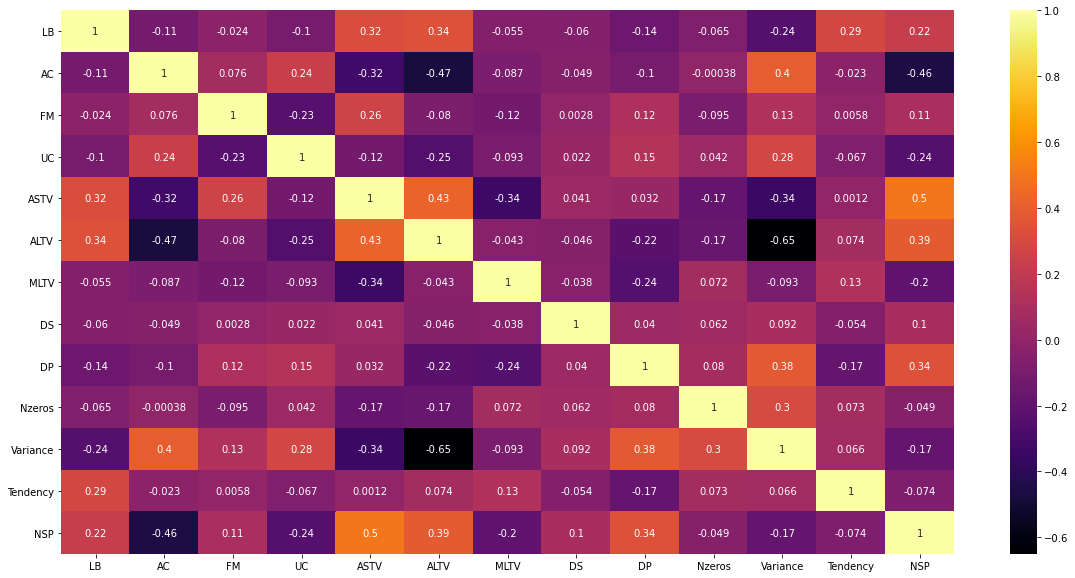

In [11]:
#Getting the Correlation 
corr = df.corr(method='spearman')
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True,cmap="inferno")
df.columns

<ipython-input-12-601456adbd7b>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_X.hist(ax=ax)


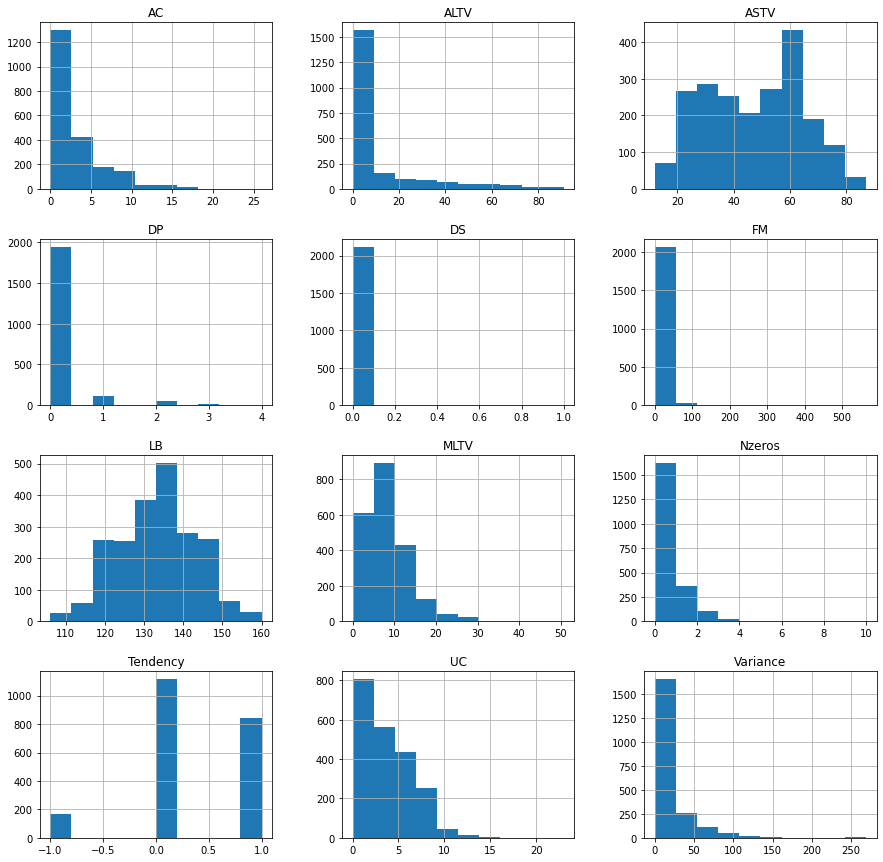

In [12]:
# Histogram for all features
df_X = df.drop(columns=['NSP'])
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
df_X.hist(ax=ax)
plt.show()

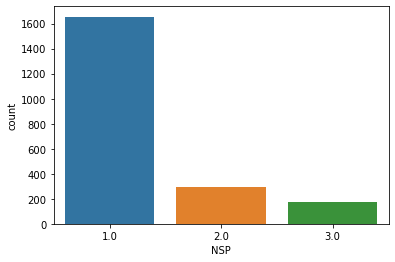

In [13]:
sns.countplot(x='NSP',data=df)

In [14]:
#ref-https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
#relabelling the classes as class1 = class 0, Class 2= class 1, class3=class 2
class2idx = {
    1:0,
    2:1,
    3:2
}

idx2class = {v: k for k, v in class2idx.items()}

df['NSP'].replace(class2idx, inplace=True)

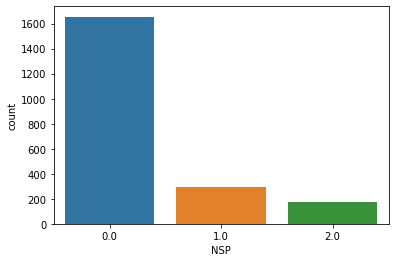

In [15]:
sns.countplot(x='NSP',data=df)

In [16]:
#defining X and Y 
X=df.drop(["NSP"],axis=1)
y=df["NSP"]

In [17]:
#splitting the data to train(70 %)  and test(30 %) 
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,y,test_size=0.3)

In [18]:
#Binarize labels in a one-vs-all fashion to use the Y_test_Roc values could be used while plotting the ROC curves 
from sklearn.preprocessing import label_binarize
Y_test_ROC = label_binarize(Ytest, classes=[0, 1, 2])
print(Y_test_ROC)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]


In [19]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1488 entries, 1471 to 739
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        1488 non-null   float64
 1   AC        1488 non-null   float64
 2   FM        1488 non-null   float64
 3   UC        1488 non-null   float64
 4   ASTV      1488 non-null   float64
 5   ALTV      1488 non-null   float64
 6   MLTV      1488 non-null   float64
 7   DS        1488 non-null   float64
 8   DP        1488 non-null   float64
 9   Nzeros    1488 non-null   float64
 10  Variance  1488 non-null   float64
 11  Tendency  1488 non-null   float64
dtypes: float64(12)
memory usage: 151.1 KB


In [20]:
#ref-https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
#since the classes in our dataset were disbalanced we balanced them using borderline SMOTE 
# borderline-SMOTE for imbalanced dataset
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(Ytrain)
print(counter)
# transform the dataset
oversample = BorderlineSMOTE()
Xtrain, Ytrain = oversample.fit_resample(Xtrain, Ytrain)
# summarize the new class distribution
counter = Counter(Ytrain)
print(counter)


Counter({0.0: 1165, 1.0: 197, 2.0: 126})
Counter({0.0: 1165, 1.0: 1165, 2.0: 1165})


In [21]:
#WE scale all the features
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import numpy as np
import torch 
scaler = MinMaxScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)
Xtrain, Ytrain = np.array(Xtrain), np.array(Ytrain)
Xtest, Ytest = np.array(Xtest), np.array(Ytest)

# MULTILAYER PERCEPTRON 

We have used multiple approaches using 
1)MLP classifier from Sklearn and creating a multilayer perceptron 
2)using pytorch with skorch  for our multilayer perceptron

In [22]:
#import torch 
x_train = torch.tensor(Xtrain)
y_train = torch.tensor(Ytrain)
x_test = torch.tensor(Xtest)
y_test = torch.tensor(Ytest)

# 1st MLP classifier approach 

GridSearch for MLP classfier for SKlearn
1)we have tried to experiment with different parameters to knw our best  hidden layer sizes, activation functions, and solver for weight optimization.
2)Since False Negatives are important in our case scoring parameter is recall_macro

In [38]:
#GridSearch for MLP classfier from SKlearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
           
mlp=MLPClassifier(random_state=10)
grid_values = {'max_iter':[200],
              "hidden_layer_sizes": [(11,11,11),
                                     (128,64),
                                     (32,16,8,4)],
              "solver" : ["adam","sgd"],
              "activation": ["relu","sigmoid"]}
grid_mlp=GridSearchCV(mlp,param_grid=grid_values,scoring='recall_macro',cv=5)

In [39]:
grid_mlp.fit(Xtrain, Ytrain)

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPClassifier(random_state=10),
             param_grid={'activation': ['relu', 'sigmoid'],
                         'hidden_layer_sizes': [(11, 11, 11), (128, 64),
                                                (32, 16, 8, 4)],
                         'max_iter': [200], 'solver': ['adam', 'sgd']},
             scoring='recall_macro')

In [45]:
#our best parameters after gridsearch 
grid_mlp.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': (128, 64),
 'max_iter': 200,
 'solver': 'adam'}

In [46]:
grid_mlp.best_score_

0.9484978540772533

In [84]:
m_best=grid_mlp.best_estimator_
ypred2 = m_best.predict(Xtest)

In [89]:
#getting the recall_score for oue best estimator
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

print("recall_score:",recall_score(Ytest, ypred2,average='macro'))
print("accuracy_score:",accuracy_score(Ytest, ypred_2))
from sklearn.metrics import classification_report,confusion_matrix
confusion_matrix(Ytest, ypred2)

recall_score: 0.8506122448979592
accuracy_score: 0.9028213166144201


array([[459,  31,   0],
       [ 21,  74,   3],
       [  6,   1,  43]], dtype=int64)

# Multi layer Perceptron -using pytorch 

Architechure 1 -
1)We have used activation function Relu  for our 2 hidden layers
2)we used dropout as 0.5 

In [54]:
import torch.nn as nn
import torch.nn.functional as F

class ContraclassClassification(nn.Module):
    def __init__(self,
                dropout=0.5,
                ):
        
        super(ContraclassClassification, self).__init__()
        self.dropout = nn.Dropout(dropout)
        
        self.layer_1 = nn.Linear(12, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, 3) 
        
        
    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = self.dropout(x)      
        x = F.relu(self.layer_2(x))
        x = self.dropout(x)
        return x 

Despite of having a multiclass classification we have not used softmax on our output layer because of use of"crossentropyloss" 
According to the documentation torch.nn.CrossEntropyLoss() combines nn.LogSoftmax() and nn.NLLLoss() in one single class

In [91]:
from skorch.callbacks import EpochScoring

recall_sc = EpochScoring(scoring='recall_macro', lower_is_better= False)
net = NeuralNetClassifier(
    ContraclassClassification,
    lr=0.1,
    max_epochs=200,
    criterion = torch.nn.modules.loss.CrossEntropyLoss,   
    optimizer=torch.optim.Adam,
    callbacks=[recall_sc]
)
 

In [73]:
#Grid Search for the below parameters 
from sklearn.model_selection import GridSearchCV
params={
        'module__dropout':[0.5,0.1],
        'lr':[0.01,0.05,0.1],
        'max_epochs':[200],
        'batch_size':[50,100],
        'optimizer__weight_decay':[0.01,0.5]    
}
gs=GridSearchCV(net,params,refit=False,cv=3,scoring='recall_macro')
gs.fit(x_train.float(), y_train.long())#comment it 
print(gs.best_score_,gs.best_params_)

  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        4.1249       0.3348        4.1587  0.1656
      2          0.3205        4.1317       0.3219        3.8386  0.1231
      3          0.3312        3.7685       0.3305        3.8832  0.1211
      4          0.3333        3.7048       0.3326        2.7833  0.1206
      5          0.3333        3.9090       0.3326        3.5490  0.1236
      6          0.3376        3.5529       0.3369        2.6461  0.1236
      7          0.3333        3.3652       0.3326        2.5205  0.1261
      8          0.5312        3.3763       0.5300        2.7306  0.1306
      9          0.5355        3.2007       0.5343        2.5430  0.1211
     10          0.4194        3.0654       0.4185        2.3138  0.1246
     11          0.4452        3.0772       0.4442        2.3719  0.1351
     12          0.3376        3.1813       0.3369 

    106          0.5563        2.7899       0.5558        2.1498  0.1930
    107          0.6933        2.8543       0.6931        2.0661  0.1935
    108          0.5256        2.9417       0.5258        2.1186  0.2138
    109          0.5372        2.8309       0.5365        2.0970  0.1786
    110          0.6136        2.7955       0.6137        2.1249  0.1785
    111          0.4124        2.7998       0.4120        2.2741  0.1671
    112          0.6460        2.8613       0.6459        2.0514  0.1681
    113          0.5859        3.0314       0.5858        2.0569  0.1736
    114          0.3333        2.7421       0.3326        2.3517  0.1856
    115          0.5264        3.1705       0.5258        2.1205  0.1781
    116          0.7171        2.7980       0.7167        2.1062  0.1781
    117          0.6286        2.8104       0.6288        2.1337  0.1814
    118          0.6333        2.8520       0.6330        2.0694  0.1901
    119          0.5799        2.9193       0.5794 

     13          0.5054        2.9762       0.5043        2.4120  0.1086
     14          0.4731        2.9773       0.4721        2.2506  0.1191
     15          0.4602        2.9529       0.4592        2.1923  0.1281
     16          0.3398        3.0239       0.3391        2.2315  0.1131
     17          0.7144        2.9830       0.7146        2.2465  0.1236
     18          0.5503        2.9175       0.5494        2.4187  0.1166
     19          0.4666        3.0487       0.4657        2.4061  0.1226
     20          0.3806        3.0266       0.3798        2.1626  0.1136
     21          0.7057        2.9623       0.7060        2.1872  0.1166
     22          0.6398        2.9388       0.6395        2.1881  0.1146
     23          0.4943        2.8637       0.4936        2.2029  0.1281
     24          0.5372        2.8505       0.5365        2.0508  0.1201
     25          0.5796        2.9135       0.5794        2.1025  0.1106
     26          0.6481        2.8528       0.6481 

    122          0.6483        2.8398       0.6481        2.0599  0.1841
    123          0.5962        3.0723       0.5966        2.0093  0.1821
    124          0.7344        2.7731       0.7339        2.1241  0.2021
    125          0.7834        2.6795       0.7833        2.0058  0.1861
    126          0.6612        2.8424       0.6609        2.0362  0.1711
    127          0.6613        2.7463       0.6609        2.0546  0.1892
    128          0.6503        2.7643       0.6502        2.0434  0.1801
    129          0.5175        2.9574       0.5172        2.1094  0.1695
    130          0.7064        2.7646       0.7060        2.0705  0.1841
    131          0.6612        2.7521       0.6609        2.0648  0.1941
    132          0.7042        2.7281       0.7039        2.0741  0.1861
    133          0.7405        2.7671       0.7403        2.0469  0.1751
    134          0.5171        2.9074       0.5172        2.1380  0.1846
    135          0.7192        2.7331       0.7189 

     28          0.4601        2.8885       0.4592        1.8323  0.1136
     29          0.4918        2.8983       0.4914        1.9996  0.1191
     30          0.5842        2.9536       0.5837        2.2429  0.1281
     31          0.5541        2.8768       0.5536        2.1273  0.1181
     32          0.3782        2.7759       0.3777        2.3621  0.1121
     33          0.3996        3.0255       0.3991        2.3790  0.1196
     34          0.4407        2.8891       0.4399        1.9737  0.1106
     35          0.7037        2.8563       0.7039        1.9504  0.1251
     36          0.3440        2.8346       0.3433        2.4754  0.1186
     37          0.4515        2.8469       0.4506        2.0608  0.1186
     38          0.5415        2.8182       0.5408        1.9189  0.1216
     39          0.3869        2.9217       0.3863        2.2547  0.1306
     40          0.5815        2.8920       0.5815        2.0693  0.1336
     41          0.4815        2.9302       0.4807 

    139          0.7018        2.7725       0.7017        1.9582  0.1791
    140          0.5321        2.7323       0.5322        2.1397  0.1761
    141          0.7384        2.8043       0.7382        1.9708  0.1741
    142          0.6417        2.8672       0.6416        1.9831  0.1791
    143          0.7449        2.8019       0.7446        2.0566  0.1861
    144          0.6739        2.9867       0.6738        2.0284  0.1861
    145          0.5214        2.7726       0.5215        2.1254  0.1791
    146          0.6869        2.6996       0.6867        2.0013  0.1761
    147          0.7342        2.7598       0.7339        2.0270  0.1781
    148          0.4615        2.7655       0.4614        2.2859  0.1751
    149          0.6955        2.7690       0.6953        2.0189  0.1821
    150          0.6955        2.9490       0.6953        2.0145  0.1871
    151          0.7212        2.8003       0.7210        1.9647  0.1972
    152          0.6783        2.9549       0.6781 

     47          0.3333        3.4709       0.3326        3.2166  0.1191
     48          0.3333        3.5745       0.3326        3.4005  0.1141
     49          0.3333        3.4950       0.3326        3.3376  0.1106
     50          0.3333        3.4775       0.3326        3.2520  0.1046
     51          0.3333        3.5244       0.3326        3.2585  0.1156
     52          0.3333        3.5368       0.3326        3.3636  0.1166
     53          0.3333        3.5504       0.3326        3.3601  0.1061
     54          0.3333        3.4751       0.3326        3.2124  0.1106
     55          0.3333        3.5100       0.3326        3.2575  0.1131
     56          0.3333        3.5389       0.3326        3.3267  0.1071
     57          0.3333        3.5130       0.3326        3.3579  0.1071
     58          0.3333        3.4976       0.3326        3.2412  0.1081
     59          0.3333        3.5939       0.3326        3.4125  0.1091
     60          0.3333        3.5452       0.3326 

    159          0.3333        3.5213       0.3326        3.3417  0.1531
    160          0.3333        3.4808       0.3326        3.2884  0.1411
    161          0.3333        3.4940       0.3326        3.2405  0.1201
    162          0.3333        3.5278       0.3326        3.3475  0.1281
    163          0.3333        3.5310       0.3326        3.2997  0.1190
    164          0.3333        3.5205       0.3326        3.3337  0.1129
    165          0.3333        3.5107       0.3326        3.3013  0.1217
    166          0.3333        3.5132       0.3326        3.1847  0.1268
    167          0.3333        3.5097       0.3326        3.2980  0.1125
    168          0.3333        3.5538       0.3326        3.3984  0.1145
    169          0.3333        3.5323       0.3326        3.3795  0.1171
    170          0.3333        3.4850       0.3326        3.2544  0.1161
    171          0.3333        3.5093       0.3326        3.3022  0.1127
    172          0.3333        3.5015       0.3326 

     67          0.3333        3.5278       0.3326        3.4113  0.1206
     68          0.3333        3.4686       0.3326        3.3212  0.1106
     69          0.3333        3.5188       0.3326        3.2997  0.1181
     70          0.3333        3.5274       0.3326        3.3502  0.1106
     71          0.3333        3.5627       0.3326        3.3254  0.1146
     72          0.3333        3.5556       0.3326        3.2795  0.1196
     73          0.3333        3.5643       0.3326        3.3614  0.1186
     74          0.3333        3.5547       0.3326        3.4399  0.1106
     75          0.3333        3.5250       0.3326        3.3855  0.1121
     76          0.3333        3.5767       0.3326        3.4137  0.1306
     77          0.3333        3.5129       0.3326        3.3609  0.1161
     78          0.3333        3.5450       0.3326        3.3528  0.1126
     79          0.3333        3.5736       0.3326        3.3578  0.1236
     80          0.3333        3.5514       0.3326 

     88          0.3333        3.4721       0.3326        3.2924  0.1156
     89          0.3333        3.4832       0.3326        3.3265  0.1186
     90          0.3333        3.5386       0.3326        3.3240  0.1076
     91          0.3333        3.5190       0.3326        3.3232  0.1071
     92          0.3333        3.4909       0.3326        3.2754  0.1221
     93          0.3333        3.5146       0.3326        3.3377  0.1081
     94          0.3333        3.4543       0.3326        3.2621  0.1036
     95          0.3333        3.4187       0.3326        3.1172  0.1106
     96          0.3333        3.5351       0.3326        3.2766  0.1216
     97          0.3333        3.5304       0.3326        3.3347  0.1076
     98          0.3333        3.4901       0.3326        3.3150  0.1116
     99          0.3333        3.5497       0.3326        3.3484  0.1051
    100          0.3333        3.4443       0.3326        3.2590  0.1151
    101          0.3333        3.4810       0.3326 

  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3397        4.0752       0.3391        3.9648  0.1076
      2          0.3333        3.4204       0.3326        3.7165  0.1111
      3          0.3333        3.9046       0.3348        3.1216  0.2214
      4          0.3333        2.9415       0.3326        1.8563  0.1181
      5          0.3333        2.6164       0.3326        1.6728  0.1231
      6          0.4968        2.4792       0.4957        1.1982  0.1176
      7          0.5118        1.8163       0.5107        1.3264  0.1076
      8          0.4796        1.9556       0.4785        1.1490  0.1701
      9          0.5183        1.8139       0.5172        1.0289  0.1751
     10          0.5075        1.6741       0.5064        1.0936  0.1066
     11          0.5161        1.6002       0.5150        0.9831  0.1096
     12          0.5075        1.6335       0.5064 

    101          0.7148        1.2467       0.7146        0.7808  0.1686
    102          0.6658        1.5910       0.6652        0.9290  0.1691
    103          0.7684        1.4719       0.7682        0.6125  0.1616
    104          0.7342        1.3470       0.7339        0.7545  0.1756
    105          0.8114        1.3631       0.8112        0.6554  0.1781
    106          0.8114        1.1960       0.8112        0.6148  0.1771
    107          0.8092        1.1617       0.8090        0.6056  0.1671
    108          0.8135        1.2165       0.8133        0.6009  0.1691
    109          0.7963        1.2201       0.7961        0.6222  0.1751
    110          0.8114        1.2191       0.8112        0.6262  0.1771
    111          0.8049        1.2211       0.8047        0.6109  0.1691
    112          0.8114        1.2617       0.8112        0.6389  0.1691
    113          0.8050        1.3441       0.8047        0.6520  0.1701
    114          0.7403        1.3207       0.7403 

      8          0.3355        2.1787       0.3348        1.7684  0.1046
      9          0.3720        2.2520       0.3712        1.4724  0.1111
     10          0.3828        1.9950       0.3820        1.3879  0.1101
     11          0.4194        2.0454       0.4185        1.2367  0.1056
     12          0.4430        1.8161       0.4421        1.1594  0.1091
     13          0.4645        1.7072       0.4635        1.0239  0.1331
     14          0.4236        1.6057       0.4227        1.0569  0.1121
     15          0.4301        1.5402       0.4292        1.0849  0.1076
     16          0.4644        1.5819       0.4635        1.0055  0.1051
     17          0.4622        1.5844       0.4614        1.0054  0.1161
     18          0.5349        1.5524       0.5343        0.9348  0.1121
     19          0.4943        1.5370       0.4936        0.9575  0.1156
     20          0.6097        1.5652       0.6094        0.9010  0.1111
     21          0.5093        1.4265       0.5086 

    113          0.6801        1.3054       0.6803        0.7927  0.1701
    114          0.6009        1.4205       0.6009        0.9816  0.1751
    115          0.7169        1.4337       0.7167        0.6965  0.1821
    116          0.7554        1.3556       0.7554        0.6894  0.1821
    117          0.7362        1.2026       0.7361        0.6962  0.1791
    118          0.7490        1.3026       0.7489        0.7044  0.1881
    119          0.7383        1.2513       0.7382        0.6817  0.1811
    120          0.6780        1.2859       0.6781        0.7977  0.1801
    121          0.7191        1.3976       0.7189        0.7706  0.1791
    122          0.7146        1.2391       0.7146        0.7692  0.1701
    123          0.7127        1.2811       0.7124        0.7306  0.1791
    124          0.6568        1.3180       0.6567        0.8383  0.1701
    125          0.7148        1.2776       0.7146        0.7171  0.1741
    126          0.7105        1.2465       0.7103 

     18          0.5416        1.5044       0.5408        0.8531  0.1166
     19          0.5287        1.4410       0.5279        0.8634  0.1166
     20          0.5351        1.4954       0.5343        0.8683  0.1086
     21          0.5458        1.4624       0.5451        0.8525  0.1086
     22          0.4664        1.4960       0.4657        0.9835  0.1101
     23          0.5178        1.4980       0.5172        0.8336  0.1201
     24          0.6185        1.5489       0.6180        0.8212  0.1141
     25          0.4533        1.4259       0.4528        1.1058  0.1131
     26          0.4924        1.4634       0.4914        0.9271  0.1261
     27          0.5372        1.5121       0.5365        0.8180  0.1091
     28          0.6312        1.4572       0.6309        0.7886  0.1071
     29          0.5971        1.4236       0.5966        0.8462  0.1111
     30          0.5736        1.3770       0.5730        0.8080  0.1131
     31          0.5156        1.4182       0.5150 

    125          0.6805        1.2053       0.6803        0.8142  0.2192
    126          0.7019        1.2722       0.7017        0.7866  0.1821
    127          0.7277        1.2432       0.7275        0.6727  0.1651
    128          0.7019        1.2119       0.7017        0.6987  0.1711
    129          0.6932        1.2281       0.6931        0.7570  0.1751
    130          0.6909        1.3247       0.6910        0.8320  0.1671
    131          0.6741        1.2420       0.6738        0.8118  0.1661
    132          0.5665        1.2218       0.5665        1.2855  0.1611
    133          0.6935        1.2907       0.6931        0.7739  0.1751
    134          0.6870        1.3085       0.6867        0.7441  0.1621
    135          0.7298        1.2332       0.7296        0.6715  0.1661
    136          0.5856        1.2103       0.5858        1.2880  0.1681
    137          0.6719        1.2801       0.6717        0.8278  0.1711
    138          0.5971        1.5903       0.5966 

     32          0.3333        2.6531       0.3326        2.3577  0.1101
     33          0.3333        2.6502       0.3326        2.3285  0.1141
     34          0.3333        2.6282       0.3326        2.3718  0.1101
     35          0.3333        2.5893       0.3326        2.3081  0.1126
     36          0.3333        2.6308       0.3326        2.4117  0.1116
     37          0.3333        2.6202       0.3326        2.3327  0.1121
     38          0.3333        2.6064       0.3326        2.3261  0.1116
     39          0.3333        2.6783       0.3326        2.3425  0.1121
     40          0.3333        2.6614       0.3326        2.3605  0.1136
     41          0.3333        2.6832       0.3326        2.3494  0.1086
     42          0.3333        2.6575       0.3326        2.4130  0.1106
     43          0.3333        2.6061       0.3326        2.3138  0.1056
     44          0.3333        2.6400       0.3326        2.3667  0.1111
     45          0.3333        2.5861       0.3326 

    144          0.3333        2.5806       0.3326        2.3577  0.1151
    145          0.3333        2.6193       0.3326        2.4199  0.1201
    146          0.3333        2.6483       0.3326        2.4405  0.1211
    147          0.3333        2.6650       0.3326        2.3911  0.1205
    148          0.3333        2.6123       0.3326        2.3710  0.1271
    149          0.3333        2.5903       0.3326        2.3899  0.1160
    150          0.3333        2.5775       0.3326        2.3174  0.1133
    151          0.3333        2.6036       0.3326        2.3371  0.1191
    152          0.3333        2.5627       0.3326        2.2858  0.1201
    153          0.3333        2.6005       0.3326        2.3489  0.1151
    154          0.3333        2.5878       0.3326        2.3130  0.1111
    155          0.3333        2.6195       0.3326        2.3789  0.1123
    156          0.3333        2.5802       0.3326        2.3864  0.1057
    157          0.3333        2.5801       0.3326 

     50          0.3333        2.6041       0.3326        2.3587  0.1071
     51          0.3333        2.6182       0.3326        2.3446  0.1041
     52          0.3333        2.6399       0.3326        2.3758  0.1101
     53          0.3333        2.6323       0.3326        2.3864  0.1041
     54          0.3333        2.6123       0.3326        2.3824  0.1011
     55          0.3333        2.6672       0.3326        2.3676  0.1001
     56          0.3333        2.6528       0.3326        2.2927  0.1081
     57          0.3333        2.6598       0.3326        2.3764  0.1311
     58          0.3333        2.6407       0.3326        2.3360  0.1141
     59          0.3333        2.6255       0.3326        2.3813  0.0991
     60          0.3333        2.6325       0.3326        2.4033  0.1041
     61          0.3333        2.6497       0.3326        2.3477  0.1071
     62          0.3333        2.7180       0.3326        2.4045  0.1031
     63          0.3333        2.6202       0.3326 

    162          0.3333        2.7044       0.3326        2.4670  0.1081
    163          0.3333        2.5364       0.3326        2.3292  0.1021
    164          0.3333        2.5712       0.3326        2.3412  0.1051
    165          0.3333        2.6014       0.3326        2.3409  0.1061
    166          0.3333        2.5724       0.3326        2.3655  0.1071
    167          0.3333        2.6128       0.3326        2.3985  0.1061
    168          0.3333        2.5437       0.3326        2.3594  0.1101
    169          0.3333        2.6227       0.3326        2.3729  0.1071
    170          0.3333        2.5914       0.3326        2.3320  0.1081
    171          0.3333        2.6176       0.3326        2.3934  0.1021
    172          0.3333        2.6124       0.3326        2.4168  0.1171
    173          0.3333        2.5890       0.3326        2.3646  0.1091
    174          0.3333        2.5865       0.3326        2.3466  0.1031
    175          0.3333        2.6605       0.3326 

     69          0.3333        2.5754       0.3326        2.3506  0.1081
     70          0.3333        2.6316       0.3326        2.3165  0.1041
     71          0.3333        2.6699       0.3326        2.3549  0.1051
     72          0.3333        2.6450       0.3326        2.3575  0.1031
     73          0.3333        2.6554       0.3326        2.4046  0.1121
     74          0.3333        2.5840       0.3326        2.3696  0.1001
     75          0.3333        2.6352       0.3326        2.3095  0.0981
     76          0.3333        2.6146       0.3326        2.3528  0.1081
     77          0.3333        2.6301       0.3326        2.3607  0.1021
     78          0.3333        2.6496       0.3326        2.3591  0.1121
     79          0.3333        2.5919       0.3326        2.3389  0.1081
     80          0.3333        2.6479       0.3326        2.4072  0.1061
     81          0.3333        2.6560       0.3326        2.3425  0.0991
     82          0.3333        2.6911       0.3326 

    181          0.3333        2.6535       0.3326        2.3566  0.1061
    182          0.3333        2.6119       0.3326        2.3583  0.1031
    183          0.3333        2.6051       0.3326        2.3925  0.1151
    184          0.3333        2.6431       0.3326        2.4099  0.1001
    185          0.3333        2.6448       0.3326        2.3561  0.1001
    186          0.3333        2.6418       0.3326        2.3226  0.1061
    187          0.3333        2.5963       0.3326        2.3068  0.1001
    188          0.3333        2.6527       0.3326        2.3529  0.1031
    189          0.3333        2.5808       0.3326        2.3409  0.1161
    190          0.3333        2.5607       0.3326        2.3121  0.1111
    191          0.3333        2.6078       0.3326        2.3389  0.1031
    192          0.3333        2.5924       0.3326        2.3449  0.1011
    193          0.3333        2.6089       0.3326        2.3284  0.1101
    194          0.3333        2.5826       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      5          0.0000        4.1590       0.0000        4.1591  0.1011
      6          0.0000        4.1590       0.0000        4.1589  0.1151


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      7          0.3333        4.1590       0.3348        4.1589  0.1211
      8          0.0000        4.1590       0.0000        4.1590  0.1021
      9          0.0000        4.1590       0.0000        4.1590  0.1011


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     10          0.3333        4.1590       0.3348        4.1589  0.1011
     11          0.3333        4.1590       0.3348        4.1589  0.1071
     12          0.0000        4.1590       0.0000        4.1590  0.1051
     13          0.0000        4.1590       0.0000        4.1590  0.1021


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     14          0.0000        4.1590       0.0000        4.1590  0.1021
     15          0.0000        4.1590       0.0000        4.1589  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     16          0.0000        4.1590       0.0000        4.1589  0.1031
     17          0.0000        4.1590       0.0000        4.1590  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     18          0.0000        4.1590       0.0000        4.1589  0.1031
     19          0.0000        4.1590       0.0000        4.1590  0.1001


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     20          0.0000        4.1590       0.0000        4.1590  0.1121
     21          0.0000        4.1590       0.0000        4.1589  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     22          0.0000        4.1590       0.0000        4.1589  0.1111
     23          0.0000        4.1590       0.0000        4.1590  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     24          0.0000        4.1590       0.0000        4.1589  0.1141
     25          0.0000        4.1590       0.0000        4.1589  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     26          0.0000        4.1590       0.0000        4.1589  0.1151
     27          0.0000        4.1590       0.0000        4.1590  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     28          0.0000        4.1590       0.0000        4.1590  0.1041
     29          0.0000        4.1590       0.0000        4.1590  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     30          0.0000        4.1590       0.0000        4.1591  0.1081
     31          0.0000        4.1590       0.0000        4.1590  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     32          0.0000        4.1590       0.0000        4.1589  0.1101
     33          0.3333        4.1590       0.3348        4.1589  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     34          0.0000        4.1590       0.0000        4.1589  0.1091
     35          0.0000        4.1590       0.0000        4.1590  0.1121


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     36          0.0000        4.1590       0.0000        4.1590  0.1171
     37          0.0000        4.1590       0.0000        4.1589  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     38          0.0000        4.1590       0.0000        4.1589  0.1161
     39          0.0000        4.1590       0.0000        4.1590  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     40          0.0000        4.1590       0.0000        4.1590  0.1211
     41          0.0000        4.1590       0.0000        4.1590  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     42          0.0000        4.1590       0.0000        4.1589  0.1121
     43          0.0000        4.1590       0.0000        4.1590  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     44          0.0000        4.1590       0.0000        4.1590  0.1101
     45          0.0000        4.1590       0.0000        4.1589  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     46          0.0000        4.1590       0.0000        4.1590  0.1091
     47          0.0000        4.1590       0.0000        4.1592  0.1131


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     48          0.0000        4.1590       0.0000        4.1589  0.1151
     49          0.0000        4.1590       0.0000        4.1590  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     50          0.0000        4.1590       0.0000        4.1590  0.1091
     51          0.0000        4.1590       0.0000        4.1589  0.1121


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     52          0.0000        4.1590       0.0000        4.1590  0.1101
     53          0.0000        4.1590       0.0000        4.1589  0.1141


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     54          0.0000        4.1590       0.0000        4.1590  0.1241
     55          0.3333        4.3213       0.3326        4.1178  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     56          0.0000        4.1592       0.0000        4.1591  0.1201
     57          0.0000        4.1590       0.0000        4.1590  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     58          0.0000        4.1590       0.0000        4.1591  0.1311
     59          0.0000        4.1590       0.0000        4.1590  0.1211


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     60          0.0000        4.1590       0.0000        4.1589  0.1281
     61          0.0000        4.1590       0.0000        4.1589  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     62          0.0000        4.1590       0.0000        4.1589  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     63          0.0000        4.1590       0.0000        4.1590  0.1371
     64          0.0000        4.1590       0.0000        4.1589  0.1391


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     65          0.0000        4.1590       0.0000        4.1590  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     66          0.0000        4.1590       0.0000        4.1589  0.1531
     67          0.0000        4.1590       0.0000        4.1590  0.1431


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     68          0.0000        4.1590       0.0000        4.1590  0.1421
     69          0.0000        4.1590       0.0000        4.1590  0.1411


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     70          0.0000        4.1590       0.0000        4.1590  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     71          0.0000        4.1590       0.0000        4.1590  0.1371
     72          0.0000        4.1590       0.0000        4.1591  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     73          0.0000        4.1590       0.0000        4.1589  0.1421
     74          0.0000        4.1590       0.0000        4.1589  0.1411


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     75          0.3333        4.1590       0.3348        4.1589  0.1311
     76          0.0000        4.1590       0.0000        4.1590  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     77          0.0000        4.1590       0.0000        4.1590  0.2332
     78          0.0000        4.1590       0.0000        4.1589  0.1451


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     79          0.3333        3.8471       0.3326       24.2558  0.1411
     80          0.3333        6.9850       0.3326       25.3646  0.1331
     81          0.1154        6.5255       0.1545        4.1590  0.1231
     82          0.0000        4.1598       0.0000        4.1590  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     83          0.0000        4.1589       0.0000        4.1589  0.1251
     84          0.0000        4.1589       0.0000        4.1589  0.1221


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     85          0.0000        4.1590       0.0000        4.1590  0.1211
     86          0.0000        4.1589       0.0000        4.1591  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     87          0.0000        4.1590       0.0000        4.1589  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     88          0.0000        4.1590       0.0000        4.1589  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     89          0.0000        4.1590       0.0000        4.1591  0.1531
     90          0.0000        4.1590       0.0000        4.1589  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     91          0.0000        4.1590       0.0000        4.1589  0.1231
     92          0.0000        4.1590       0.0000        4.1589  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     93          0.0000        4.1590       0.0000        4.1590  0.1121
     94          0.0000        4.1590       0.0000        4.1589  0.1151


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     95          0.0000        4.1590       0.0000        4.1590  0.1641


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     96          0.3333        4.1590       0.3348        4.1589  0.1681
     97          0.0000        4.1590       0.0000        4.1589  0.1581


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     98          0.0000        4.1590       0.0000        4.1590  0.1611


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     99          0.0000        4.1590       0.0000        4.1591  0.1551


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    100          0.0000        4.1590       0.0000        4.1589  0.1191
    101          0.0000        4.1590       0.0000        4.1590  0.1161


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    102          0.0000        4.1590       0.0000        4.1590  0.1461
    103          0.0000        4.1590       0.0000        4.1592  0.1151


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    104          0.0000        4.1721       0.0000        4.1601  0.1111
    105          0.2484        5.0371       0.3326        4.1589  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    106          0.1949        4.1611       0.3262        4.1589  0.1081
    107          0.3333        5.4648       0.3326       34.9113  0.1091


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    108          0.3333        6.7068       0.3348        4.1589  0.1131
    109          0.1372        4.1798       0.2296        4.1589  0.1121
    110          0.0000        4.1589       0.0000        4.1589  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    111          0.0000        4.1589       0.0000        4.1589  0.1171
    112          0.0000        4.1589       0.0000        4.1590  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    113          0.0000        4.1590       0.0000        4.1590  0.1051
    114          0.0000        4.1590       0.0000        4.1589  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    115          0.3333        4.1590       0.3348        4.1589  0.1121
    116          0.0000        4.1590       0.0000        4.1589  0.1071
    117          0.0000        4.1590       0.0000        4.1592  0.1121


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    118          0.3333        4.1590       0.3348        4.1589  0.1131
    119          0.3333        4.1590       0.3348        4.1589  0.1191
    120          0.0000        4.1590       0.0000        4.1590  0.1231
    121          0.0000        4.1590       0.0000        4.1589  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    122          0.0000        4.1590       0.0000        4.1590  0.1271
    123          0.0000        4.1590       0.0000        4.1590  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    124          0.0000        4.1590       0.0000        4.1590  0.1571


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    125          0.0000        4.1590       0.0000        4.1590  0.1321
    126          0.3333        4.1590       0.3348        4.1589  0.1381
    127          0.0000        4.1590       0.0000        4.1590  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    128          0.3333        4.1590       0.3348        4.1589  0.1411
    129          0.0000        4.1590       0.0000        4.1590  0.1391


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    130          0.0000        4.1590       0.0000        4.1589  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    131          0.0000        4.1590       0.0000        4.1590  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    132          0.0000        4.1590       0.0000        4.1589  0.1401
    133          0.0000        4.1590       0.0000        4.1590  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    134          0.0000        4.1590       0.0000        4.1589  0.1391
    135          0.3333        5.4880       0.3348        4.1589  0.1341
    136          0.0000        4.1602       0.0000        4.1593  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    137          0.0000        4.1590       0.0000        4.1589  0.1341
    138          0.3333        4.1590       0.3348        4.1589  0.1321
    139          0.0000        4.1590       0.0000        4.1590  0.1421


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    140          0.0000        4.1590       0.0000        4.1589  0.1501


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    141          0.0000        4.1590       0.0000        4.1591  0.1371
    142          0.0000        4.1590       0.0000        4.1589  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    143          0.0000        4.1590       0.0000        4.1590  0.1551


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    144          0.0000        4.1590       0.0000        4.1589  0.1391
    145          0.0000        4.1590       0.0000        4.1590  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    146          0.0000        4.1590       0.0000        4.1590  0.1481


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    147          0.0000        4.1590       0.0000        4.1590  0.1471


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    148          0.0000        4.1590       0.0000        4.1589  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    149          0.0000        4.1590       0.0000        4.1590  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    150          0.0000        4.1590       0.0000        4.1590  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    151          0.0000        4.1590       0.0000        4.1589  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    152          0.0000        4.1590       0.0000        4.1591  0.1481


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    153          0.0000        4.1590       0.0000        4.1591  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    154          0.0000        4.1590       0.0000        4.1590  0.1511


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    155          0.3333        4.1590       0.3348        4.1589  0.1411
    156          0.0000        4.1590       0.0000        4.1590  0.1451


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    157          0.3333        4.1590       0.3348        4.1589  0.1441
    158          0.0000        4.1590       0.0000        4.1590  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    159          0.0000        4.1590       0.0000        4.1590  0.1551


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    160          0.0000        4.1590       0.0000        4.1591  0.1431


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    161          0.0000        4.1590       0.0000        4.1591  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    162          0.0000        4.1590       0.0000        4.1589  0.1451


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    163          0.3936        4.1590       0.3948        4.1589  0.1431
    164          0.0000        4.1590       0.0000        4.1590  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    165          0.0000        4.1590       0.0000        4.1589  0.1511


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    166          0.3333        4.1590       0.3348        4.1589  0.1411
    167          0.0000        4.1590       0.0000        4.1590  0.1491


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    168          0.0000        4.1590       0.0000        4.1590  0.1491


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    169          0.0000        4.1590       0.0000        4.1589  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    170          0.0000        4.1590       0.0000        4.1590  0.1471


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    171          0.0000        4.1590       0.0000        4.1590  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    172          0.0000        4.1590       0.0000        4.1590  0.1391


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    173          0.0000        4.1590       0.0000        4.1590  0.1451


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    174          0.0000        4.1590       0.0000        4.1590  0.1481


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    175          0.0000        4.1590       0.0000        4.1590  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    176          0.0000        4.1590       0.0000        4.1590  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    177          0.0000        4.1590       0.0000        4.1590  0.1501


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    178          0.0000        4.1590       0.0000        4.1589  0.1391


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    179          0.0000        4.1590       0.0000        4.1590  0.1501


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    180          0.0000        4.1590       0.0000        4.1590  0.1431


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    181          0.0000        4.1590       0.0000        4.1589  0.1411


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    182          0.3333        4.1590       0.3348        4.1589  0.1431
    183          0.3333        4.0891       0.3326        5.2744  0.1491
    184          0.3333        3.9820       0.3326       17.4249  0.1351
    185          0.3333        5.3800       0.3326       29.0298  0.1321
    186          0.3333        7.1967       0.3348        4.1589  0.1281
    187          0.0000        4.1603       0.0000        4.1590  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    188          0.1474        4.1590       0.1974        4.1589  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    189          0.0000        4.1589       0.0000        4.1589  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    190          0.0000        4.1589       0.0000        4.1589  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    191          0.0000        4.1590       0.0000        4.1589  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    192          0.0000        4.1589       0.0000        4.1589  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    193          0.0000        4.1590       0.0000        4.1589  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    194          0.3333        4.1589       0.3348        4.1589  0.1351
    195          0.0000        4.1590       0.0000        4.1589  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    196          0.0000        4.1590       0.0000        4.1589  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    197          0.0000        4.1590       0.0000        4.1590  0.1481


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    198          0.0000        4.1590       0.0000        4.1590  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    199          0.0000        4.1590       0.0000        4.1590  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    200          0.0000        4.1590       0.0000        4.1590  0.1231
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        3.8337       0.3326        5.1722  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2          0.0000        4.6244       0.0000        4.1590  0.1091
      3          0.3333        4.1591       0.3348        4.1589  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4          0.0000        4.1590       0.0000        4.1592  0.1011
      5          0.0000        4.1591       0.0000        4.1590  0.1021


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      6          0.0000        4.1590       0.0000        4.1590  0.1041
      7          0.0000        4.1590       0.0000        4.1591  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      8          0.0000        4.1590       0.0000        4.1589  0.1001
      9          0.0000        4.1590       0.0000        4.1591  0.1021


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     10          0.0000        4.1590       0.0000        4.1589  0.1021
     11          0.0000        4.1590       0.0000        4.1590  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     12          0.0000        4.1590       0.0000        4.1589  0.1071
     13          0.0000        4.1590       0.0000        4.1589  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     14          0.0000        4.1590       0.0000        4.1591  0.1071
     15          0.0000        4.1590       0.0000        4.1589  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     16          0.3333        4.1590       0.3348        4.1589  0.1031
     17          0.0000        4.1590       0.0000        4.1589  0.0991
     18          0.0000        4.1590       0.0000        4.1590  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     19          0.0000        4.1590       0.0000        4.1589  0.1041
     20          0.3333        4.1590       0.3348        4.1589  0.1011


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     21          0.0000        4.1590       0.0000        4.1590  0.1061
     22          0.0000        4.1590       0.0000        4.1589  0.1091


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     23          0.0000        4.1590       0.0000        4.1590  0.1071
     24          0.0000        4.1590       0.0000        4.1589  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     25          0.0000        4.1590       0.0000        4.1590  0.1131
     26          0.0000        4.1590       0.0000        4.1589  0.1011


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     27          0.0000        4.1590       0.0000        4.1590  0.1071
     28          0.0000        4.1590       0.0000        4.1591  0.1141


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     29          0.0000        4.1590       0.0000        4.1590  0.1041
     30          0.0000        4.1590       0.0000        4.1589  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     31          0.0000        4.1590       0.0000        4.1589  0.1111
     32          0.3333        4.1590       0.3348        4.1589  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     33          0.0000        4.1590       0.0000        4.1591  0.1141
     34          0.0000        4.1590       0.0000        4.1591  0.1021


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     35          0.0000        4.1590       0.0000        4.1589  0.1031
     36          0.0000        4.1590       0.0000        4.1590  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     37          0.0000        4.1590       0.0000        4.1590  0.1091
     38          0.0000        4.1590       0.0000        4.1589  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     39          0.0000        4.1590       0.0000        4.1590  0.1071
     40          0.0000        4.1590       0.0000        4.1589  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     41          0.0000        4.1590       0.0000        4.1590  0.1211
     42          0.0000        4.1590       0.0000        4.1590  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     43          0.0000        4.1590       0.0000        4.1590  0.1151
     44          0.0000        4.1590       0.0000        4.1589  0.1151


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     45          0.3333        4.1590       0.3348        4.1589  0.1171
     46          0.0000        4.1590       0.0000        4.1590  0.1091
     47          0.0000        4.1590       0.0000        4.1589  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     48          0.0000        4.1590       0.0000        4.1589  0.1321
     49          0.0000        4.1590       0.0000        4.1589  0.1211


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     50          0.0000        4.1590       0.0000        4.1589  0.1261
     51          0.0000        4.1590       0.0000        4.1589  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     52          0.0000        4.1590       0.0000        4.1590  0.1341
     53          0.0000        4.1590       0.0000        4.1590  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     54          0.0000        4.1590       0.0000        4.1590  0.1551
     55          0.0000        4.1590       0.0000        4.1592  0.1571


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     56          0.0000        4.1590       0.0000        4.1589  0.1581


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     57          0.0000        4.1590       0.0000        4.1589  0.1581
     58          0.0000        4.1590       0.0000        4.1590  0.1581


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     59          0.0000        4.1590       0.0000        4.1590  0.1701


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     60          0.0000        4.1590       0.0000        4.1590  0.1631
     61          0.3333        4.1541       0.3326        3.6956  0.1661
     62          0.3333        3.5746       0.3326       18.1386  0.1671
     63          0.0064        5.3547       0.0086        4.1591  0.1441
     64          0.0000        4.1594       0.0000        4.1589  0.1431


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     65          0.0000        4.1589       0.0000        4.1589  0.1531
     66          0.0000        4.1590       0.0000        4.1590  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     67          0.0000        4.1590       0.0000        4.1589  0.1411
     68          0.0000        4.1590       0.0000        4.1591  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     69          0.0000        4.1590       0.0000        4.1590  0.1461
     70          0.0000        4.1590       0.0000        4.1591  0.1431


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     71          0.0000        4.1590       0.0000        4.1590  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     72          0.0000        4.1590       0.0000        4.1590  0.1701


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     73          0.0000        4.1590       0.0000        4.1591  0.1451
     74          0.0000        4.1590       0.0000        4.1589  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     75          0.0000        4.1590       0.0000        4.1593  0.1411
     76          0.0000        4.1590       0.0000        4.1590  0.1431


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     77          0.0000        4.1590       0.0000        4.1591  0.1411


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     78          0.0000        4.1590       0.0000        4.1589  0.1371
     79          0.3333        4.1590       0.3348        4.1589  0.1371
     80          0.0000        4.1590       0.0000        4.1592  0.1351
     81          0.0000        4.1590       0.0000        4.1589  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     82          0.0000        5.1064       0.0000        4.1589  0.1321
     83          0.3333        4.3748       0.3326       29.4154  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     84          0.3333        7.0596       0.3348        4.1589  0.1271
     85          0.3333        4.1619       0.3348        4.1589  0.1241
     86          0.3333        4.1590       0.3348        4.1589  0.1211
     87          0.3333        4.1589       0.3348        4.1589  0.1191
     88          0.0000        4.1589       0.0000        4.1590  0.1171
     89          0.0000        4.1590       0.0000        4.1589  0.1181


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     90          0.3333        4.1589       0.3348        4.1589  0.1161
     91          0.0000        4.1590       0.0000        4.1591  0.1201
     92          0.0000        4.1590       0.0000        4.1590  0.1151


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     93          0.0000        4.1590       0.0000        4.1589  0.1141
     94          0.0000        4.1590       0.0000        4.1589  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     95          0.0000        4.1590       0.0000        4.1589  0.1231
     96          0.0000        4.1590       0.0000        4.1590  0.1131


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     97          0.0000        4.1764       0.0000        4.1589  0.1131
     98          0.1346        4.0708       0.1803        4.1589  0.1161


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     99          0.0176        4.0188       0.0236        4.1594  0.1171
    100          0.0016        4.0808       0.0021        4.1596  0.1171


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    101          0.0000        4.1821       0.0000        4.1628  0.1181
    102          0.3333        3.9025       0.3326       24.7380  0.1181


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    103          0.0016        6.0750       0.0021        4.1594  0.1171
    104          0.2340        4.0916       0.3133        4.1589  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    105          0.0000        4.1064       0.0000        4.1596  0.1221
    106          0.0000        3.9748       0.0000        4.1594  0.1181


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    107          0.0513        4.0026       0.0687        4.1582  0.1201
    108          0.3333        4.0216       0.3348        4.1589  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    109          0.0679        3.9635       0.1137        4.1592  0.1261
    110          0.2436        3.9062       0.3262        4.1589  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    111          0.0000        3.9582       0.0000        4.1596  0.1211
    112          0.3333        4.0379       0.3348        4.1589  0.1131


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    113          0.2292        4.0653       0.3069        4.1589  0.1181
    114          0.3333        4.0675       0.3348        4.0158  0.1141


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    115          0.0048        3.9323       0.0064        4.1594  0.1211


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    116          0.0000        3.9384       0.0000        4.1590  0.1391
    117          0.2131        4.0969       0.2854        4.1420  0.1151


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    118          0.0000        4.0149       0.0000        4.1589  0.1181
    119          0.3333        4.0303       0.3348        4.1489  0.1161


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    120          0.0000        4.0209       0.0000        4.1589  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    121          0.0000        4.0277       0.0000        4.1589  0.1231
    122          0.3333        4.0700       0.3348        4.1170  0.1251
    123          0.3333        3.9221       0.3348        4.1145  0.1301
    124          0.3333        4.0490       0.3348        4.0371  0.1331
    125          0.0545        3.9381       0.0730        4.1499  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    126          0.0080        3.8854       0.0107        4.1589  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    127          0.1170        3.9894       0.1567        4.1590  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    128          0.0000        3.9911       0.0000        4.1589  0.1391
    129          0.0256        4.0311       0.0343        4.1593  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    130          0.0000        3.9653       0.0000        4.1615  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    131          0.0295        4.0112       0.0494        4.1531  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    132          0.0497        3.8655       0.0665        4.1594  0.1331
    133          0.0000        4.0825       0.0000        4.1590  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    134          0.0609        4.0246       0.0815        4.1469  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    135          0.2500        3.8965       0.3348        4.1589  0.1381
    136          0.3333        4.0888       0.3348        3.8285  0.1311
    137          0.3333        3.4723       0.3326       11.9628  0.1431
    138          0.3333        5.0004       0.3326       19.4241  0.1311
    139          0.0000        5.6089       0.0000        4.1596  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    140          0.3333        4.0445       0.3348        3.8417  0.1281
    141          0.0000        3.8784       0.0000        4.1590  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    142          0.2500        4.0523       0.3348        4.1565  0.1321
    143          0.0000        3.8742       0.0000        4.1590  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    144          0.3333        4.0108       0.3348        3.9369  0.1311
    145          0.0000        3.8746       0.0000        4.1598  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    146          0.3333        4.1042       0.3348        3.9721  0.1371
    147          0.0000        3.8525       0.0000        4.1589  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    148          0.0625        4.0097       0.0837        4.1465  0.1471


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    149          0.0000        3.8204       0.0000        4.1633  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    150          0.1971        4.0653       0.2639        4.1379  0.1361
    151          0.1971        3.9911       0.2639        4.1398  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    152          0.3333        3.9562       0.3348        3.9238  0.1411
    153          0.0000        3.8453       0.0000        4.1589  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    154          0.3333        4.0666       0.3348        4.1226  0.1341
    155          0.0000        4.5686       0.0000        4.1591  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    156          0.3333        4.7443       0.3348        4.1589  0.1341
    157          0.0000        4.3247       0.0000        4.1603  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    158          0.0000        5.1684       0.0000        4.1597  0.1421


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    159          0.3333        4.1172       0.3348        4.1589  0.1311
    160          0.3333        4.0344       0.3348        4.1589  0.1361
    161          0.3333        4.0778       0.3348        4.0035  0.1351
    162          0.0000        3.8954       0.0000        4.1589  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    163          0.3333        4.0845       0.3348        4.1489  0.1311
    164          0.1282        4.0146       0.1717        4.1296  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    165          0.0000        3.8208       0.0000        4.1590  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    166          0.2500        4.1109       0.3348        4.0684  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    167          0.3333        3.8761       0.3348        3.7858  0.1281
    168          0.0000        3.8429       0.0000        4.1600  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    169          0.0000        3.9406       0.0000        4.1598  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    170          0.3333        4.0040       0.3348        4.1567  0.1341
    171          0.2500        3.9722       0.3348        3.9240  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    172          0.0000        3.8639       0.0000        4.1590  0.1241
    173          0.3333        4.0804       0.3348        3.8343  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    174          0.0000        3.8736       0.0000        4.1589  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    175          0.3333        4.0175       0.3348        3.8227  0.1221
    176          0.0112        3.8825       0.0150        4.1589  0.1221


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    177          0.3333        3.6031       0.3326       15.6112  0.1241
    178          0.3333        4.8206       0.3326       13.8188  0.1251
    179          0.3333        4.6801       0.3326       18.1645  0.1291
    180          0.0000        5.3435       0.0000        4.1608  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    181          0.0000        4.0184       0.0000        4.1630  0.1201


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    182          0.0016        3.9753       0.0021        4.1590  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    183          0.0481        3.9513       0.0644        4.1490  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    184          0.0513        4.0186       0.0687        4.1589  0.1241
    185          0.3333        4.0076       0.3348        3.7852  0.1301
    186          0.0000        3.8450       0.0000        4.1591  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    187          0.0000        4.0926       0.0000        4.1598  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    188          0.1538        3.9407       0.2060        4.1183  0.1211


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    189          0.3333        3.9921       0.3348        3.9337  0.1231
    190          0.0000        3.8911       0.0000        4.1590  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    191          0.3333        4.1014       0.3348        3.9808  0.1261
    192          0.3333        3.9170       0.3348        3.7541  0.1281
    193          0.0000        3.8132       0.0000        4.1601  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    194          0.0000        3.9761       0.0000        4.1595  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    195          0.2324        4.0711       0.3112        4.1589  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    196          0.3333        4.0465       0.3348        4.1415  0.1401
    197          0.2452        3.9887       0.3283        4.1584  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    198          0.0000        3.8774       0.0000        4.1590  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    199          0.3333        4.0016       0.3348        3.9434  0.1321
    200          0.0000        3.8468       0.0000        4.1589  0.1321
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        4.6754       0.3326        6.5729  0.1011


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2          0.0000        4.6858       0.0000        4.1593  0.1041
      3          0.0353        4.1591       0.0472        4.1589  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4          0.0000        4.1590       0.0000        4.1591  0.1031
      5          0.0000        4.1591       0.0000        4.1590  0.1001


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      6          0.0000        4.1590       0.0000        4.1592  0.1051
      7          0.0000        4.1590       0.0000        4.1590  0.1091


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      8          0.0000        4.1590       0.0000        4.1590  0.1081
      9          0.0000        4.1590       0.0000        4.1590  0.1091


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     10          0.0000        4.1590       0.0000        4.1590  0.1011
     11          0.0000        4.1590       0.0000        4.1589  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     12          0.0000        4.1590       0.0000        4.1589  0.1071
     13          0.0000        4.1590       0.0000        4.1590  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     14          0.0000        4.1590       0.0000        4.1589  0.1161
     15          0.0000        4.1590       0.0000        4.1590  0.1011


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     16          0.0000        4.1590       0.0000        4.1589  0.1141
     17          0.0000        4.1590       0.0000        4.1590  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     18          0.0000        4.1590       0.0000        4.1590  0.1221
     19          0.0000        4.1590       0.0000        4.1590  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     20          0.0000        4.1590       0.0000        4.1590  0.1061
     21          0.0000        4.1590       0.0000        4.1590  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     22          0.0000        4.1590       0.0000        4.1589  0.1111
     23          0.0000        4.1590       0.0000        4.1590  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     24          0.0000        4.1590       0.0000        4.1591  0.1091
     25          0.3333        4.1590       0.3348        4.1589  0.1021


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     26          0.0000        4.1590       0.0000        4.1590  0.1081
     27          0.0000        4.1590       0.0000        4.1589  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     28          0.0000        4.1590       0.0000        4.1589  0.1131
     29          0.0000        4.1590       0.0000        4.1589  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     30          0.0000        4.1590       0.0000        4.1592  0.1091
     31          0.0000        4.1590       0.0000        4.1589  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     32          0.0000        4.1590       0.0000        4.1590  0.1111
     33          0.0000        4.1590       0.0000        4.1590  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     34          0.0000        4.1590       0.0000        4.1590  0.1171
     35          0.0000        4.1590       0.0000        4.1590  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     36          0.0000        4.1590       0.0000        4.1590  0.1201
     37          0.0000        4.1590       0.0000        4.1590  0.1181


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     38          0.0000        4.1590       0.0000        4.1590  0.1121
     39          0.0000        4.1590       0.0000        4.1590  0.1091


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     40          0.0000        4.1590       0.0000        4.1590  0.1151
     41          0.0000        4.1590       0.0000        4.1590  0.1171


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     42          0.0000        4.1590       0.0000        4.1590  0.1051
     43          0.0000        4.1590       0.0000        4.1589  0.1091


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     44          0.3333        4.1590       0.3348        4.1589  0.1641
     45          0.0000        4.1590       0.0000        4.1590  0.1111
     46          0.0000        4.1590       0.0000        4.1589  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     47          0.0000        4.1590       0.0000        4.1590  0.1611
     48          0.0000        4.1590       0.0000        4.1590  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     49          0.0000        4.1590       0.0000        4.1589  0.1401
     50          0.0000        4.1590       0.0000        4.1590  0.1161


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     51          0.0000        4.1590       0.0000        4.1590  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     52          0.0000        4.1590       0.0000        4.1589  0.1531
     53          0.0000        4.1590       0.0000        4.1589  0.1421


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     54          0.0000        4.1590       0.0000        4.1590  0.1351
     55          0.0000        4.1590       0.0000        4.1589  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     56          0.0000        4.1590       0.0000        4.1589  0.1331
     57          0.0000        4.2420       0.0000        4.1593  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     58          0.0000        5.3821       0.0000        4.1600  0.1261
     59          0.3333        5.2845       0.3348        4.1589  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     60          0.3333        3.6827       0.3326       41.1261  0.1191
     61          0.3333        7.4062       0.3348        4.1589  0.1071
     62          0.3333        4.1643       0.3348        4.1589  0.1131
     63          0.3333        4.1591       0.3348        4.1589  0.1171
     64          0.3333        4.1589       0.3348        4.1589  0.1261
     65          0.3333        4.1589       0.3348        4.1589  0.1141
     66          0.0000        4.1589       0.0000        4.1589  0.1081
     67          0.3333        4.1589       0.3348        4.1589  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     68          0.0000        4.1589       0.0000        4.1589  0.1201
     69          0.0000        4.1589       0.0000        4.1589  0.1141


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     70          0.0000        4.1589       0.0000        4.1589  0.1171
     71          0.0000        4.1589       0.0000        4.1589  0.1131


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     72          0.0000        4.1589       0.0000        4.1589  0.1141
     73          0.0000        4.1589       0.0000        4.1590  0.1151


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     74          0.0000        4.1590       0.0000        4.1589  0.1241
     75          0.0000        4.1589       0.0000        4.1589  0.1161


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     76          0.0000        4.1590       0.0000        4.1590  0.1181
     77          0.0000        4.1590       0.0000        4.1589  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     78          0.0000        4.1590       0.0000        4.1589  0.1381
     79          0.0000        4.1590       0.0000        4.1589  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     80          0.0000        4.1590       0.0000        4.1590  0.1241
     81          0.0000        4.1590       0.0000        4.1589  0.1121


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     82          0.0000        4.1618       0.0000        4.1591  0.1191
     83          0.0000        4.1590       0.0000        4.1590  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     84          0.0000        4.1590       0.0000        4.1590  0.1201
     85          0.0000        4.1590       0.0000        4.1590  0.1221


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     86          0.3333        4.1590       0.3348        4.1589  0.1141
     87          0.0000        4.1590       0.0000        4.1590  0.1311
     88          0.0000        4.1590       0.0000        4.1590  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     89          0.3333        4.1590       0.3348        4.1589  0.1211
     90          0.0000        4.1590       0.0000        4.1590  0.1261
     91          0.3333        4.1590       0.3348        4.1589  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     92          0.0000        4.1590       0.0000        4.1591  0.1121
     93          0.0000        4.1590       0.0000        4.1589  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     94          0.0000        4.1590       0.0000        4.1589  0.1161
     95          0.0000        4.1590       0.0000        4.1590  0.1141


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     96          0.0000        4.1590       0.0000        4.1589  0.1171
     97          0.3333        4.1590       0.3348        4.1589  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     98          0.3333        4.1590       0.3348        4.1589  0.1241
     99          0.0000        4.1590       0.0000        4.1590  0.1211
    100          0.0000        4.1590       0.0000        4.1590  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    101          0.0000        4.1590       0.0000        4.1590  0.1261
    102          0.3333        4.1590       0.3348        4.1589  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    103          0.0000        4.1590       0.0000        4.1591  0.1591


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    104          0.0128        4.1694       0.0172        4.1601  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    105          0.3333        4.7182       0.3348        4.1589  0.1341
    106          0.3333        5.8362       0.3348        4.1589  0.1341
    107          0.0000        4.1611       0.0000        4.1598  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    108          0.0000        4.1597       0.0000        4.1593  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    109          0.0000        4.1594       0.0000        4.1590  0.1341
    110          0.1683        4.1591       0.2253        4.1589  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    111          0.3333        4.1590       0.3348        4.1589  0.1401
    112          0.0000        4.1590       0.0000        4.1589  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    113          0.3333        4.1589       0.3348        4.1589  0.1361
    114          0.2452        4.1589       0.3283        4.1589  0.1461
    115          0.3333        4.1589       0.3348        4.1589  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    116          0.0000        4.1589       0.0000        4.1589  0.1331
    117          0.3333        3.6186       0.3326       23.6381  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    118          0.3333        5.7751       0.3326        7.0109  0.1371
    119          0.3333        4.5818       0.3348        4.1589  0.1351
    120          0.3333        4.1600       0.3348        4.1589  0.1301
    121          0.3333        4.1591       0.3348        4.1589  0.1321
    122          0.0000        4.1589       0.0000        4.1589  0.1481
    123          0.3333        4.1589       0.3348        4.1589  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    124          0.0000        4.1589       0.0000        4.1590  0.1391
    125          0.0000        4.1589       0.0000        4.1590  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    126          0.0000        4.1590       0.0000        4.1590  0.1341
    127          0.0000        4.1590       0.0000        4.1591  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    128          0.0000        4.1590       0.0000        4.1589  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    129          0.0000        4.1590       0.0000        4.1591  0.1281
    130          0.3333        4.1590       0.3348        4.1589  0.1321
    131          0.0000        4.1590       0.0000        4.1591  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    132          0.0000        4.1590       0.0000        4.1589  0.1291
    133          0.0000        4.3704       0.0000        4.1589  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    134          0.3333        4.8885       0.3348        4.1589  0.1301
    135          0.3333        5.7832       0.3348        4.1589  0.1341
    136          0.3333        4.1618       0.3348        4.1589  0.1251
    137          0.3333        4.1598       0.3348        4.1589  0.1381
    138          0.3333        4.1591       0.3348        4.1589  0.1301
    139          0.3333        4.1590       0.3348        4.1589  0.1271
    140          0.3333        4.1589       0.3348        4.1589  0.1301
    141          0.3333        4.1589       0.3348        4.1589  0.1191
    142          0.0000        4.1589       0.0000        4.1589  0.1271
    143          0.3333        4.1589       0.3348        4.1589  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    144          0.3333        3.9816       0.3326        7.9714  0.1291
    145          0.3333        4.3448       0.3326        9.9819  0.1321
    146          0.3333        4.7131       0.3326       17.2802  0.1251
    147          0.3333        5.3128       0.3326       21.1631  0.1291
    148          0.3333        5.5369       0.3326        9.3252  0.1261
    149          0.0000        5.0918       0.0000        4.1589  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    150          0.3333        4.1595       0.3348        4.1589  0.1241
    151          0.3333        4.1591       0.3348        4.1589  0.1331
    152          0.0000        4.1590       0.0000        4.1589  0.1381
    153          0.3333        4.1590       0.3348        4.1589  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    154          0.3333        4.1589       0.3348        4.1589  0.1221
    155          0.0144        4.1589       0.0193        4.1589  0.1221


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    156          0.0000        4.1589       0.0000        4.1590  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    157          0.0000        4.1590       0.0000        4.1589  0.1311
    158          0.0000        4.1590       0.0000        4.1589  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    159          0.0000        4.1590       0.0000        4.1589  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    160          0.3333        4.1590       0.3348        4.1589  0.1241
    161          0.0000        4.1590       0.0000        4.1589  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    162          0.0000        4.1589       0.0000        4.1589  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    163          0.0000        4.1590       0.0000        4.1590  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    164          0.0000        4.1590       0.0000        4.1589  0.1191
    165          0.0000        4.1590       0.0000        4.1591  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    166          0.0000        4.1590       0.0000        4.1591  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    167          0.0000        4.1590       0.0000        4.1589  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    168          0.0000        4.1590       0.0000        4.1590  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    169          0.0000        4.1590       0.0000        4.1589  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    170          0.0000        4.1590       0.0000        4.1590  0.1211
    171          0.0000        4.1590       0.0000        4.1590  0.1211


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    172          0.0000        4.1590       0.0000        4.1589  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    173          0.0000        4.1590       0.0000        4.1591  0.1271
    174          0.0000        4.1590       0.0000        4.1590  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    175          0.0000        4.1590       0.0000        4.1593  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    176          0.0000        4.1590       0.0000        4.1590  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    177          0.0000        4.1590       0.0000        4.1589  0.1291
    178          0.0000        4.1590       0.0000        4.1589  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    179          0.0000        4.1590       0.0000        4.1590  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    180          0.0000        4.1590       0.0000        4.1591  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    181          0.0000        4.1590       0.0000        4.1589  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    182          0.0000        5.1907       0.0000        4.1618  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    183          0.0000        5.7872       0.0000        4.1613  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    184          0.0000        4.1606       0.0000        4.1594  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    185          0.3333        4.1592       0.3348        4.1589  0.1311
    186          0.0000        4.1589       0.0000        4.1590  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    187          0.0000        4.1589       0.0000        4.1589  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    188          0.0000        4.1589       0.0000        4.1589  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    189          0.0000        4.1590       0.0000        4.1589  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    190          0.0000        4.1590       0.0000        4.1590  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    191          0.0000        4.1590       0.0000        4.1590  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    192          0.0000        4.1590       0.0000        4.1591  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    193          0.0000        4.1590       0.0000        4.1590  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    194          0.0000        4.1590       0.0000        4.1590  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    195          0.0000        4.1590       0.0000        4.1591  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    196          0.3333        4.1590       0.3348        4.1589  0.1441
    197          0.0000        4.1590       0.0000        4.1590  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    198          0.0000        4.1590       0.0000        4.1590  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    199          0.3333        4.1590       0.3348        4.1589  0.1331
    200          0.0000        4.1590       0.0000        4.1589  0.1431
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        2.8334       0.3326        3.6531  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2          0.3333        2.9133       0.3326        3.5003  0.1071
      3          0.3333        2.8964       0.3326        3.4281  0.1001
      4          0.3333        2.9792       0.3326        3.5153  0.1001
      5          0.3333        2.9388       0.3326        3.3868  0.1071
      6          0.3333        2.9816       0.3326        3.3417  0.1081
      7          0.3333        2.9911       0.3326        3.3051  0.1171
      8          0.3333        3.0470       0.3326        3.4559  0.1491
      9          0.3333        3.0417       0.3326        3.5055  0.1401
     10          0.3333        2.8387       0.3326        3.5301  0.1181
     11          0.3333        2.9760       0.3326        3.4159  0.1081
     12          0.3333        3.0227       0.3326        3.4213  0.1121
     13          0.3333        2.8821       0.3326        3.4992  0.0981
     14          0.3333        3.0222       0.3326        3.3835  0.1141
     15          0.3333        2.9865       0.3326 

    114          0.3333        3.0350       0.3326        3.4360  0.1051
    115          0.3333        3.0887       0.3326        3.3779  0.1001
    116          0.3333        2.9697       0.3326        3.4097  0.1021
    117          0.3333        3.1021       0.3326        3.3083  0.1041
    118          0.3333        2.9255       0.3326        3.3536  0.1101
    119          0.3333        2.9564       0.3326        3.3206  0.1001
    120          0.3333        3.0569       0.3326        3.3260  0.1021
    121          0.3333        2.9414       0.3326        3.3869  0.1031
    122          0.3333        3.1322       0.3326        3.2876  0.1001
    123          0.3333        2.9348       0.3326        3.3658  0.1011
    124          0.3333        3.0806       0.3326        3.2517  0.0971
    125          0.3333        2.9476       0.3326        3.4048  0.0991
    126          0.3333        3.0354       0.3326        3.2854  0.1001
    127          0.3333        3.1691       0.3326 

     23          0.3333        2.8938       0.3326        3.4033  0.1071
     24          0.3333        2.9426       0.3326        3.4880  0.1051
     25          0.3333        2.8775       0.3326        3.4341  0.1031
     26          0.3333        2.8537       0.3326        3.4631  0.1011
     27          0.3333        2.9580       0.3326        3.4546  0.1031
     28          0.3333        2.8477       0.3326        3.4967  0.1041
     29          0.3333        3.0691       0.3326        3.4023  0.1041
     30          0.3333        2.8460       0.3326        3.5147  0.1011
     31          0.3333        2.9275       0.3326        3.5220  0.1041
     32          0.3333        2.8627       0.3326        3.5427  0.1021
     33          0.3333        2.8823       0.3326        3.4586  0.1041
     34          0.3333        2.8126       0.3326        3.4712  0.1101
     35          0.3333        3.0140       0.3326        3.3784  0.1021
     36          0.3333        2.7893       0.3326 

    135          0.3333        2.9722       0.3326        3.4274  0.1041
    136          0.3333        2.8928       0.3326        3.3808  0.1141
    137          0.3333        2.8997       0.3326        3.6007  0.1001
    138          0.3333        2.8307       0.3326        3.3856  0.1011
    139          0.3333        2.8800       0.3326        3.4685  0.1121
    140          0.3333        3.0064       0.3326        3.3805  0.1041
    141          0.3333        2.8637       0.3326        3.4304  0.1041
    142          0.3333        2.9011       0.3326        3.3504  0.1061
    143          0.3333        2.9126       0.3326        3.4466  0.1061
    144          0.3333        2.9422       0.3326        3.3611  0.1121
    145          0.3333        2.8490       0.3326        3.3921  0.1111
    146          0.3333        2.8646       0.3326        3.3694  0.1011
    147          0.3333        2.8052       0.3326        3.3394  0.1051
    148          0.3333        2.8225       0.3326 

     44          0.3333        3.0006       0.3326        3.3545  0.1061
     45          0.3333        3.0355       0.3326        3.3562  0.1041
     46          0.3333        3.0057       0.3326        3.3571  0.1031
     47          0.3333        2.8717       0.3326        3.2802  0.1041
     48          0.3333        3.0071       0.3326        3.4420  0.1121
     49          0.3333        3.0312       0.3326        3.3863  0.1121
     50          0.3333        2.9715       0.3326        3.4329  0.1061
     51          0.3333        2.9998       0.3326        3.3500  0.0991
     52          0.3333        2.9718       0.3326        3.3332  0.1041
     53          0.3333        3.0547       0.3326        3.3765  0.1161
     54          0.3333        3.0421       0.3326        3.4334  0.1121
     55          0.3333        3.1261       0.3326        3.2890  0.1061
     56          0.3333        2.9701       0.3326        3.4665  0.1141
     57          0.3333        2.9678       0.3326 

    156          0.3333        3.1063       0.3326        3.3967  0.1021
    157          0.3333        2.9946       0.3326        3.3359  0.1031
    158          0.3333        2.9842       0.3326        3.4401  0.1051
    159          0.3333        3.1157       0.3326        3.2786  0.1061
    160          0.3333        3.1245       0.3326        3.3458  0.1031
    161          0.3333        3.0183       0.3326        3.3466  0.0991
    162          0.3333        3.0688       0.3326        3.4462  0.1121
    163          0.3333        3.0006       0.3326        3.3850  0.0991
    164          0.3333        2.9392       0.3326        3.4157  0.1021
    165          0.3333        3.1119       0.3326        3.3442  0.1031
    166          0.3333        3.1013       0.3326        3.3568  0.1061
    167          0.3333        3.0647       0.3326        3.3688  0.1191
    168          0.3333        3.1227       0.3326        3.2966  0.1041
    169          0.3333        2.9926       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      5          0.0097        4.9943       0.0129        4.1589  0.1161
      6          0.3333        3.6208       0.3326        7.5250  0.1171


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      7          0.3333        4.8825       0.3326        3.8784  0.1061
      8          0.3333        3.6448       0.3326        3.3679  0.1021
      9          0.3333        3.6525       0.3326        3.3507  0.1011
     10          0.3333        3.5591       0.3326        3.3851  0.1021
     11          0.0000        4.2384       0.0000        4.1635  0.1101
     12          0.3333        3.4630       0.3326        3.3331  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     13          0.0000        4.3581       0.0000        4.1655  0.1091
     14          0.3333        3.3522       0.3326        8.0839  0.1021


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     15          0.3333        4.3320       0.3326        3.4835  0.1031
     16          0.3333        3.4888       0.3326        3.4269  0.1001
     17          0.3333        3.5181       0.3326        3.4128  0.1041
     18          0.3333        3.5444       0.3326        3.4153  0.1151
     19          0.3333        3.5233       0.3326        3.4146  0.1101
     20          0.0000        4.2277       0.0000        4.1603  0.1011
     21          0.3333        3.4375       0.3326        3.4065  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     22          0.0000        4.2162       0.0000        4.1594  0.1071
     23          0.3333        3.4389       0.3326        3.3964  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     24          0.3333        3.8476       0.3326        3.4858  0.1121
     25          0.3333        3.5916       0.3326        3.4194  0.1111
     26          0.3333        3.5215       0.3326        7.7721  0.0991
     27          0.3333        4.1012       0.3326        5.1559  0.1051
     28          0.3333        3.8846       0.3326        3.4532  0.1081
     29          0.3333        3.5292       0.3326        3.4260  0.1011
     30          0.3333        3.4526       0.3326        9.0412  0.1051
     31          0.3333        4.8287       0.3326        7.0672  0.1121
     32          0.3333        4.5168       0.3326        5.1629  0.1011
     33          0.3333        3.9659       0.3326        5.9549  0.1051
     34          0.3333        3.7927       0.3326       10.1666  0.1011
     35          0.3333        4.7810       0.3326        6.2513  0.1021
     36          0.3333        4.4781       0.3326        4.3532  0.1051
     37          0.0000        4.3365       0.0000 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     39          0.0065        4.6107       0.0086        4.1591  0.1241
     40          0.1290        4.1198       0.1717        3.9087  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     41          0.3333        4.1732       0.3348        4.1589  0.1351
     42          0.3333        3.8258       0.3326       11.9427  0.1361
     43          0.3333        5.0873       0.3348        4.1589  0.1341
     44          0.0864        4.1002       0.1438        3.9236  0.1321
     45          0.3333        3.9956       0.3326        8.7027  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     46          0.0000        4.7365       0.0000        4.1592  0.1371
     47          0.3333        3.9677       0.3326        8.9792  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     48          0.0000        4.7799       0.0000        4.1597  0.1371
     49          0.0000        4.1417       0.0000        4.1594  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     50          0.0000        4.1299       0.0000        4.1590  0.1481
     51          0.3333        4.1364       0.3348        4.1589  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     52          0.3333        4.1149       0.3348        4.1589  0.1421
     53          0.0000        4.1479       0.0000        4.1590  0.1421
     54          0.0000        4.1110       0.0000        4.1590  0.1411


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     55          0.0000        4.1557       0.0000        4.1589  0.1331
     56          0.3333        3.9641       0.3326        5.8928  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     57          0.0000        4.5346       0.0000        4.1590  0.1341
     58          0.3333        4.1270       0.3348        4.1589  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     59          0.3333        4.1274       0.3348        4.1589  0.1361
     60          0.3333        4.1189       0.3348        4.1589  0.1301
     61          0.0705        4.1093       0.0944        4.1589  0.1381
     62          0.3333        3.9594       0.3326        8.4924  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     63          0.3333        4.3005       0.3326        3.3086  0.1281
     64          0.3333        3.6090       0.3326        9.5712  0.1251
     65          0.3333        4.6013       0.3326        3.3914  0.1291
     66          0.3333        3.3980       0.3326        8.8558  0.1281
     67          0.3333        4.8389       0.3326        3.3580  0.1391
     68          0.3333        3.6495       0.3326        3.4767  0.1311
     69          0.0210        4.1816       0.0279        4.1573  0.1351
     70          0.3333        3.3715       0.3326        5.6614  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     71          0.3248        4.5598       0.3262        4.1589  0.1371
     72          0.3333        3.3126       0.3326        8.8394  0.1391
     73          0.3333        4.3644       0.3326        4.5324  0.1381
     74          0.3333        3.6755       0.3326        4.4154  0.1411
     75          0.3333        4.2235       0.3326        3.3681  0.1361
     76          0.3333        4.1631       0.3326        3.4560  0.1331
     77          0.3333        3.9811       0.3326        3.4074  0.1411
     78          0.3333        3.7277       0.3326        3.8798  0.1411
     79          0.3333        4.2115       0.3326        3.4082  0.1311
     80          0.3333        3.5066       0.3326        7.0367  0.1401
     81          0.3333        4.5486       0.3326        3.6033  0.1341
     82          0.3333        3.4348       0.3326        7.3755  0.1371
     83          0.0210        4.6415       0.0279        4.1559  0.1391
     84          0.3333        3.3512       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     85          0.3333        4.7208       0.3326        3.3942  0.1381
     86          0.3333        4.0527       0.3326        3.4664  0.1331
     87          0.3333        4.0251       0.3326        3.5732  0.1381
     88          0.3333        4.2548       0.3326        3.5590  0.1441
     89          0.3333        4.1485       0.3326        3.6644  0.1421
     90          0.3333        3.6042       0.3326        3.4395  0.1411
     91          0.3333        4.1590       0.3326        3.4401  0.1381
     92          0.0435        4.1738       0.0579        4.1509  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     93          0.3333        3.3877       0.3326        6.2383  0.1481
     94          0.0629        4.5236       0.0837        4.1393  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     95          0.3333        3.3239       0.3326       10.0459  0.1301
     96          0.3333        4.9845       0.3326        3.4934  0.1331
     97          0.3333        4.0822       0.3326        3.5434  0.1391
     98          0.3333        3.5402       0.3326        3.8130  0.1381
     99          0.0758        4.3193       0.1009        4.1344  0.1341
    100          0.3333        3.4622       0.3326        4.7538  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    101          0.3745        4.3978       0.3755        4.1434  0.1371
    102          0.3333        3.4863       0.3326        3.3970  0.1341
    103          0.3333        3.3787       0.3326       12.7291  0.1321
    104          0.2387        5.2474       0.3176        3.9682  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    105          0.3333        3.4894       0.3326        7.7397  0.1391
    106          0.3333        4.7085       0.3326        3.3598  0.1381
    107          0.3333        3.7698       0.3326        6.8355  0.1421
    108          0.3333        3.9190       0.3326        5.2511  0.1341
    109          0.3333        4.1608       0.3326        4.4054  0.1411
    110          0.3333        4.0895       0.3326        3.4892  0.1361
    111          0.3333        4.1588       0.3326        3.8522  0.1371
    112          0.3333        4.6852       0.3326        7.9420  0.1411
    113          0.3333        4.6782       0.3326        3.8134  0.1431
    114          0.3333        3.5655       0.3326        3.4292  0.1391
    115          0.3333        3.5895       0.3326        3.4822  0.1371
    116          0.0000        4.2857       0.0000        4.1630  0.1401
    117          0.3333        3.2329       0.3326        9.9181  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    118          0.3333        4.3495       0.3326        6.1350  0.1481
    119          0.0000        4.4981       0.0000        4.1601  0.1451


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    120          0.3333        3.4749       0.3326        3.2426  0.1391
    121          0.3333        3.5066       0.3326        6.6056  0.1441
    122          0.3333        3.4711       0.3326       15.1816  0.1401
    123          0.3333        4.4975       0.3326       16.2013  0.1381
    124          0.3333        5.4296       0.3326        4.3122  0.1511
    125          0.3333        3.1446       0.3326       15.3079  0.1401
    126          0.3333        4.7980       0.3326       15.5459  0.1381
    127          0.3333        4.9192       0.3326        6.0238  0.1391
    128          0.3333        3.4597       0.3326        9.7525  0.1421
    129          0.3333        4.2440       0.3326        8.3466  0.1391
    130          0.3333        3.9806       0.3326       10.3627  0.1491
    131          0.3333        3.8287       0.3326       13.9450  0.1431
    132          0.3333        5.0398       0.3326        4.4864  0.1521
    133          0.3333        3.2204       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      5          0.0603        4.1541       0.1009        4.1511  0.1071
      6          0.0000        4.0721       0.0000        4.1617  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      7          0.3333        4.1309       0.3348        3.8010  0.1071
      8          0.3333        3.7933       0.3348        3.5721  0.1061
      9          0.3333        3.6285       0.3348        3.4675  0.1031
     10          0.0000        3.4815       0.0000        4.1598  0.0981
     11          0.3333        4.1005       0.3348        4.0881  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     12          0.2404        3.6989       0.3219        4.1589  0.1041
     13          0.2340        4.0901       0.3133        4.0432  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     14          0.3333        3.6327       0.3348        4.1589  0.1011
     15          0.3333        4.1011       0.3348        4.0318  0.0991
     16          0.0000        3.6235       0.0000        4.1619  0.1011
     17          0.3333        4.2817       0.3348        4.1589  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     18          0.0000        4.0845       0.0000        4.1593  0.1051
     19          0.2452        4.0728       0.3283        4.1472  0.1021


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     20          0.3333        4.0033       0.3348        3.5971  0.1081
     21          0.0000        3.5750       0.0000        4.1592  0.1011
     22          0.2468        4.0988       0.3305        4.0492  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     23          0.3333        3.7634       0.3348        3.5406  0.1101
     24          0.0000        3.5737       0.0000        4.1589  0.1101
     25          0.3333        4.0570       0.3348        3.7580  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     26          0.0000        3.5662       0.0000        4.1590  0.1071
     27          0.0000        4.1621       0.0000        4.1591  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     28          0.1458        4.0937       0.1953        4.1012  0.1081
     29          0.0016        3.7205       0.0021        4.1588  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     30          0.2356        4.1007       0.3155        4.0308  0.1031
     31          0.2500        3.7410       0.3348        3.8216  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     32          0.0032        3.6055       0.0043        4.1585  0.1101
     33          0.0000        4.1177       0.0000        4.1590  0.1001


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     34          0.0849        4.0984       0.1137        4.1271  0.1071
     35          0.0000        3.7699       0.0000        4.1590  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     36          0.0000        4.0963       0.0000        4.1613  0.1041
     37          0.3333        3.9996       0.3348        4.1589  0.1121


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     38          0.0000        4.0138       0.0000        4.1677  0.1101
     39          0.3333        4.1615       0.3348        3.7959  0.1151


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     40          0.0000        3.6087       0.0000        4.1614  0.1271
     41          0.2500        4.1895       0.3348        3.8724  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     42          0.3333        3.6147       0.3348        4.1589  0.1321
     43          0.0000        4.0857       0.0000        4.1633  0.1471
     44          0.0000        3.9912       0.0000        4.1637  0.1471


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     45          0.0000        4.0770       0.0000        4.1596  0.1461
     46          0.3333        4.1120       0.3348        4.0130  0.1431


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     47          0.1795        3.6761       0.3004        4.0141  0.1451
     48          0.0000        3.6566       0.0000        4.1714  0.1421


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     49          0.0000        4.0310       0.0000        4.1627  0.1461
     50          0.2212        4.1411       0.2961        4.0176  0.1391


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     51          0.0000        3.6404       0.0000        4.1613  0.1421
     52          0.0000        4.1552       0.0000        4.1590  0.1391


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     53          0.3333        4.1610       0.3348        3.5705  0.1381
     54          0.0000        3.5349       0.0000        4.1590  0.1391
     55          0.3333        4.1439       0.3348        3.6094  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     56          0.0000        3.6185       0.0000        4.1589  0.1361
     57          0.0000        3.9267       0.0000        4.1625  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     58          0.0000        3.9223       0.0000        4.1630  0.1431
     59          0.0000        3.9316       0.0000        4.1638  0.1411


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     60          0.0000        4.1121       0.0000        4.1589  0.1301
     61          0.0000        4.0172       0.0000        4.1646  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     62          0.0000        4.0848       0.0000        4.1628  0.1301
     63          0.2000        3.9757       0.3348        3.9383  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     64          0.1554        3.6902       0.2082        4.0891  0.1351
     65          0.0000        3.6025       0.0000        4.1675  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     66          0.1987        4.1041       0.2661        4.0614  0.1331
     67          0.0000        3.5359       0.0000        4.1642  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     68          0.3333        4.1266       0.3348        3.9561  0.1331
     69          0.0000        3.5384       0.0000        4.1636  0.1351
     70          0.1603        4.0713       0.2146        4.0925  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     71          0.3333        3.6921       0.3348        3.5209  0.1291
     72          0.0000        3.4301       0.0000        4.1631  0.1251
     73          0.0016        4.1319       0.0021        4.1591  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     74          0.0000        4.0046       0.0000        4.1589  0.1411
     75          0.2500        4.0858       0.3348        3.9824  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     76          0.0000        3.6283       0.0000        4.1591  0.1281
     77          0.2500        4.1106       0.3348        3.9636  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     78          0.3333        3.6433       0.3348        4.1312  0.1291
     79          0.0000        3.7116       0.0000        4.1648  0.1341
     80          0.3333        4.1075       0.3348        4.1589  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     81          0.0000        4.1171       0.0000        4.1618  0.1341
     82          0.0000        4.0932       0.0000        4.1603  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     83          0.0545        3.9915       0.0730        4.1433  0.1351
     84          0.3333        3.6998       0.3348        4.1589  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     85          0.3333        3.3385       0.3326       22.1729  0.1391
     86          0.0000        5.6808       0.0000        4.1628  0.1351
     87          0.3333        4.1072       0.3348        4.1559  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     88          0.0000        4.9486       0.0000        4.1718  0.1311
     89          0.0231        4.1658       0.0386        4.1514  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     90          0.0000        3.5749       0.0000        4.1726  0.1551


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     91          0.0000        4.0837       0.0000        4.1649  0.1711


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     92          0.0128        3.9617       0.0172        4.1603  0.1351
     93          0.0016        4.0122       0.0021        4.1600  0.1391
     94          0.1038        3.9625       0.1738        4.1592  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     95          0.3333        4.0226       0.3348        3.7473  0.1361
     96          0.0000        3.6197       0.0000        4.1699  0.1231
     97          0.0000        3.8928       0.0000        4.1605  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     98          0.0817        4.0578       0.1094        4.1590  0.1351
     99          0.0000        3.9766       0.0000        4.1599  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    100          0.1506        4.1628       0.2017        4.1023  0.1401
    101          0.0000        3.7566       0.0000        4.1658  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    102          0.0208        4.1240       0.0279        4.1596  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    103          0.0000        3.9369       0.0000        4.1607  0.1361
    104          0.3333        3.8037       0.3348        3.4681  0.1351
    105          0.0000        3.4782       0.0000        4.1621  0.1361
    106          0.2500        4.0817       0.3348        3.9574  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    107          0.0000        3.5739       0.0000        4.1638  0.1321
    108          0.2484        4.0954       0.3326        3.9706  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    109          0.3333        3.6935       0.3348        3.4717  0.1671
    110          0.3333        3.5138       0.3348        4.1589  0.1331
    111          0.0000        4.0605       0.0000        4.1616  0.1361
    112          0.0112        4.0509       0.0150        4.1596  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    113          0.0000        4.0046       0.0000        4.1607  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    114          0.3333        4.1274       0.3348        3.6581  0.1401
    115          0.0000        3.5987       0.0000        4.1595  0.1301
    116          0.2500        4.0833       0.3348        3.9909  0.1221


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    117          0.3333        3.6571       0.3348        3.4413  0.1251
    118          0.3333        3.4074       0.3348        4.1589  0.1741
    119          0.0000        3.9905       0.0000        4.1590  0.1281
    120          0.2500        4.0934       0.3348        3.9713  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    121          0.3333        3.6797       0.3348        3.6894  0.1281
    122          0.3333        3.5788       0.3348        4.1589  0.1271
    123          0.0128        4.1326       0.0172        4.1572  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    124          0.2372        4.0944       0.3176        4.1589  0.1321
    125          0.3333        3.9987       0.3348        3.7336  0.1321
    126          0.3333        3.6623       0.3348        3.5473  0.1361
    127          0.0000        3.4696       0.0000        4.1640  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    128          0.3333        4.2009       0.3348        3.5089  0.1331
    129          0.0000        3.5257       0.0000        4.1606  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    130          0.3333        4.1079       0.3348        3.9659  0.1331
    131          0.1038        3.7147       0.1738        4.1069  0.1431


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    132          0.0032        3.8092       0.0043        4.1599  0.1351
    133          0.3333        4.1089       0.3348        3.6275  0.1371
    134          0.0000        3.6046       0.0000        4.1590  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    135          0.0000        4.1766       0.0000        4.1638  0.1431


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    136          0.3333        4.1464       0.3348        3.5861  0.2202
    137          0.3333        3.5442       0.3326        7.5268  0.2081
    138          0.3333        2.9978       0.3326       20.9830  0.2001
    139          0.3333        5.4324       0.3326       28.7068  0.2312
    140          0.1987        7.0982       0.3326        3.9586  0.2292


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    141          0.0000        3.9356       0.0000        4.1605  0.1891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    142          0.0032        3.9930       0.0043        4.1598  0.1671


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    143          0.3333        3.9115       0.3348        3.6479  0.1461
    144          0.0359        3.6615       0.0601        4.1473  0.1471


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    145          0.0256        3.8155       0.0343        4.1601  0.1511


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    146          0.2500        4.1047       0.3348        3.9637  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    147          0.0000        3.6043       0.0000        4.1598  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    148          0.1795        4.0694       0.2403        4.0861  0.1401
    149          0.3333        3.6845       0.3348        3.5921  0.1401
    150          0.0000        3.5370       0.0000        4.1590  0.1391


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    151          0.2500        4.0959       0.3348        3.9606  0.1331
    152          0.0000        3.5126       0.0000        4.1593  0.1591


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    153          0.0064        4.1129       0.0086        4.1577  0.2292


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    154          0.0000        3.8429       0.0000        4.1600  0.1421


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    155          0.0801        4.0912       0.1073        4.1262  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    156          0.0000        3.7067       0.0000        4.1590  0.1481


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    157          0.3333        4.0999       0.3348        3.9820  0.1471
    158          0.0000        3.6152       0.0000        4.1621  0.1561


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    159          0.0000        4.1279       0.0000        4.1605  0.1461
    160          0.3333        4.7260       0.3348        3.3313  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    161          0.0737        3.7355       0.0987        4.1590  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    162          0.0000        5.0586       0.0000        4.1625  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    163          0.0016        4.1209       0.0021        4.1600  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    164          0.0026        3.9470       0.0043        4.1590  0.1391


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    165          0.2500        4.1087       0.3348        4.0070  0.1371
    166          0.0000        3.6081       0.0000        4.1593  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    167          0.0224        4.0432       0.0300        4.1595  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    168          0.1897        4.0961       0.3176        4.0383  0.1411


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    169          0.0000        3.5681       0.0000        4.1612  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    170          0.3333        3.9279       0.3326        5.3713  0.1341
    171          0.0000        4.2007       0.0000        4.1624  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    172          0.3333        4.0686       0.3348        3.5318  0.1351
    173          0.1808        3.6319       0.3026        4.0153  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    174          0.0000        3.6126       0.0000        4.1670  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    175          0.2500        4.0890       0.3348        3.9736  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    176          0.0000        3.5401       0.0000        4.1615  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    177          0.2468        4.0848       0.3305        3.9692  0.1431


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    178          0.0000        3.5109       0.0000        4.1589  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    179          0.3333        4.0629       0.3348        4.0492  0.1451
    180          0.0481        3.4969       0.0644        4.1593  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    181          0.3333        4.1911       0.3348        3.5602  0.1521
    182          0.0000        3.5174       0.0000        4.1590  0.1421


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    183          0.0885        4.0822       0.1481        4.1232  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    184          0.0000        3.6378       0.0000        4.1594  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    185          0.2484        4.0872       0.3326        3.9710  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    186          0.0000        3.5916       0.0000        4.1590  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    187          0.3333        4.9362       0.3326       23.5189  0.1481
    188          0.1962        6.1056       0.3283        3.9696  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    189          0.1042        3.6562       0.1395        4.1592  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    190          0.3333        4.1695       0.3348        3.7429  0.1331
    191          0.0000        3.6037       0.0000        4.1599  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    192          0.2163        4.0890       0.2897        4.0756  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    193          0.0000        3.6020       0.0000        4.1590  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    194          0.3333        4.1446       0.3348        4.1582  0.1301
    195          0.0000        3.9736       0.0000        4.1591  0.1501


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    196          0.0051        4.1506       0.0086        4.1586  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    197          0.2468        4.1121       0.3305        4.0032  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    198          0.0000        3.6622       0.0000        4.1590  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    199          0.0000        3.9110       0.0000        4.1617  0.1421


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    200          0.3333        4.0141       0.3348        4.1589  0.1381
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        5.1116       0.3326        3.5999  0.0991
      2          0.0000        4.3233       0.0000        4.1591  0.1041
      3          0.3333        3.4766       0.3326        8.1496  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4          0.0129        5.5345       0.0172        4.1560  0.1041
      5          0.3333        4.0238       0.3326        3.4035  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      6          0.3333        3.6581       0.3326        7.0989  0.1211
      7          0.3333        4.1464       0.3326        7.3528  0.1041
      8          0.3333        4.3194       0.3326        4.5601  0.1011
      9          0.3333        3.7582       0.3326        9.0287  0.0981
     10          0.3333        4.5928       0.3326        5.7302  0.1001
     11          0.3333        4.1143       0.3326        3.3857  0.1001
     12          0.3333        4.2393       0.3326        3.8715  0.0991
     13          0.3333        3.2655       0.3326       12.0266  0.1031
     14          0.3333        4.8311       0.3326        4.0190  0.0991
     15          0.3333        3.8383       0.3326        3.5251  0.1031
     16          0.0774        4.1526       0.1030        4.1154  0.1061
     17          0.3333        3.2813       0.3326       10.4970  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     18          0.1436        5.0212       0.2403        4.1589  0.1091
     19          0.3333        3.5231       0.3326        8.2982  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     20          0.3333        4.2224       0.3326        3.4869  0.1141
     21          0.3333        3.4992       0.3326        3.4248  0.1091
     22          0.0000        4.2401       0.0000        4.1609  0.1061
     23          0.3333        3.4578       0.3326        3.7729  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     24          0.3333        3.6273       0.3326        3.4209  0.1051
     25          0.3333        3.5716       0.3326        3.4153  0.1041
     26          0.3333        4.2258       0.3348        4.1589  0.1021
     27          0.3333        3.3196       0.3326        7.5360  0.1021
     28          0.0000        4.7739       0.0000        4.1590  0.1031
     29          0.3333        3.2592       0.3326       10.1730  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     30          0.0177        5.1555       0.0236        4.1559  0.1241
     31          0.3333        3.4590       0.3326        7.5022  0.1001


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     32          0.3333        4.4378       0.3326        6.1733  0.1071
     33          0.3333        4.1890       0.3326        6.7467  0.1041
     34          0.3333        4.1997       0.3326        3.5511  0.1131
     35          0.1984        4.1810       0.2639        3.9233  0.1061
     36          0.3333        3.5112       0.3326        7.2219  0.1091


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     37          0.3333        4.4553       0.3326        3.6790  0.1131
     38          0.3333        3.6509       0.3326        3.4723  0.1091
     39          0.3333        4.1795       0.3326        3.7093  0.1071
     40          0.3333        3.7034       0.3326        9.0144  0.1111
     41          0.0813        4.9825       0.1352        4.0291  0.1141
     42          0.3333        3.3511       0.3326        9.1497  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     43          0.0129        4.9538       0.0172        4.1580  0.1191
     44          0.3333        3.3781       0.3326        9.8785  0.1171


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     45          0.3333        4.3572       0.3326        3.4856  0.1161
     46          0.3333        3.5176       0.3326        3.4259  0.1191
     47          0.3333        4.2273       0.3348        4.1589  0.1271
     48          0.3333        3.3783       0.3326        5.4268  0.1211
     49          0.3333        4.4495       0.3348        4.1589  0.1231
     50          0.3333        3.2691       0.3326       12.2242  0.1221
     51          0.3333        4.6703       0.3326        3.4704  0.1291
     52          0.0000        4.2147       0.0000        4.1706  0.1341
     53          0.3333        3.2548       0.3326       10.7844  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     54          0.3333        4.5783       0.3326        3.8742  0.1261
     55          0.0000        4.2931       0.0000        4.1615  0.1321
     56          0.3333        3.4791       0.3326        3.4344  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     57          0.3312        4.2147       0.3326        4.1589  0.1341
     58          0.3333        3.3998       0.3326        3.4037  0.1351
     59          0.0000        4.3610       0.0000        4.1639  0.1351
     60          0.3333        3.3362       0.3326        6.9727  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     61          0.0000        4.6734       0.0000        4.1625  0.1371
     62          0.3333        3.4854       0.3326        3.4037  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     63          0.0000        4.2773       0.0000        4.1611  0.1411
     64          0.3333        3.3533       0.3326        7.3417  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     65          0.3333        4.5898       0.3326        3.4534  0.1381
     66          0.3333        3.6175       0.3326        9.8609  0.1391
     67          0.3333        4.3361       0.3326       10.5702  0.1461
     68          0.0000        4.9979       0.0000        4.1608  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     69          0.3333        3.4450       0.3326        9.8264  0.1481
     70          0.3333        4.6299       0.3326        6.6411  0.1411
     71          0.3333        4.1016       0.3326        3.5195  0.1421
     72          0.3333        3.9809       0.3326        3.4416  0.1451
     73          0.1145        4.1614       0.1524        4.0788  0.1481


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     74          0.3333        3.3306       0.3326       11.0402  0.1521
     75          0.3333        4.9852       0.3326        3.4534  0.1501
     76          0.3333        4.0245       0.3326        3.4585  0.1501
     77          0.3333        3.9339       0.3326        5.4220  0.1511
     78          0.3333        4.0643       0.3326        5.7136  0.1601
     79          0.3333        3.9360       0.3326        5.6396  0.1691
     80          0.3333        4.3875       0.3326        3.4019  0.1551
     81          0.3333        3.9788       0.3326        6.2684  0.1431
     82          0.3333        3.8961       0.3326        9.3961  0.1521
     83          0.3333        4.4022       0.3326        5.8917  0.1441
     84          0.3333        3.7920       0.3326        3.7888  0.1471
     85          0.3333        3.1936       0.3326       10.5084  0.1561
     86          0.0645        4.8342       0.0858        4.1357  0.1461
     87          0.2484        4.0948       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     88          0.3333        3.1047       0.3326       18.0469  0.1461
     89          0.3333        5.6532       0.3326        4.3712  0.1461
     90          0.3333        3.3648       0.3326       10.5698  0.1411
     91          0.0000        5.1910       0.0000        4.1671  0.1501


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     92          0.3333        3.5251       0.3326        3.0124  0.1581
     93          0.3333        4.3894       0.3326        3.0435  0.1691
     94          0.3333        3.5196       0.3326        2.9607  0.1461
     95          0.3333        3.4159       0.3326        3.6629  0.1528
     96          0.3333        3.1755       0.3326        8.4483  0.1561
     97          0.3333        4.0617       0.3326       11.9036  0.1471
     98          0.3333        4.5486       0.3326        2.8390  0.1341
     99          0.3333        3.0678       0.3326        6.3955  0.1391
    100          0.3333        3.2842       0.3326       10.2686  0.1431
    101          0.3333        3.9122       0.3326       12.0323  0.1481
    102          0.3333        3.8903       0.3326       11.9299  0.1391
    103          0.3333        4.2437       0.3326        8.0875  0.1371
    104          0.3333        3.6333       0.3326       14.6145  0.1451
    105          0.3333        4.6276       0.3326 

      2          0.3333        2.2811       0.3326        3.9605  0.1141
      3          0.3333        2.4230       0.3326        4.1889  0.1081
      4          0.3333        2.7876       0.3326        3.9536  0.1121
      5          0.3333        2.7336       0.3326        4.5103  0.1096
      6          0.3333        2.5662       0.3326        4.1911  0.1171
      7          0.3333        2.9758       0.3326        4.3240  0.1131
      8          0.3333        3.3027       0.3326        4.2000  0.1241
      9          0.3333        2.8459       0.3326        4.4984  0.1191
     10          0.3333        2.7865       0.3326        4.3813  0.1461
     11          0.3333        2.8482       0.3326        4.5141  0.1136
     12          0.3333        3.4198       0.3326        4.2988  0.1126
     13          0.3333        3.1735       0.3326        3.4302  0.1176
     14          0.3333        2.8022       0.3326        3.7708  0.1196
     15          0.3333        3.0391       0.3326 

    114          0.3333        3.3219       0.3326        3.7887  0.1231
    115          0.3333        3.0343       0.3326        3.6401  0.1216
    116          0.3333        3.0869       0.3326        3.5726  0.1206
    117          0.3333        2.5266       0.3326        4.5180  0.1161
    118          0.3333        3.0496       0.3326        3.6211  0.1166
    119          0.3333        2.6995       0.3326        3.6315  0.1246
    120          0.3333        3.0795       0.3326        3.6148  0.1196
    121          0.3333        2.6340       0.3326        4.3640  0.1191
    122          0.3333        2.9422       0.3326        4.2057  0.1231
    123          0.3333        2.9444       0.3326        4.0015  0.1146
    124          0.3333        2.9614       0.3326        4.1633  0.1206
    125          0.3333        3.1970       0.3326        3.5478  0.1256
    126          0.3333        2.7412       0.3326        4.5334  0.1211
    127          0.3333        3.2285       0.3326 

     24          0.3333        2.3439       0.3326        4.1881  0.1351
     25          0.3333        2.2584       0.3326        4.2226  0.1181
     26          0.3333        2.3871       0.3326        4.3849  0.1211
     27          0.3333        2.2980       0.3326        4.0540  0.1166
     28          0.3333        2.4131       0.3326        4.3049  0.1221
     29          0.3333        2.1438       0.3326        4.2035  0.1271
     30          0.3333        2.7071       0.3326        4.4170  0.1156
     31          0.3333        2.5726       0.3326        4.0885  0.1281
     32          0.3333        2.5454       0.3326        4.4450  0.1256
     33          0.3333        2.7928       0.3326        4.4820  0.1246
     34          0.3333        2.2950       0.3326        4.1208  0.1261
     35          0.3333        2.2682       0.3326        4.3017  0.1261
     36          0.3333        2.4801       0.3326        4.3390  0.1291
     37          0.3333        2.2856       0.3326 

    136          0.3333        3.0168       0.3326        3.3987  0.1121
    137          0.3333        2.7094       0.3326        4.5290  0.1211
    138          0.3333        2.6094       0.3326        3.9405  0.1216
    139          0.3333        2.8948       0.3326        3.6800  0.1071
    140          0.3333        2.8281       0.3326        4.5818  0.1801
    141          0.3333        2.6595       0.3326        4.3618  0.1481
    142          0.3333        3.7884       0.3326        3.3057  0.1211
    143          0.3333        3.4015       0.3326        3.3030  0.1406
    144          0.3333        2.3507       0.3326        4.4304  0.1436
    145          0.3333        2.6860       0.3326        4.3060  0.1311
    146          0.3333        2.5407       0.3326        3.9043  0.1176
    147          0.3333        2.9441       0.3326        4.1074  0.1181
    148          0.3333        2.8858       0.3326        3.8420  0.1186
    149          0.3333        3.0363       0.3326 

     46          0.3333        2.9844       0.3326        4.0284  0.1011
     47          0.3333        2.9779       0.3326        3.6902  0.1021
     48          0.3333        3.3604       0.3326        4.1946  0.1211
     49          0.3333        2.9675       0.3326        3.4909  0.1031
     50          0.3333        3.7303       0.3326        3.4701  0.1811
     51          0.3333        3.1279       0.3326        3.5294  0.1056
     52          0.3333        2.7054       0.3326        4.4368  0.1061
     53          0.3333        2.5980       0.3326        4.4875  0.1001
     54          0.3333        3.2893       0.3326        4.5333  0.1011
     55          0.3333        3.1429       0.3326        3.4189  0.1161
     56          0.3333        2.5788       0.3326        4.5907  0.1041
     57          0.3333        2.7598       0.3326        4.2884  0.1001
     58          0.3333        2.7633       0.3326        4.4086  0.1031
     59          0.3333        2.9231       0.3326 

    158          0.3333        3.2011       0.3326        4.0142  0.0991
    159          0.3333        2.6397       0.3326        3.6011  0.1041
    160          0.3333        2.7466       0.3326        3.9727  0.1093
    161          0.3333        3.0334       0.3326        4.5160  0.1001
    162          0.3333        3.4967       0.3326        3.7606  0.1136
    163          0.3333        2.7699       0.3326        4.1026  0.1041
    164          0.3333        2.7327       0.3326        4.4285  0.1081
    165          0.3333        2.4356       0.3326        4.5018  0.1106
    166          0.3333        2.9417       0.3326        4.4193  0.1096
    167          0.3333        2.9890       0.3326        4.1284  0.1046
    168          0.3333        3.1273       0.3326        3.5458  0.1051
    169          0.3333        2.9275       0.3326        3.8875  0.1041
    170          0.3333        3.0302       0.3326        4.3645  0.1021
    171          0.3333        2.9433       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4          0.0000        4.1593       0.0000        4.1595  0.1091
      5          0.0000        4.1593       0.0000        4.1595  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      6          0.0000        4.1592       0.0000        4.1595  0.1041
      7          0.0000        4.1592       0.0000        4.1591  0.0991


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      8          0.0000        4.1592       0.0000        4.1591  0.1001
      9          0.0000        4.1592       0.0000        4.1591  0.1021


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     10          0.0000        4.1591       0.0000        4.1590  0.1061
     11          0.0000        4.1592       0.0000        4.1591  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     12          0.0000        4.1592       0.0000        4.1592  0.1191
     13          0.0000        4.1592       0.0000        4.1592  0.1001


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     14          0.0000        4.1592       0.0000        4.1593  0.1071
     15          0.0000        4.1591       0.0000        4.1591  0.0991


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     16          0.0000        4.1592       0.0000        4.1591  0.1051
     17          0.0000        4.1591       0.0000        4.1593  0.1001


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     18          0.0000        4.1591       0.0000        4.1593  0.1141
     19          0.0000        4.1591       0.0000        4.1591  0.1091


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     20          0.0000        4.1591       0.0000        4.1590  0.1111
     21          0.0000        4.1592       0.0000        4.1590  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     22          0.0000        4.1592       0.0000        4.1590  0.1191
     23          0.0000        4.1591       0.0000        4.1592  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     24          0.0000        4.1591       0.0000        4.1591  0.1041
     25          0.0000        4.1591       0.0000        4.1590  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     26          0.0000        4.1591       0.0000        4.1591  0.1091
     27          0.0000        4.1591       0.0000        4.1592  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     28          0.0000        4.1591       0.0000        4.1593  0.1081
     29          0.0000        4.1591       0.0000        4.1591  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     30          0.0000        4.1591       0.0000        4.1591  0.1151
     31          0.0000        4.1591       0.0000        4.1590  0.1121


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     32          0.0000        4.1591       0.0000        4.1591  0.1131
     33          0.0000        4.1591       0.0000        4.1591  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     34          0.0000        4.1591       0.0000        4.1592  0.1081
     35          0.0000        4.1591       0.0000        4.1590  0.1091


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     36          0.0000        4.1591       0.0000        4.1591  0.1091
     37          0.0000        4.1591       0.0000        4.1592  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     38          0.0000        4.1591       0.0000        4.1592  0.1091
     39          0.0000        4.5142       0.0000        4.1591  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     40          0.2436        4.1591       0.3262        4.1589  0.1121
     41          0.3333        3.6532       0.3326       20.5544  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     42          0.0000        5.4191       0.0000        4.1615  0.1271
     43          0.3333        5.0573       0.3326       17.5542  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     44          0.0872        5.1009       0.1459        4.1590  0.1171
     45          0.0000        4.1595       0.0000        4.1589  0.1091


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     46          0.0000        4.1590       0.0000        4.1591  0.1111
     47          0.0000        4.1590       0.0000        4.1591  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     48          0.0000        4.1590       0.0000        4.1589  0.1551
     49          0.0000        4.1591       0.0000        4.1590  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     50          0.0000        4.1591       0.0000        4.1589  0.1061
     51          0.0000        4.1591       0.0000        4.1595  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     52          0.0000        4.1591       0.0000        4.1590  0.1201


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     53          0.0000        4.1591       0.0000        4.1590  0.1933
     54          0.0000        4.1591       0.0000        4.1590  0.1176


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     55          0.0000        4.1591       0.0000        4.1593  0.1251
     56          0.0000        4.1591       0.0000        4.1590  0.1161


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     57          0.0000        4.1590       0.0000        4.1595  0.1091
     58          0.0000        4.1591       0.0000        4.1590  0.1062


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     59          0.0000        4.1591       0.0000        4.1591  0.1161
     60          0.0000        4.1591       0.0000        4.1590  0.1131


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     61          0.0000        4.1591       0.0000        4.1590  0.1181
     62          0.0000        4.1591       0.0000        4.1590  0.1171


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     63          0.0000        4.1591       0.0000        4.1591  0.1181
     64          0.3333        4.1591       0.3348        4.1589  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     65          0.0000        4.1591       0.0000        4.1591  0.1211
     66          0.0000        4.1591       0.0000        4.1590  0.1211


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     67          0.0000        4.1591       0.0000        4.1590  0.1171
     68          0.0000        4.1591       0.0000        4.1590  0.1201


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     69          0.0000        4.1591       0.0000        4.1592  0.1281
     70          0.0000        4.1591       0.0000        4.1593  0.1211


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     71          0.0000        4.1591       0.0000        4.1591  0.1181
     72          0.0000        4.1591       0.0000        4.1591  0.1171


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     73          0.0000        4.1591       0.0000        4.1593  0.1151
     74          0.0000        4.1591       0.0000        4.1590  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     75          0.0000        4.1591       0.0000        4.1592  0.1261
     76          0.3333        4.1591       0.3326        4.1298  0.1151


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     77          0.3333        3.5586       0.3326       21.2976  0.1201
     78          0.3333        5.1566       0.3326       30.6528  0.1081
     79          0.1808        8.2663       0.3026        4.1591  0.1071
     80          0.0983        4.1610       0.1974        4.1589  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     81          0.0000        4.1589       0.0000        4.1590  0.1151
     82          0.0000        4.1590       0.0000        4.1589  0.1161


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     83          0.3333        4.1590       0.3348        4.1589  0.1231
     84          0.0000        4.1590       0.0000        4.1592  0.1051
     85          0.0000        4.1591       0.0000        4.1589  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     86          0.0000        4.1591       0.0000        4.1594  0.1161
     87          0.0000        4.1591       0.0000        4.1590  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     88          0.0000        4.1591       0.0000        4.1590  0.1211
     89          0.0000        4.1591       0.0000        4.1592  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     90          0.0000        4.1591       0.0000        4.1590  0.1111
     91          0.0000        4.1591       0.0000        4.1590  0.1131


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     92          0.0000        4.1591       0.0000        4.1590  0.1131


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     93          0.0000        4.1591       0.0000        4.1591  0.1346
     94          0.0000        4.1591       0.0000        4.1591  0.1246


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     95          0.3333        5.1444       0.3326       14.1949  0.1306
     96          0.0000        8.6717       0.0000        4.1623  0.1161
     97          0.0144        4.1673       0.0193        4.1590  0.1086


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     98          0.3333        4.1602       0.3348        4.1589  0.1181
     99          0.2388        4.1590       0.3197        4.1589  0.1131
    100          0.3333        4.1589       0.3348        4.1589  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    101          0.0000        4.1589       0.0000        4.1589  0.1161
    102          0.0000        4.1590       0.0000        4.1591  0.1121


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    103          0.0000        4.1590       0.0000        4.1591  0.1111
    104          0.0000        4.1590       0.0000        4.1592  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    105          0.0000        4.1591       0.0000        4.1591  0.1141
    106          0.0000        4.1591       0.0000        4.1593  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    107          0.3333        4.1591       0.3348        4.1589  0.1071
    108          0.0000        4.1591       0.0000        4.1590  0.1081
    109          0.0000        4.1591       0.0000        4.1592  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    110          0.0000        4.1591       0.0000        4.1590  0.1131
    111          0.0000        4.1591       0.0000        4.1592  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    112          0.0000        4.1591       0.0000        4.1591  0.1191
    113          0.0000        4.1591       0.0000        4.1591  0.1171


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    114          0.0000        4.1592       0.0000        4.1592  0.1161
    115          0.0000        4.1591       0.0000        4.1590  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    116          0.0000        4.1591       0.0000        4.1592  0.1201
    117          0.3333        4.1591       0.3348        4.1589  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    118          0.0000        4.1591       0.0000        4.1592  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    119          0.0000        4.1591       0.0000        4.1591  0.1291
    120          0.0000        4.1591       0.0000        4.1592  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    121          0.0000        4.1591       0.0000        4.1591  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    122          0.0000        4.2472       0.0000        4.1590  0.1281
    123          0.3333        4.4836       0.3326       45.8583  0.1371
    124          0.3333        7.0126       0.3348        4.1589  0.1291
    125          0.0000        4.1649       0.0000        4.1589  0.1221
    126          0.0000        4.1589       0.0000        4.1589  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    127          0.0000        4.1590       0.0000        4.1589  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    128          0.0000        4.1590       0.0000        4.1593  0.1251
    129          0.0000        4.1591       0.0000        4.1592  0.1261
    130          0.0000        4.1591       0.0000        4.1592  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    131          0.0000        4.1591       0.0000        4.1591  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    132          0.0000        4.1591       0.0000        4.1591  0.1251
    133          0.0000        4.1591       0.0000        4.1591  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    134          0.0000        4.1591       0.0000        4.1590  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    135          0.0000        4.1591       0.0000        4.1594  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    136          0.0000        4.1591       0.0000        4.1590  0.1361
    137          0.3333        4.1591       0.3348        4.1589  0.1361
    138          0.0000        4.1591       0.0000        4.1594  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    139          0.0000        4.1591       0.0000        4.1591  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    140          0.0000        4.1591       0.0000        4.1589  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    141          0.0000        4.1591       0.0000        4.1594  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    142          0.0000        4.1591       0.0000        4.1591  0.1391


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    143          0.0000        4.1591       0.0000        4.1591  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    144          0.0000        4.1591       0.0000        4.1591  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    145          0.0000        4.1591       0.0000        4.1592  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    146          0.0000        4.1591       0.0000        4.1593  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    147          0.0000        4.1591       0.0000        4.1590  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    148          0.0000        4.1591       0.0000        4.1593  0.1351
    149          0.0000        4.1591       0.0000        4.1591  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    150          0.0000        4.1591       0.0000        4.1591  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    151          0.0000        4.1591       0.0000        4.1592  0.1331
    152          0.0000        4.1591       0.0000        4.1594  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    153          0.0000        4.1591       0.0000        4.1591  0.1341
    154          0.0000        4.1591       0.0000        4.1593  0.1481


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    155          0.0000        4.1591       0.0000        4.1592  0.1341
    156          0.3333        3.7946       0.3326       26.2805  0.1371
    157          0.0000        6.2087       0.0000        4.1604  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    158          0.0000        4.1592       0.0000        4.1590  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    159          0.0000        4.1591       0.0000        4.1590  0.1291
    160          0.0000        4.1591       0.0000        4.1590  0.1481


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    161          0.0000        4.1591       0.0000        4.1591  0.1291
    162          0.0000        4.1591       0.0000        4.1593  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    163          0.0000        4.1591       0.0000        4.1589  0.1321
    164          0.0000        4.1591       0.0000        4.1591  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    165          0.0000        4.1591       0.0000        4.1592  0.1331
    166          0.0000        4.1591       0.0000        4.1595  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    167          0.0000        4.1591       0.0000        4.1591  0.1411


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    168          0.0000        4.1591       0.0000        4.1591  0.1311
    169          0.0000        4.1591       0.0000        4.1589  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    170          0.0000        4.1591       0.0000        4.1591  0.1341
    171          0.0000        4.1591       0.0000        4.1591  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    172          0.0000        4.5103       0.0000        4.1678  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    173          0.2340        5.3679       0.3133        4.1589  0.1331
    174          0.0000        4.1599       0.0000        4.1589  0.1871


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    175          0.0000        4.1590       0.0000        4.1590  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    176          0.0000        4.1591       0.0000        4.1595  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    177          0.0000        4.1591       0.0000        4.1591  0.1301
    178          0.0000        4.1591       0.0000        4.1589  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    179          0.0000        4.1591       0.0000        4.1593  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    180          0.0000        4.1591       0.0000        4.1591  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    181          0.0000        4.1591       0.0000        4.1590  0.1311
    182          0.0000        4.1591       0.0000        4.1594  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    183          0.0000        4.1592       0.0000        4.1589  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    184          0.0000        4.1591       0.0000        4.1589  0.1491
    185          0.0000        4.1592       0.0000        4.1590  0.1221


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    186          0.0000        4.1592       0.0000        4.1592  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    187          0.0000        4.1591       0.0000        4.1594  0.1191
    188          0.0000        4.1591       0.0000        4.1589  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    189          0.3333        3.7843       0.3326       26.4370  0.1151
    190          0.0000        6.0906       0.0000        4.1605  0.1121


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    191          0.0000        4.1602       0.0000        4.1590  0.1131


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    192          0.0000        4.1590       0.0000        4.1591  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    193          0.0000        4.1591       0.0000        4.1592  0.1121
    194          0.0000        4.1591       0.0000        4.1590  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    195          0.0000        4.1591       0.0000        4.1592  0.1161


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    196          0.0000        4.5527       0.0000        4.1687  0.1131


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    197          0.3333        4.7616       0.3348        4.1589  0.1091
    198          0.3333        5.1715       0.3348        4.1589  0.1101
    199          0.0000        4.1666       0.0000        4.1654  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    200          0.0000        4.1613       0.0000        4.1606  0.1091
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        3.5605       0.3326       17.7515  0.0991


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2          0.3333        5.8124       0.3348        4.1589  0.1061
      3          0.0000        4.1610       0.0000        4.1592  0.1051
      4          0.0000        4.1592       0.0000        4.1592  0.1021


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      5          0.0000        4.1593       0.0000        4.1591  0.1021
      6          0.0000        4.1594       0.0000        4.1594  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      7          0.0000        4.1593       0.0000        4.1592  0.1111
      8          0.0000        4.1592       0.0000        4.1592  0.1021


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      9          0.0000        4.1592       0.0000        4.1591  0.1051
     10          0.0000        4.1592       0.0000        4.1592  0.1091


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     11          0.0000        4.1592       0.0000        4.1592  0.1131
     12          0.0000        4.1591       0.0000        4.1591  0.1011


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     13          0.0000        4.1591       0.0000        4.1590  0.1031
     14          0.0000        4.1591       0.0000        4.1592  0.1011


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     15          0.0000        4.1591       0.0000        4.1593  0.1101
     16          0.0000        4.1591       0.0000        4.1590  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     17          0.0000        4.1592       0.0000        4.1589  0.1191
     18          0.0000        4.1591       0.0000        4.1593  0.1001


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     19          0.0000        4.1591       0.0000        4.1592  0.1151
     20          0.0000        4.1592       0.0000        4.1591  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     21          0.0000        4.1592       0.0000        4.1591  0.1061
     22          0.0000        4.1592       0.0000        4.1590  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     23          0.0000        4.1592       0.0000        4.1591  0.1121
     24          0.0000        4.1592       0.0000        4.1595  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     25          0.0000        4.1592       0.0000        4.1592  0.1141
     26          0.0000        4.1592       0.0000        4.1593  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     27          0.0000        4.1592       0.0000        4.1590  0.1061
     28          0.0000        4.1592       0.0000        4.1594  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     29          0.0000        4.1591       0.0000        4.1595  0.1071
     30          0.0000        4.1592       0.0000        4.1592  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     31          0.0000        4.1592       0.0000        4.1591  0.1101
     32          0.0000        4.1592       0.0000        4.1590  0.1131


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     33          0.0000        4.1591       0.0000        4.1590  0.1101
     34          0.0000        4.1592       0.0000        4.1595  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     35          0.0000        4.1591       0.0000        4.1592  0.1111
     36          0.0000        4.1591       0.0000        4.1593  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     37          0.0000        4.1591       0.0000        4.1590  0.1101
     38          0.0000        4.1591       0.0000        4.1593  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     39          0.0000        4.1591       0.0000        4.1595  0.1061
     40          0.0000        4.1591       0.0000        4.1592  0.1141


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     41          0.0000        4.1591       0.0000        4.1591  0.1101
     42          0.2500        4.0817       0.3348        4.1589  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     43          0.0000        4.6416       0.0000        4.1684  0.1121
     44          0.0160        3.9682       0.0215        4.1581  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     45          0.0032        3.8621       0.0064        4.1590  0.1221
     46          0.0115        3.8712       0.0193        4.1595  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     47          0.0744        4.1731       0.1245        4.1525  0.1161
     48          0.1692        3.9340       0.2833        4.1151  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     49          0.3333        3.3844       0.3326       20.9844  0.1101
     50          0.1385        4.8835       0.2318        4.1589  0.1081
     51          0.1378        3.9241       0.2768        4.1591  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     52          0.1769        3.9882       0.2961        4.1587  0.1101
     53          0.0272        3.9595       0.0365        4.1592  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     54          0.0064        3.8501       0.0086        4.1590  0.1081
     55          0.3333        3.7904       0.3348        4.1589  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     56          0.1295        3.9324       0.2167        4.1590  0.1071
     57          0.0000        4.1363       0.0000        4.1614  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     58          0.0000        4.1596       0.0000        4.1596  0.1111
     59          0.3333        3.9972       0.3348        4.1586  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     60          0.0013        3.9089       0.0021        4.1601  0.1071
     61          0.3333        3.8415       0.3348        4.1589  0.1201


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     62          0.0744        3.9774       0.1245        4.1405  0.1161
     63          0.2500        3.8528       0.3348        4.1589  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     64          0.0000        3.9392       0.0000        4.1599  0.1061
     65          0.3333        3.9597       0.3348        4.1589  0.1021


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     66          0.0000        3.7985       0.0000        4.1604  0.1051
     67          0.3333        3.5454       0.3326       24.6945  0.1121


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     68          0.0208        5.5976       0.0279        4.1598  0.1317
     69          0.0016        3.8762       0.0021        4.1594  0.1426


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     70          0.1769        4.0066       0.2961        4.1589  0.1461
     71          0.2228        3.8593       0.2983        4.1589  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     72          0.3333        4.1211       0.3348        4.1588  0.1306
     73          0.0000        3.9034       0.0000        4.1605  0.1131
     74          0.0000        4.0597       0.0000        4.1608  0.1136


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     75          0.0000        4.0040       0.0000        4.1615  0.1566


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     76          0.0000        4.8112       0.0000        4.1755  0.1651
     77          0.1699        4.0989       0.2275        4.1589  0.1236


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     78          0.0000        4.2247       0.0000        4.1600  0.1516
     79          0.3333        3.9809       0.3348        4.1589  0.1356


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     80          0.3333        3.8651       0.3326        3.7891  0.1666
     81          0.0203        4.0293       0.0408        4.1596  0.1261
     82          0.3333        3.7867       0.3326       10.5338  0.1171


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     83          0.3333        4.2967       0.3348        4.1589  0.1361
     84          0.3333        4.1108       0.3348        4.1589  0.1201
     85          0.0000        3.9581       0.0000        4.1661  0.1176
     86          0.3333        4.1440       0.3348        4.1589  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     87          0.0000        3.9826       0.0000        4.1596  0.1361
     88          0.0000        4.0602       0.0000        4.1606  0.1316


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     89          0.0013        3.9070       0.0021        4.1605  0.1336
     90          0.0000        4.0361       0.0000        4.1595  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     91          0.0064        4.0542       0.0086        4.1601  0.1361
     92          0.2484        3.8171       0.3326        4.1589  0.1276


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     93          0.0000        3.9117       0.0000        4.1661  0.1306
     94          0.0144        3.9848       0.0193        4.1594  0.1346


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     95          0.3333        3.9148       0.3348        4.1589  0.1461
     96          0.0000        4.0818       0.0000        4.1596  0.1736
     97          0.0013        4.0111       0.0021        4.1593  0.1376


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     98          0.3333        4.0364       0.3348        4.1589  0.1291
     99          0.0000        4.1353       0.0000        4.1594  0.1266


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    100          0.0000        3.9438       0.0000        4.1598  0.1356


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    101          0.0000        3.8195       0.0000        4.1603  0.1431


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    102          0.0000        4.0636       0.0000        4.1623  0.1356
    103          0.3333        3.2031       0.3326       25.8711  0.1516
    104          0.3333        5.0467       0.3348        4.1589  0.1426
    105          0.0000        3.9679       0.0000        4.1603  0.1378


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    106          0.0000        4.0207       0.0000        4.1605  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    107          0.1715        3.9396       0.2296        4.1592  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    108          0.0000        4.1104       0.0000        4.1596  0.1391
    109          0.3333        3.9208       0.3348        4.1589  0.1261
    110          0.0000        3.9020       0.0000        4.1639  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    111          0.0000        4.0375       0.0000        4.1636  0.1366
    112          0.3333        3.4088       0.3326       29.0708  0.1511
    113          0.0000        5.6703       0.0000        4.1600  0.1706


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    114          0.0016        4.0716       0.0021        4.1594  0.1481
    115          0.0141        4.2352       0.0236        4.1591  0.1696


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    116          0.2356        3.9544       0.3155        4.1589  0.1331
    117          0.3333        3.8929       0.3348        4.1589  0.1376
    118          0.0000        3.9534       0.0000        4.1639  0.1566


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    119          0.0561        4.1151       0.0751        4.1591  0.1511


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    120          0.1987        3.8573       0.3326        4.1589  0.1481


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    121          0.0000        4.0684       0.0000        4.1648  0.1411
    122          0.3333        3.9813       0.3348        4.1589  0.1291
    123          0.0013        3.9978       0.0021        4.1594  0.1409
    124          0.0000        4.0447       0.0000        4.1608  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    125          0.3333        3.9688       0.3348        4.1589  0.1365
    126          0.3333        3.8181       0.3326       15.4392  0.1381
    127          0.3333        4.9252       0.3348        4.1589  0.1331
    128          0.1234        4.1563       0.1652        4.1395  0.1326


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    129          0.0000        3.9295       0.0000        4.1617  0.1346
    130          0.0000        4.1075       0.0000        4.1596  0.1533


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    131          0.0000        4.0205       0.0000        4.1591  0.1501


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    132          0.0000        4.0203       0.0000        4.1615  0.1311
    133          0.0000        4.0962       0.0000        4.1596  0.1436
    134          0.2000        4.0506       0.3348        4.0475  0.1206


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    135          0.0128        3.8371       0.0172        4.1595  0.1451
    136          0.0000        3.9425       0.0000        4.1597  0.1286


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    137          0.0064        5.2045       0.0086        4.1600  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    138          0.2500        4.2105       0.3348        4.0403  0.1461
    139          0.3333        3.9474       0.3348        4.1589  0.1446
    140          0.0625        4.1508       0.0837        4.1574  0.1316


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    141          0.0000        3.8862       0.0000        4.1678  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    142          0.0000        4.0667       0.0000        4.1602  0.1366


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    143          0.0000        4.0943       0.0000        4.1612  0.1375
    144          0.3333        3.9109       0.3348        4.1589  0.1256
    145          0.0000        3.8643       0.0000        4.1635  0.1326


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    146          0.1811        4.0254       0.2425        4.1589  0.1171
    147          0.3333        4.1721       0.3348        4.1224  0.1466
    148          0.0000        3.7817       0.0000        4.1629  0.1336


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    149          0.3333        3.9206       0.3348        4.1589  0.1306
    150          0.0000        3.9187       0.0000        4.1637  0.1449


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    151          0.0000        3.9990       0.0000        4.1590  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    152          0.0000        3.9778       0.0000        4.1616  0.1351
    153          0.3333        3.7056       0.3326       10.0800  0.1336
    154          0.0000        4.3653       0.0000        4.1623  0.1358


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    155          0.3333        4.0075       0.3348        4.1589  0.1236
    156          0.0000        4.1299       0.0000        4.1602  0.1346


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    157          0.0000        3.9238       0.0000        4.1605  0.1386


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    158          0.0962        3.9938       0.1288        4.1592  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    159          0.0000        4.1019       0.0000        4.1596  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    160          0.0272        3.8866       0.0365        4.1606  0.1371
    161          0.0000        4.0688       0.0000        4.1600  0.1466


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    162          0.0128        4.1290       0.0172        4.1597  0.1329


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    163          0.0000        4.0761       0.0000        4.1619  0.1511


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    164          0.0000        4.0469       0.0000        4.1618  0.1561


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    165          0.0000        5.0210       0.0000        4.1764  0.1500


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    166          0.3333        5.5498       0.3348        4.1589  0.1551
    167          0.3333        5.6760       0.3348        4.1589  0.1486
    168          0.0000        4.0169       0.0000        4.1601  0.1353


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    169          0.2500        4.1395       0.3348        4.1589  0.1326
    170          0.0000        4.0610       0.0000        4.1593  0.1492


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    171          0.0000        3.9919       0.0000        4.1614  0.1326


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    172          0.0000        4.0573       0.0000        4.1620  0.1376


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    173          0.3333        4.1117       0.3348        4.1589  0.1308
    174          0.2196        4.0688       0.2940        4.1589  0.1318


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    175          0.0620        4.0299       0.1245        4.1598  0.1348


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    176          0.0000        4.0125       0.0000        4.1610  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    177          0.0160        3.9292       0.0215        4.1589  0.1376


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    178          0.0000        5.3653       0.0000        4.1610  0.1426


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    179          0.0075        4.1632       0.0150        4.1589  0.1316
    180          0.0000        3.9376       0.0000        4.1594  0.1377


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    181          0.1154        4.1185       0.1545        4.1357  0.1296
    182          0.0000        3.8426       0.0000        4.1687  0.1406


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    183          0.0628        3.9536       0.1052        4.1591  0.1311
    184          0.0141        4.0063       0.0236        4.1592  0.1421


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    185          0.0513        4.0037       0.0687        4.1596  0.1234


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    186          0.2500        3.9239       0.3348        4.1589  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    187          0.2115        3.8466       0.2833        4.1589  0.1242


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    188          0.3333        3.9694       0.3348        4.1589  0.1311
    189          0.0000        4.0292       0.0000        4.1610  0.1406


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    190          0.0000        4.0253       0.0000        4.1610  0.1316


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    191          0.3333        4.0543       0.3348        4.1578  0.1489
    192          0.0000        3.9821       0.0000        4.1671  0.1386


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    193          0.0000        3.9656       0.0000        4.1629  0.1316


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    194          0.0641        4.0621       0.1073        4.1592  0.1423


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    195          0.0000        3.9864       0.0000        4.1621  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    196          0.3333        3.7808       0.3326       23.4552  0.1450
    197          0.3333        5.0688       0.3348        3.9734  0.1327
    198          0.3333        3.5219       0.3326       29.6006  0.1221
    199          0.1308        5.9498       0.2189        4.1581  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    200          0.1330        4.1811       0.1781        4.1180  0.1287
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        4.2918       0.3326       31.9832  0.1176


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2          0.0000        8.2492       0.0000        4.1599  0.1257
      3          0.0000        4.1599       0.0000        4.1598  0.1176


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4          0.0000        4.1592       0.0000        4.1597  0.1311
      5          0.0000        4.1593       0.0000        4.1596  0.1266


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      6          0.0000        4.1592       0.0000        4.1592  0.1331
      7          0.0000        4.1592       0.0000        4.1593  0.1171


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      8          0.0000        4.1591       0.0000        4.1590  0.1371
      9          0.0000        4.1591       0.0000        4.1590  0.1226


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     10          0.0000        4.1592       0.0000        4.1589  0.1346
     11          0.0000        4.1592       0.0000        4.1591  0.1121


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     12          0.0000        4.1591       0.0000        4.1590  0.1306
     13          0.0000        4.1592       0.0000        4.1592  0.1146


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     14          0.0000        4.1592       0.0000        4.1589  0.1216
     15          0.0000        4.1592       0.0000        4.1590  0.1176


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     16          0.0000        4.1592       0.0000        4.1592  0.1341
     17          0.0000        4.1591       0.0000        4.1593  0.1131


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     18          0.0000        4.1591       0.0000        4.1593  0.1316
     19          0.0000        4.1591       0.0000        4.1591  0.1121


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     20          0.0000        4.1591       0.0000        4.1589  0.1236
     21          0.0000        4.1591       0.0000        4.1592  0.1126


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     22          0.0000        4.1591       0.0000        4.1592  0.1236
     23          0.0000        4.1591       0.0000        4.1591  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     24          0.0000        4.1591       0.0000        4.1590  0.1381
     25          0.0000        4.1591       0.0000        4.1590  0.1186


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     26          0.0000        4.1591       0.0000        4.1592  0.1306
     27          0.0000        4.1591       0.0000        4.1592  0.1156


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     28          0.0000        4.1591       0.0000        4.1594  0.1391
     29          0.0000        4.1591       0.0000        4.1590  0.1166


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     30          0.0000        4.1591       0.0000        4.1589  0.1316
     31          0.0000        4.1591       0.0000        4.1592  0.1161


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     32          0.0000        4.1591       0.0000        4.1592  0.1451
     33          0.0000        4.1591       0.0000        4.1590  0.1166


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     34          0.0000        4.1591       0.0000        4.1590  0.1261
     35          0.0000        4.1591       0.0000        4.1590  0.1236


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     36          0.0000        4.1591       0.0000        4.1591  0.1391
     37          0.0000        4.1591       0.0000        4.1593  0.1156


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     38          0.0000        4.1591       0.0000        4.1593  0.1306
     39          0.0000        4.1591       0.0000        4.1590  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     40          0.0000        4.1591       0.0000        4.1589  0.1261
     41          0.0000        4.1591       0.0000        4.1592  0.1176


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     42          0.0000        4.1591       0.0000        4.1591  0.1261
     43          0.0000        4.1591       0.0000        4.1590  0.1206


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     44          0.0000        4.1591       0.0000        4.1589  0.1376
     45          0.0000        4.1591       0.0000        4.1590  0.1211


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     46          0.0000        4.1591       0.0000        4.1592  0.1376
     47          0.0000        4.1591       0.0000        4.1592  0.1201


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     48          0.0000        4.1591       0.0000        4.1593  0.1361
     49          0.0000        4.1591       0.0000        4.1590  0.1246


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     50          0.0000        4.1591       0.0000        4.1589  0.1431
     51          0.0000        4.1591       0.0000        4.1592  0.1156


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     52          0.0000        4.1591       0.0000        4.1591  0.1351
     53          0.0000        4.1591       0.0000        4.1591  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     54          0.0000        4.1591       0.0000        4.1590  0.1461
     55          0.0000        4.1591       0.0000        4.1590  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     56          0.2000        4.1655       0.3348        4.1210  0.1416
     57          0.3333        4.6250       0.3326       21.8013  0.1386


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     58          0.1442        6.7945       0.1931        4.1592  0.1451
     59          0.0000        4.1607       0.0000        4.1590  0.1216


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     60          0.0000        4.1590       0.0000        4.1589  0.1326
     61          0.0000        4.1591       0.0000        4.1593  0.1221


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     62          0.3333        4.1591       0.3348        4.1589  0.1361
     63          0.0000        4.1591       0.0000        4.1591  0.1296
     64          0.0000        4.1591       0.0000        4.1592  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     65          0.0000        4.5191       0.0000        4.1624  0.1421
     66          0.0000        4.1608       0.0000        4.1590  0.1206


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     67          0.0000        4.1591       0.0000        4.1591  0.1316
     68          0.0000        4.1591       0.0000        4.1591  0.1176


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     69          0.0000        4.1591       0.0000        4.1591  0.1326
     70          0.0000        4.1591       0.0000        4.1592  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     71          0.0000        4.1591       0.0000        4.1595  0.1311
     72          0.0000        4.1591       0.0000        4.1592  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     73          0.0000        4.1592       0.0000        4.1590  0.1366
     74          0.0000        4.1591       0.0000        4.1590  0.1176


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     75          0.0000        4.1591       0.0000        4.1591  0.1386
     76          0.3333        4.1383       0.3326        3.8438  0.1211


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     77          0.3333        3.6999       0.3326       26.2556  0.1271
     78          0.3333        5.0732       0.3326       28.9987  0.1261
     79          0.3333        5.7782       0.3348        4.1589  0.1131
     80          0.0000        4.1626       0.0000        4.1597  0.1171
     81          0.3333        4.1595       0.3348        4.1589  0.1106


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     82          0.3333        4.1590       0.3348        4.1589  0.1391
     83          0.0000        4.1590       0.0000        4.1590  0.1216
     84          0.0000        4.1590       0.0000        4.1589  0.1286


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     85          0.0000        4.1590       0.0000        4.1590  0.1366
     86          0.0000        4.1591       0.0000        4.1590  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     87          0.0000        4.1591       0.0000        4.1591  0.1419


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     88          0.0000        4.1591       0.0000        4.1594  0.1326


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     89          0.0000        4.1591       0.0000        4.1591  0.1556
     90          0.0000        4.1591       0.0000        4.1591  0.1046


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     91          0.0000        4.1591       0.0000        4.1592  0.1116
     92          0.0000        4.1591       0.0000        4.1590  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     93          0.0000        4.1591       0.0000        4.1590  0.1366
     94          0.0000        4.1591       0.0000        4.1590  0.1236


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     95          0.0000        4.1591       0.0000        4.1592  0.1066
     96          0.0000        4.1591       0.0000        4.1591  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     97          0.0000        4.1591       0.0000        4.1591  0.1340
     98          0.0000        4.1591       0.0000        4.1592  0.1216


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     99          0.0000        4.1591       0.0000        4.1591  0.1171
    100          0.0000        4.1591       0.0000        4.1590  0.1176


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    101          0.0000        4.1591       0.0000        4.1590  0.1216
    102          0.3333        4.1591       0.3348        4.1589  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    103          0.0000        4.1591       0.0000        4.1595  0.1251
    104          0.0000        4.1591       0.0000        4.1590  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    105          0.0000        4.1591       0.0000        4.1592  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    106          0.0000        4.1591       0.0000        4.1589  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    107          0.0000        4.1591       0.0000        4.1591  0.1356
    108          0.0000        4.1591       0.0000        4.1595  0.1181


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    109          0.0000        4.1591       0.0000        4.1590  0.1891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    110          0.0000        4.1591       0.0000        4.1591  0.1326
    111          0.3333        4.1591       0.3348        4.1589  0.1506
    112          0.0000        4.1591       0.0000        4.1592  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    113          0.0000        4.1591       0.0000        4.1592  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    114          0.0000        4.1591       0.0000        4.1590  0.1991


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    115          0.0000        4.1591       0.0000        4.1592  0.1286
    116          0.0000        4.1591       0.0000        4.1591  0.1376
    117          0.0000        4.1591       0.0000        4.1592  0.1286


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    118          0.0000        4.1591       0.0000        4.1593  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    119          0.0000        4.1591       0.0000        4.1590  0.1421
    120          0.0000        4.1591       0.0000        4.1590  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    121          0.0000        4.1591       0.0000        4.1590  0.2121


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    122          0.0000        4.1591       0.0000        4.1590  0.2762


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    123          0.0000        4.1591       0.0000        4.1591  0.2477


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    124          0.0000        7.1521       0.0000        4.1577  0.2547


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    125          0.3333        3.6874       0.3326       23.3300  0.2172
    126          0.3333        7.6402       0.3326       51.9748  0.3528
    127          0.0000        7.6293       0.0000        4.1599  0.2207


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    128          0.1974        4.1599       0.3305        4.1589  0.3107


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    129          0.0000        4.1589       0.0000        4.1590  0.1831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    130          0.3333        4.1590       0.3348        4.1589  0.1286
    131          0.0000        4.1590       0.0000        4.1591  0.1316


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    132          0.0000        4.1590       0.0000        4.1589  0.1276
    133          0.3333        4.1590       0.3348        4.1589  0.1426
    134          0.0000        4.1590       0.0000        4.1591  0.1336


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    135          0.0000        4.1590       0.0000        4.1589  0.1361
    136          0.0000        4.1590       0.0000        4.1590  0.1286


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    137          0.0000        4.1591       0.0000        4.1590  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    138          0.0000        4.1590       0.0000        4.1592  0.1291
    139          0.0000        4.1591       0.0000        4.1591  0.1629


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    140          0.0000        4.1590       0.0000        4.1590  0.1181


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    141          0.0000        4.1590       0.0000        4.1590  0.1241
    142          0.0000        4.1590       0.0000        4.1589  0.1293


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    143          0.0000        4.1590       0.0000        4.1591  0.1606


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    144          0.0000        4.1590       0.0000        4.1590  0.1201
    145          0.0000        4.1591       0.0000        4.1591  0.1657
    146          0.0000        4.5985       0.0000        4.1637  0.1156


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    147          0.0000        4.1599       0.0000        4.1591  0.1181


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    148          0.0000        4.1590       0.0000        4.1591  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    149          0.0000        4.1590       0.0000        4.1589  0.1584


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    150          0.0000        4.1591       0.0000        4.1590  0.1146
    151          0.0000        4.1590       0.0000        4.1591  0.1171


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    152          0.0000        4.1591       0.0000        4.1590  0.1211


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    153          0.0000        4.1591       0.0000        4.1591  0.1696


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    154          0.0000        4.1591       0.0000        4.1591  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    155          0.0000        4.1591       0.0000        4.1591  0.1291
    156          0.0000        4.1591       0.0000        4.1592  0.1161


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    157          0.0000        4.1591       0.0000        4.1592  0.1211


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    158          0.0000        4.1591       0.0000        4.1590  0.1692


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    159          0.0000        4.1591       0.0000        4.1590  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    160          0.3333        4.1591       0.3348        4.1589  0.1181
    161          0.0000        4.1591       0.0000        4.1590  0.1905


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    162          0.0000        4.1591       0.0000        4.1592  0.1141


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    163          0.0000        4.1591       0.0000        4.1591  0.1266


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    164          0.0000        4.1591       0.0000        4.1590  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    165          0.0000        4.1591       0.0000        4.1591  0.1241
    166          0.0000        4.1591       0.0000        4.1591  0.1376


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    167          0.0000        4.1591       0.0000        4.1591  0.1316


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    168          0.0000        4.1591       0.0000        4.1591  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    169          0.0000        4.1591       0.0000        4.1594  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    170          0.0000        4.1591       0.0000        4.1591  0.1576


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    171          0.3333        4.1000       0.3326        5.7703  0.1501
    172          0.0011        4.4196       0.0021        4.1590  0.1201


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    173          0.0000        4.1592       0.0000        4.1590  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    174          0.0000        4.1590       0.0000        4.1590  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    175          0.0000        4.1591       0.0000        4.1591  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    176          0.0000        4.1591       0.0000        4.1592  0.1301
    177          0.3333        4.1591       0.3348        4.1589  0.1311
    178          0.0000        4.1591       0.0000        4.1591  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    179          0.0000        4.1591       0.0000        4.1590  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    180          0.0000        4.1591       0.0000        4.1596  0.1346


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    181          0.0000        5.2297       0.0000        4.1590  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    182          0.0897        4.1596       0.1502        4.1589  0.1396


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    183          0.0000        4.1590       0.0000        4.1589  0.1176


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    184          0.0000        4.1591       0.0000        4.1591  0.1206
    185          0.0000        4.1591       0.0000        4.1590  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    186          0.0000        4.1591       0.0000        4.1593  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    187          0.0000        4.1591       0.0000        4.1593  0.1390


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    188          0.0000        4.1591       0.0000        4.1593  0.1343


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    189          0.0000        4.1591       0.0000        4.1592  0.1236


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    190          0.3333        4.1591       0.3348        4.1589  0.1281
    191          0.3333        4.1591       0.3348        4.1589  0.1241
    192          0.3333        4.1591       0.3348        4.1589  0.1231
    193          0.0000        4.1591       0.0000        4.1594  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    194          0.0000        4.1591       0.0000        4.1597  0.1201


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    195          0.0000        4.1591       0.0000        4.1589  0.1121
    196          0.0000        4.1591       0.0000        4.1591  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    197          0.0000        4.1591       0.0000        4.1591  0.1171


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    198          0.0000        4.1591       0.0000        4.1589  0.1181
    199          0.0000        4.1591       0.0000        4.1590  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    200          0.0000        4.1591       0.0000        4.1590  0.1061
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        2.7748       0.3326        3.4765  0.0991


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2          0.3333        4.1861       0.3326        4.1508  0.1231
      3          0.0000        4.1600       0.0000        4.1594  0.1031
      4          0.3333        3.8611       0.3326        4.0927  0.1021


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      5          0.3333        3.8099       0.3326        3.6499  0.1041
      6          0.0000        4.1804       0.0000        4.1603  0.1001
      7          0.0735        3.8688       0.1223        4.1568  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      8          0.3333        3.8007       0.3326        4.1381  0.1121
      9          0.3333        4.0368       0.3326        3.4201  0.1111
     10          0.3333        3.9952       0.3326        4.0868  0.1111
     11          0.3333        4.1607       0.3326        4.1471  0.1131
     12          0.0000        3.8852       0.0000        4.1604  0.1051
     13          0.3333        3.8933       0.3326        3.2726  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     14          0.3333        4.1890       0.3326        4.1422  0.1101
     15          0.0000        4.1618       0.0000        4.1607  0.1121
     16          0.3333        4.1556       0.3326        4.0035  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     17          0.3333        4.1642       0.3326        4.1443  0.1061
     18          0.0000        4.1605       0.0000        4.1598  0.1001
     19          0.3333        3.9353       0.3326        3.5208  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     20          0.3333        4.1738       0.3326        4.1426  0.1051
     21          0.0000        4.1605       0.0000        4.1598  0.1011
     22          0.3333        4.1289       0.3326        3.4555  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     23          0.3333        4.1752       0.3326        4.1440  0.1162
     24          0.0000        4.1606       0.0000        4.1601  0.1146
     25          0.3333        4.1385       0.3326        3.9474  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     26          0.3333        4.1631       0.3326        4.1350  0.1061
     27          0.0000        4.0214       0.0000        4.1593  0.1081
     28          0.3333        3.8577       0.3326        3.4806  0.1151


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     29          0.3333        4.1864       0.3326        4.0592  0.1121
     30          0.0000        4.1639       0.0000        4.1598  0.1041
     31          0.3333        3.8618       0.3326        4.1348  0.1171


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     32          0.3333        4.0689       0.3326        3.4082  0.1391
     33          0.0726        3.9412       0.0966        4.1541  0.1331
     34          0.0000        4.1597       0.0000        4.1601  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     35          0.3333        3.6711       0.3326        3.3156  0.1191
     36          0.3333        4.1978       0.3326        4.0425  0.1616
     37          0.3333        3.9895       0.3326        4.1502  0.1171
     38          0.3333        4.1609       0.3326        4.1368  0.1161
     39          0.3333        4.1530       0.3326        4.0400  0.1161
     40          0.3333        4.1371       0.3326        4.1402  0.1171
     41          0.3333        3.7790       0.3326        3.4061  0.1151
     42          0.3333        4.1968       0.3326        3.9109  0.1111
     43          0.3333        3.8293       0.3326        4.1236  0.1051
     44          0.3333        4.1626       0.3326        4.1514  0.1161
     45          0.3333        4.1524       0.3326        4.0132  0.1071
     46          0.3333        3.9834       0.3326        4.1111  0.1111
     47          0.3333        3.8705       0.3326        4.1420  0.1001
     48          0.3333        4.1594       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     55          0.3333        3.9493       0.3326        3.6119  0.1121
     56          0.0000        4.1784       0.0000        4.1594  0.1071
     57          0.3333        4.1533       0.3326        4.1020  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     58          0.3333        4.1567       0.3326        4.0560  0.1071
     59          0.0000        4.1653       0.0000        4.1604  0.1091
     60          0.0787        3.7370       0.1309        4.1570  0.1084


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     61          0.3333        3.9781       0.3326        3.5749  0.1046
     62          0.3333        4.1737       0.3326        4.1454  0.1066
     63          0.0000        4.1613       0.0000        4.1599  0.1056
     64          0.3333        3.7972       0.3326        3.4460  0.1001


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     65          0.3505        4.1780       0.3498        4.1109  0.1166
     66          0.0000        3.7831       0.0000        4.1603  0.0991
     67          0.3333        4.1483       0.3326        4.0207  0.1016


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     68          0.3333        4.1628       0.3326        4.1488  0.1061
     69          0.3333        4.1575       0.3326        4.0759  0.1081
     70          0.3333        3.8472       0.3326        4.0510  0.1001
     71          0.3333        4.1614       0.3326        4.1518  0.1011
     72          0.3333        4.0621       0.3326        3.4806  0.1081
     73          0.3333        4.0005       0.3326        4.0855  0.1051
     74          0.3333        4.1616       0.3326        4.1207  0.1021
     75          0.3333        4.1465       0.3326        3.9452  0.1011
     76          0.3333        4.1708       0.3326        4.0993  0.1081
     77          0.3333        4.1467       0.3326        4.1549  0.1111
     78          0.3333        4.1490       0.3326        3.9515  0.1011
     79          0.0077        3.8712       0.0129        4.1591  0.1071
     80          0.3333        4.1608       0.3326        4.0790  0.1121


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     81          0.3333        4.1446       0.3326        3.9472  0.1291
     82          0.0000        4.0866       0.0000        4.1596  0.1271
     83          0.3333        4.1144       0.3326        4.0130  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     84          0.3333        4.1588       0.3326        4.0004  0.1051
     85          0.0000        4.1654       0.0000        4.1601  0.1071
     86          0.3333        3.8514       0.3326        4.0818  0.1021


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     87          0.3333        4.1458       0.3326        3.7654  0.1041
     88          0.0000        4.1737       0.0000        4.1606  0.1071
     89          0.3333        4.1198       0.3326        4.0479  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     90          0.3333        3.4802       0.3326        3.5746  0.1151
     91          0.3333        4.1748       0.3326        4.1231  0.1336
     92          0.3333        4.1624       0.3326        4.1027  0.1496
     93          0.0000        4.1520       0.0000        4.1562  0.1086
     94          0.3333        3.9811       0.3326        3.6482  0.1155


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     95          0.1978        3.8955       0.1974        3.9248  0.1550
     96          0.3333        4.1637       0.3326        4.0928  0.1536
     97          0.3333        3.8536       0.3326        4.1527  0.1331
     98          0.3333        4.0892       0.3326        3.4134  0.1224
     99          0.3333        3.9407       0.3326        3.5621  0.1191
    100          0.3333        4.1717       0.3326        4.1111  0.1116
    101          0.0000        4.1302       0.0000        4.1578  0.1056
    102          0.3333        4.1457       0.3326        3.8177  0.1116


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    103          0.0748        3.8992       0.1245        4.1574  0.1226
    104          0.3333        4.1610       0.3326        4.0852  0.1093


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    105          0.3333        3.8712       0.3326        4.1516  0.1051
    106          0.3333        3.9379       0.3326        3.4461  0.1071
    107          0.3333        4.0303       0.3326        3.5150  0.1301
    108          0.3333        4.1763       0.3326        4.1482  0.1191
    109          0.3333        3.8817       0.3326        4.1402  0.1181
    110          0.3333        4.1572       0.3326        4.0372  0.1091
    111          0.3333        4.1674       0.3326        4.1418  0.1211
    112          0.0000        4.1608       0.0000        4.1604  0.1401
    113          0.3333        3.8964       0.3326        3.6366  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    114          0.3333        3.7075       0.3326        3.5971  0.1081
    115          0.3333        4.1759       0.3326        4.1251  0.1147
    116          0.0000        4.1602       0.0000        4.1600  0.1126
    117          0.3333        3.9442       0.3326        4.1363  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    118          0.3333        3.9962       0.3326        3.4593  0.1191
    119          0.3333        3.9847       0.3326        4.1515  0.1091
    120          0.0000        4.1606       0.0000        4.1603  0.1239


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    121          0.3333        3.7818       0.3326        3.4507  0.1281
    122          0.3333        3.9532       0.3326        3.7504  0.1076
    123          0.3333        4.1667       0.3326        4.1516  0.1116
    124          0.0000        4.1606       0.0000        4.1599  0.1336


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    125          0.3333        3.9218       0.3326        3.6172  0.1256
    126          0.3333        3.9841       0.3326        4.1374  0.1198
    127          0.0000        4.1608       0.0000        4.1596  0.1176
    128          0.3333        4.0054       0.3326        3.4101  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    129          0.3333        4.1714       0.3326        4.1456  0.1431
    130          0.0000        4.1611       0.0000        4.1599  0.1401
    131          0.3333        4.1083       0.3326        3.4442  0.1246


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    132          0.3333        3.8466       0.3326        4.1356  0.1146
    133          0.0000        4.1602       0.0000        4.1604  0.1191
    134          0.3333        3.9442       0.3326        3.5353  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    135          0.3333        4.1848       0.3326        4.1425  0.1121
    136          0.0000        4.1384       0.0000        4.1598  0.1126
    137          0.3333        4.1041       0.3326        3.8362  0.1121


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    138          0.3333        4.1675       0.3326        4.1440  0.1131
    139          0.0000        4.1523       0.0000        4.1605  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    140          0.3333        4.0818       0.3326        3.3805  0.1091
    141          0.3333        4.2073       0.3326        4.1417  0.1316
    142          0.0000        4.1554       0.0000        4.1601  0.1041
    143          0.3333        3.9351       0.3326        3.3922  0.1021


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    144          0.3333        4.1967       0.3326        4.0984  0.1231
    145          0.0000        4.0119       0.0000        4.1602  0.1141


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    146          0.3333        4.1195       0.3326        3.9633  0.1394
    147          0.3333        3.9907       0.3326        3.5535  0.1051
    148          0.0000        4.1799       0.0000        4.1600  0.1056
    149          0.3333        3.7752       0.3326        3.3330  0.1141


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    150          0.3333        4.2064       0.3326        4.1360  0.1111
    151          0.3333        3.6476       0.3326        3.5387  0.1101
    152          0.3333        4.1780       0.3326        4.1502  0.1151
    153          0.3333        3.9270       0.3326        4.1269  0.1071
    154          0.3333        4.1617       0.3326        4.0909  0.1091
    155          0.0000        4.1619       0.0000        4.1571  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    156          0.0000        4.1067       0.0000        4.1598  0.1529


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    157          0.3333        3.7656       0.3326        3.3518  0.1206
    158          0.3333        4.2135       0.3326        4.0803  0.1217
    159          0.3333        4.1536       0.3326        4.1298  0.1111
    160          0.0000        4.1624       0.0000        4.1603  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    161          0.0968        4.0547       0.1288        4.1519  0.1156
    162          0.3333        3.4600       0.3326        3.4288  0.1236
    163          0.3333        4.1676       0.3326        4.1553  0.1186
    164          0.3333        4.1598       0.3326        4.0658  0.1131
    165          0.3333        4.1112       0.3326        3.4334  0.1041
    166          0.0000        4.0284       0.0000        4.1595  0.1251
    167          0.3333        4.1583       0.3326        4.0403  0.1119


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    168          0.3333        4.1547       0.3326        3.9770  0.1101
    169          0.0000        4.1676       0.0000        4.1601  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    170          0.3333        4.1516       0.3326        4.0558  0.1146
    171          0.3333        4.1551       0.3326        4.0173  0.1101
    172          0.0000        4.0660       0.0000        4.1595  0.1425


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    173          0.3333        4.1492       0.3326        4.0089  0.1066
    174          0.3333        4.1291       0.3326        3.3638  0.1429
    175          0.0000        4.2109       0.0000        4.1596  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    176          0.3333        4.1452       0.3326        4.0216  0.1186
    177          0.3333        4.1310       0.3326        3.6164  0.1131
    178          0.0000        4.1831       0.0000        4.1602  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    179          0.3333        4.1600       0.3326        4.0752  0.1101
    180          0.3333        3.9778       0.3326        4.1489  0.1096
    181          0.3333        3.8605       0.3326        3.4131  0.1106
    182          0.3333        4.0463       0.3326        3.9952  0.1081
    183          0.3333        4.1632       0.3326        4.1525  0.1161
    184          0.3333        4.0565       0.3326        4.1407  0.1091
    185          0.3333        4.1266       0.3326        3.3489  0.1086
    186          0.3333        4.2022       0.3326        4.0329  0.1287
    187          0.3333        4.1546       0.3326        4.1469  0.1461
    188          0.3333        4.1587       0.3326        4.0943  0.1516
    189          0.3333        4.1102       0.3326        4.0562  0.1141
    190          0.3333        3.7790       0.3326        4.0967  0.1016
    191          0.3333        4.1449       0.3326        3.7600  0.1257
    192          0.0000        4.1720       0.0000 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    193          0.3333        3.9943       0.3326        4.1305  0.2202
    194          0.3333        3.8889       0.3326        4.1167  0.1406
    195          0.3333        3.8730       0.3326        3.3819  0.1099
    196          0.3333        4.2033       0.3326        4.1317  0.1161
    197          0.3333        3.9966       0.3326        4.0234  0.1071
    198          0.3333        3.6672       0.3326        4.0616  0.1171
    199          0.3333        4.0574       0.3326        3.4202  0.1011
    200          0.3333        3.7752       0.3326        3.8561  0.1170
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        2.7282       0.3326        3.5502  0.1806
      2          0.3333        4.1657       0.3326        4.0372  0.1441
      3          0.3333        4.1608       0.3326        4.1441  0.1171
      4          0.3333        3.2531       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      7          0.3333        4.1365       0.3326        3.9646  0.1886
      8          0.3333        4.1636       0.3326        4.1361  0.1541
      9          0.3333        3.8487       0.3326        4.0703  0.1081
     10          0.3333        3.8910       0.3326        3.6141  0.1131
     11          0.3333        3.7637       0.3326        4.1214  0.1083
     12          0.3333        4.1610       0.3326        4.1420  0.1096
     13          0.3333        3.8179       0.3326        3.1662  0.1051
     14          0.3333        4.2134       0.3326        4.1397  0.1096
     15          0.3333        3.8072       0.3326        4.0822  0.1041
     16          0.3333        3.9801       0.3326        3.6835  0.1011
     17          0.3333        3.7651       0.3326        4.1111  0.1031
     18          0.3333        4.1615       0.3326        4.1445  0.1051
     19          0.3333        3.8162       0.3326        3.2676  0.1001
     20          0.3333        4.2357       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     27          0.3333        4.1977       0.3326        4.1091  0.1031
     28          0.0000        4.1613       0.0000        4.1570  0.1111
     29          0.0000        4.1611       0.0000        4.1601  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     30          0.3333        3.6685       0.3326        3.4426  0.1091
     31          0.3333        4.1824       0.3326        4.1156  0.1101
     32          0.3333        3.8477       0.3326        4.0646  0.1290
     33          0.3333        4.1616       0.3326        4.1413  0.1076
     34          0.3333        3.9247       0.3326        3.7283  0.1041
     35          0.0000        4.1758       0.0000        4.1601  0.1051
     36          0.3333        4.0071       0.3326        4.0811  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     37          0.3333        4.1604       0.3326        4.0823  0.1071
     38          0.0000        4.1640       0.0000        4.1602  0.1191
     39          0.3333        4.1618       0.3326        4.1027  0.1011


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     40          0.3333        4.0812       0.3326        3.4885  0.1061
     41          0.3333        3.7154       0.3326        4.1042  0.1801
     42          0.3333        4.1606       0.3326        4.1467  0.1181
     43          0.0000        4.1609       0.0000        4.1599  0.1101
     44          0.3333        3.9140       0.3326        3.4979  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     45          0.3333        4.1816       0.3326        4.1346  0.1451
     46          0.3333        3.7417       0.3326        4.1358  0.1381
     47          0.3333        4.1575       0.3326        4.0212  0.1096
     48          0.0000        4.1655       0.0000        4.1594  0.1456
     49          0.3333        4.1613       0.3326        4.1332  0.1216


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     50          0.3333        4.1358       0.3326        3.6145  0.1391
     51          0.3333        4.1773       0.3326        4.0506  0.1346
     52          0.3333        4.1612       0.3326        4.1495  0.1071
     53          0.3333        4.1605       0.3326        4.1270  0.1286
     54          0.3333        4.0542       0.3326        4.0680  0.1211
     55          0.3333        4.1615       0.3326        4.1457  0.1846
     56          0.3333        3.8901       0.3326        3.6118  0.1396
     57          0.3333        3.8457       0.3326        4.1292  0.1321
     58          0.3333        4.1619       0.3326        4.1186  0.1411
     59          0.3333        4.1606       0.3326        4.1482  0.1246
     60          0.3333        4.1622       0.3326        4.1374  0.1281
     61          0.3333        4.1491       0.3326        3.9800  0.1186
     62          0.0194        4.1751       0.0258        4.1587  0.1141
     63          0.3333        4.1620       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     64          0.3333        4.1591       0.3326        4.0910  0.1316
     65          0.3333        4.0421       0.3326        4.1133  0.1231
     66          0.3333        4.1620       0.3326        4.1221  0.1271
     67          0.3333        4.0240       0.3326        3.4523  0.1276
     68          0.3333        4.1936       0.3326        4.1306  0.1321
     69          0.3333        3.8191       0.3326        4.0552  0.1346
     70          0.3333        4.1605       0.3326        4.0374  0.1271
     71          0.3333        4.1630       0.3326        4.1534  0.1251
     72          0.0000        4.1611       0.0000        4.1599  0.1586
     73          0.3333        3.7389       0.3326        3.4938  0.1151


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     74          0.3333        4.1768       0.3326        3.9548  0.1376
     75          0.0000        4.1601       0.0000        4.1601  0.1546


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     76          0.3333        4.1595       0.3326        4.0690  0.1816
     77          0.3333        4.1390       0.3326        3.8900  0.1336
     78          0.0000        4.1741       0.0000        4.1600  0.1836
     79          0.1226        4.1597       0.1631        4.1466  0.1226


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     80          0.3333        4.1603       0.3326        4.1064  0.1416
     81          0.0000        4.1636       0.0000        4.1602  0.1326
     82          0.3333        4.1511       0.3326        4.0432  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     83          0.3333        3.8764       0.3326        3.4370  0.1349
     84          0.3333        4.1994       0.3326        4.0986  0.1296
     85          0.3333        4.1579       0.3326        4.0473  0.1231
     86          0.3333        4.1616       0.3326        4.1435  0.1311
     87          0.3333        4.1105       0.3326        3.5880  0.1286
     88          0.3333        4.2380       0.3326        4.0302  0.1291
     89          0.3333        4.1614       0.3326        4.1486  0.1326
     90          0.3333        4.1605       0.3326        4.1286  0.1286
     91          0.3333        4.0979       0.3326        4.0873  0.1261
     92          0.3333        4.1615       0.3326        4.1357  0.1371
     93          0.3333        3.9316       0.3326        3.4934  0.1411
     94          0.0000        4.1888       0.0000        4.1578  0.1346
     95          0.2323        3.8090       0.3090        4.1535  0.1346


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     96          0.3333        4.1601       0.3326        4.0096  0.1321
     97          0.0000        4.1646       0.0000        4.1565  0.1221
     98          0.0000        4.1612       0.0000        4.1605  0.1296


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     99          0.3333        3.6390       0.3326        3.4613  0.1556
    100          0.3333        4.1838       0.3326        4.1003  0.1316
    101          0.0000        4.1612       0.0000        4.1552  0.1221
    102          0.3333        4.1342       0.3326        3.8192  0.1236


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    103          0.3333        3.9374       0.3326        4.1324  0.1436
    104          0.3333        4.1625       0.3326        4.1105  0.1356
    105          0.3333        4.1608       0.3326        4.1211  0.1196
    106          0.0000        4.1632       0.0000        4.1598  0.1386
    107          0.3333        3.9421       0.3326        4.1317  0.1206


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    108          0.3333        3.9407       0.3326        3.5120  0.1462
    109          0.0065        4.1829       0.0086        4.1568  0.1416
    110          0.3333        4.1610       0.3326        4.0783  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    111          0.3333        4.1555       0.3326        4.0400  0.1546
    112          0.0000        4.1671       0.0000        4.1600  0.1316
    113          0.3333        4.1366       0.3326        4.0384  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    114          0.3333        4.1274       0.3326        3.5873  0.1326
    115          0.0000        4.2354       0.0000        4.1592  0.1166
    116          0.3333        4.1605       0.3326        4.0925  0.1121


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    117          0.3333        4.0727       0.3326        3.5662  0.1311
    118          0.1419        4.1958       0.2361        4.1564  0.1346
    119          0.3333        3.6229       0.3326        3.3829  0.1181


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    120          0.3333        4.2066       0.3326        4.1238  0.1356
    121          0.0000        4.1438       0.0000        4.1607  0.1316


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    122          0.3333        3.6490       0.3326        3.3551  0.1316
    123          0.3333        4.1950       0.3326        4.1312  0.1226
    124          0.0000        4.1621       0.0000        4.1595  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    125          0.3333        4.1400       0.3326        4.0373  0.1231
    126          0.3333        3.8804       0.3326        3.4245  0.1295
    127          0.0000        4.1867       0.0000        4.1601  0.1256


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    128          0.3333        4.1601       0.3326        4.0627  0.1281
    129          0.3333        4.1605       0.3326        4.1047  0.1511
    130          0.0000        4.1641       0.0000        4.1603  0.1156


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    131          0.3333        4.1412       0.3326        4.0414  0.1241
    132          0.3333        4.1564       0.3326        4.0279  0.1406
    133          0.0000        4.1659       0.0000        4.1606  0.1126


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    134          0.3333        4.1558       0.3326        4.0523  0.1301
    135          0.3333        4.1433       0.3326        3.5589  0.1478
    136          0.0000        4.1889       0.0000        4.1599  0.1226


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    137          0.3333        4.1540       0.3326        4.0491  0.1351
    138          0.3333        4.1615       0.3326        4.1121  0.1281
    139          0.0000        4.1626       0.0000        4.1596  0.1296


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    140          0.3333        4.1566       0.3326        4.0584  0.1321
    141          0.3333        3.9340       0.3326        3.5002  0.1386
    142          0.3333        4.1889       0.3326        4.0727  0.1381
    143          0.3333        4.1700       0.3326        4.0802  0.1681
    144          0.3333        4.1609       0.3326        4.1421  0.1316
    145          0.3333        3.9497       0.3326        3.5541  0.1131
    146          0.0000        4.1823       0.0000        4.1557  0.1656
    147          0.3333        4.1617       0.3326        4.1375  0.1166


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    148          0.3333        4.1583       0.3326        4.0797  0.1426
    149          0.3333        4.1558       0.3326        4.0485  0.1301
    150          0.3333        4.1616       0.3326        4.1397  0.1693
    151          0.3333        4.1546       0.3326        4.0384  0.1136
    152          0.3333        4.1072       0.3326        4.0684  0.1206
    153          0.3333        4.1617       0.3326        4.1462  0.1346
    154          0.3333        4.1539       0.3326        4.0143  0.1281
    155          0.3333        4.0919       0.3326        4.0184  0.1611
    156          0.3333        4.1620       0.3326        4.1446  0.1726
    157          0.3333        4.1541       0.3326        4.0215  0.1336
    158          0.3333        4.1526       0.3326        4.0314  0.1911
    159          0.3333        4.1593       0.3326        4.1364  0.1231
    160          0.3333        4.1556       0.3326        4.0416  0.1821
    161          0.3333        4.1656       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    174          0.0000        4.0897       0.0000        4.1629  0.1256
    175          0.3333        4.1597       0.3326        4.0243  0.1301
    176          0.0000        4.1661       0.0000        4.1600  0.1394


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    177          0.3333        4.1449       0.3326        4.0565  0.1181
    178          0.3333        4.1105       0.3326        3.4782  0.1359
    179          0.0000        4.1879       0.0000        4.1599  0.1276


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    180          0.3333        3.7625       0.3326        3.3757  0.1146
    181          0.3333        4.1935       0.3326        4.1177  0.1541
    182          0.0000        4.1627       0.0000        4.1599  0.1141


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    183          0.3333        3.9599       0.3326        4.1235  0.1581
    184          0.3333        3.9854       0.3326        3.5875  0.1316
    185          0.0000        4.1815       0.0000        4.1598  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    186          0.3333        4.1597       0.3326        4.0770  0.1201
    187          0.3333        4.1611       0.3326        4.1136  0.1472
    188          0.0000        4.1627       0.0000        4.1604  0.1252


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    189          0.0177        4.1378       0.0236        4.1631  0.1621


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    190          0.3333        4.0325       0.3326        3.6379  0.1421
    191          0.0000        4.1762       0.0000        4.1590  0.1266


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    192          0.3333        4.1599       0.3326        4.0737  0.1196
    193          0.3333        4.1476       0.3326        3.9667  0.1612
    194          0.0000        4.1713       0.0000        4.1606  0.1171


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    195          0.3333        4.0820       0.3326        4.0709  0.1343
    196          0.3333        4.1604       0.3326        4.1233  0.1311
    197          0.0000        4.1622       0.0000        4.1598  0.1336


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    198          0.3333        4.1575       0.3326        4.0467  0.1456
    199          0.3333        4.1629       0.3326        4.1461  0.1396
    200          0.3333        4.1609       0.3326        4.1306  0.1161
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        2.7622       0.3326        3.4986  0.1086
      2          0.3333        2.9095       0.3326        3.4673  0.1281
      3          0.3333        2.8418       0.3326        3.4494  0.1241
      4          0.3333        2.8291       0.3326        3.5265  0.1191
      5          0.3333        2.8523       0.3326        3.4644  0.1146
      6          0.3333        2.8986       0.3326        3.4836  0.1186
      7          0.3333        2.8858       0.3326        3.3802  0.1161
      8          0.3333        2.8495       0.3326        3.5186  0.1221
      9          0.3333        2.8030       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     56          0.0000        4.1764       0.0000        4.1557  0.1491
     57          0.3333        3.3289       0.3326        3.3689  0.1306


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     58          0.3333        4.1932       0.3326        4.1360  0.1361
     59          0.3333        3.4930       0.3326        3.6145  0.1191
     60          0.3333        4.1781       0.3348        4.1557  0.1206
     61          0.3333        3.3820       0.3326        3.3058  0.1236
     62          0.3333        4.2068       0.3326        4.1484  0.1256
     63          0.3333        2.9274       0.3326        3.3970  0.1311
     64          0.3333        4.2027       0.3326        4.1408  0.1281
     65          0.3333        3.4802       0.3326        3.4728  0.1141
     66          0.0000        4.1853       0.0000        4.1568  0.1246
     67          0.3333        3.4207       0.3326        3.4131  0.1266


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     68          0.3333        4.1875       0.3326        4.1469  0.1651
     69          0.3333        3.4582       0.3326        3.5579  0.1661
     70          0.0000        4.1806       0.0000        4.1566  0.1356
     71          0.3333        3.1110       0.3326        3.4862  0.1222


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     72          0.3333        4.1793       0.3326        4.1305  0.1451
     73          0.3333        3.4643       0.3326        3.5044  0.1266
     74          0.0000        4.1822       0.0000        4.1565  0.1286
     75          0.3333        3.1954       0.3326        3.4455  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     76          0.3333        4.1942       0.3326        4.1389  0.1511
     77          0.3333        3.4663       0.3326        3.4548  0.1306
     78          0.3333        4.1899       0.3348        4.1546  0.1256
     79          0.3333        3.2307       0.3326        3.4609  0.1306
     80          0.3333        4.1889       0.3326        4.1324  0.1211
     81          0.3333        3.4129       0.3326        3.4262  0.1236
     82          0.0000        4.1993       0.0000        4.1564  0.1211
     83          0.3333        3.2501       0.3326        3.3136  0.1176


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     84          0.3333        4.1897       0.3326        4.1454  0.1356
     85          0.3333        3.4159       0.3326        3.4562  0.1171
     86          0.0000        4.1905       0.0000        4.1563  0.1156
     87          0.3333        3.3971       0.3326        3.4558  0.1316


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     88          0.3333        4.1847       0.3326        4.1482  0.1396
     89          0.3333        3.1155       0.3326        3.6099  0.1346
     90          0.3333        4.1783       0.3326        4.1087  0.1276
     91          0.3333        3.4859       0.3326        3.5835  0.1141
     92          0.0000        4.1771       0.0000        4.1552  0.1386
     93          0.3333        3.3288       0.3326        3.3752  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     94          0.3333        4.1851       0.3326        4.1149  0.1311
     95          0.3333        3.5195       0.3326        3.5626  0.1216
     96          0.0000        4.1841       0.0000        4.1570  0.1376
     97          0.3333        3.4436       0.3326        3.4464  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     98          0.3333        4.1828       0.3326        4.1315  0.1276
     99          0.3333        3.4409       0.3326        3.3870  0.1151
    100          0.0000        4.2050       0.0000        4.1552  0.1271
    101          0.3333        3.2309       0.3326        3.4389  0.1146


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    102          0.3333        4.1916       0.3326        4.1132  0.1411
    103          0.3333        3.4856       0.3326        3.6277  0.1226
    104          0.0000        4.1777       0.0000        4.1554  0.1236
    105          0.3333        3.5436       0.3326        3.3100  0.1131


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    106          0.3333        4.1920       0.3326        4.1424  0.1376
    107          0.3333        3.4003       0.3326        3.3887  0.1256
    108          0.3333        3.7756       0.3326        4.1268  0.1411
    109          0.3333        3.3560       0.3326        3.5295  0.1171
    110          0.0000        4.1819       0.0000        4.1571  0.1161
    111          0.3333        3.4804       0.3326        3.6005  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    112          0.3333        4.1785       0.3326        4.1490  0.1339
    113          0.3333        3.5403       0.3326        3.5855  0.1256
    114          0.3333        3.8349       0.3326        4.1178  0.1161
    115          0.3333        3.3439       0.3326        3.3975  0.1211
    116          0.3333        4.1910       0.3326        4.1473  0.1281
    117          0.3333        3.4577       0.3326        3.4475  0.1236
    118          0.0000        4.1936       0.0000        4.1559  0.1796
    119          0.3333        3.0753       0.3326        3.5592  0.1256


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    120          0.3333        4.1799       0.3326        4.0910  0.1410
    121          0.3333        3.4793       0.3326        3.6653  0.1281
    122          0.0000        4.1760       0.0000        4.1569  0.1346
    123          0.3333        3.4075       0.3326        3.5377  0.1230


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    124          0.3333        4.1833       0.3326        4.1104  0.1456
    125          0.3333        3.4616       0.3326        3.5055  0.1366
    126          0.3333        4.1853       0.3348        4.1560  0.1401
    127          0.3333        3.3196       0.3326        3.4263  0.1423
    128          0.3333        4.1822       0.3326        4.1388  0.1311
    129          0.3333        3.3825       0.3326        3.4705  0.1341
    130          0.0000        4.1879       0.0000        4.1561  0.1376


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    131          0.3333        3.0633       0.3326        3.4064  0.1421
    132          0.3333        4.1863       0.3326        4.0975  0.1341
    133          0.3333        3.4394       0.3326        3.5156  0.1261
    134          0.0000        4.1822       0.0000        4.1560  0.1346


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    135          0.3333        3.2836       0.3326        3.3065  0.1266
    136          0.3333        4.1868       0.3326        4.1395  0.1476
    137          0.3333        3.4590       0.3326        3.5339  0.1256
    138          0.0801        4.1852       0.1073        4.1554  0.1326
    139          0.3333        3.1823       0.3326        3.5145  0.1256


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    140          0.3333        4.1788       0.3326        4.1365  0.1401
    141          0.3333        3.4793       0.3326        3.4582  0.1291
    142          0.0000        4.1894       0.0000        4.1570  0.1306


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    143          0.3333        3.1491       0.3326        3.4055  0.1235
    144          0.3333        4.1894       0.3326        4.0744  0.1475
    145          0.3333        3.4575       0.3326        3.4634  0.1246
    146          0.0000        4.1874       0.0000        4.1561  0.1316
    147          0.3333        3.3824       0.3326        3.4769  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    148          0.3333        4.1782       0.3326        4.1313  0.1385
    149          0.3333        3.0644       0.3326        3.4043  0.1311
    150          0.3333        4.1885       0.3326        4.0964  0.1306
    151          0.3333        3.5260       0.3326        3.5515  0.1271
    152          0.0000        4.1798       0.0000        4.1579  0.1319


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    153          0.3333        3.4510       0.3326        3.5728  0.1354
    154          0.3333        4.1821       0.3326        4.1453  0.1461
    155          0.3333        3.4308       0.3326        3.4506  0.1216
    156          0.3333        4.1950       0.3326        4.0863  0.1266
    157          0.3333        3.4891       0.3326        3.5127  0.1286
    158          0.3333        4.1869       0.3348        4.1552  0.1256
    159          0.3333        3.1398       0.3326        3.5927  0.1316
    160          0.3333        4.1769       0.3326        4.1294  0.1136
    161          0.3333        3.4667       0.3326        3.3929  0.1316
    162          0.0000        4.2026       0.0000        4.1567  0.1291
    163          0.3333        3.4790       0.3326        3.4468  0.1167


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    164          0.3333        4.1909       0.3326        4.1293  0.1281
    165          0.3333        3.5277       0.3326        3.5154  0.1360
    166          0.3333        4.1840       0.3326        4.1303  0.1286
    167          0.3333        3.4770       0.3326        3.5912  0.1282
    168          0.3333        4.1826       0.3326        4.0816  0.1226
    169          0.3333        3.4454       0.3326        3.5419  0.1271
    170          0.0000        4.1883       0.0000        4.1573  0.1581
    171          0.3333        3.0771       0.3326        3.4231  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    172          0.3333        4.1903       0.3326        4.0286  0.1406
    173          0.3333        3.4215       0.3326        3.4461  0.1351
    174          0.0000        4.1873       0.0000        4.1580  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    175          0.3333        3.2899       0.3326        3.3075  0.1231
    176          0.3333        4.1916       0.3326        4.1087  0.1331
    177          0.3333        3.4258       0.3326        3.4110  0.1161
    178          0.0000        4.1959       0.0000        4.1564  0.1235


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    179          0.3333        3.1044       0.3326        3.4814  0.1586
    180          0.3333        4.1819       0.3326        4.0371  0.1431
    181          0.3333        3.1320       0.3326        3.4526  0.1776
    182          0.3333        4.1783       0.3326        4.1094  0.1121
    183          0.3333        3.5299       0.3326        3.5015  0.1386
    184          0.0000        4.1870       0.0000        4.1567  0.1259


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    185          0.3333        3.1985       0.3326        3.4196  0.1144
    186          0.3333        4.1918       0.3326        4.1415  0.1297
    187          0.3333        3.4330       0.3326        3.4209  0.1396
    188          0.0000        4.1962       0.0000        4.1574  0.1706


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    189          0.3333        2.9284       0.3326        3.4165  0.1128
    190          0.3333        4.1870       0.3326        4.0721  0.1426
    191          0.3333        3.3526       0.3326        3.4739  0.1161
    192          0.0000        4.1884       0.0000        4.1580  0.1656


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    193          0.3333        3.4664       0.3326        3.3162  0.1496
    194          0.3333        4.1887       0.3326        4.1497  0.1531
    195          0.3333        3.4632       0.3326        3.5215  0.1631
    196          0.3333        4.1709       0.3326        4.0394  0.2332
    197          0.3333        3.4230       0.3326        3.5041  0.1641
    198          0.0000        4.1853       0.0000        4.1562  0.1631


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    199          0.3333        3.4647       0.3326        3.3830  0.1522
    200          0.3333        4.1925       0.3326        4.1463  0.1761
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        6.0619       0.3326       23.7867  0.1141
      2          0.0000        6.8057       0.0000        4.1599  0.1161
      3          0.0000        4.1593       0.0000        4.1593  0.1086


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4          0.0000        4.1592       0.0000        4.1589  0.1346
      5          0.0000        4.1592       0.0000        4.1590  0.1156


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      6          0.0000        4.1591       0.0000        4.1592  0.1311
      7          0.3333        4.1591       0.3348        4.1589  0.1141


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      8          0.0000        4.1591       0.0000        4.1593  0.1436
      9          0.1426        4.1591       0.1910        4.1589  0.1506


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     10          0.0000        4.1592       0.0000        4.1591  0.1366
     11          0.3333        4.1592       0.3348        4.1589  0.1211


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     12          0.0000        4.1592       0.0000        4.1594  0.1366
     13          0.0000        4.1592       0.0000        4.1593  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     14          0.0000        4.1592       0.0000        4.1590  0.1526
     15          0.0000        4.1592       0.0000        4.1591  0.1206


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     16          0.0000        4.1592       0.0000        4.1592  0.1351
     17          0.0000        4.1592       0.0000        4.1591  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     18          0.0000        4.1592       0.0000        4.1595  0.1286
     19          0.3333        4.1592       0.3348        4.1589  0.1196


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     20          0.0000        4.1592       0.0000        4.1591  0.1401
     21          0.3333        4.1592       0.3348        4.1589  0.1161


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     22          0.0000        4.1592       0.0000        4.1595  0.1266
     23          0.0000        4.1592       0.0000        4.1593  0.1141


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     24          0.0000        4.1592       0.0000        4.1590  0.1306
     25          0.0000        4.1591       0.0000        4.1591  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     26          0.0000        4.1591       0.0000        4.1591  0.1496


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     27          0.0000        4.1591       0.0000        4.1597  0.1701
     28          0.0000        4.1592       0.0000        4.1597  0.1411


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     29          0.0000        4.1592       0.0000        4.1592  0.1456
     30          0.0000        4.1592       0.0000        4.1593  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     31          0.0000        4.1592       0.0000        4.1593  0.1396
     32          0.0000        4.1592       0.0000        4.1592  0.1236


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     33          0.3333        4.1592       0.3348        4.1589  0.1381
     34          0.0000        4.1592       0.0000        4.1595  0.1231
     35          0.3333        4.1592       0.3348        4.1589  0.1206


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     36          0.0000        4.1592       0.0000        4.1591  0.1371
     37          0.0000        4.1592       0.0000        4.1594  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     38          0.0000        4.1592       0.0000        4.1596  0.1501
     39          0.0000        4.1592       0.0000        4.1593  0.1266


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     40          0.0000        4.1592       0.0000        4.1593  0.1306
     41          0.0000        4.1592       0.0000        4.1591  0.1211


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     42          0.0000        4.1591       0.0000        4.1591  0.1496
     43          0.3333        4.8502       0.3326       42.8657  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     44          0.0000        8.9085       0.0000        4.1655  0.1346
     45          0.2436        5.6457       0.3262        4.1589  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     46          0.0000        4.1632       0.0000        4.1594  0.1441
     47          0.0000        4.1590       0.0000        4.1592  0.1266


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     48          0.0000        4.1591       0.0000        4.1592  0.1406
     49          0.0000        4.1591       0.0000        4.1590  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     50          0.0000        4.1591       0.0000        4.1590  0.1326
     51          0.0000        4.1591       0.0000        4.1590  0.1196


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     52          0.0000        4.1591       0.0000        4.1591  0.1406
     53          0.0000        4.1591       0.0000        4.1590  0.1226


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     54          0.0000        4.1591       0.0000        4.1589  0.1451


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     55          0.0000        4.1591       0.0000        4.1592  0.1531
     56          0.0000        4.1591       0.0000        4.1592  0.1396


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     57          0.0000        4.1591       0.0000        4.1591  0.1331
     58          0.0000        4.1591       0.0000        4.1592  0.1266


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     59          0.0000        4.1591       0.0000        4.1591  0.1381
     60          0.0000        4.1591       0.0000        4.1590  0.1326


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     61          0.3333        4.1591       0.3348        4.1589  0.1316
     62          0.0000        4.1591       0.0000        4.1593  0.1286
     63          0.0000        4.1591       0.0000        4.1593  0.1286


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     64          0.0000        4.1592       0.0000        4.1589  0.1411


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     65          0.0000        4.1592       0.0000        4.1590  0.1606


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     66          0.0000        4.1591       0.0000        4.1591  0.1616


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     67          0.0000        4.1592       0.0000        4.1593  0.1516
     68          0.0000        4.1591       0.0000        4.1592  0.1346


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     69          0.0000        4.1592       0.0000        4.1590  0.1351
     70          0.0000        4.1592       0.0000        4.1591  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     71          0.0000        4.1592       0.0000        4.1592  0.1481
     72          0.3333        3.4841       0.3326       39.2224  0.1336


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     73          0.1936        7.2250       0.3240        4.1589  0.1386
     74          0.0748        4.1618       0.1502        4.1589  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     75          0.0000        4.1590       0.0000        4.1591  0.1336
     76          0.0000        4.1591       0.0000        4.1591  0.1216


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     77          0.0000        4.1591       0.0000        4.1592  0.1361
     78          0.0000        4.1591       0.0000        4.1590  0.1166


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     79          0.0000        4.1591       0.0000        4.1592  0.1341
     80          0.0000        4.1591       0.0000        4.1590  0.1226


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     81          0.0000        4.1591       0.0000        4.1593  0.1351
     82          0.0000        4.1591       0.0000        4.1590  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     83          0.0000        4.1592       0.0000        4.1591  0.1396
     84          0.0000        4.1591       0.0000        4.1596  0.1416


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     85          0.0000        4.1592       0.0000        4.1592  0.1436
     86          0.0000        4.1592       0.0000        4.1591  0.1316


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     87          0.1389        4.1565       0.2790        4.0404  0.1706
     88          0.3333        5.6613       0.3326       10.0434  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     89          0.0000        4.5506       0.0000        4.1605  0.1446
     90          0.0000       11.2325       0.0000        4.1594  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     91          0.0000        4.1738       0.0000        4.1594  0.1791
     92          0.0000        4.1597       0.0000        4.1591  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     93          0.0000        4.1591       0.0000        4.1591  0.1441
     94          0.0000        4.1591       0.0000        4.1590  0.1316


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     95          0.0000        4.1591       0.0000        4.1592  0.1451


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     96          0.0000        4.1591       0.0000        4.1590  0.1301
     97          0.0000        4.1591       0.0000        4.1591  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     98          0.0000        4.1591       0.0000        4.1592  0.1401
     99          0.0000        4.1591       0.0000        4.1591  0.1336


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    100          0.0000        4.1591       0.0000        4.1590  0.1506
    101          0.0000        4.1591       0.0000        4.1591  0.1346


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    102          0.0000        4.1592       0.0000        4.1590  0.1516
    103          0.0000        4.1592       0.0000        4.1591  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    104          0.0000        4.1592       0.0000        4.1591  0.1336
    105          0.0000        4.1592       0.0000        4.1593  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    106          0.0000        4.1591       0.0000        4.1592  0.1531
    107          0.0000        4.1591       0.0000        4.1591  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    108          0.0000        4.1591       0.0000        4.1591  0.1376


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    109          0.0000        4.1592       0.0000        4.1592  0.1344


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    110          0.0000        4.1592       0.0000        4.1592  0.1421
    111          0.0000        4.1592       0.0000        4.1593  0.1406


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    112          0.3333        4.1592       0.3348        4.1589  0.1491
    113          0.0000        5.9639       0.0000        4.1869  0.1391
    114          0.0000        4.1878       0.0000        4.1592  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    115          0.0940        4.1596       0.1888        4.1589  0.1467
    116          0.0000        4.7869       0.0000        4.1635  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    117          0.0085        4.1668       0.0172        4.1590  0.1483


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    118          0.0000        4.1591       0.0000        4.1592  0.1381


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    119          0.0000        4.1591       0.0000        4.1592  0.1366
    120          0.3333        3.9478       0.3326       20.3700  0.1561
    121          0.3333        4.7168       0.3326       75.8454  0.1376
    122          0.0000       10.0092       0.0000        4.1605  0.1236


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    123          0.0000        4.1612       0.0000        4.1597  0.1511


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    124          0.3333        4.1591       0.3348        4.1589  0.1336
    125          0.0000        4.1590       0.0000        4.1589  0.1536
    126          0.0000        4.1590       0.0000        4.1590  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    127          0.0000        4.1590       0.0000        4.1591  0.1386


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    128          0.0000        4.1591       0.0000        4.1591  0.1284
    129          0.0000        4.1591       0.0000        4.1591  0.1495


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    130          0.3333        4.1591       0.3348        4.1589  0.1491
    131          0.0000        4.1591       0.0000        4.1593  0.1586


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    132          0.0000        4.1591       0.0000        4.1594  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    133          0.0000        4.1592       0.0000        4.1592  0.1501
    134          0.0000        4.1592       0.0000        4.1589  0.1676


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    135          0.0000        4.1591       0.0000        4.1592  0.1366
    136          0.0000        4.1591       0.0000        4.1593  0.1521


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    137          0.0000        4.1591       0.0000        4.1591  0.1396
    138          0.0000        4.1592       0.0000        4.1591  0.1551


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    139          0.0000        4.1592       0.0000        4.1591  0.1466
    140          0.0000        4.1592       0.0000        4.1592  0.1506


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    141          0.0000        4.1592       0.0000        4.1591  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    142          0.0000        4.1591       0.0000        4.1592  0.1551


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    143          0.0000        4.1592       0.0000        4.1592  0.1563


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    144          0.0000        4.1592       0.0000        4.1590  0.1626


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    145          0.0000        4.1592       0.0000        4.1593  0.1421


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    146          0.0000        4.1592       0.0000        4.1592  0.1411


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    147          0.0000        4.1591       0.0000        4.1593  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    148          0.0000        4.1592       0.0000        4.1589  0.1561


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    149          0.0000        4.1592       0.0000        4.1590  0.1551


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    150          0.3333        4.1592       0.3348        4.1589  0.1391
    151          0.0000        4.1591       0.0000        4.1590  0.1466


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    152          0.0000        4.1591       0.0000        4.1593  0.1331
    153          0.3333        4.1591       0.3348        4.1589  0.1601
    154          0.0000        4.1591       0.0000        4.1593  0.1451


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    155          0.0000        4.1591       0.0000        4.1592  0.1336


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    156          0.0000        5.5018       0.0000        4.1636  0.1411
    157          0.0000        6.0697       0.0000        4.1850  0.1456


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    158          0.1442        4.1647       0.2897        4.1589  0.1266


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    159          0.0000        4.1591       0.0000        4.1589  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    160          0.0000        4.1591       0.0000        4.1592  0.1361
    161          0.0000        4.1591       0.0000        4.1590  0.1551


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    162          0.0000        4.1591       0.0000        4.1592  0.1451


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    163          0.0000        4.1591       0.0000        4.1595  0.1496


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    164          0.0000        4.1591       0.0000        4.1591  0.1456


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    165          0.0000        4.1591       0.0000        4.1592  0.1451


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    166          0.0000        4.1591       0.0000        4.1591  0.1531


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    167          0.0000        4.1591       0.0000        4.1590  0.1451


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    168          0.0000        4.1591       0.0000        4.1589  0.1536


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    169          0.0000        4.1592       0.0000        4.1590  0.1486


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    170          0.0000        4.1591       0.0000        4.1595  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    171          0.0000        4.1591       0.0000        4.1593  0.1396


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    172          0.0000        5.1290       0.0000        4.2328  0.1436


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    173          0.0000        5.1463       0.0000        4.1870  0.1396


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    174          0.3333        3.1191       0.3326       25.1830  0.1486
    175          0.0000        5.5527       0.0000        4.1610  0.1411


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    176          0.0000        4.1615       0.0000        4.1594  0.1336
    177          0.3333        4.1593       0.3348        4.1589  0.1516
    178          0.0000        4.1591       0.0000        4.1589  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    179          0.3333        4.1591       0.3348        4.1589  0.1421
    180          0.0000        4.1591       0.0000        4.1590  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    181          0.0000        4.1591       0.0000        4.1589  0.1256
    182          0.0000        4.1591       0.0000        4.1590  0.1506


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    183          0.0000        4.1591       0.0000        4.1591  0.1294
    184          0.0000        4.1591       0.0000        4.1591  0.1576


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    185          0.3333        4.1591       0.3348        4.1589  0.1316
    186          0.0000        4.1591       0.0000        4.1595  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    187          0.0000        4.1592       0.0000        4.1591  0.1326


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    188          0.3333        4.1592       0.3348        4.1589  0.1556
    189          0.0000        4.1592       0.0000        4.1594  0.1601


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    190          0.0000        4.1592       0.0000        4.1592  0.1371


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    191          0.3333        4.1592       0.3348        4.1589  0.1491
    192          0.0000        4.1592       0.0000        4.1591  0.1541


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    193          0.0000        4.1592       0.0000        4.1591  0.1406


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    194          0.0000        4.1591       0.0000        4.1592  0.1516


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    195          0.0000        4.1592       0.0000        4.1592  0.1466


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    196          0.0000        4.1592       0.0000        4.1595  0.1586


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    197          0.0846        5.8975       0.1416        4.1339  0.1521


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    198          0.3333        5.0977       0.3326       46.2109  0.1577
    199          0.0000        7.5425       0.0000        4.1643  0.1276


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    200          0.1053        4.1620       0.2468        4.1589  0.1356
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        3.3932       0.3326       21.1718  0.1046


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2          0.0000        6.0009       0.0000        4.1618  0.1311
      3          0.0080        4.1602       0.0107        4.1589  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4          0.0000        4.1592       0.0000        4.1591  0.1401
      5          0.0000        4.1593       0.0000        4.1592  0.1116


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      6          0.0000        4.1592       0.0000        4.1591  0.1296
      7          0.0000        4.1592       0.0000        4.1592  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      8          0.0000        4.1592       0.0000        4.1590  0.1291
      9          0.0000        4.1591       0.0000        4.1591  0.1186


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     10          0.0000        4.1591       0.0000        4.1590  0.1361
     11          0.0000        4.1591       0.0000        4.1592  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     12          0.0000        4.1591       0.0000        4.1595  0.1401
     13          0.0000        4.1591       0.0000        4.1592  0.1166


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     14          0.0000        4.1591       0.0000        4.1593  0.1281
     15          0.0000        4.1592       0.0000        4.1590  0.1181


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     16          0.0000        4.1592       0.0000        4.1590  0.1391
     17          0.0000        4.1592       0.0000        4.1593  0.1141


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     18          0.0000        4.1592       0.0000        4.1590  0.1321
     19          0.0000        4.1592       0.0000        4.1593  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     20          0.0000        4.1592       0.0000        4.1592  0.1411
     21          0.0000        4.1592       0.0000        4.1591  0.1186


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     22          0.0000        4.1592       0.0000        4.1596  0.1336
     23          0.0000        4.1592       0.0000        4.1594  0.1201


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     24          0.0000        4.1592       0.0000        4.1592  0.1431
     25          0.0000        4.1592       0.0000        4.1590  0.1151


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     26          0.0000        4.1592       0.0000        4.1590  0.1316
     27          0.0000        4.1592       0.0000        4.1593  0.1356


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     28          0.0000        4.1592       0.0000        4.1590  0.1466
     29          0.0000        4.1592       0.0000        4.1592  0.1206


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     30          0.0000        4.1592       0.0000        4.1592  0.1416
     31          0.0000        4.1592       0.0000        4.1591  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     32          0.0000        4.1592       0.0000        4.1596  0.1321
     33          0.0000        4.1592       0.0000        4.1594  0.1306


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     34          0.0000        4.1592       0.0000        4.1592  0.1471
     35          0.0000        4.1592       0.0000        4.1590  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     36          0.0000        4.1592       0.0000        4.1591  0.1306
     37          0.0000        4.9457       0.0000        4.1592  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     38          0.3333        4.0825       0.3348        4.1589  0.1396
     39          0.0000        4.1728       0.0000        4.1609  0.1231
     40          0.0000        4.1594       0.0000        4.1590  0.1156


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     41          0.0000        4.1591       0.0000        4.1592  0.1351
     42          0.0000        4.1592       0.0000        4.1592  0.1206


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     43          0.0000        4.1591       0.0000        4.1590  0.1351
     44          0.0000        4.1591       0.0000        4.1590  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     45          0.3333        2.9265       0.3326       31.8555  0.1476
     46          0.3333        4.8083       0.3326       29.3155  0.1221
     47          0.2260        6.1258       0.3026        4.1590  0.1246
     48          0.0000        4.1617       0.0000        4.1598  0.1156


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     49          0.0000        4.1593       0.0000        4.1589  0.1396
     50          0.0000        4.1591       0.0000        4.1592  0.1221


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     51          0.0000        4.1592       0.0000        4.1590  0.1296
     52          0.0000        4.1592       0.0000        4.1592  0.1306


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     53          0.0000        4.1592       0.0000        4.1592  0.1336
     54          0.0000        4.1592       0.0000        4.1593  0.1181


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     55          0.0000        4.1592       0.0000        4.1595  0.1481
     56          0.0000        4.1592       0.0000        4.1589  0.1276


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     57          0.0000        4.1592       0.0000        4.1592  0.1306
     58          0.0000        4.1592       0.0000        4.1592  0.1196


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     59          0.0000        4.1592       0.0000        4.1595  0.1346
     60          0.0000        4.1592       0.0000        4.1591  0.1331


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     61          0.0000        4.1592       0.0000        4.1591  0.1401
     62          0.0000        4.1592       0.0000        4.1593  0.1256


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     63          0.0000        4.1592       0.0000        4.1594  0.1326
     64          0.0000        4.1592       0.0000        4.1592  0.1181


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     65          0.0000        4.1592       0.0000        4.1593  0.1431
     66          0.0000        4.1592       0.0000        4.1592  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     67          0.0000        4.1592       0.0000        4.1592  0.1371
     68          0.0000        4.1592       0.0000        4.1591  0.1246


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     69          0.0000        4.1592       0.0000        4.1595  0.1316
     70          0.0000        4.1592       0.0000        4.1591  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     71          0.0000        5.5366       0.0000        4.1630  0.1291
     72          0.0000        4.9559       0.0000        4.1798  0.1266


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     73          0.0000        4.1708       0.0000        4.1624  0.1331
     74          0.1923        4.1598       0.3219        4.1589  0.1216


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     75          0.0000        4.1591       0.0000        4.1589  0.1481
     76          0.0000        4.1591       0.0000        4.1593  0.1221


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     77          0.0000        4.1591       0.0000        4.1596  0.1281
     78          0.0000        4.1592       0.0000        4.1591  0.1206


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     79          0.0000        4.1592       0.0000        4.1592  0.1436
     80          0.3333        4.1592       0.3348        4.1589  0.1376


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     81          0.0000        4.1592       0.0000        4.1594  0.1391
     82          0.0000        4.1592       0.0000        4.1593  0.1326


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     83          0.0000        4.1592       0.0000        4.1594  0.1391
     84          0.0000        4.1592       0.0000        4.1592  0.1311


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     85          0.0000        4.1592       0.0000        4.1589  0.1466


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     86          0.0000        4.1592       0.0000        4.1593  0.1391


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     87          0.0000        4.1592       0.0000        4.1593  0.1579


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     88          0.0000        4.1592       0.0000        4.1591  0.1466


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     89          0.0000        4.1592       0.0000        4.1591  0.1491
     90          0.0000        4.1592       0.0000        4.1591  0.1456


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     91          0.0000        4.1592       0.0000        4.1593  0.1561
     92          0.0000        4.1592       0.0000        4.1592  0.1421


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     93          0.0000        4.1592       0.0000        4.1594  0.1631


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     94          0.0000        4.1592       0.0000        4.1592  0.1501


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     95          0.0000        4.1592       0.0000        4.1590  0.1601
     96          0.0000        4.1592       0.0000        4.1591  0.1656
     97          0.0000        4.1591       0.0000        4.1593  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     98          0.0000        4.1591       0.0000        4.1590  0.1576


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     99          0.3333        3.1238       0.3326       38.6421  0.1521
    100          0.3333        7.5006       0.3326       43.1130  0.1706
    101          0.0000        8.0780       0.0000        4.1921  0.1431
    102          0.0007        4.1628       0.0021        4.1590  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    103          0.0000        4.1590       0.0000        4.1589  0.1476


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    104          0.0000        4.1591       0.0000        4.1590  0.1376
    105          0.0000        4.1591       0.0000        4.1590  0.1401


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    106          0.0000        4.1591       0.0000        4.1590  0.1491


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    107          0.0000        4.1591       0.0000        4.1594  0.1586


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    108          0.0423        3.7767       0.0708        4.1346  0.1451


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    109          0.0000        3.2873       0.0000        4.1629  0.1486
    110          0.0304        3.6889       0.0408        4.1507  0.1631
    111          0.1554        3.5674       0.2082        4.0708  0.1366


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    112          0.1619        3.4198       0.2167        4.0858  0.1461
    113          0.0278        3.4879       0.0558        4.1492  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    114          0.0000        3.4171       0.0000        4.1608  0.1461
    115          0.0897        3.5800       0.1502        4.0869  0.1391


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    116          0.2000        3.3575       0.3348        3.9845  0.1391
    117          0.2372        3.3965       0.3176        3.9822  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    118          0.0000        3.4318       0.0000        4.1687  0.1581


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    119          0.0000        3.2618       0.0000        4.4427  0.1351
    120          0.3333        3.2857       0.3326       47.6324  0.1436
    121          0.0228        7.0146       0.0687        4.1598  0.1376


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    122          0.0000        4.1595       0.0000        4.1590  0.1426


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    123          0.0000        4.1591       0.0000        4.1590  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    124          0.0000        4.1591       0.0000        4.1589  0.1376


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    125          0.0000        4.1591       0.0000        4.1589  0.1416
    126          0.0000        4.1591       0.0000        4.1589  0.1361
    127          0.0000        4.1591       0.0000        4.1589  0.1221


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    128          0.0000        4.1591       0.0000        4.1591  0.1396


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    129          0.0000        4.1591       0.0000        4.1590  0.1266
    130          0.0000        4.1590       0.0000        4.1590  0.1231


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    131          0.0000        4.1591       0.0000        4.1589  0.1386


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    132          0.0000        4.1591       0.0000        4.1590  0.1411


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    133          0.0000        4.1591       0.0000        4.1590  0.1931


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    134          0.0000        4.1590       0.0000        4.1591  0.1466


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    135          0.0000        4.1591       0.0000        4.1592  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    136          0.0000        4.1590       0.0000        4.1592  0.1461
    137          0.0000        4.1591       0.0000        4.1590  0.1616


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    138          0.0000        4.1591       0.0000        4.1593  0.1331
    139          0.0000        4.1591       0.0000        4.1591  0.1496


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    140          0.0000        4.1591       0.0000        4.1592  0.1478


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    141          0.0000        4.1591       0.0000        4.1590  0.1566


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    142          0.0000        4.1591       0.0000        4.1589  0.1651


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    143          0.0000        4.1591       0.0000        4.1589  0.1746


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    144          0.0000        4.1590       0.0000        4.1590  0.1621


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    145          0.0000        4.1591       0.0000        4.1591  0.1531


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    146          0.0000        4.1590       0.0000        4.1589  0.1636


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    147          0.0000        4.1591       0.0000        4.1590  0.1691


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    148          0.0000        4.1590       0.0000        4.1590  0.1551


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    149          0.0000        4.1590       0.0000        4.1590  0.1626


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    150          0.0048        4.1590       0.0064        4.1589  0.1681


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    151          0.0000        4.1590       0.0000        4.1594  0.1606


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    152          0.0000        4.1591       0.0000        4.1593  0.1601


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    153          0.0000        4.1590       0.0000        4.1590  0.1736


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    154          0.2228        4.1591       0.2983        4.1589  0.1581


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    155          0.0000        4.1590       0.0000        4.1590  0.1651


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    156          0.0000        4.1591       0.0000        4.1591  0.1651


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    157          0.0000        4.1590       0.0000        4.1589  0.1706


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    158          0.0000        4.1590       0.0000        4.1591  0.1681


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    159          0.0000        4.1590       0.0000        4.1590  0.1706


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    160          0.0000        4.1590       0.0000        4.1590  0.2122


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    161          0.1355        4.1686       0.1803        4.0976  0.1586


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    162          0.0000        4.7237       0.0000        4.1991  0.1691


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    163          0.3333        3.8323       0.3326       22.3989  0.1711
    164          0.0000        5.5993       0.0000        4.1615  0.1636


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    165          0.0000        4.1600       0.0000        4.1590  0.1540


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    166          0.0000        4.1591       0.0000        4.1592  0.1575


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    167          0.3333        4.1591       0.3348        4.1589  0.1669
    168          0.3333        4.1591       0.3348        4.1589  0.1686
    169          0.0000        4.1591       0.0000        4.1592  0.1971


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    170          0.0000        4.1591       0.0000        4.1591  0.1541


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    171          0.3333        4.1591       0.3348        4.1589  0.1641
    172          0.0000        4.1591       0.0000        4.1590  0.1591


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    173          0.0000        4.1591       0.0000        4.1589  0.1696


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    174          0.0000        4.1591       0.0000        4.1590  0.1706


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    175          0.0000        4.1591       0.0000        4.1591  0.1666


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    176          0.0000        4.1591       0.0000        4.1594  0.1816


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    177          0.0000        4.1591       0.0000        4.1590  0.1726


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    178          0.0000        4.1591       0.0000        4.1591  0.1822


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    179          0.0000        4.1591       0.0000        4.1590  0.1794


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    180          0.0000        4.1592       0.0000        4.1593  0.1861


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    181          0.0000        4.1592       0.0000        4.1590  0.1761


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    182          0.0000        4.1592       0.0000        4.1591  0.1861


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    183          0.0000        4.1592       0.0000        4.1589  0.1791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    184          0.0000        4.1592       0.0000        4.1591  0.1906


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    185          0.0000        4.1592       0.0000        4.1591  0.1731


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    186          0.0000        4.1592       0.0000        4.1592  0.1901


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    187          0.0000        4.1592       0.0000        4.1592  0.1891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    188          0.0000        4.1592       0.0000        4.1592  0.1926


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    189          0.0000        4.1592       0.0000        4.1592  0.1931


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    190          0.0000        4.1592       0.0000        4.1592  0.1881


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    191          0.0000        4.1592       0.0000        4.1592  0.1896


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    192          0.0000        4.1592       0.0000        4.1591  0.1941


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    193          0.0000        4.1592       0.0000        4.1589  0.2047


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    194          0.0000        4.1592       0.0000        4.1590  0.1771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    195          0.0000        4.1592       0.0000        4.1591  0.1866


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    196          0.0000        4.1592       0.0000        4.1591  0.3067


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    197          0.0000        4.1592       0.0000        4.1592  0.2177


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    198          0.3333        3.3753       0.3326       30.2034  0.2057
    199          0.0000        5.1791       0.0000        4.1603  0.1866


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    200          0.0692        3.6525       0.1159        4.1422  0.1771
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        4.5816       0.3326       27.9199  0.1036


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2          0.3333        7.5576       0.3326        4.3025  0.1386
      3          0.3333        3.8289       0.3326       18.3464  0.1361
      4          0.0000        5.7623       0.0000        4.1616  0.1271
      5          0.0000        4.1600       0.0000        4.1590  0.1201


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      6          0.0000        4.1592       0.0000        4.1590  0.1331
      7          0.0000        4.1593       0.0000        4.1598  0.1366


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      8          0.0000        4.1592       0.0000        4.1595  0.1361
      9          0.0000        4.1592       0.0000        4.1590  0.1216


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     10          0.0000        4.1592       0.0000        4.1590  0.1266
     11          0.0000        4.1592       0.0000        4.1590  0.1306


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     12          0.0000        4.1592       0.0000        4.1591  0.1306
     13          0.0000        4.1591       0.0000        4.1589  0.1166


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     14          0.0000        4.1591       0.0000        4.1589  0.1326
     15          0.0000        4.1590       0.0000        4.1589  0.1221


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     16          0.0000        4.1590       0.0000        4.1592  0.1371
     17          0.3333        4.1590       0.3348        4.1589  0.1091


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     18          0.3333        4.1590       0.3348        4.1589  0.1351
     19          0.0000        4.1591       0.0000        4.1598  0.1211
     20          0.0000        4.1592       0.0000        4.1590  0.1206


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     21          0.0000        4.1592       0.0000        4.1591  0.1351
     22          0.0000        4.1592       0.0000        4.1591  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     23          0.0000        4.1592       0.0000        4.1590  0.1401
     24          0.0000        4.1592       0.0000        4.1596  0.1236


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     25          0.0000        4.1592       0.0000        4.1592  0.1346
     26          0.0000        4.1592       0.0000        4.1597  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     27          0.0000        4.1592       0.0000        4.1590  0.1346
     28          0.0000        4.1592       0.0000        4.1590  0.1126


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     29          0.0000        4.1592       0.0000        4.1599  0.1356
     30          0.0000        4.1592       0.0000        4.1590  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     31          0.0000        4.1592       0.0000        4.1591  0.1386
     32          0.0000        4.1592       0.0000        4.1592  0.1386


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     33          0.0000        4.1592       0.0000        4.1590  0.1326
     34          0.0000        4.1592       0.0000        4.1595  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     35          0.0000        4.1592       0.0000        4.1592  0.1396
     36          0.0000        4.1592       0.0000        4.1596  0.1186


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     37          0.3333        4.6315       0.3348        4.0355  0.1446
     38          0.3333        4.5600       0.3348        4.1589  0.1196
     39          0.0000        7.2224       0.0000        4.1684  0.1261
     40          0.2468        4.1701       0.3305        4.1483  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     41          0.0000        5.0365       0.0000        4.1685  0.1486
     42          0.1667        4.1429       0.2232        4.1589  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     43          0.0000        6.2174       0.0000        4.1613  0.1361
     44          0.0000        4.1592       0.0000        4.1592  0.1416


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     45          0.0000        4.1591       0.0000        4.1590  0.1401
     46          0.0000        4.1592       0.0000        4.1591  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     47          0.3333        4.1592       0.3348        4.1589  0.1386
     48          0.0000        4.1592       0.0000        4.1590  0.1386
     49          0.0000        4.1592       0.0000        4.1593  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     50          0.0000        4.1592       0.0000        4.1591  0.1376


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     51          0.0000        4.1592       0.0000        4.1590  0.1651
     52          0.0000        4.1592       0.0000        4.1590  0.1451


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     53          0.0000        4.1591       0.0000        4.1601  0.1361
     54          0.0000        4.1592       0.0000        4.1593  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     55          0.0000        4.1592       0.0000        4.1591  0.1751
     56          0.0000        4.1592       0.0000        4.1591  0.1236


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     57          0.3333        4.1592       0.3348        4.1589  0.1396
     58          0.0000        4.1592       0.0000        4.1590  0.1281
     59          0.0000        4.1592       0.0000        4.1592  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     60          0.0000        4.1592       0.0000        4.1591  0.1381
     61          0.0000        4.1592       0.0000        4.1590  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     62          0.0000        4.1592       0.0000        4.1590  0.1381
     63          0.0000        4.1591       0.0000        4.1601  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     64          0.0000        4.1592       0.0000        4.1592  0.1396
     65          0.0000        4.1592       0.0000        4.1591  0.1376


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     66          0.0000        4.1592       0.0000        4.1591  0.1451
     67          0.3333        4.1592       0.3348        4.1589  0.1326


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     68          0.0000        4.1592       0.0000        4.1590  0.1396
     69          0.0000        4.1592       0.0000        4.1593  0.1221


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     70          0.0000        4.1592       0.0000        4.1592  0.1521
     71          0.0000        4.1592       0.0000        4.1590  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     72          0.0000        4.1592       0.0000        4.1590  0.1431
     73          0.0000        4.1591       0.0000        4.1601  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     74          0.0000        4.1591       0.0000        4.1593  0.1406
     75          0.0000        4.1592       0.0000        4.1591  0.1241


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     76          0.0000        4.1592       0.0000        4.1591  0.1561
     77          0.3333        3.5430       0.3326       46.7001  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     78          0.2212        7.3317       0.2961        4.1589  0.1526
     79          0.0000        4.1608       0.0000        4.1590  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     80          0.0000        4.1590       0.0000        4.1590  0.1496
     81          0.0000        4.1591       0.0000        4.1592  0.1326


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     82          0.0000        4.1591       0.0000        4.1592  0.1511


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     83          0.0000        4.1591       0.0000        4.1592  0.1406


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     84          0.0000        4.1591       0.0000        4.1591  0.1475


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     85          0.0000        4.1591       0.0000        4.1591  0.1536


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     86          0.0000        4.1591       0.0000        4.1590  0.1496
     87          0.0000        4.1591       0.0000        4.1592  0.1761


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     88          0.0000        4.1591       0.0000        4.1591  0.1621


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     89          0.0000        4.1591       0.0000        4.1590  0.1516


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     90          0.0000        4.1591       0.0000        4.1594  0.1521


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     91          0.0000        4.1591       0.0000        4.1591  0.1466


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     92          0.0000        4.1591       0.0000        4.1590  0.1491
     93          0.3333        5.4653       0.3326       41.0147  0.1596
     94          0.0000        6.8284       0.0000        4.1861  0.1481


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     95          0.0021        4.1726       0.0043        4.1593  0.1376


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     96          0.0000        4.1592       0.0000        4.1590  0.1561


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     97          0.0000        4.1591       0.0000        4.1591  0.1451


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     98          0.0000        4.1591       0.0000        4.1589  0.1571
     99          0.0000        4.1591       0.0000        4.1590  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    100          0.0000        4.1591       0.0000        4.1592  0.1486
    101          0.3333        4.1591       0.3348        4.1589  0.1256


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    102          0.0000        4.1591       0.0000        4.1590  0.1416
    103          0.0000        4.1591       0.0000        4.1590  0.1266


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    104          0.1333        4.1446       0.2232        4.0947  0.1466
    105          0.0000        4.6316       0.0000        4.1631  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    106          0.0000        4.1613       0.0000        4.1647  0.1446
    107          0.2500        4.1548       0.3348        4.1589  0.1261


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    108          0.1269        5.3152       0.2124        4.1490  0.1431
    109          0.0000       13.1525       0.0000        6.4202  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    110          0.0000        4.2599       0.0000        4.1600  0.1326
    111          0.1333        4.1601       0.2232        4.1589  0.1196


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    112          0.0000        4.1590       0.0000        4.1589  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    113          0.0000        4.1590       0.0000        4.1589  0.1366
    114          0.3333        4.0982       0.3326        6.5034  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    115          0.3333        3.3525       0.3326       51.1461  0.1376
    116          0.0000        7.9744       0.0000        4.1750  0.1381
    117          0.2436        4.1658       0.3262        4.1589  0.1206


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    118          0.0000        4.1592       0.0000        4.1592  0.1401
    119          0.0000        4.1590       0.0000        4.1590  0.1366


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    120          0.0000        4.1590       0.0000        4.1590  0.1361
    121          0.0000        4.1591       0.0000        4.1592  0.1206


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    122          0.0000        4.1591       0.0000        4.1591  0.1506
    123          0.0000        4.1591       0.0000        4.1590  0.1201


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    124          0.0000        4.1591       0.0000        4.1590  0.1463


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    125          0.0000        4.1591       0.0000        4.1589  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    126          0.0000        4.1591       0.0000        4.1592  0.1486


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    127          0.0000        4.1591       0.0000        4.1591  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    128          0.0000        4.1591       0.0000        4.1593  0.1350
    129          0.0000        4.1591       0.0000        4.1593  0.1471


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    130          0.0000        4.1591       0.0000        4.1589  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    131          0.0000        4.1591       0.0000        4.1591  0.1366
    132          0.0000        4.1591       0.0000        4.1594  0.1516


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    133          0.0000        4.1591       0.0000        4.1591  0.1301
    134          0.0000        4.1591       0.0000        4.1592  0.1412


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    135          0.0000        4.1591       0.0000        4.1591  0.1556


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    136          0.0000        4.1591       0.0000        4.1591  0.1586


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    137          0.0000        4.1591       0.0000        4.1590  0.1551


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    138          0.0000        4.1591       0.0000        4.1592  0.1471
    139          0.0000        4.1591       0.0000        4.1591  0.1411


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    140          0.0000        4.1591       0.0000        4.1590  0.1320


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    141          0.0000        4.1591       0.0000        4.1591  0.1336
    142          0.0000        4.1591       0.0000        4.1593  0.1481


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    143          0.0000        4.1591       0.0000        4.1589  0.1306
    144          0.0000        4.1591       0.0000        4.1589  0.1542


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    145          0.3333        4.1591       0.3348        4.1589  0.1441
    146          0.0000        4.1591       0.0000        4.1592  0.1501


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    147          0.0000        4.1591       0.0000        4.1590  0.1366
    148          0.0000        4.1591       0.0000        4.1594  0.1521


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    149          0.0000        4.1591       0.0000        4.1594  0.1396


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    150          0.0000        4.1591       0.0000        4.1590  0.1596


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    151          0.0000        4.1591       0.0000        4.1593  0.1586


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    152          0.0000        4.1591       0.0000        4.1593  0.1586


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    153          0.3333        4.1591       0.3348        4.1589  0.1571
    154          0.0000        4.1591       0.0000        4.1589  0.1651


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    155          0.0000        4.1591       0.0000        4.1590  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    156          0.0000        4.1591       0.0000        4.1591  0.1580


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    157          0.0000        4.1591       0.0000        4.1590  0.1646


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    158          0.0000        4.1591       0.0000        4.1593  0.1596


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    159          0.3333        5.8903       0.3348        4.1589  0.1601
    160          0.3333        4.1732       0.3348        4.1589  0.1666
    161          0.0000        5.9205       0.0000        4.3618  0.1431


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    162          0.3333        4.1820       0.3348        4.1589  0.1428
    163          0.0000        4.1602       0.0000        4.1591  0.1548


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    164          0.0000        4.1590       0.0000        4.1590  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    165          0.0000        4.1591       0.0000        4.1590  0.1633


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    166          0.0000        4.1591       0.0000        4.1592  0.1581


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    167          0.0000        4.1591       0.0000        4.1591  0.1686


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    168          0.0000        4.1591       0.0000        4.1590  0.1586


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    169          0.0000        4.1591       0.0000        4.1591  0.1666


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    170          0.0000        4.1591       0.0000        4.1592  0.1586


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    171          0.0000        4.1591       0.0000        4.1590  0.1831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    172          0.0000        4.1591       0.0000        4.1591  0.1601


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    173          0.0000        4.1591       0.0000        4.1593  0.1821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    174          0.0000        4.1591       0.0000        4.1591  0.1601


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    175          0.0000        4.1591       0.0000        4.1589  0.1585


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    176          0.0000        4.1591       0.0000        4.1592  0.1536


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    177          0.0000        4.1591       0.0000        4.1592  0.1486


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    178          0.0000        4.1591       0.0000        4.1592  0.1506


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    179          0.0000        4.1591       0.0000        4.1592  0.1526


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    180          0.0000        4.1591       0.0000        4.1592  0.1526


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    181          0.0000        4.1592       0.0000        4.1590  0.1416


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    182          0.0000        4.1591       0.0000        4.1595  0.1526


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    183          0.3333        3.8635       0.3326       21.1992  0.1526
    184          0.1074        5.5072       0.1438        4.1590  0.1541


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    185          0.0000        4.1591       0.0000        4.1590  0.1406


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    186          0.3333        4.1591       0.3348        4.1589  0.1506
    187          0.0000        4.1591       0.0000        4.1591  0.1546


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    188          0.0000        4.1591       0.0000        4.1591  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    189          0.0000        4.1591       0.0000        4.1591  0.1486


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    190          0.3333        4.1591       0.3348        4.1589  0.1431
    191          0.0000        4.1591       0.0000        4.1593  0.1441


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    192          0.0000        4.1591       0.0000        4.1592  0.1396


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    193          0.3333        4.1591       0.3348        4.1589  0.1468
    194          0.0000        4.1592       0.0000        4.1592  0.1446


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    195          0.0000        4.1592       0.0000        4.1590  0.1366


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    196          0.0000        4.1592       0.0000        4.1590  0.1414


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    197          0.0000        4.1592       0.0000        4.1591  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    198          0.0000        4.1591       0.0000        4.1592  0.1616


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    199          0.0871        4.8994       0.1159        4.1494  0.1521


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    200          0.0000        5.6246       0.0000        4.1922  0.1451
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        2.2302       0.3326        3.5028  0.1171


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2          0.0000        4.2039       0.0000        4.1572  0.1376
      3          0.3333        3.1870       0.3326        3.4865  0.1251


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4          0.3333        4.2080       0.3326        4.1500  0.1376
      5          0.3333        1.9668       0.3326        3.5865  0.1191
      6          0.3333        4.2108       0.3326        4.1494  0.1536
      7          0.3333        3.6140       0.3326        4.0081  0.1296
      8          0.3333        4.1607       0.3326        4.1441  0.1596
      9          0.3333        2.8327       0.3326        3.1655  0.1681
     10          0.3333        2.8054       0.3326        4.0605  0.1686
     11          0.3333        4.1609       0.3326        4.1561  0.1241
     12          0.3204        3.6560       0.3197        4.0528  0.1186
     13          0.3333        4.1615       0.3326        4.1511  0.1226
     14          0.3333        3.0823       0.3326        4.0652  0.1171
     15          0.3333        4.1219       0.3326        3.4984  0.1121
     16          0.3333        3.4804       0.3326        4.0543  0.1196
     17          0.3333        4.1611       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     22          0.3333        3.6149       0.3326        4.0871  0.1306
     23          0.3333        4.1617       0.3326        4.1510  0.1176
     24          0.3333        4.1539       0.3326        4.0403  0.1196
     25          0.0000        4.1654       0.0000        4.1598  0.1221
     26          0.3333        3.8963       0.3326        4.0489  0.1286


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     27          0.3333        4.1616       0.3326        4.1378  0.1376
     28          0.3333        3.5860       0.3326        3.4403  0.1266
     29          0.3333        4.1793       0.3326        4.1300  0.1386
     30          0.3333        4.1484       0.3326        4.0940  0.1301
     31          0.3333        4.1606       0.3326        4.1538  0.1491
     32          0.3333        4.1240       0.3326        3.8571  0.2202
     33          0.3333        4.1638       0.3326        4.0318  0.1676
     34          0.3333        4.1615       0.3326        4.1459  0.1616
     35          0.3333        2.6937       0.3326        3.3135  0.1796
     36          0.3333        2.4968       0.3326        4.1257  0.1606
     37          0.3333        4.1616       0.3326        4.1480  0.1596
     38          0.3333        4.1480       0.3326        3.9941  0.2237
     39          0.3333        4.1673       0.3326        4.0947  0.1651
     40          0.3333        4.0311       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     45          0.0000        4.1606       0.0000        4.1601  0.1651
     46          0.3333        3.8728       0.3326        3.5382  0.1661
     47          0.1032        3.3809       0.1373        4.1571  0.1698


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     48          0.3333        1.7957       0.3326        3.4114  0.1641
     49          0.3333        4.1847       0.3326        4.1177  0.1736
     50          0.0000        4.1614       0.0000        4.1598  0.1486
     51          0.3333        4.1514       0.3326        4.0658  0.1266


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     52          0.3333        3.9307       0.3326        3.8539  0.1336
     53          0.0000        4.2142       0.0000        4.1613  0.1211
     54          0.3333        4.1544       0.3326        4.0375  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     55          0.3333        4.1609       0.3326        4.1306  0.1471
     56          0.0000        4.1609       0.0000        4.1607  0.1366
     57          0.3333        4.1214       0.3326        4.0464  0.1236


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     58          0.0000        4.1627       0.0000        4.1562  0.1476
     59          0.3333        4.1578       0.3326        4.0825  0.1366


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     60          0.3333        3.9062       0.3326        4.1080  0.1471
     61          0.3333        3.3476       0.3326        4.1319  0.1906
     62          0.3333        4.1541       0.3326        4.0176  0.1281
     63          0.3333        4.1658       0.3326        4.0929  0.1336
     64          0.3333        4.1615       0.3326        4.1532  0.1291
     65          0.3333        4.1338       0.3326        3.8093  0.1256
     66          0.3333        3.9392       0.3326        4.1175  0.1276
     67          0.3333        4.1612       0.3326        4.1466  0.1261
     68          0.3333        3.0069       0.3326        3.5553  0.1401
     69          0.3333        2.9490       0.3326        3.3663  0.1351
     70          0.3333        2.6065       0.3326        4.1199  0.1361
     71          0.3333        4.1612       0.3326        4.1316  0.1366
     72          0.3333        4.1098       0.3326        3.4404  0.1301
     73          0.3333        4.1096       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     77          0.3333        4.1985       0.3326        4.1372  0.1321
     78          0.0000        4.1605       0.0000        4.1600  0.1361
     79          0.3333        4.1595       0.3326        4.0262  0.1286


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     80          0.3333        4.1629       0.3326        4.1486  0.1396
     81          0.0000        4.1603       0.0000        4.1596  0.1366
     82          0.3333        3.8390       0.3326        3.2859  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     83          0.3333        3.7647       0.3326        4.1337  0.1336
     84          0.0000        4.1611       0.0000        4.1584  0.1326
     85          0.3333        4.1194       0.3326        3.5110  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     86          0.0000        4.1673       0.0000        4.1593  0.1436


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     87          0.3333        4.1535       0.3326        4.0372  0.1431
     88          0.3333        4.1609       0.3326        4.1431  0.1501
     89          0.3333        3.9466       0.3326        5.6812  0.1446
     90          0.3333        2.5441       0.3326        3.1759  0.1296
     91          0.3333        3.4874       0.3326        4.1194  0.1356
     92          0.0000        4.1610       0.0000        4.1589  0.1331
     93          0.3333        4.1540       0.3326        3.9803  0.1341

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



     94          0.3333        4.1660       0.3326        4.1544  0.1466
     95          0.0000        4.1601       0.0000        4.1602  0.1370


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     96          0.3333        3.7111       0.3326        3.8478  0.1306
     97          0.3333        3.4990       0.3326        4.1336  0.1511
     98          0.0000        4.1613       0.0000        4.1598  0.1286


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     99          0.3333        4.0977       0.3326        3.3622  0.1296
    100          0.3333        4.1808       0.3326        4.1500  0.1441
    101          0.0000        3.7555       0.0000        4.1596  0.1419


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    102          0.3333        4.1385       0.3326        4.0675  0.1434
    103          0.3333        3.6271       0.3326        3.3696  0.1301
    104          0.0000        3.6448       0.0000        4.1582  0.1306
    105          0.3333        4.1551       0.3326        4.0464  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    106          0.3333        4.1584       0.3326        4.0699  0.1409
    107          0.0000        4.1641       0.0000        4.1595  0.1387
    108          0.3333        4.1355       0.3326        4.0179  0.1196


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    109          0.3333        4.1451       0.3326        3.5565  0.1586
    110          0.0000        4.0846       0.0000        4.1598  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    111          0.3333        4.1564       0.3326        4.0674  0.1291
    112          0.3333        4.1585       0.3326        4.0712  0.1506
    113          0.0000        4.1643       0.0000        4.1597  0.1316
    114          0.3333        4.1086       0.3326        4.0114  0.1351


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    115          0.3333        4.1046       0.3326        6.0128  0.1484
    116          0.0000        3.9208       0.0000        4.1604  0.1411


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    117          0.3333        4.1608       0.3326        4.0932  0.1351
    118          0.3333        4.1534       0.3326        4.0319  0.1411
    119          0.0000        4.1287       0.0000        4.1610  0.1336


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    120          0.3333        3.9303       0.3326        4.0557  0.1301
    121          0.3333        4.1583       0.3326        3.9438  0.1505
    122          0.0000        4.1628       0.0000        4.1598  0.1286


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    123          0.3333        4.1551       0.3326        4.0397  0.1291
    124          0.3333        4.1356       0.3326        3.8297  0.1512
    125          0.0000        4.0371       0.0000        4.1602  0.1326


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    126          0.3333        4.1497       0.3326        4.0560  0.1366
    127          0.3333        4.1604       0.3326        4.1043  0.1347
    128          0.0000        4.1630       0.0000        4.1601  0.1406


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    129          0.3333        4.1476       0.3326        4.0224  0.1241
    130          0.3333        3.7964       0.3326        3.4207  0.1496
    131          0.3333        4.1794       0.3326        4.1542  0.1316
    132          0.3333        2.8875       0.3326        3.0410  0.1236
    133          0.3333        4.1968       0.3326        4.1432  0.1201
    134          0.0000        4.1604       0.0000        4.1595  0.1321
    135          0.3333        3.7667       0.3326        3.5295  0.1222


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    136          0.3333        2.6331       0.3326        4.0833  0.1351
    137          0.3333        4.1609       0.3326        4.1491  0.1341
    138          0.3333        4.1169       0.3326        3.6183  0.1216
    139          0.3333        3.5001       0.3326        4.0541  0.1301
    140          0.3333        4.1619       0.3326        4.1410  0.1239
    141          0.3333        4.1601       0.3326        4.1473  0.1286
    142          0.3333        4.1470       0.3326        4.0379  0.1395
    143          0.3333        4.1590       0.3326        4.0711  0.1371
    144          0.0000        4.1637       0.0000        4.1601  0.1416


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    145          0.3333        4.1580       0.3326        4.0989  0.1351
    146          0.3333        4.1350       0.3326        3.8595  0.1341
    147          0.0000        4.1702       0.0000        4.1596  0.1496


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    148          0.3333        3.7656       0.3326        4.1086  0.1426
    149          0.3333        4.1610       0.3326        4.0938  0.1431
    150          0.0000        4.1622       0.0000        4.1593  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    151          0.3333        4.1549       0.3326        4.0380  0.1436
    152          0.3333        3.9778       0.3326        4.5540  0.1391
    153          0.0890        4.2569       0.1481        4.1570  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    154          0.3333        4.1429       0.3326        4.0334  0.1416
    155          0.3333        4.1590       0.3326        4.0722  0.1394
    156          0.0000        4.1636       0.0000        4.1595  0.1321


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    157          0.0000        3.9156       0.0000        4.1679  0.1271
    158          0.3333        4.1563       0.3326        4.0184  0.1441
    159          0.0000        4.1645       0.0000        4.1598  0.1316


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    160          0.3333        4.1480       0.3326        4.0199  0.1191
    161          0.3333        4.1357       0.3326        3.7225  0.1611
    162          0.0000        4.1712       0.0000        4.1594  0.1306


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    163          0.3333        3.7170       0.3326        4.0680  0.1306
    164          0.3333        4.1606       0.3326        4.1043  0.1521
    165          0.0000        4.1623       0.0000        4.1600  0.1316


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    166          0.0129        4.0967       0.0172        4.1655  0.1341


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    167          0.3333        3.9917       0.3326        4.2656  0.1420
    168          0.1823        4.2350       0.2425        4.1550  0.1433


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    169          0.0086        4.0162       0.0172        4.1593  0.1166
    170          0.3333        4.0283       0.3326        5.0969  0.1341
    171          0.0090        4.2756       0.0150        4.1586  0.1333


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    172          0.3333        3.7184       0.3326        4.0933  0.1241
    173          0.3333        4.1257       0.3326        3.5306  0.1344
    174          0.0500        3.8235       0.0665        4.1569  0.1301


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    175          0.0000        4.1608       0.0000        4.1594  0.1326


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    176          0.3333        3.6869       0.3326        3.7145  0.1386
    177          0.3333        4.1659       0.3326        4.1044  0.1531
    178          0.3333        4.1605       0.3326        4.1558  0.1266
    179          0.3333        3.8901       0.3326        3.5040  0.1407
    180          0.3333        3.6748       0.3326        4.0973  0.1286
    181          0.3333        4.1267       0.3326        4.1486  0.1331
    182          0.3333        4.1605       0.3326        4.1444  0.1300
    183          0.3333        4.1484       0.3326        4.0176  0.1402
    184          0.3333        4.1612       0.3326        4.1237  0.1217
    185          0.0000        4.1622       0.0000        4.1595  0.1296


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    186          0.3333        4.1588       0.3326        4.0291  0.1221
    187          0.3333        4.1523       0.3326        4.1490  0.1381
    188          0.0000        4.1603       0.0000        4.1593  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    189          0.3333        3.5732       0.3326        3.3489  0.1312
    190          0.3333        4.1940       0.3326        4.0533  0.1437
    191          0.0000        4.1639       0.0000        4.1601  0.1326


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    192          0.3333        4.1600       0.3326        4.0697  0.1376
    193          0.3333        4.1160       0.3326        3.4943  0.1468
    194          0.0000        4.1782       0.0000        4.1596  0.1281


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    195          0.0000        4.1453       0.0000        4.1612  0.1284


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    196          0.3333        4.1624       0.3326        4.1242  0.1401
    197          0.0000        4.1616       0.0000        4.1593  0.1502


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    198          0.3333        4.1588       0.3326        4.0560  0.1286
    199          0.3333        4.1621       0.3326        4.1494  0.1406
    200          0.3333        4.1589       0.3326        4.0866  0.1301
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        2.2178       0.3326        3.9262  0.1166
      2          0.3333        2.6865       0.3326        4.0663  0.1271
      3          0.3333        3.5810       0.3326        3.4637  0.1198
      4          0.3333        2.7559       0.3326        4.0893  0.1311
      5          0.3333        3.6146       0.3326        3.3929  0.1266
      6          0.3333        2.6404       0.3326        4.1138  0.1316
      7          0.3333        3.5782       0.3326        3.4025  0.1236
      8          0.3333        3.1300       0.3326        4.0828  0.1261
      9          0.3333        3.5396       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     12          0.3333        1.6757       0.3326        3.3407  0.1446
     13          0.3333        1.8475       0.3326        3.3959  0.1351
     14          0.3333        1.6705       0.3326        3.6272  0.1201
     15          0.3333        1.9221       0.3326        3.3989  0.1286
     16          0.3333        2.1831       0.3326        3.4114  0.1221
     17          0.3333        2.3390       0.3326        3.3992  0.1236
     18          0.3333        3.4172       0.3326        4.1508  0.1226
     19          0.3333        2.7871       0.3326        3.6577  0.1211
     20          0.3333        2.0339       0.3326        3.4977  0.1326
     21          0.3333        1.8431       0.3326        3.3232  0.1306
     22          0.3333        1.8964       0.3326        3.3651  0.1271
     23          0.3333        1.9465       0.3326        3.3979  0.1291
     24          0.3333        1.7139       0.3326        3.6866  0.1266
     25          0.3333        2.1069       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    176          0.3333        3.7515       0.3326        3.7180  0.1209
    177          0.0000        3.9153       0.0000        4.1602  0.1476


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    178          0.3333        3.6356       0.3326        3.4004  0.1251
    179          0.3333        3.5821       0.3326        4.0371  0.1381
    180          0.3333        3.5727       0.3326        3.3151  0.1121
    181          0.3333        2.5098       0.3326        4.1055  0.1301
    182          0.3333        3.6315       0.3326        3.3792  0.1331
    183          0.3333        2.7524       0.3326        4.1375  0.1371
    184          0.3333        3.5871       0.3326        3.3806  0.1211
    185          0.3333        2.5859       0.3326        4.0538  0.1411
    186          0.3333        3.6967       0.3326        3.4663  0.1211
    187          0.3333        2.6483       0.3326        3.7824  0.1379
    188          0.3333        4.2115       0.3348        4.1381  0.1276
    189          0.3333        2.5519       0.3326        3.9189  0.1283
    190          0.3333        4.2193       0.3326        4.1376  0.1216
    191          0.3333        3.0581       0.3326 

    199          0.3333        1.9097       0.3326        3.3768  0.1231
    200          0.3333        1.4251       0.3326        3.4629  0.1516
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        4.1356       0.3348        3.8525  0.0726
      2          0.3333        3.8528       0.3348        3.5783  0.0916
      3          0.3333        3.4508       0.3326        2.4833  0.0956
      4          0.4452        3.2364       0.4442        2.5567  0.0871
      5          0.4753        3.0524       0.4742        2.2707  0.1061
      6          0.5631        2.9155       0.5622        2.2445  0.1081
      7          0.5631        2.9428       0.5622        2.2315  0.0926
      8          0.7193        2.8903       0.7189        2.1134  0.0901
      9          0.7041        2.7911       0.7039        1.9922  0.0876
     10          0.7661        2.7983       0.7661 

    102          0.8198        2.6753       0.8197        1.8515  0.1211
    103          0.8134        2.6698       0.8133        1.7846  0.1051
    104          0.8241        2.7560       0.8240        1.8120  0.1091
    105          0.8327        2.6674       0.8326        1.8835  0.1001
    106          0.8134        2.6505       0.8133        1.7729  0.1211
    107          0.8241        2.6897       0.8240        1.7673  0.1281
    108          0.8134        2.6021       0.8133        1.7680  0.1071
    109          0.8241        2.7066       0.8240        1.8601  0.1036
    110          0.8306        2.6978       0.8305        1.8359  0.1111
    111          0.8091        2.7082       0.8090        1.7072  0.1211
    112          0.8048        2.6530       0.8047        1.8403  0.1071
    113          0.8306        2.6470       0.8305        1.8348  0.1101
    114          0.8306        2.7074       0.8305        1.7702  0.1186
    115          0.8220        2.6884       0.8219 

      9          0.6482        2.9559       0.6481        2.1873  0.1011
     10          0.7058        2.9420       0.7060        2.2211  0.0926
     11          0.7016        2.8516       0.7017        2.1272  0.0806
     12          0.7058        2.8659       0.7060        2.0782  0.0921
     13          0.7165        2.7478       0.7167        2.0416  0.0911
     14          0.7165        2.7561       0.7167        1.9999  0.0961
     15          0.7295        2.7710       0.7296        2.0161  0.0831
     16          0.7080        2.7774       0.7082        1.9314  0.1056
     17          0.7509        2.8635       0.7511        2.0897  0.0801
     18          0.7252        2.7510       0.7253        1.9656  0.1006
     19          0.7251        2.7061       0.7253        1.8738  0.0911
     20          0.7487        2.7155       0.7489        1.9769  0.0986
     21          0.7316        2.7988       0.7318        1.9530  0.0921
     22          0.7488        2.8024       0.7489 

    116          0.7640        2.5871       0.7639        1.8129  0.1131
    117          0.7831        2.6762       0.7833        1.8669  0.1146
    118          0.7726        2.6770       0.7725        1.8499  0.1041
    119          0.7853        2.6521       0.7854        1.7820  0.1281
    120          0.7338        2.6382       0.7339        1.8395  0.1291
    121          0.7831        2.8100       0.7833        1.9121  0.0976
    122          0.7832        2.7073       0.7833        1.8856  0.1096
    123          0.7618        2.6312       0.7618        1.7981  0.1076
    124          0.7575        2.6135       0.7575        1.7430  0.0991
    125          0.7725        2.7337       0.7725        1.8814  0.1011
    126          0.7704        2.7005       0.7704        1.8574  0.1121
    127          0.7746        2.6670       0.7747        1.8382  0.1286
    128          0.7726        2.7558       0.7725        1.9100  0.1476
    129          0.7747        2.6192       0.7747 

     21          0.7446        2.7021       0.7446        1.8248  0.0851
     22          0.7510        2.7450       0.7511        1.8369  0.0841
     23          0.7167        2.7300       0.7167        1.9768  0.1111
     24          0.7361        2.7356       0.7361        1.8979  0.0911
     25          0.7661        2.7346       0.7661        1.7869  0.0901
     26          0.7575        2.6957       0.7575        1.7590  0.0866
     27          0.7446        2.6664       0.7446        1.8528  0.0921
     28          0.7574        2.7664       0.7575        1.9368  0.1056
     29          0.7104        2.6957       0.7103        1.8462  0.0886
     30          0.7639        2.8022       0.7639        1.7806  0.0856
     31          0.7360        2.6989       0.7361        1.8075  0.0951
     32          0.7510        2.7758       0.7511        1.8580  0.0821
     33          0.7574        2.6811       0.7575        1.8570  0.0971
     34          0.7703        2.7673       0.7704 

    131          0.7725        2.6221       0.7725        1.7422  0.1031
    132          0.7553        2.6466       0.7554        1.8089  0.1016
    133          0.7962        2.6388       0.7961        1.8488  0.1061
    134          0.7491        2.5938       0.7489        1.6954  0.0946
    135          0.7661        2.6342       0.7661        1.8055  0.0926
    136          0.7940        2.6211       0.7940        1.9310  0.0991
    137          0.7791        2.6623       0.7790        1.7521  0.0916
    138          0.7918        2.6602       0.7918        1.7718  0.0956
    139          0.7597        2.6425       0.7597        1.8731  0.1041
    140          0.7640        2.6721       0.7639        1.8317  0.1056
    141          0.7790        2.6649       0.7790        1.8173  0.1026
    142          0.7661        2.6031       0.7661        1.7922  0.0886
    143          0.7897        2.6744       0.7897        1.8871  0.1071
    144          0.7854        2.6390       0.7854 

     39          0.3333        3.3191       0.3326        3.1748  0.0876
     40          0.3333        3.3266       0.3326        3.1809  0.0901
     41          0.3333        3.3589       0.3326        3.1688  0.0921
     42          0.3333        3.3443       0.3326        3.1633  0.0786
     43          0.3333        3.3356       0.3326        3.1855  0.0981
     44          0.4645        3.3299       0.4635        3.1699  0.0826
     45          0.3333        3.3299       0.3326        3.1611  0.0916
     46          0.3333        3.3357       0.3326        3.1505  0.1011
     47          0.3333        3.2960       0.3326        3.1647  0.0876
     48          0.3333        3.3331       0.3326        3.1744  0.0851
     49          0.3333        3.2794       0.3326        3.0773  0.0816
     50          0.3333        3.3353       0.3326        3.2070  0.0926
     51          0.3333        3.3430       0.3326        3.2190  0.0806
     52          0.4538        3.3031       0.4528 

    151          0.3333        3.2770       0.3326        3.1844  0.0906
    152          0.3333        3.3018       0.3326        3.1274  0.1111
    153          0.3333        3.3238       0.3326        3.1626  0.0996
    154          0.3333        3.2749       0.3326        3.1589  0.0971
    155          0.3333        3.3151       0.3326        3.1298  0.0866
    156          0.3333        3.3094       0.3326        3.1858  0.0911
    157          0.3333        3.3258       0.3326        3.2138  0.0831
    158          0.3333        3.3792       0.3326        3.1940  0.1261
    159          0.3333        3.3637       0.3326        3.1686  0.0786
    160          0.3333        3.3285       0.3326        3.1960  0.0771
    161          0.3333        3.3172       0.3326        3.2298  0.0701
    162          0.3333        3.3117       0.3326        3.1421  0.0690
    163          0.3333        3.3593       0.3326        3.1690  0.0767
    164          0.3333        3.3502       0.3326 

     59          0.3333        3.3144       0.3326        3.1252  0.0791
     60          0.3333        3.3476       0.3326        3.1591  0.0740
     61          0.3333        3.3592       0.3326        3.2202  0.0851
     62          0.3333        3.3323       0.3326        3.1642  0.1001
     63          0.3333        3.3475       0.3326        3.1564  0.0771
     64          0.3333        3.3531       0.3326        3.1904  0.0731
     65          0.3333        3.3647       0.3326        3.2262  0.0741
     66          0.3333        3.2972       0.3326        3.1220  0.0771
     67          0.3333        3.3299       0.3326        3.1671  0.0741
     68          0.3333        3.3267       0.3326        3.1624  0.0751
     69          0.3333        3.3033       0.3326        3.1411  0.0841
     70          0.3333        3.4154       0.3326        3.2343  0.0771
     71          0.3333        3.3522       0.3326        3.1853  0.0771
     72          0.3333        3.3105       0.3326 

    171          0.3333        3.3903       0.3326        3.1842  0.0701
    172          0.3333        3.3326       0.3326        3.2084  0.0891
    173          0.3333        3.2908       0.3326        3.1367  0.0846
    174          0.3333        3.2959       0.3326        3.1074  0.0776
    175          0.3333        3.2916       0.3326        3.1157  0.0956
    176          0.4086        3.2941       0.4077        3.1526  0.0861
    177          0.3333        3.3437       0.3326        3.1596  0.0826
    178          0.3333        3.3357       0.3326        3.1859  0.0951
    179          0.3333        3.3700       0.3326        3.1633  0.0846
    180          0.4559        3.3390       0.4549        3.1635  0.0866
    181          0.3333        3.3478       0.3326        3.1783  0.0806
    182          0.4301        3.3006       0.4292        3.1605  0.0741
    183          0.5118        3.3559       0.5107        3.1729  0.1105
    184          0.3333        3.3603       0.3326 

     78          0.3333        3.3328       0.3326        3.1858  0.0871
     79          0.3333        3.3383       0.3326        3.2094  0.0946
     80          0.3333        3.2785       0.3326        3.1134  0.0851
     81          0.3333        3.3612       0.3326        3.1400  0.0831
     82          0.3333        3.3313       0.3326        3.2031  0.0821
     83          0.3333        3.3519       0.3326        3.2008  0.0836
     84          0.3333        3.3627       0.3326        3.1621  0.0881
     85          0.3333        3.3479       0.3326        3.2102  0.0841
     86          0.3333        3.3448       0.3326        3.1918  0.0826
     87          0.3333        3.3470       0.3326        3.2005  0.0831
     88          0.3333        3.3417       0.3326        3.1825  0.0961
     89          0.3333        3.3067       0.3326        3.1747  0.0956
     90          0.3333        3.2687       0.3326        3.0850  0.0976
     91          0.3333        3.3552       0.3326 

    190          0.3333        3.3394       0.3326        3.1606  0.0871
    191          0.3333        3.3310       0.3326        3.1655  0.0836
    192          0.3333        3.3581       0.3326        3.1646  0.0866
    193          0.3419        3.2988       0.3412        3.1647  0.0781
    194          0.3333        3.3390       0.3326        3.1829  0.0836
    195          0.3333        3.3156       0.3326        3.1382  0.0860
    196          0.3333        3.3622       0.3326        3.2110  0.0825
    197          0.3333        3.3272       0.3326        3.1878  0.0856
    198          0.3333        3.3272       0.3326        3.1690  0.0810
    199          0.3333        3.3453       0.3326        3.2181  0.0866
    200          0.3333        3.3245       0.3326        3.1368  0.0826
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        4.0470       0.3348 

     89          0.8392        1.1447       0.8391        0.5507  0.1041
     90          0.8349        1.1669       0.8348        0.5766  0.0991
     91          0.8435        1.1543       0.8433        0.5605  0.0981
     92          0.8392        1.1479       0.8391        0.5699  0.0951
     93          0.8413        1.1438       0.8412        0.5604  0.1021
     94          0.8264        1.1736       0.8262        0.5805  0.1041
     95          0.8263        1.1329       0.8262        0.5297  0.1081
     96          0.8414        1.1544       0.8412        0.5827  0.1012
     97          0.8370        1.1500       0.8369        0.5734  0.1686
     98          0.8392        1.2017       0.8391        0.5523  0.0991
     99          0.8371        1.0922       0.8369        0.5614  0.0911
    100          0.8370        1.1820       0.8369        0.5680  0.0921
    101          0.8349        1.1255       0.8348        0.5662  0.0901
    102          0.8243        1.1935       0.8240 

    200          0.8392        1.0494       0.8391        0.5609  0.0901
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        4.0510       0.3348        3.5530  0.0817
      2          0.3333        3.6551       0.3348        3.4336  0.0796
      3          0.3333        3.3552       0.3326        2.5778  0.0801
      4          0.3333        2.9056       0.3326        2.3164  0.1516
      5          0.5640        2.7705       0.5644        2.2642  0.0941
      6          0.3419        2.4827       0.3412        1.8371  0.0926
      7          0.3782        1.7793       0.3777        1.2297  0.0901
      8          0.5396        2.1117       0.5386        1.1475  0.0936
      9          0.7039        1.6705       0.7039        0.8740  0.0841
     10          0.6462        1.4235       0.6459        0.8432  0.0791
     11          0.7403        1.4946       0.7403 

    100          0.7812        1.0852       0.7811        0.5952  0.0861
    101          0.7919        1.1882       0.7918        0.6146  0.0881
    102          0.7854        1.1367       0.7854        0.6183  0.1126
    103          0.7876        1.1138       0.7876        0.6049  0.0936
    104          0.7855        1.1085       0.7854        0.6095  0.0926
    105          0.7897        1.1996       0.7897        0.6186  0.0926
    106          0.7833        1.1748       0.7833        0.6387  0.1071
    107          0.7833        1.1575       0.7833        0.5895  0.0905
    108          0.7919        1.1439       0.7918        0.6253  0.1001
    109          0.7854        1.2035       0.7854        0.6391  0.0921
    110          0.7854        1.1426       0.7854        0.5914  0.1001
    111          0.7897        1.1285       0.7897        0.6128  0.0941
    112          0.7919        1.1612       0.7918        0.6191  0.1030
    113          0.7812        1.0324       0.7811 

      7          0.5805        1.6085       0.5794        0.9998  0.0811
      8          0.6403        1.5980       0.6395        0.9550  0.0901
      9          0.6830        1.4824       0.6824        0.8796  0.0831
     10          0.6914        1.4317       0.6910        0.8522  0.0834
     11          0.7043        1.4337       0.7039        0.8130  0.0881
     12          0.7277        1.3737       0.7275        0.7830  0.0836
     13          0.7299        1.3375       0.7296        0.7633  0.0786
     14          0.7234        1.2585       0.7232        0.7557  0.0820
     15          0.7341        1.2903       0.7339        0.7369  0.0791
     16          0.7468        1.3308       0.7468        0.7535  0.0801
     17          0.7363        1.3347       0.7361        0.7393  0.0832
     18          0.7768        1.3093       0.7768        0.7140  0.0766
     19          0.7191        1.2483       0.7189        0.7198  0.0776
     20          0.7747        1.3154       0.7747 

    110          0.8069        1.0987       0.8069        0.6142  0.0996
    111          0.8027        1.0959       0.8026        0.6097  0.1041
    112          0.7940        1.1367       0.7940        0.6104  0.0956
    113          0.8027        1.1551       0.8026        0.6327  0.1151
    114          0.7898        1.0805       0.7897        0.5677  0.1026
    115          0.7941        1.0893       0.7940        0.5978  0.0966
    116          0.8069        1.1690       0.8069        0.6287  0.0981
    117          0.7855        1.0039       0.7854        0.5729  0.0971
    118          0.8005        1.1255       0.8004        0.6096  0.0951
    119          0.8027        1.1087       0.8026        0.6209  0.1111
    120          0.7962        1.1056       0.7961        0.6030  0.0966
    121          0.7983        1.1476       0.7983        0.6087  0.1021
    122          0.8027        1.1236       0.8026        0.6228  0.0986
    123          0.7919        1.0659       0.7918 

     18          0.3333        2.5146       0.3326        2.3362  0.0961
     19          0.3333        2.5242       0.3326        2.2825  0.0831
     20          0.3204        2.5604       0.3197        2.3282  0.1066
     21          0.3333        2.5031       0.3326        2.3240  0.0931
     22          0.3333        2.4910       0.3326        2.2940  0.0821
     23          0.3333        2.4792       0.3326        2.2480  0.0836
     24          0.3333        2.5137       0.3326        2.2848  0.0911
     25          0.3333        2.4966       0.3326        2.3214  0.1026
     26          0.3333        2.5140       0.3326        2.3192  0.0896
     27          0.3333        2.4949       0.3326        2.2570  0.0921
     28          0.3333        2.5109       0.3326        2.2734  0.0866
     29          0.3333        2.5227       0.3326        2.3515  0.0996
     30          0.3333        2.4758       0.3326        2.3774  0.0801
     31          0.3333        2.4843       0.3326 

    128          0.3333        2.4022       0.3326        2.2665  0.0776
    129          0.3333        2.4013       0.3326        2.2765  0.0916
    130          0.3333        2.4211       0.3326        2.2630  0.0911
    131          0.3333        2.4013       0.3326        2.2505  0.0886
    132          0.3333        2.4454       0.3326        2.3140  0.0881
    133          0.3892        2.3923       0.3884        2.2643  0.1076
    134          0.3333        2.4219       0.3326        2.2658  0.0896
    135          0.3333        2.4656       0.3326        2.2872  0.0881
    136          0.3333        2.4715       0.3326        2.3129  0.0896
    137          0.3333        2.4696       0.3326        2.3092  0.0866
    138          0.4602        2.4517       0.4592        2.3331  0.0791
    139          0.3333        2.4422       0.3326        2.2976  0.0841
    140          0.3333        2.4149       0.3326        2.2732  0.0916
    141          0.3333        2.4081       0.3326 

     35          0.3333        2.5307       0.3326        2.1992  0.1086
     36          0.3333        2.4913       0.3326        2.3592  0.0906
     37          0.3333        2.4382       0.3326        2.3474  0.1011
     38          0.3333        2.4626       0.3326        2.2227  0.1016
     39          0.3333        2.5162       0.3326        2.2370  0.1081
     40          0.3333        2.4780       0.3326        2.3259  0.0831
     41          0.3333        2.4750       0.3326        2.3069  0.0876
     42          0.3333        2.4684       0.3326        2.2358  0.0886
     43          0.3333        2.5074       0.3326        2.2274  0.1106
     44          0.3333        2.4856       0.3326        2.3248  0.1061
     45          0.3333        2.4730       0.3326        2.3290  0.0856
     46          0.3398        2.4498       0.3391        2.2354  0.0836
     47          0.3333        2.5086       0.3326        2.2337  0.0956
     48          0.3333        2.4981       0.3326 

    147          0.3333        2.4206       0.3326        2.2950  0.1106
    148          0.3333        2.4117       0.3326        2.2517  0.0976
    149          0.3333        2.4267       0.3326        2.2690  0.1081
    150          0.3333        2.4283       0.3326        2.2764  0.1031
    151          0.3333        2.4308       0.3326        2.2369  0.1136
    152          0.3333        2.4409       0.3326        2.2777  0.1051
    153          0.3333        2.4309       0.3326        2.2722  0.1121
    154          0.3333        2.4142       0.3326        2.2607  0.1021
    155          0.3333        2.4025       0.3326        2.2720  0.1121
    156          0.3333        2.4174       0.3326        2.2631  0.1141
    157          0.3333        2.4730       0.3326        2.3102  0.1202
    158          0.3333        2.4532       0.3326        2.2784  0.1101
    159          0.4237        2.4370       0.4227        2.2906  0.1211
    160          0.3333        2.4120       0.3326 

     53          0.3333        2.4527       0.3326        2.2871  0.0876
     54          0.3333        2.4800       0.3326        2.2595  0.0896
     55          0.3333        2.4581       0.3326        2.2390  0.0836
     56          0.3333        2.4646       0.3326        2.2721  0.0806
     57          0.3333        2.4700       0.3326        2.3035  0.1071
     58          0.3333        2.4561       0.3326        2.2749  0.0896
     59          0.3333        2.4636       0.3326        2.2627  0.0816
     60          0.3333        2.4808       0.3326        2.2778  0.0866
     61          0.3333        2.4621       0.3326        2.2703  0.0876
     62          0.4108        2.4543       0.4099        2.2727  0.0941
     63          0.3333        2.4498       0.3326        2.2712  0.0811
     64          0.3333        2.4315       0.3326        2.2506  0.0876
     65          0.3333        2.4405       0.3326        2.3052  0.0936
     66          0.3871        2.4720       0.3863 

    164          0.3333        2.4601       0.3326        2.3000  0.0856
    165          0.4280        2.4806       0.4270        2.2932  0.0906
    166          0.3333        2.4447       0.3326        2.2832  0.0785
    167          0.4710        2.4621       0.4700        2.3014  0.0876
    168          0.3333        2.4849       0.3326        2.2807  0.0916
    169          0.3333        2.4096       0.3326        2.2473  0.0836
    170          0.3333        2.4871       0.3326        2.2707  0.0800
    171          0.3333        2.4374       0.3326        2.3082  0.0855
    172          0.3333        2.4346       0.3326        2.2833  0.0876
    173          0.4753        2.4512       0.4742        2.2499  0.0860
    174          0.3333        2.4376       0.3326        2.2647  0.0906
    175          0.3333        2.4651       0.3326        2.2865  0.0830
    176          0.3333        2.4314       0.3326        2.2913  0.0905
    177          0.3333        2.4528       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     42          0.5683        3.4234       0.5687        2.9928  0.1141
     43          0.3483        3.3803       0.3476        3.4274  0.0941
     44          0.5341        3.5128       0.5343        3.0865  0.0931
     45          0.3333        3.4647       0.3326        3.7905  0.0856
     46          0.3333        3.7821       0.3348        3.7755  0.0811
     47          0.3568        3.3530       0.3562        3.3099  0.0851
     48          0.3568        3.6014       0.3562        3.1096  0.0906
     49          0.5383        3.6706       0.5386        3.2279  0.0911
     50          0.3739        3.7414       0.3734        3.2053  0.0846
     51          0.4722        3.4303       0.4721        3.1587  0.0821
     52          0.3333        3.6060       0.3348        3.4729  0.0906
     53          0.4017        3.6166       0.4013        3.2078  0.0891
     54          0.5833        3.4509       0.5837        3.0693  0.0901
     55          0.4722        3.3670       0.4721 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     75          0.5640        3.6232       0.5644        3.0318  0.0841
     76          0.4637        3.3775       0.4635        3.1380  0.0951
     77          0.5573        3.3792       0.5579        3.0191  0.0856
     78          0.3333        3.5107       0.3326        3.2341  0.0811
     79          0.3333        3.4025       0.3326        2.8094  0.0936
     80          0.3590        3.3586       0.3584        2.5898  0.0861
     81          0.5919        3.3694       0.5923        2.3211  0.0935
     82          0.4124        3.0860       0.4120        2.4863  0.0880
     83          0.3910        3.5415       0.3906        2.2369  0.0871
     84          0.5491        3.2586       0.5494        2.5892  0.0906
     85          0.6132        3.4195       0.6137        2.4400  0.0856
     86          0.4829        3.2475       0.4828        2.4974  0.0935
     87          0.6260        3.0008       0.6266        2.4903  0.0886
     88          0.3825        3.1780       0.3820 

    185          0.3333        2.8444       0.3326        2.5751  0.0900
    186          0.4279        3.2637       0.4270        2.4325  0.0891
    187          0.5363        2.9506       0.5365        2.4204  0.0860
    188          0.3953        2.8761       0.3948        2.2546  0.0921
    189          0.5028        3.0273       0.5021        2.4026  0.0851
    190          0.3526        2.8319       0.3519        2.7571  0.0951
    191          0.3355        3.0172       0.3348        2.4630  0.0881
    192          0.3333        3.2991       0.3326        2.5061  0.0871
    193          0.5620        3.0244       0.5622        2.4901  0.0861
    194          0.6153        2.9315       0.6159        2.4135  0.0901
    195          0.6262        2.9320       0.6266        2.3959  0.0971
    196          0.5857        2.9758       0.5858        2.3931  0.0951
    197          0.4533        2.9203       0.4528        2.4006  0.0870
    198          0.3333        2.9388       0.3326 

     90          0.3333        3.5221       0.3326        2.5658  0.1041
     91          0.3333        3.0889       0.3326        2.5432  0.0821
     92          0.3333        2.9994       0.3326        2.5298  0.0916
     93          0.3333        3.2160       0.3326        2.5290  0.1051
     94          0.3333        3.0909       0.3326        2.5279  0.0946
     95          0.3333        3.0095       0.3326        2.5821  0.0856
     96          0.3333        2.9883       0.3326        2.9352  0.0831
     97          0.3333        3.4065       0.3326        3.2214  0.0831
     98          0.1484        3.3571       0.1481        2.5884  0.0830
     99          0.3333        3.0887       0.3326        2.5628  0.0945
    100          0.3333        3.2352       0.3326        2.5915  0.0861
    101          0.3333        3.1937       0.3326        2.5880  0.0956
    102          0.3333        3.1439       0.3326        2.5459  0.1121
    103          0.3333        2.9410       0.3326 

      2          0.3333        4.7175       0.3348        4.1589  0.1071
      3          0.1603        4.3057       0.2682        4.1590  0.1011
      4          0.1266        4.1595       0.1695        4.1589  0.0846


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      5          0.3333        4.1592       0.3348        4.1589  0.0911
      6          0.3333        4.1590       0.3348        4.1589  0.0961
      7          0.3333        4.1590       0.3348        4.1589  0.0811
      8          0.3333        4.1590       0.3348        4.1589  0.0801
      9          0.0000        4.1590       0.0000        4.1590  0.0826
     10          0.0000        4.1590       0.0000        4.1590  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     11          0.0000        4.1590       0.0000        4.1593  0.0850
     12          0.3333        4.1591       0.3348        4.1589  0.0878
     13          0.0000        4.1591       0.0000        4.1591  0.1054
     14          0.0000        4.1590       0.0000        4.1589  0.0811
     15          0.0000        4.1590       0.0000        4.1590  0.0786


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     16          0.0000        4.1590       0.0000        4.1590  0.0766
     17          0.0000        4.1590       0.0000        4.1591  0.0795


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     18          0.0000        4.1590       0.0000        4.1590  0.0771
     19          0.3333        4.1590       0.3348        4.1589  0.0766
     20          0.0000        4.1590       0.0000        4.1591  0.0803


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     21          0.0000        4.1590       0.0000        4.1591  0.0896
     22          0.0000        4.1590       0.0000        4.1589  0.0851


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     23          0.0000        4.1590       0.0000        4.1589  0.0906
     24          0.0000        4.1590       0.0000        4.1589  0.0836


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     25          0.0000        4.1590       0.0000        4.1592  0.0864
     26          0.0000        4.1590       0.0000        4.1589  0.0816
     27          0.0000        4.1590       0.0000        4.1589  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     28          0.0000        4.1590       0.0000        4.1589  0.0741
     29          0.0000        4.1590       0.0000        4.1590  0.0827
     30          0.0000        4.1590       0.0000        4.1589  0.0726


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     31          0.0000        4.1590       0.0000        4.1589  0.0711
     32          0.0000        4.1590       0.0000        4.1590  0.0771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     33          0.0000        4.1590       0.0000        4.1591  0.0852
     34          0.0000        4.1590       0.0000        4.1591  0.0806
     35          0.0000        4.1590       0.0000        4.1589  0.0741


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     36          0.0000        4.1589       0.0000        4.1591  0.0741
     37          0.0000        4.1590       0.0000        4.1589  0.0711
     38          0.0000        4.1590       0.0000        4.1589  0.0720


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     39          0.0000        4.1590       0.0000        4.1589  0.0899
     40          0.0000        4.1589       0.0000        4.1591  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     41          0.0000        4.1590       0.0000        4.1590  0.1029
     42          0.0000        4.1590       0.0000        4.1590  0.1276


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     43          0.0000        4.1590       0.0000        4.1590  0.0986
     44          0.0000        4.1590       0.0000        4.1590  0.1284


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     45          0.0000        4.1590       0.0000        4.1590  0.1016
     46          0.0000        4.1590       0.0000        4.1591  0.0901


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     47          0.0000        4.1590       0.0000        4.1591  0.1086
     48          0.0000        4.1590       0.0000        4.1589  0.0801
     49          0.0000        4.1590       0.0000        4.1589  0.0766


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     50          0.0000        4.1590       0.0000        4.1590  0.1111
     51          0.0000        4.1590       0.0000        4.1590  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     52          0.0000        4.1590       0.0000        4.1590  0.0916
     53          0.0000        4.1590       0.0000        4.1590  0.0976


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     54          0.3333        4.1590       0.3348        4.1589  0.1091
     55          0.0000        4.1590       0.0000        4.1590  0.1031
     56          0.0000        4.1590       0.0000        4.1590  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     57          0.0000        4.1590       0.0000        4.1590  0.1001
     58          0.0000        4.1590       0.0000        4.1590  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     59          0.3333        4.1590       0.3348        4.1589  0.1041
     60          0.0000        4.1590       0.0000        4.1590  0.0891
     61          0.0000        4.1590       0.0000        4.1592  0.0983


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     62          0.0000        4.1590       0.0000        4.1591  0.0890
     63          0.0000        4.1590       0.0000        4.1590  0.1137


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     64          0.0000        4.1590       0.0000        4.1590  0.1023
     65          0.3333        4.1590       0.3348        4.1589  0.0944


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     66          0.3333        4.1590       0.3348        4.1589  0.0987
     67          0.0000        4.1590       0.0000        4.1592  0.0906
     68          0.0000        4.1590       0.0000        4.1590  0.0816


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     69          0.0000        4.1590       0.0000        4.1590  0.0866
     70          0.0000        4.1590       0.0000        4.1589  0.0941


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     71          0.0000        4.1590       0.0000        4.1589  0.0931
     72          0.0000        4.1590       0.0000        4.1589  0.0730


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     73          0.0000        4.1590       0.0000        4.1591  0.0881
     74          0.0000        4.1590       0.0000        4.1590  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     75          0.0000        4.1590       0.0000        4.1589  0.0971
     76          0.0000        4.1590       0.0000        4.1589  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     77          0.0000        4.1590       0.0000        4.1589  0.1036
     78          0.0000        4.1590       0.0000        4.1590  0.0806


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     79          0.0000        4.1590       0.0000        4.1591  0.1052
     80          0.0000        4.1590       0.0000        4.1589  0.0896


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     81          0.3333        4.1590       0.3348        4.1589  0.0951
     82          0.0000        4.1590       0.0000        4.1589  0.0961
     83          0.3333        4.1036       0.3326        3.3249  0.0905


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     84          0.3333        3.9170       0.3326        8.0552  0.1213
     85          0.3333        6.2689       0.3326        3.3913  0.1005
     86          0.3333        4.1944       0.3326        4.4122  0.0904
     87          0.3333        4.2854       0.3326        7.8433  0.0971
     88          0.0000        5.1387       0.0000        4.1665  0.0872
     89          0.3333        4.1552       0.3348        4.1589  0.0901


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     90          0.3634        4.2281       0.3648        4.1540  0.0841
     91          0.3333        4.1245       0.3326        3.6572  0.0791
     92          0.3333        4.1355       0.3326        3.3476  0.0845
     93          0.0000        4.3048       0.0000        4.1594  0.0984
     94          0.3333        3.9469       0.3326        3.3718  0.0936


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     95          0.0000        4.4480       0.0000        4.1597  0.0943
     96          0.3333        3.9619       0.3326        3.2166  0.1059


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     97          0.0051        4.3155       0.0086        4.1595  0.0975
     98          0.0935        4.0234       0.1245        4.1072  0.0986


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     99          0.3333        3.9750       0.3326        3.9492  0.0914
    100          0.3333        4.0087       0.3326        3.6719  0.0862
    101          0.1661        4.0611       0.2210        4.0430  0.1007
    102          0.3333        3.8760       0.3326        3.4447  0.0801


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    103          0.3333        4.1986       0.3348        4.1589  0.0871
    104          0.3333        3.7873       0.3326        3.4013  0.0901
    105          0.0000        4.1055       0.0000        4.1609  0.0962
    106          0.3333        3.9678       0.3326        3.5024  0.0901


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    107          0.3333        3.9124       0.3326        3.5100  0.0946
    108          0.3333        4.1007       0.3326        3.4348  0.0846
    109          0.3333        3.8887       0.3326        3.3988  0.0720
    110          0.3333        4.0870       0.3326        3.8784  0.0725
    111          0.3333        3.9005       0.3326        3.7207  0.0816
    112          0.3333        4.1725       0.3326        3.3549  0.0961
    113          0.3333        3.9202       0.3326        3.3723  0.0721
    114          0.1858        4.1007       0.3090        3.9932  0.0811
    115          0.3333        3.9091       0.3326        3.5994  0.0903


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    116          0.0000        4.0787       0.0000        4.1589  0.0849
    117          0.3333        3.7281       0.3326        3.4222  0.0921


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    118          0.3333        3.8893       0.3326        3.5552  0.1001
    119          0.0013        4.0529       0.0021        4.1600  0.1128
    120          0.3333        3.8003       0.3326        3.4034  0.0983


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    121          0.0026        4.2374       0.0043        4.1603  0.0866
    122          0.3333        3.7551       0.3326        3.4791  0.0858


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    123          0.3333        3.9629       0.3326        3.4706  0.1026
    124          0.1548        4.1694       0.2575        4.0482  0.1045
    125          0.3333        3.8315       0.3326        3.5139  0.0931


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    126          0.3333        3.8698       0.3326        3.6578  0.0911
    127          0.3333        3.7738       0.3326        3.4322  0.0921
    128          0.3333        4.0744       0.3326        3.7144  0.0877
    129          0.3333        3.8314       0.3326        3.4102  0.0895
    130          0.3333        3.8653       0.3326        3.4723  0.0975
    131          0.0000        4.2654       0.0000        4.1590  0.0956
    132          0.3333        3.7744       0.3326        3.4569  0.0944


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    133          0.3333        3.8043       0.3326        3.8101  0.0871
    134          0.3333        4.1691       0.3326        3.7023  0.0931
    135          0.3333        3.8275       0.3326        3.6589  0.0856
    136          0.1896        4.0001       0.2532        4.1359  0.0888
    137          0.3333        3.8904       0.3326        3.6162  0.0837


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    138          0.3333        3.8411       0.3326        3.6033  0.0791
    139          0.3333        3.8073       0.3326        3.5525  0.0790
    140          0.1016        4.0195       0.1352        4.1076  0.0800
    141          0.3333        3.7992       0.3326        3.6264  0.0800


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    142          0.3333        4.1085       0.3326        3.4314  0.0861
    143          0.3333        4.1671       0.3326        3.4612  0.0731
    144          0.3333        3.8315       0.3326        3.9537  0.0791
    145          0.3333        3.8362       0.3326        3.5709  0.0781
    146          0.3333        4.2879       0.3326        4.0724  0.0721
    147          0.0000        3.8895       0.0000        4.1595  0.0781
    148          0.3333        3.6943       0.3326        3.3655  0.0771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    149          0.3333        3.5173       0.3326        3.2792  0.0781
    150          0.0000        3.9340       0.0000        4.1627  0.0811
    151          0.3333        3.6884       0.3326        3.1462  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    152          0.3333        3.8342       0.3326        3.9362  0.0811
    153          0.2885        4.0794       0.2897        4.1590  0.0978
    154          0.3333        3.7504       0.3326        3.1998  0.0946
    155          0.0000        4.0530       0.0000        4.1658  0.0983
    156          0.3333        3.8441       0.3348        4.1589  0.0919


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    157          0.2177        3.8809       0.2897        4.0991  0.0967
    158          0.3333        3.6190       0.3326        3.4201  0.0887


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    159          0.3333        3.5648       0.3326        3.0900  0.0863
    160          0.0161        3.8747       0.0215        4.1574  0.1035
    161          0.3333        3.4405       0.3326        3.1239  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    162          0.3333        3.4142       0.3326        3.0572  0.0912
    163          0.3333        3.5080       0.3326        3.0839  0.1081
    164          0.3312        3.8032       0.3326        4.1589  0.0887
    165          0.3333        3.4814       0.3326        3.0927  0.0981
    166          0.3333        3.5425       0.3326        3.0749  0.1096
    167          0.0000        3.8139       0.0000        4.1590  0.1001
    168          0.1581        3.9979       0.2103        4.1221  0.1046


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    169          0.3355        3.5980       0.3348        3.1032  0.1001
    170          0.1919        3.7576       0.2554        4.0969  0.0876


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    171          0.3333        3.8123       0.3326        3.7146  0.1180
    172          0.3333        3.8187       0.3326        3.9025  0.1165
    173          0.3333        3.3795       0.3326        3.0533  0.1095
    174          0.3333        3.4410       0.3326        3.0467  0.1085
    175          0.3333        3.7818       0.3326        3.1567  0.0996
    176          0.2177        3.8749       0.2897        4.1084  0.1071
    177          0.3333        3.7516       0.3326        3.1734  0.1090


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    178          0.3333        3.4332       0.3326        3.1040  0.1086
    179          0.3333        3.4027       0.3326        3.4725  0.0981
    180          0.3333        3.6183       0.3326        3.1101  0.0956
    181          0.3333        3.4255       0.3326        3.0168  0.0871
    182          0.0129        3.8382       0.0172        4.1573  0.1009
    183          0.3333        3.6370       0.3326        3.1114  0.1071


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    184          0.3333        3.4769       0.3326        3.0571  0.1089
    185          0.3333        3.5476       0.3326        3.1152  0.0961
    186          0.3333        3.5701       0.3326        3.1464  0.1058
    187          0.3333        3.4556       0.3326        3.2204  0.1177
    188          0.3333        3.8497       0.3326        3.7561  0.1071
    189          0.3333        3.8012       0.3326        3.8229  0.0967
    190          0.3333        3.4329       0.3326        3.0860  0.0831
    191          0.2538        3.4522       0.2532        3.0383  0.0916
    192          0.3333        3.7138       0.3326        3.1265  0.1228
    193          0.3333        3.4498       0.3326        3.0732  0.0981
    194          0.3333        3.4548       0.3326        3.1189  0.1026
    195          0.3333        3.4142       0.3326        3.1145  0.0920
    196          0.3333        3.3191       0.3326        3.3529  0.1540
    197          0.3333        3.5812       0.3326 

     93          0.3333        3.6555       0.3326        3.5892  0.0801
     94          0.3333        3.5769       0.3326        3.2079  0.1074
     95          0.3333        3.5565       0.3326        3.2268  0.0948
     96          0.3333        3.6317       0.3326        3.2934  0.0846
     97          0.3333        3.5730       0.3326        3.4017  0.0946
     98          0.3333        3.5823       0.3326        3.3001  0.0964
     99          0.3333        3.5628       0.3326        3.2825  0.1164
    100          0.3333        3.5664       0.3326        3.4975  0.0881
    101          0.3333        3.5790       0.3326        3.3741  0.0886
    102          0.3333        3.5297       0.3326        3.2702  0.0882
    103          0.3333        3.6315       0.3326        3.3189  0.1022
    104          0.3333        3.4570       0.3326        3.3232  0.1027
    105          0.3333        3.5833       0.3326        3.1284  0.1000
    106          0.3333        3.5209       0.3326 

    113          0.3333        3.5331       0.3326        3.2738  0.1001
    114          0.3333        3.4766       0.3326        3.1205  0.0901
    115          0.3333        3.6451       0.3326        3.3674  0.1061
    116          0.3333        3.6048       0.3326        3.5991  0.0886
    117          0.3333        3.5157       0.3326        3.2851  0.0941
    118          0.3333        3.5510       0.3326        3.2567  0.1021
    119          0.3333        3.6513       0.3326        3.3048  0.1126
    120          0.3333        3.4744       0.3326        3.1737  0.0896
    121          0.3333        3.5672       0.3326        3.2426  0.1091
    122          0.3333        3.5949       0.3326        3.3184  0.1096
    123          0.3333        3.5854       0.3326        3.5892  0.0911
    124          0.3333        3.5564       0.3326        3.3769  0.0851
    125          0.3333        3.5170       0.3326        3.2835  0.1046
    126          0.3333        3.5499       0.3326 

     23          0.3333        3.5495       0.3326        3.0969  0.0836
     24          0.3333        3.6205       0.3326        3.3174  0.0956
     25          0.3333        3.6028       0.3326        3.3945  0.0941
     26          0.3333        3.5325       0.3326        3.1771  0.0881
     27          0.3333        3.6498       0.3326        3.4798  0.0926
     28          0.3333        3.5840       0.3326        3.5523  0.0801
     29          0.3333        3.5741       0.3326        3.3235  0.0846
     30          0.3333        3.6022       0.3326        3.2878  0.0931
     31          0.3333        3.5988       0.3326        3.1054  0.1026
     32          0.3333        3.5539       0.3326        3.2984  0.0826
     33          0.3333        3.7232       0.3326        3.4253  0.0906
     34          0.3333        3.5029       0.3326        3.2576  0.0911
     35          0.3333        3.5953       0.3326        3.3468  0.0846
     36          0.3333        3.5881       0.3326 

    135          0.3333        3.5647       0.3326        3.2493  0.0916
    136          0.3333        3.5394       0.3326        3.1833  0.0946
    137          0.3333        3.5954       0.3326        3.2950  0.0906
    138          0.3333        3.5710       0.3326        3.2797  0.0866
    139          0.3333        3.6034       0.3326        3.3263  0.0876
    140          0.3333        3.6108       0.3326        3.5095  0.0821
    141          0.3333        3.5140       0.3326        3.2754  0.0876
    142          0.3333        3.5470       0.3326        3.2402  0.0846
    143          0.3333        3.6660       0.3326        3.6111  0.0835
    144          0.3333        3.4732       0.3326        3.2536  0.0811
    145          0.3333        3.4868       0.3326        3.2149  0.0886
    146          0.3333        3.6752       0.3326        3.4291  0.0841
    147          0.3333        3.5843       0.3326        3.5339  0.0841
    148          0.3333        3.6389       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4          0.3333        3.9908       0.3326        3.4395  0.1031
      5          0.3333        4.3346       0.3326        3.6082  0.0961
      6          0.3333        3.7112       0.3326        3.4042  0.0821
      7          0.3333        3.9447       0.3326        3.1812  0.0911
      8          0.3333        4.0101       0.3326        3.0907  0.0926
      9          0.3333        3.2579       0.3326        2.5594  0.0866
     10          0.3333        3.2579       0.3326        2.3019  0.1006
     11          0.3333        2.5396       0.3326        2.1635  0.0991
     12          0.3654        2.2372       0.3648        1.5142  0.0846
     13          0.3355        1.9749       0.3348        1.2876  0.1336
     14          0.3462        2.1091       0.3455        1.4679  0.0856
     15          0.5521        2.9916       0.5515        1.8627  0.0766
     16          0.3526        1.9651       0.3519        1.5382  0.0951
     17          0.6073        1.8358       0.6073 

    109          0.6294        1.6668       0.6288        1.0920  0.1016
    110          0.7163        1.4164       0.7167        0.9183  0.1041
    111          0.7595        1.3540       0.7597        0.9082  0.1081
    112          0.7768        1.4159       0.7768        0.8991  0.1136
    113          0.7617        1.4106       0.7618        0.9017  0.1056
    114          0.7080        1.4752       0.7082        0.9482  0.1076
    115          0.7292        1.4955       0.7296        0.9292  0.1076
    116          0.7641        1.6222       0.7639        0.9255  0.1041
    117          0.6478        1.3378       0.6481        1.0243  0.1076
    118          0.5833        1.5272       0.5837        1.2458  0.1076
    119          0.7726        1.5928       0.7725        0.9023  0.1081
    120          0.7920        1.6091       0.7918        0.9010  0.1111
    121          0.7854        1.4263       0.7854        0.8986  0.1131
    122          0.7660        1.3984       0.7661 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4          0.2388        4.1082       0.3197        4.0411  0.0906
      5          0.2500        3.9685       0.3348        3.6664  0.0886


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      6          0.3333        3.7070       0.3348        3.4418  0.0841
      7          0.2000        3.5155       0.3348        3.4656  0.1066
      8          0.1337        3.5586       0.3133        3.6922  0.0921


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      9          0.3333        3.6495       0.3348        3.2298  0.0846
     10          0.3333        3.3446       0.3348        3.2364  0.0956
     11          0.3333        3.3821       0.3348        3.2259  0.1066
     12          0.3333        3.3438       0.3348        3.3123  0.0856
     13          0.2500        3.4105       0.3348        3.4056  0.0891
     14          0.3333        3.4448       0.3348        3.2991  0.0826


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     15          0.3333        3.3743       0.3348        3.1746  0.0781
     16          0.3333        3.2881       0.3348        3.2214  0.0986
     17          0.3333        3.3299       0.3348        3.3309  0.0976
     18          0.3333        3.3642       0.3348        3.1938  0.0841
     19          0.3333        3.3281       0.3348        3.1869  0.0956
     20          0.3333        3.3341       0.3348        3.1904  0.0791
     21          0.0954        3.2973       0.2876        3.6525  0.0801
     22          0.3333        3.5630       0.3348        3.2990  0.0836
     23          0.3333        3.3851       0.3348        3.0838  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     24          0.3333        3.2441       0.3348        3.2225  0.0996
     25          0.3333        3.3436       0.3348        3.1498  0.0826
     26          0.2484        3.2541       0.3326        3.4015  0.1261
     27          0.3333        3.4280       0.3348        3.2978  0.0981


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     28          0.3333        3.3822       0.3348        3.0884  0.0911
     29          0.3333        3.2504       0.3348        3.2330  0.0941
     30          0.1400        3.3200       0.2811        3.6660  0.0871
     31          0.0395        3.4840       0.0794        4.0818  0.0821
     32          0.2500        3.8501       0.3348        3.3430  0.0861


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     33          0.3333        3.3745       0.3348        3.2095  0.0951
     34          0.3333        3.2838       0.3348        3.0883  0.0836
     35          0.1692        3.2139       0.2833        3.6348  0.0835
     36          0.1538        3.4898       0.2060        3.8297  0.0855


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     37          0.3333        3.5834       0.3348        3.1053  0.0806
     38          0.3333        3.2454       0.3348        3.0991  0.1071
     39          0.3333        3.2607       0.3348        3.2557  0.0876
     40          0.3333        3.3219       0.3348        3.1773  0.0911
     41          0.3333        3.2819       0.3348        3.1352  0.0971
     42          0.3333        3.2905       0.3348        3.1690  0.0861
     43          0.3333        3.3133       0.3348        3.1917  0.0856
     44          0.3333        3.3160       0.3348        3.2039  0.0976
     45          0.3333        3.2988       0.3348        3.1449  0.0906
     46          0.3333        3.2661       0.3348        3.1780  0.0836
     47          0.1321        3.2873       0.2210        3.8156  0.0841
     48          0.2131        3.5253       0.2854        3.6122  0.0896


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     49          0.3333        3.4618       0.3348        3.0588  0.0971
     50          0.2099        3.1966       0.2811        3.5918  0.0936
     51          0.2228        3.4926       0.2983        3.5823  0.0776


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     52          0.3333        3.4330       0.3348        3.0880  0.0911
     53          0.3333        3.2258       0.3348        3.1154  0.1021
     54          0.3333        3.2466       0.3348        3.1758  0.0921
     55          0.3333        3.2995       0.3348        3.1382  0.0856
     56          0.3333        3.2617       0.3348        3.1762  0.0931
     57          0.5939        3.2680       0.5944        3.4508  0.0851
     58          0.2965        3.5044       0.2961        2.9608  0.1001
     59          0.3333        3.4006       0.3348        3.2448  0.0861
     60          0.3333        4.6112       0.3348        2.7569  0.0861
     61          0.3333        3.5340       0.3348        3.1938  0.0831
     62          0.3333        3.4090       0.3348        3.2389  0.1096
     63          0.3376        3.3778       0.3391        3.1658  0.0856
     64          0.3333        3.8532       0.3348        2.7721  0.0861
     65          0.2484        3.2420       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     67          0.3763        3.9094       0.3777        2.7090  0.0866
     68          0.3333        3.1415       0.3326        2.8411  0.0966
     69          0.3333        3.0301       0.3348        2.5015  0.0886
     70          0.3333        2.9205       0.3348        2.4929  0.0861
     71          0.5384        3.2615       0.5386        3.0760  0.1056
     72          0.5679        3.1725       0.5687        2.3547  0.0886
     73          0.5064        3.2205       0.5064        3.1483  0.0836
     74          0.4043        3.0545       0.4056        2.2768  0.0911
     75          0.3333        2.5126       0.3326        2.6332  0.0901
     76          0.4701        3.4510       0.4700        2.8990  0.0861
     77          0.4969        2.8768       0.4979        2.1324  0.0846
     78          0.3654        2.4102       0.3648        2.3652  0.0976
     79          0.3491        2.6204       0.4657        3.3111  0.0981
     80          0.3846        3.3288       0.3841 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     81          0.5213        3.3978       0.5215        2.4538  0.0870
     82          0.4209        2.6773       0.4206        2.2807  0.1041
     83          0.5469        2.5969       0.5472        2.2118  0.1006
     84          0.5192        2.4719       0.5193        2.2748  0.0846
     85          0.4487        2.8000       0.4485        2.3360  0.0821
     86          0.5831        2.5936       0.5837        2.2436  0.0956
     87          0.3910        2.7531       0.3906        2.5759  0.0876
     88          0.3333        2.6576       0.3326        2.5968  0.0856
     89          0.5705        2.6977       0.5708        2.3420  0.0981
     90          0.3440        2.5338       0.3433        2.6855  0.0906
     91          0.3996        2.5863       0.3991        2.3681  0.0860
     92          0.5256        2.6738       0.5258        2.3397  0.0926
     93          0.4124        2.5467       0.4120        2.5506  0.0881
     94          0.3333        2.5425       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    119          0.4915        2.5426       0.4914        2.2954  0.1081
    120          0.5809        2.5621       0.5815        2.1169  0.0911
    121          0.4316        2.4637       0.4313        2.3108  0.0881
    122          0.4509        2.6140       0.4506        2.2533  0.0876
    123          0.5043        2.5590       0.5043        2.1847  0.0946
    124          0.3333        1.8568       0.3326        6.2529  0.0906
    125          0.4081        2.6336       0.4077        3.0215  0.0896
    126          0.3675        2.1648       0.3670        2.0459  0.0941
    127          0.3333        1.9150       0.3326        3.9098  0.0996
    128          0.4233        3.0805       0.4227        1.5877  0.0910
    129          0.7143        1.7492       0.7146        1.0765  0.0976
    130          0.6217        2.4842       0.6223        1.1193  0.0866
    131          0.5539        1.7162       0.5536        1.2245  0.0891
    132          0.5644        1.8523       0.5644 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4          0.0000        4.1593       0.0000        4.1594  0.0916
      5          0.0000        4.1590       0.0000        4.1584  0.0981


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      6          0.0000        4.1590       0.0000        4.1591  0.0876
      7          0.3333        3.8987       0.3326        4.8212  0.0976
      8          0.3333        4.5439       0.3326        3.6456  0.0911
      9          0.3333        3.9415       0.3326        3.5225  0.0851
     10          0.3333        3.9260       0.3326        3.2413  0.0951
     11          0.3333        4.1308       0.3326        3.3151  0.0866
     12          0.3333        3.2610       0.3326        3.3568  0.0941
     13          0.3333        3.5076       0.3326        2.7332  0.1016
     14          0.3333        3.0169       0.3326        3.2107  0.0941
     15          0.4103        3.6070       0.4099        2.6994  0.0876
     16          0.6090        3.0085       0.6094        2.2826  0.0941
     17          0.3333        2.5178       0.3326        3.7173  0.1251
     18          0.5150        3.2756       0.5150        2.7007  0.0851
     19          0.6260        2.6029       0.6266 

    113          0.6113        1.4989       0.6116        1.0858  0.1031
    114          0.7232        1.3429       0.7232        0.8765  0.0961
    115          0.5345        1.3565       0.5343        1.0873  0.0931
    116          0.7381        1.4327       0.7382        0.8507  0.0971
    117          0.7380        1.3971       0.7382        0.8453  0.0891
    118          0.4338        2.3071       0.4335        1.3394  0.0876
    119          0.5855        1.7032       0.5858        1.2716  0.0906
    120          0.6761        1.3503       0.6760        0.9053  0.0976
    121          0.7167        1.4921       0.7167        0.8884  0.0930
    122          0.4620        2.2207       0.4614        1.2625  0.0961
    123          0.6564        1.9211       0.6567        0.9455  0.0916
    124          0.6634        1.5902       0.6631        0.9007  0.0976
    125          0.6653        1.4650       0.6652        0.9143  0.1001
    126          0.7533        1.6715       0.7532 

    134          0.3333        3.3563       0.3326        3.0522  0.0936
    135          0.3333        3.4158       0.3326        3.3083  0.0821
    136          0.3333        3.3644       0.3326        2.9572  0.0836
    137          0.3333        3.4227       0.3326        3.1055  0.0856
    138          0.3333        3.4845       0.3326        2.7621  0.0891
    139          0.3333        3.3898       0.3326        3.1282  0.0880
    140          0.3333        3.5366       0.3326        3.2030  0.0905
    141          0.3333        3.3515       0.3326        3.0817  0.0876
    142          0.3333        3.5076       0.3326        3.0589  0.0876
    143          0.3333        3.4147       0.3326        2.8467  0.0891
    144          0.3333        3.4593       0.3326        3.0330  0.0850
    145          0.3333        3.4033       0.3326        3.0690  0.0861
    146          0.3333        3.4582       0.3326        3.0852  0.0941
    147          0.3333        3.4128       0.3326 

     43          0.3333        3.5273       0.3326        3.0895  0.0921
     44          0.3333        3.3415       0.3326        2.8838  0.0911
     45          0.3333        3.4769       0.3326        3.2601  0.0846
     46          0.3333        3.3796       0.3326        2.9386  0.0851
     47          0.3333        3.3796       0.3326        3.0211  0.1056
     48          0.3333        3.4380       0.3326        2.9906  0.0846
     49          0.3333        3.3998       0.3326        3.1895  0.0896
     50          0.3333        3.5065       0.3326        3.1628  0.0871
     51          0.3333        3.3463       0.3326        3.0569  0.0866
     52          0.3333        3.4657       0.3326        3.0135  0.0971
     53          0.3333        3.4426       0.3326        2.8271  0.0851
     54          0.3333        3.4842       0.3326        3.2923  0.0821
     55          0.3333        3.4988       0.3326        3.0705  0.0981
     56          0.3333        3.3517       0.3326 

    155          0.3333        3.4553       0.3326        3.0351  0.0871
    156          0.3333        3.3375       0.3326        2.9910  0.0981
    157          0.3333        3.4939       0.3326        2.9185  0.0916
    158          0.3333        3.3513       0.3326        2.8925  0.0931
    159          0.3333        3.5303       0.3326        3.1492  0.0871
    160          0.3333        3.3747       0.3326        2.9546  0.0866
    161          0.3333        3.4154       0.3326        2.9219  0.0836
    162          0.3333        3.4223       0.3326        2.8946  0.0801
    163          0.3333        3.4561       0.3326        3.2467  0.1026
    164          0.3333        3.3887       0.3326        2.9998  0.0891
    165          0.3333        3.3464       0.3326        3.0284  0.0791
    166          0.3333        3.4316       0.3326        2.8237  0.0866
    167          0.3333        3.3738       0.3326        2.9466  0.0821
    168          0.3333        3.4952       0.3326 

     65          0.3333        3.5160       0.3326        3.0002  0.0946
     66          0.3333        3.4495       0.3326        2.8606  0.0876
     67          0.3333        3.3313       0.3326        2.9363  0.0845
     68          0.3333        3.4642       0.3326        2.9786  0.0921
     69          0.3333        3.4270       0.3326        2.9725  0.0841
     70          0.3333        3.4285       0.3326        3.2676  0.0935
     71          0.3333        3.3511       0.3326        3.0914  0.0976
     72          0.3333        3.4804       0.3326        3.2339  0.0841
     73          0.3333        3.4208       0.3326        2.8164  0.0861
     74          0.3333        3.4655       0.3326        3.4476  0.0896
     75          0.3333        3.4455       0.3326        3.0665  0.0860
     76          0.3333        3.3685       0.3326        3.1384  0.0961
     77          0.3333        3.4780       0.3326        2.9342  0.0946
     78          0.3333        3.4021       0.3326 

    177          0.3333        3.4612       0.3326        3.0516  0.0895
    178          0.3333        3.3587       0.3326        3.4487  0.0870
    179          0.3333        3.4064       0.3326        3.2058  0.0871
    180          0.3333        3.3197       0.3326        3.0520  0.0831
    181          0.3333        3.5683       0.3326        2.9904  0.0936
    182          0.3333        3.3770       0.3326        2.7410  0.0916
    183          0.3333        3.4920       0.3326        3.1922  0.0991
    184          0.3333        3.4771       0.3326        3.1030  0.0820
    185          0.3333        3.4467       0.3326        3.0332  0.1096
    186          0.3333        3.4453       0.3326        2.9393  0.0836
    187          0.3333        3.4253       0.3326        2.7766  0.0871
    188          0.3333        3.4219       0.3326        2.9681  0.0831
    189          0.3333        3.5561       0.3326        3.1731  0.0966
    190          0.3333        3.3640       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      5          0.0000        4.1592       0.0000        4.1594  0.0931
      6          0.0000        4.1592       0.0000        4.1598  0.0931


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      7          0.0000        4.1593       0.0000        4.1590  0.0851
      8          0.0000        4.1593       0.0000        4.1594  0.1006


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      9          0.0000        4.1592       0.0000        4.1591  0.0861
     10          0.0000        4.1592       0.0000        4.1590  0.0916


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     11          0.0000        4.1592       0.0000        4.1596  0.0861
     12          0.0000        4.1592       0.0000        4.1592  0.1166


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     13          0.0000        4.1591       0.0000        4.1591  0.1121
     14          0.0000        4.1591       0.0000        4.1590  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     15          0.0000        4.1592       0.0000        4.1593  0.0891
     16          0.0000        4.1592       0.0000        4.1595  0.1086


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     17          0.0000        4.1591       0.0000        4.1592  0.0881
     18          0.0000        4.1591       0.0000        4.1595  0.0941


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     19          0.0000        4.1592       0.0000        4.1595  0.0891
     20          0.0000        4.1592       0.0000        4.1590  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     21          0.0000        4.1592       0.0000        4.1592  0.0821
     22          0.0000        4.1591       0.0000        4.1593  0.1361


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     23          0.0000        4.1592       0.0000        4.1590  0.0951
     24          0.0000        4.1592       0.0000        4.1593  0.0896


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     25          0.0000        4.1592       0.0000        4.1592  0.0906
     26          0.0000        4.1592       0.0000        4.1591  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     27          0.0000        4.1592       0.0000        4.1590  0.0881
     28          0.0000        4.1592       0.0000        4.1591  0.0896


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     29          0.0000        4.1592       0.0000        4.1592  0.0856
     30          0.0000        4.1592       0.0000        4.1590  0.0971


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     31          0.0000        4.1592       0.0000        4.1593  0.0770
     32          0.0000        4.1592       0.0000        4.1591  0.1066


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     33          0.0000        4.1592       0.0000        4.1591  0.1006
     34          0.0000        4.1591       0.0000        4.1591  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     35          0.0000        4.1592       0.0000        4.1591  0.0811
     36          0.0000        4.1591       0.0000        4.1593  0.1016


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     37          0.0000        4.1591       0.0000        4.1592  0.0956
     38          0.0000        4.1591       0.0000        4.1593  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     39          0.0000        4.1592       0.0000        4.1594  0.0966
     40          0.0000        4.1592       0.0000        4.1589  0.0996


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     41          0.0000        4.1592       0.0000        4.1592  0.0896
     42          0.0000        4.1592       0.0000        4.1591  0.0926


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     43          0.0000        5.2206       0.0000        4.1593  0.0826
     44          0.3333        5.9380       0.3348        4.1589  0.0991


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     45          0.3333        4.1889       0.3348        4.1589  0.0881
     46          0.0705        4.1614       0.1888        4.1590  0.0996
     47          0.1974        4.1592       0.3305        4.1589  0.0936


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     48          0.2404        4.1590       0.3219        4.1589  0.0886
     49          0.0000        4.1590       0.0000        4.1591  0.0941


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     50          0.3333        4.1591       0.3348        4.1589  0.0901
     51          0.0000        4.1591       0.0000        4.1590  0.0946
     52          0.0000        4.1591       0.0000        4.1594  0.0881


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     53          0.0000        4.1591       0.0000        4.1594  0.0876
     54          0.0000        4.1591       0.0000        4.1590  0.0956


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     55          0.3333        4.0777       0.3326        4.1703  0.0811
     56          0.3333        4.0210       0.3326       12.3335  0.0951
     57          0.3333        5.5121       0.3326       17.2562  0.0881
     58          0.3333        6.7197       0.3348        4.1589  0.0891
     59          0.0000        4.1730       0.0000        4.1612  0.1011
     60          0.0000        4.1618       0.0000        4.1592  0.0901


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     61          0.3333        4.1599       0.3348        4.1589  0.0926
     62          0.3333        4.1591       0.3348        4.1589  0.0961
     63          0.3333        4.1590       0.3348        4.1589  0.0811
     64          0.0000        4.1590       0.0000        4.1590  0.0956


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     65          0.3333        4.1591       0.3348        4.1589  0.1651
     66          0.3333        4.1591       0.3348        4.1589  0.1081
     67          0.3333        4.1591       0.3348        4.1589  0.0951
     68          0.0000        4.1591       0.0000        4.1591  0.0881
     69          0.0000        4.1591       0.0000        4.1590  0.0946


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     70          0.0000        4.1591       0.0000        4.1589  0.0981
     71          0.0000        4.1591       0.0000        4.1589  0.0961


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     72          0.3333        4.1591       0.3348        4.1589  0.0856
     73          0.3333        4.1591       0.3348        4.1589  0.0996
     74          0.0000        4.1591       0.0000        4.1590  0.0856
     75          0.0000        4.1908       0.0000        4.1591  0.0851


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     76          0.0000        4.7768       0.0000        4.1597  0.0926
     77          0.2163        5.2708       0.2897        4.1589  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     78          0.3333        5.4483       0.3348        4.1589  0.0891
     79          0.3333        4.2054       0.3348        4.1589  0.0941
     80          0.2035        4.1635       0.2725        4.1589  0.0841
     81          0.2372        4.1591       0.3176        4.1589  0.0901


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     82          0.2484        4.1589       0.3326        4.1589  0.0871
     83          0.2131        4.1589       0.2854        4.1589  0.0941


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     84          0.0000        4.1590       0.0000        4.1594  0.0951
     85          0.3333        4.1591       0.3348        4.1589  0.0931


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     86          0.0000        4.1591       0.0000        4.1590  0.0851
     87          0.3333        4.1591       0.3348        4.1589  0.0931


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     88          0.0000        4.1591       0.0000        4.1590  0.0881
     89          0.0000        4.1591       0.0000        4.1590  0.1001


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     90          0.0000        4.1591       0.0000        4.1590  0.0881
     91          0.0000        4.1591       0.0000        4.1591  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     92          0.0000        4.1591       0.0000        4.1590  0.0821
     93          0.0000        4.1591       0.0000        4.1592  0.0996


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     94          0.0000        4.1591       0.0000        4.1591  0.0986
     95          0.3333        4.1591       0.3348        4.1589  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     96          0.0000        4.1591       0.0000        4.1591  0.0846
     97          0.0000        4.1591       0.0000        4.1594  0.1026


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     98          0.3333        4.1591       0.3348        4.1589  0.1076
     99          0.0000        4.1591       0.0000        4.1592  0.0916
    100          0.0000        4.1591       0.0000        4.1592  0.0880


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    101          0.0000        4.1591       0.0000        4.1590  0.0860
    102          0.0000        4.1591       0.0000        4.1594  0.0946


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    103          0.0000        4.1591       0.0000        4.1590  0.0961
    104          0.0000        4.1591       0.0000        4.1593  0.0956


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    105          0.0000        4.1591       0.0000        4.1591  0.0941
    106          0.0000        4.1591       0.0000        4.1590  0.0896


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    107          0.0000        4.1591       0.0000        4.1591  0.0921
    108          0.0000        4.1591       0.0000        4.1593  0.0906


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    109          0.0000        4.1591       0.0000        4.1595  0.0981
    110          0.0000        4.1592       0.0000        4.1591  0.0866


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    111          0.0000        4.1592       0.0000        4.1592  0.0956
    112          0.0000        4.1592       0.0000        4.1591  0.0976


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    113          0.0000        4.1592       0.0000        4.1591  0.0911
    114          0.0000        4.1592       0.0000        4.1591  0.0931


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    115          0.0000        4.1592       0.0000        4.1591  0.1076
    116          0.0000        4.1592       0.0000        4.1592  0.0966


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    117          0.0000        4.1592       0.0000        4.1593  0.1071
    118          0.0000        4.1592       0.0000        4.1592  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    119          0.0000        4.1592       0.0000        4.1592  0.1146
    120          0.0000        4.1592       0.0000        4.1590  0.0926


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    121          0.3333        4.1592       0.3348        4.1589  0.0921
    122          0.0000        4.1592       0.0000        4.1596  0.0941
    123          0.0000        4.1592       0.0000        4.1591  0.0966


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    124          0.0000        4.1592       0.0000        4.1593  0.0906
    125          0.0000        4.1592       0.0000        4.1592  0.0986


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    126          0.0000        4.1592       0.0000        4.1590  0.0981
    127          0.0000        4.1592       0.0000        4.1591  0.0911


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    128          0.0000        4.1592       0.0000        4.1592  0.0851
    129          0.0000        4.1592       0.0000        4.1593  0.1011


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    130          0.0000        4.1592       0.0000        4.1593  0.0941
    131          0.0000        4.1592       0.0000        4.1591  0.0926


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    132          0.0000        4.1592       0.0000        4.1592  0.1006
    133          0.0000        4.1592       0.0000        4.1590  0.0921


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    134          0.0000        4.1592       0.0000        4.1592  0.0906
    135          0.0000        4.1591       0.0000        4.1591  0.1026


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    136          0.0000        4.1592       0.0000        4.1593  0.1086
    137          0.0000        4.1592       0.0000        4.1593  0.0951


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    138          0.0000        4.1592       0.0000        4.1590  0.0931
    139          0.0000        4.1592       0.0000        4.1592  0.0961


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    140          0.0000        4.1592       0.0000        4.1591  0.0906
    141          0.3333        4.1592       0.3348        4.1589  0.0961


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    142          0.0000        4.1592       0.0000        4.1594  0.0996
    143          0.0000        4.1592       0.0000        4.1590  0.1036


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    144          0.3333        4.1486       0.3326        3.6256  0.1126
    145          0.3333        3.6573       0.3326       14.7007  0.0936
    146          0.2564        5.6420       0.3412        3.4109  0.0941
    147          0.3333        4.2488       0.3326        8.7604  0.0946


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    148          0.3591        5.8242       0.3605        4.1482  0.1091
    149          0.1987        4.1847       0.3326        4.1589  0.0901
    150          0.0485        4.1605       0.1137        4.1590  0.0911


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    151          0.1051        4.1591       0.1760        4.1589  0.1026
    152          0.0000        4.1589       0.0000        4.1589  0.0941


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    153          0.0000        4.1590       0.0000        4.1590  0.0956
    154          0.0000        4.1591       0.0000        4.1589  0.0961


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    155          0.0000        4.1591       0.0000        4.1589  0.0976
    156          0.0000        4.1591       0.0000        4.1593  0.0971


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    157          0.0000        4.1591       0.0000        4.1589  0.0996
    158          0.0000        4.1591       0.0000        4.1592  0.0911


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    159          0.0000        4.1591       0.0000        4.1593  0.1056
    160          0.0000        4.1591       0.0000        4.1590  0.0951


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    161          0.0000        4.1591       0.0000        4.1590  0.0951
    162          0.0000        4.1591       0.0000        4.1594  0.1046


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    163          0.0000        4.1591       0.0000        4.1593  0.1121
    164          0.0000        4.1592       0.0000        4.1591  0.0966


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    165          0.0000        4.1591       0.0000        4.1594  0.0996
    166          0.0000        4.1591       0.0000        4.1591  0.0931


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    167          0.0000        4.1591       0.0000        4.1594  0.1036
    168          0.0000        4.1591       0.0000        4.1590  0.0931


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    169          0.0000        4.1591       0.0000        4.1591  0.0856
    170          0.0000        4.1591       0.0000        4.1594  0.0936


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    171          0.0000        4.1592       0.0000        4.1590  0.1006
    172          0.0000        4.1592       0.0000        4.1592  0.0941


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    173          0.3333        4.1592       0.3348        4.1589  0.0926
    174          0.0000        4.1592       0.0000        4.1590  0.0916
    175          0.0000        4.1592       0.0000        4.1594  0.0911


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    176          0.0000        4.1592       0.0000        4.1592  0.0921
    177          0.3333        4.1592       0.3348        4.1589  0.1046


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    178          0.0000        4.1592       0.0000        4.1589  0.1041
    179          0.1256        4.4295       0.2103        4.1329  0.0951


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    180          0.0000        4.9957       0.0000        4.1593  0.1001
    181          0.0000        4.8501       0.0000        4.1886  0.0906


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    182          0.3333        4.3989       0.3348        4.1589  0.1031
    183          0.3333        4.1682       0.3348        4.1589  0.0911
    184          0.1859        4.1606       0.2489        4.1589  0.1001
    185          0.3333        3.7216       0.3326       26.4894  0.0836


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    186          0.4252        7.1726       0.4249        3.1027  0.0951
    187          0.3333        4.6156       0.3348        4.1589  0.0871
    188          0.1581        4.1605       0.3176        4.1589  0.0881
    189          0.1936        4.1590       0.3240        4.1589  0.0795


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    190          0.0192        4.1589       0.0258        4.1589  0.0986
    191          0.0000        4.1590       0.0000        4.1590  0.0886


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    192          0.0000        4.1590       0.0000        4.1591  0.0971
    193          0.0000        4.1590       0.0000        4.1589  0.0966


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    194          0.0000        4.1591       0.0000        4.1591  0.0881
    195          0.0000        4.1591       0.0000        4.1590  0.0851


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    196          0.0000        4.1591       0.0000        4.1593  0.0991
    197          0.0000        4.1591       0.0000        4.1590  0.0896


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    198          0.0000        4.1591       0.0000        4.1589  0.0991
    199          0.0000        4.1591       0.0000        4.1591  0.0856


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    200          0.0000        4.1591       0.0000        4.1592  0.0881
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        4.0187       0.3326        6.9643  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2          0.3333        5.1638       0.3348        4.1589  0.0896
      3          0.0032        4.1601       0.0043        4.1591  0.1041
      4          0.0179        4.1594       0.0300        4.1589  0.0876


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      5          0.0000        4.1591       0.0000        4.1593  0.0826
      6          0.0000        4.1593       0.0000        4.1592  0.1046


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      7          0.0000        4.1595       0.0000        4.1595  0.0926
      8          0.0000        4.1593       0.0000        4.1592  0.0971


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      9          0.0000        4.1593       0.0000        4.1595  0.0876
     10          0.0000        4.1592       0.0000        4.1591  0.0966


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     11          0.0000        4.1592       0.0000        4.1598  0.0926
     12          0.0000        4.1592       0.0000        4.1591  0.0986


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     13          0.0000        4.1592       0.0000        4.1595  0.0856
     14          0.0000        4.1592       0.0000        4.1594  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     15          0.0000        4.1591       0.0000        4.1592  0.0906
     16          0.0000        4.1591       0.0000        4.1592  0.0986


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     17          0.0000        4.1591       0.0000        4.1591  0.0981
     18          0.0000        4.1591       0.0000        4.1591  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     19          0.0000        4.1591       0.0000        4.1590  0.0866
     20          0.0000        4.1591       0.0000        4.1590  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     21          0.0000        4.1591       0.0000        4.1593  0.0860
     22          0.0000        4.1591       0.0000        4.1591  0.1001


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     23          0.0000        4.1592       0.0000        4.1594  0.0906
     24          0.0000        4.1592       0.0000        4.1589  0.1051


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     25          0.0000        4.1592       0.0000        4.1590  0.0811
     26          0.0000        4.1592       0.0000        4.1592  0.0876


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     27          0.3333        4.1592       0.3348        4.1589  0.1026
     28          0.0000        4.1592       0.0000        4.1592  0.0961
     29          0.0000        4.1592       0.0000        4.1592  0.0861


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     30          0.0000        4.1592       0.0000        4.1591  0.0836
     31          0.0000        4.1592       0.0000        4.1592  0.1021


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     32          0.0000        4.1592       0.0000        4.1592  0.0821
     33          0.0000        4.1592       0.0000        4.1591  0.1001


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     34          0.0000        4.1591       0.0000        4.1599  0.0846
     35          0.0000        4.1592       0.0000        4.1591  0.0996


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     36          0.0000        4.1591       0.0000        4.1596  0.0811
     37          0.0000        4.1592       0.0000        4.1592  0.1066


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     38          0.0000        4.1592       0.0000        4.1591  0.0936
     39          0.3333        4.1592       0.3348        4.1589  0.0951


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     40          0.0000        4.1592       0.0000        4.1590  0.0916
     41          0.0000        4.1592       0.0000        4.1593  0.0991


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     42          0.0000        4.1592       0.0000        4.1591  0.0821
     43          0.0000        4.1592       0.0000        4.1592  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     44          0.3333        4.1592       0.3348        4.1589  0.0811
     45          0.0000        4.1592       0.0000        4.1593  0.0921
     46          0.0000        4.1592       0.0000        4.1592  0.0816


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     47          0.3333        4.1592       0.3348        4.1589  0.0935
     48          0.0000        4.1591       0.0000        4.1591  0.1061
     49          0.0000        4.1592       0.0000        4.1592  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     50          0.0000        4.1592       0.0000        4.1591  0.0916
     51          0.0000        4.1592       0.0000        4.1591  0.0986


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     52          0.0000        4.1591       0.0000        4.1593  0.0846
     53          0.0000        4.1591       0.0000        4.1592  0.1091


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     54          0.0000        4.1591       0.0000        4.1597  0.0971
     55          0.0000        4.1591       0.0000        4.1594  0.0941


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     56          0.0000        4.1591       0.0000        4.1591  0.1126
     57          0.0000        4.1591       0.0000        4.1591  0.0961


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     58          0.0000        4.1591       0.0000        4.1591  0.0921
     59          0.3333        4.1591       0.3348        4.1589  0.1011


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     60          0.0000        4.1592       0.0000        4.1590  0.0946
     61          0.0000        4.1591       0.0000        4.1590  0.0966


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     62          0.0000        4.1592       0.0000        4.1591  0.0936
     63          0.0000        4.1592       0.0000        4.1592  0.0916


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     64          0.3333        4.1592       0.3348        4.1589  0.0836
     65          0.0000        4.1591       0.0000        4.1591  0.1071
     66          0.0000        4.1592       0.0000        4.1590  0.0861


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     67          0.3333        4.1592       0.3348        4.1589  0.0901
     68          0.0000        4.1591       0.0000        4.1591  0.0936
     69          0.0000        4.1591       0.0000        4.1591  0.0871


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     70          0.0000        4.1591       0.0000        4.1589  0.0881
     71          0.0000        4.1591       0.0000        4.1595  0.0926


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     72          0.0000        4.1592       0.0000        4.1591  0.0946
     73          0.0000        4.1591       0.0000        4.1591  0.0966


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     74          0.0000        4.1591       0.0000        4.1597  0.0895
     75          0.0000        4.1591       0.0000        4.1594  0.1001


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     76          0.3333        5.8454       0.3326       18.0918  0.0916
     77          0.0000        6.3972       0.0000        4.1741  0.0986
     78          0.0000        4.1642       0.0000        4.1597  0.0881


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     79          0.0000        4.1596       0.0000        4.1592  0.1026
     80          0.0000        4.1590       0.0000        4.1590  0.0961


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     81          0.0000        4.1590       0.0000        4.1591  0.1011
     82          0.0000        4.1591       0.0000        4.1590  0.0901


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     83          0.0449        4.1650       0.0601        4.1567  0.0921
     84          0.0000        4.0677       0.0000        4.1595  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     85          0.2388        4.1572       0.3197        4.1589  0.0936
     86          0.0288        4.3278       0.0579        4.1591  0.1011


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     87          0.0000        4.1596       0.0000        4.1591  0.0976
     88          0.1641        4.1595       0.2747        4.1589  0.0911


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     89          0.0000        4.1594       0.0000        4.1589  0.0946
     90          0.0000        4.1590       0.0000        4.1590  0.0896


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     91          0.0000        4.1591       0.0000        4.1592  0.0851
     92          0.0000        4.1591       0.0000        4.1589  0.0996


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     93          0.0000        4.1591       0.0000        4.1591  0.0841
     94          0.0000        4.1591       0.0000        4.1589  0.0936


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     95          0.0000        4.1591       0.0000        4.1591  0.0871
     96          0.0000        4.1591       0.0000        4.1589  0.0946


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     97          0.0000        4.1591       0.0000        4.1589  0.0856
     98          0.0000        4.1591       0.0000        4.1589  0.0951


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     99          0.0000        4.1592       0.0000        4.1591  0.1006
    100          0.0000        4.1592       0.0000        4.1592  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    101          0.0000        4.1592       0.0000        4.1591  0.0901
    102          0.0000        4.1592       0.0000        4.1589  0.0976


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    103          0.0000        4.1592       0.0000        4.1592  0.0951
    104          0.0000        4.1591       0.0000        4.1594  0.0976


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    105          0.0000        4.1592       0.0000        4.1591  0.1026
    106          0.0000        4.1592       0.0000        4.1594  0.0836


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    107          0.0000        4.1592       0.0000        4.1592  0.1391
    108          0.0000        4.1591       0.0000        4.1595  0.0826


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    109          0.0000        4.1592       0.0000        4.1591  0.0906
    110          0.0000        4.1592       0.0000        4.1590  0.0991


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    111          0.0000        4.1592       0.0000        4.1591  0.1046
    112          0.0000        4.1592       0.0000        4.1590  0.0861


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    113          0.0000        4.1592       0.0000        4.1591  0.1001
    114          0.0000        4.1592       0.0000        4.1591  0.0881


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    115          0.0000        4.1592       0.0000        4.1592  0.0951
    116          0.0000        4.1592       0.0000        4.1590  0.0841


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    117          0.0000        4.1592       0.0000        4.1590  0.1001
    118          0.0000        4.1591       0.0000        4.1592  0.0871


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    119          0.0000        4.1591       0.0000        4.1591  0.1076
    120          0.0000        4.1591       0.0000        4.1592  0.0901


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    121          0.3333        4.1592       0.3348        4.1589  0.0906
    122          0.3333        4.1592       0.3348        4.1589  0.0901
    123          0.0000        4.1591       0.0000        4.1592  0.0941
    124          0.0000        4.1592       0.0000        4.1591  0.0896


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    125          0.0000        4.1591       0.0000        4.1590  0.0971
    126          0.0000        4.1591       0.0000        4.1595  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    127          0.0000        4.1591       0.0000        4.1594  0.0926
    128          0.0000        4.1592       0.0000        4.1593  0.0921


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    129          0.0000        4.1592       0.0000        4.1590  0.1001
    130          0.0000        4.1592       0.0000        4.1590  0.0926


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    131          0.0000        4.1591       0.0000        4.1592  0.0941
    132          0.0000        4.1592       0.0000        4.1590  0.0966


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    133          0.0000        4.1591       0.0000        4.1593  0.1081
    134          0.0000        4.1592       0.0000        4.1589  0.0981


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    135          0.3333        3.7037       0.3326       19.7403  0.0981
    136          0.3333        6.5023       0.3348        4.1589  0.1001
    137          0.3333        3.9824       0.3326       16.3660  0.0881
    138          0.1295        5.5821       0.2167        4.1589  0.0806
    139          0.3333        5.7296       0.3348        4.1589  0.0936


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    140          0.3333        4.1968       0.3348        4.1589  0.1026
    141          0.3333        4.1644       0.3348        4.1589  0.0901
    142          0.0000        4.1592       0.0000        4.1589  0.0881
    143          0.0000        4.1589       0.0000        4.1590  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    144          0.0000        4.1589       0.0000        4.1589  0.0976
    145          0.0000        4.1590       0.0000        4.1593  0.0916


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    146          0.0000        4.1591       0.0000        4.1592  0.1036
    147          0.0000        4.1591       0.0000        4.1589  0.0896


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    148          0.0000        4.1591       0.0000        4.1589  0.0891
    149          0.0000        4.1591       0.0000        4.1592  0.0946


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    150          0.0000        4.1591       0.0000        4.1590  0.0976
    151          0.0000        4.1591       0.0000        4.1592  0.0936


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    152          0.0000        4.1591       0.0000        4.1592  0.1011
    153          0.0000        4.1591       0.0000        4.1590  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    154          0.0000        4.1591       0.0000        4.1590  0.1181
    155          0.0000        4.1591       0.0000        4.1593  0.0996


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    156          0.0000        4.1591       0.0000        4.1591  0.1261
    157          0.0000        4.1591       0.0000        4.1590  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    158          0.0000        4.1591       0.0000        4.1595  0.1101
    159          0.0000        4.1591       0.0000        4.1591  0.1026


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    160          0.0000        4.1591       0.0000        4.1590  0.1166
    161          0.0000        4.1591       0.0000        4.1592  0.1066


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    162          0.0000        4.1591       0.0000        4.1591  0.1781
    163          0.0000        4.1591       0.0000        4.1590  0.1106


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    164          0.0000        4.1591       0.0000        4.1591  0.1171
    165          0.0000        4.1591       0.0000        4.1591  0.1101


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    166          0.0000        4.1591       0.0000        4.1593  0.0971
    167          0.0000        4.1591       0.0000        4.1594  0.1001


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    168          0.0000        4.1591       0.0000        4.1590  0.1121
    169          0.3333        4.1591       0.3348        4.1589  0.1121


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    170          0.0000        4.1591       0.0000        4.1590  0.1221


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    171          0.0000        4.1591       0.0000        4.1591  0.1181
    172          0.0000        4.1591       0.0000        4.1594  0.1191
    173          0.0000        4.1591       0.0000        4.1594  0.1255


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    174          0.0000        4.1591       0.0000        4.1589  0.1146
    175          0.0000        4.1591       0.0000        4.1592  0.1091


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    176          0.0000        4.1591       0.0000        4.1591  0.1211
    177          0.3333        3.7530       0.3326       19.3936  0.1056


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    178          0.3333        5.8175       0.3326       38.2496  0.1016
    179          0.0000       10.4077       0.0000        4.1636  0.0901
    180          0.0000        4.1667       0.0000        4.1597  0.0876


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    181          0.0614        4.1599       0.1438        4.1589  0.0951
    182          0.0000        4.1590       0.0000        4.1592  0.0911


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    183          0.3333        4.1590       0.3348        4.1589  0.0971
    184          0.0000        4.1590       0.0000        4.1591  0.0890
    185          0.0000        4.1591       0.0000        4.1590  0.0986


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    186          0.0000        4.1591       0.0000        4.1593  0.0991
    187          0.0000        4.1591       0.0000        4.1591  0.0866


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    188          0.0000        4.1591       0.0000        4.1590  0.0986
    189          0.0224        4.2475       0.0300        4.1578  0.0851


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    190          0.0000        4.1080       0.0000        4.1593  0.0976
    191          0.3333        3.9500       0.3348        4.1589  0.0936


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    192          0.0000        4.0258       0.0000        4.1625  0.1006
    193          0.0000        4.0580       0.0000        4.1661  0.0896


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    194          0.0000        4.1119       0.0000        4.1597  0.0931
    195          0.0000        4.4653       0.0000        4.1671  0.0916


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    196          0.1474        4.1678       0.1974        4.1589  0.1026
    197          0.0000        4.0702       0.0000        4.1638  0.0871


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    198          0.2468        4.1833       0.3305        4.1593  0.0891
    199          0.0000        4.0445       0.0000        4.1606  0.0856


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    200          0.0205        4.1381       0.0343        4.1570  0.0926
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        6.5689       0.3326        3.6471  0.0786


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2          0.0000        4.4250       0.0000        4.1602  0.0851
      3          0.3333        3.8116       0.3326        9.1656  0.1006


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4          0.2324        5.5284       0.3112        4.1589  0.0981
      5          0.1517        4.1595       0.3047        4.1589  0.0961


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      6          0.0000        4.1592       0.0000        4.1592  0.0886
      7          0.0000        4.1593       0.0000        4.1593  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      8          0.0000        4.1593       0.0000        4.1593  0.0906
      9          0.0000        4.1593       0.0000        4.1600  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     10          0.0000        4.1593       0.0000        4.1594  0.0841
     11          0.0000        4.1592       0.0000        4.1592  0.0821
     12          0.0000        4.1592       0.0000        4.1592  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     13          0.0000        4.1591       0.0000        4.1592  0.1041
     14          0.0000        4.1591       0.0000        4.1595  0.0851


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     15          0.0000        4.1592       0.0000        4.1590  0.0841
     16          0.0000        4.1592       0.0000        4.1590  0.0856


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     17          0.0000        4.1592       0.0000        4.1589  0.0931
     18          0.0000        4.1591       0.0000        4.1591  0.1011


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     19          0.0000        4.1592       0.0000        4.1589  0.0831
     20          0.0000        4.1591       0.0000        4.1591  0.0966


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     21          0.0000        4.1591       0.0000        4.1589  0.0876
     22          0.0000        4.1591       0.0000        4.1592  0.0951


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     23          0.0000        4.1591       0.0000        4.1591  0.0816
     24          0.0000        4.1591       0.0000        4.1589  0.0916


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     25          0.0000        4.1591       0.0000        4.1589  0.0956
     26          0.0000        4.1591       0.0000        4.1590  0.0956


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     27          0.0000        4.1591       0.0000        4.1590  0.0871
     28          0.3333        4.1591       0.3348        4.1589  0.1016


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     29          0.0000        4.1591       0.0000        4.1596  0.0936
     30          0.0000        4.1592       0.0000        4.1592  0.0941


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     31          0.0000        4.1592       0.0000        4.1590  0.0916
     32          0.0000        4.1592       0.0000        4.1592  0.0971


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     33          0.0000        4.1592       0.0000        4.1596  0.0926
     34          0.0000        4.1592       0.0000        4.1595  0.0951


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     35          0.0000        4.1592       0.0000        4.1593  0.1016
     36          0.0000        4.1592       0.0000        4.1590  0.0871


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     37          0.0000        4.1592       0.0000        4.1594  0.0931
     38          0.0000        4.1592       0.0000        4.1590  0.0981


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     39          0.0000        4.1592       0.0000        4.1592  0.0876
     40          0.0000        4.1592       0.0000        4.1593  0.1011


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     41          0.0000        4.1592       0.0000        4.1590  0.1021
     42          0.0000        4.1592       0.0000        4.1594  0.0941


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     43          0.0000        4.1592       0.0000        4.1592  0.0921
     44          0.0000        4.1592       0.0000        4.1589  0.0946


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     45          0.0000        4.1592       0.0000        4.1591  0.0891
     46          0.0000        4.1592       0.0000        4.1591  0.0951


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     47          0.0000        4.1592       0.0000        4.1589  0.0956
     48          0.3333        4.1592       0.3348        4.1589  0.0961


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     49          0.0000        4.1591       0.0000        4.1594  0.0991
     50          0.0000        4.1592       0.0000        4.1591  0.0921


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     51          0.0000        4.1592       0.0000        4.1591  0.0906
     52          0.0000        4.1591       0.0000        4.1593  0.0921


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     53          0.0000        4.1592       0.0000        4.1594  0.0891
     54          0.0000        4.1591       0.0000        4.1593  0.0946


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     55          0.0000        4.1591       0.0000        4.1592  0.0986
     56          0.0000        4.1592       0.0000        4.1591  0.0981


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     57          0.0000        4.1592       0.0000        4.1593  0.0871
     58          0.0000        4.1591       0.0000        4.1590  0.0916


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     59          0.0000        4.1591       0.0000        4.1591  0.0911
     60          0.0000        4.1591       0.0000        4.1593  0.0896


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     61          0.0000        4.1592       0.0000        4.1590  0.0876
     62          0.0000        4.1592       0.0000        4.1592  0.0926


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     63          0.0000        4.1592       0.0000        4.1591  0.0936
     64          0.0000        4.1592       0.0000        4.1589  0.0956


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     65          0.3333        3.8259       0.3326       15.5495  0.0886
     66          0.3333        5.6762       0.3326       14.8475  0.1041
     67          0.3333        6.0124       0.3348        4.1589  0.0841
     68          0.0962        4.1640       0.1288        4.1590  0.0921
     69          0.1474        4.1612       0.1974        4.1589  0.0911


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     70          0.3333        4.1594       0.3348        4.1589  0.0956
     71          0.3333        4.1590       0.3348        4.1589  0.0896
     72          0.3333        4.1589       0.3348        4.1589  0.0896
     73          0.0000        4.1590       0.0000        4.1589  0.0821
     74          0.3333        4.1590       0.3348        4.1589  0.0921


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     75          0.0000        4.1590       0.0000        4.1589  0.0851
     76          0.0000        4.1590       0.0000        4.1591  0.0916


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     77          0.3333        4.1590       0.3348        4.1589  0.0906
     78          0.0000        4.1590       0.0000        4.1589  0.1031
     79          0.3333        4.1590       0.3348        4.1589  0.0856


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     80          0.0000        4.1590       0.0000        4.1591  0.0896
     81          0.3333        4.1590       0.3348        4.1589  0.0866


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     82          0.0000        4.1590       0.0000        4.1591  0.0876
     83          0.3333        4.1591       0.3348        4.1589  0.0976


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     84          0.0000        4.1591       0.0000        4.1592  0.1006
     85          0.3333        4.1591       0.3348        4.1589  0.0936


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     86          0.0000        4.1591       0.0000        4.1591  0.0971
     87          0.0000        4.1591       0.0000        4.1590  0.0881


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     88          0.0000        4.1591       0.0000        4.1592  0.0906
     89          0.3333        4.2550       0.3348        4.1589  0.0991


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     90          0.0000        5.9130       0.0000        4.1735  0.1001
     91          0.3333        4.2060       0.3348        4.1589  0.0916


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     92          0.3333        4.1651       0.3348        4.1589  0.0891
     93          0.0000        4.1609       0.0000        4.1591  0.1016
     94          0.0000        4.1596       0.0000        4.1595  0.0916


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     95          0.0000        4.1592       0.0000        4.1589  0.0886
     96          0.3333        4.1590       0.3348        4.1589  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     97          0.0000        4.1590       0.0000        4.1589  0.0901
     98          0.3333        4.1590       0.3348        4.1589  0.0991


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     99          0.3333        4.1590       0.3348        4.1589  0.0911
    100          0.0000        4.1590       0.0000        4.1590  0.0881
    101          0.0000        4.1591       0.0000        4.1590  0.0946


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    102          0.0000        4.1591       0.0000        4.1591  0.0956
    103          0.0000        4.1591       0.0000        4.1591  0.0886


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    104          0.0000        4.1591       0.0000        4.1591  0.0876
    105          0.0000        4.1591       0.0000        4.1589  0.0841


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    106          0.0000        4.1591       0.0000        4.1592  0.0941
    107          0.0000        4.1591       0.0000        4.1591  0.0966


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    108          0.0000        4.1591       0.0000        4.1590  0.0831
    109          0.0000        4.1591       0.0000        4.1590  0.0916


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    110          0.0000        4.1591       0.0000        4.1593  0.1086
    111          0.0000        4.1591       0.0000        4.1590  0.1091


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    112          0.0000        4.1591       0.0000        4.1591  0.1031
    113          0.0000        4.1591       0.0000        4.1594  0.0861


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    114          0.0000        4.1591       0.0000        4.1593  0.0911
    115          0.0000        4.1591       0.0000        4.1590  0.0861


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    116          0.0000        4.1591       0.0000        4.1591  0.0866
    117          0.0000        4.1591       0.0000        4.1589  0.0956


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    118          0.0000        4.1591       0.0000        4.1589  0.0956
    119          0.0000        4.1591       0.0000        4.1590  0.0911


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    120          0.0000        4.1591       0.0000        4.1590  0.0966
    121          0.0000        4.1591       0.0000        4.1594  0.0911


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    122          0.0000        4.1591       0.0000        4.1591  0.0926
    123          0.0000        4.8402       0.0000        4.1600  0.0881


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    124          0.0000        5.6298       0.0000        4.1665  0.0856
    125          0.3333        5.0141       0.3326       31.1945  0.0981


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    126          0.0000        9.7367       0.0000        4.1643  0.1146
    127          0.0321        4.1847       0.0644        4.1592  0.1001


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    128          0.1897        4.1601       0.3176        4.1589  0.0871
    129          0.0053        4.1591       0.0107        4.1589  0.0901


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    130          0.0705        4.1589       0.1180        4.1589  0.0841
    131          0.0000        4.1589       0.0000        4.1590  0.1026


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    132          0.0000        4.1590       0.0000        4.1590  0.1001
    133          0.0000        4.1591       0.0000        4.1590  0.0856


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    134          0.0000        4.1590       0.0000        4.1590  0.0966
    135          0.0000        4.1591       0.0000        4.1590  0.0976


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    136          0.0000        4.1591       0.0000        4.1590  0.1106
    137          0.0000        4.1591       0.0000        4.1591  0.0841


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    138          0.0000        4.1591       0.0000        4.1591  0.0831
    139          0.0000        4.1591       0.0000        4.1591  0.1006


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    140          0.0000        4.1591       0.0000        4.1593  0.0836
    141          0.0000        4.1591       0.0000        4.1589  0.0921


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    142          0.0000        4.1591       0.0000        4.1591  0.0841
    143          0.0000        4.1591       0.0000        4.1591  0.0886


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    144          0.0000        4.1591       0.0000        4.1591  0.0901
    145          0.0000        4.1591       0.0000        4.1593  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    146          0.0000        4.1592       0.0000        4.1589  0.0916
    147          0.0000        4.1591       0.0000        4.1593  0.0841


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    148          0.0000        4.1591       0.0000        4.1592  0.0931
    149          0.0000        4.1591       0.0000        4.1595  0.1011


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    150          0.0000        4.1591       0.0000        4.1590  0.1271


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    151          0.0000        4.1591       0.0000        4.1590  0.1286
    152          0.0000        4.1591       0.0000        4.1591  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    153          0.0000        4.1591       0.0000        4.1590  0.1106
    154          0.0000        4.1591       0.0000        4.1593  0.0906


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    155          0.0000        4.1591       0.0000        4.1591  0.0956
    156          0.3333        4.1592       0.3348        4.1589  0.1056


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    157          0.0000        4.1591       0.0000        4.1592  0.1121
    158          0.3333        4.1591       0.3348        4.1589  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    159          0.0000        4.1591       0.0000        4.1591  0.1126
    160          0.0000        4.1591       0.0000        4.1589  0.0881


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    161          0.3333        4.1592       0.3348        4.1589  0.1026
    162          0.0000        4.1591       0.0000        4.1592  0.0961
    163          0.0000        4.1591       0.0000        4.1593  0.0886


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    164          0.0000        4.1591       0.0000        4.1591  0.1001
    165          0.0000        4.1591       0.0000        4.1591  0.0961


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    166          0.0000        4.1591       0.0000        4.1592  0.1031
    167          0.0000        4.1591       0.0000        4.1591  0.0856


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    168          0.0000        4.1591       0.0000        4.1592  0.0906
    169          0.0000        4.1591       0.0000        4.1597  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    170          0.0000        4.1591       0.0000        4.1591  0.1006
    171          0.0000        4.1591       0.0000        4.1590  0.0931


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    172          0.0000        4.1592       0.0000        4.1590  0.0896
    173          0.0000        4.1591       0.0000        4.1593  0.0906


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    174          0.0000        4.1591       0.0000        4.1590  0.1071
    175          0.0000        4.1591       0.0000        4.1591  0.0906


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    176          0.0000        4.1591       0.0000        4.1593  0.1036
    177          0.0000        4.1591       0.0000        4.1590  0.0926


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    178          0.0000        4.1591       0.0000        4.1591  0.0951
    179          0.0000        4.1591       0.0000        4.1589  0.0896


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    180          0.3333        4.1591       0.3348        4.1589  0.1006
    181          0.3333        4.1591       0.3348        4.1589  0.0911
    182          0.0000        4.1591       0.0000        4.1591  0.0941
    183          0.0000        4.1591       0.0000        4.1592  0.0881


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    184          0.0000        4.1591       0.0000        4.1591  0.0871
    185          0.0000        4.1591       0.0000        4.1591  0.0961


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    186          0.0000        4.1591       0.0000        4.1591  0.1086
    187          0.0000        4.1591       0.0000        4.1592  0.1061


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    188          0.0000        4.1591       0.0000        4.1592  0.1106
    189          0.0000        4.1591       0.0000        4.1596  0.0991


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    190          0.0000        4.1591       0.0000        4.1589  0.0916
    191          0.0000        4.1591       0.0000        4.1590  0.0916


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    192          0.0000        4.1591       0.0000        4.1590  0.0961
    193          0.0000        4.1591       0.0000        4.1591  0.0871


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    194          0.0000        4.1592       0.0000        4.1591  0.1036
    195          0.0000        4.1591       0.0000        4.1590  0.0991


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    196          0.3333        4.1189       0.3326        4.5854  0.1046
    197          0.3333        4.1197       0.3326       15.4724  0.0941
    198          0.1093        5.9012       0.1459        4.1013  0.0911
    199          0.3333        4.2119       0.3326       12.4134  0.0841


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    200          0.0000        5.8581       0.0000        4.1688  0.0871
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        2.9490       0.3326        3.4239  0.0741


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2          0.3333        3.6432       0.3326        3.3580  0.0895
      3          0.3333        3.7562       0.3326        3.2990  0.1011
      4          0.3333        3.5752       0.3326        3.3165  0.0966
      5          0.3333        3.7237       0.3326        3.3467  0.0816
      6          0.3333        3.7462       0.3326        3.3105  0.0886
      7          0.3333        3.6271       0.3326        3.3469  0.1081
      8          0.3333        3.7570       0.3326        3.3000  0.0876
      9          0.3333        3.7955       0.3326        3.4747  0.0891
     10          0.3333        3.5421       0.3326        3.3291  0.0856
     11          0.3333        3.8356       0.3326        3.6866  0.1066
     12          0.3333        3.6521       0.3326        3.2511  0.0821
     13          0.3333        3.5392       0.3326        3.3304  0.0941
     14          0.3333        3.9284       0.3326        3.7470  0.1001
     15          0.3333        3.6631       0.3326 

    114          0.3333        3.5669       0.3326        3.2950  0.0926
    115          0.3333        3.8182       0.3326        3.3601  0.0900
    116          0.3333        3.8343       0.3326        3.5819  0.1081
    117          0.3333        3.7136       0.3326        3.4626  0.1256
    118          0.3333        3.6453       0.3326        3.4005  0.0876
    119          0.3333        4.0087       0.3326        3.2954  0.0946
    120          0.3333        3.8473       0.3326        3.8258  0.0916
    121          0.3333        3.7164       0.3326        3.3944  0.0905
    122          0.3333        3.7042       0.3326        3.3469  0.0901
    123          0.3333        3.8117       0.3326        3.7029  0.0891
    124          0.3333        3.7636       0.3326        3.2776  0.0831
    125          0.3333        3.7772       0.3326        3.7920  0.0891
    126          0.3333        3.6081       0.3326        3.2973  0.0841
    127          0.3333        4.0214       0.3326 

     24          0.3333        3.6684       0.3326        3.6994  0.1326
     25          0.3333        3.6284       0.3326        3.3359  0.1061
     26          0.3333        3.7552       0.3326        3.5959  0.0956
     27          0.3333        3.6801       0.3326        3.4603  0.0881
     28          0.3333        3.5930       0.3326        3.4386  0.0911
     29          0.3333        3.9145       0.3326        3.3475  0.1091
     30          0.3333        3.7479       0.3326        3.5883  0.0946
     31          0.3333        3.6865       0.3326        3.2985  0.0911
     32          0.3333        3.6935       0.3326        3.3538  0.0836
     33          0.3333        3.6761       0.3326        3.3618  0.0876
     34          0.3333        3.7719       0.3326        3.3213  0.1011
     35          0.3333        3.7642       0.3326        3.3210  0.0861
     36          0.3333        3.7282       0.3326        3.5465  0.0881
     37          0.3333        3.7393       0.3326 

    136          0.3333        3.7840       0.3326        3.3468  0.0891
    137          0.3333        3.6315       0.3326        3.3704  0.0916
    138          0.3333        3.8168       0.3326        3.4660  0.0936
    139          0.3333        3.6600       0.3326        3.4301  0.0936
    140          0.3333        3.8320       0.3326        3.4623  0.0806
    141          0.3333        3.7905       0.3326        3.2785  0.0891
    142          0.3333        3.8136       0.3326        3.2920  0.0850
    143          0.3333        3.7526       0.3326        3.3098  0.0916
    144          0.3333        3.9522       0.3326        3.2752  0.0931
    145          0.3333        3.8688       0.3326        3.6467  0.0846
    146          0.3333        3.5229       0.3326        3.4224  0.0836
    147          0.3333        4.0004       0.3326        3.6638  0.1001
    148          0.3333        3.5226       0.3326        3.4157  0.0871
    149          0.3333        3.7980       0.3326 

    157          0.3333        3.8670       0.3326        3.4021  0.0781
    158          0.3333        3.8361       0.3326        3.7971  0.0711
    159          0.3333        3.6654       0.3326        3.2655  0.0841
    160          0.3333        3.9212       0.3326        3.7764  0.0721
    161          0.3333        3.7975       0.3326        3.8224  0.0801
    162          0.3333        3.7115       0.3326        3.6990  0.0781
    163          0.3333        3.6967       0.3326        3.4656  0.0761
    164          0.3333        3.9214       0.3326        3.7020  0.0791
    165          0.3333        3.6840       0.3326        3.3357  0.0701
    166          0.3333        3.7953       0.3326        3.4080  0.0731
    167          0.3333        3.8064       0.3326        3.6363  0.0821
    168          0.3333        3.8503       0.3326        3.8093  0.0771
    169          0.3333        3.7745       0.3326        3.2562  0.0821
    170          0.3333        3.9907       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      5          0.0000        4.1591       0.0000        4.1589  0.0751
      6          0.0000        4.1591       0.0000        4.1591  0.0761
      7          0.0000        4.1592       0.0000        4.1590  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      8          0.0000        4.1592       0.0000        4.1591  0.0831
      9          0.3333        4.1592       0.3348        4.1589  0.0751
     10          0.0000        4.1592       0.0000        4.1590  0.0721


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     11          0.0000        4.1592       0.0000        4.1592  0.0761
     12          0.0000        4.1591       0.0000        4.1595  0.0710
     13          0.0000        4.1592       0.0000        4.1593  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     14          0.0000        4.1591       0.0000        4.1595  0.0721
     15          0.0000        4.1592       0.0000        4.1592  0.0801
     16          0.0000        4.1592       0.0000        4.1590  0.0801


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     17          0.0000        4.1592       0.0000        4.1591  0.0751
     18          0.0000        4.9692       0.0000        4.1592  0.0771
     19          0.0000        4.1633       0.0000        4.1608  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     20          0.3333        4.4493       0.3326        3.9399  0.0811
     21          0.0000        4.9999       0.0000        4.1654  0.0801
     22          0.3333        4.1668       0.3348        4.1589  0.0710
     23          0.0000        4.1632       0.0000        4.1601  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     24          0.0214        4.1600       0.0429        4.1590  0.0720
     25          0.0000        4.1591       0.0000        4.1590  0.0801
     26          0.0000        4.1591       0.0000        4.1591  0.0771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     27          0.0000        4.1591       0.0000        4.1590  0.0801
     28          0.0000        4.1591       0.0000        4.1590  0.0811
     29          0.0000        4.1591       0.0000        4.1591  0.0721


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     30          0.0000        4.1591       0.0000        4.1590  0.0821
     31          0.0000        4.1591       0.0000        4.1589  0.0781
     32          0.0000        4.1591       0.0000        4.1589  0.0740


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     33          0.0000        4.1591       0.0000        4.1589  0.0831
     34          0.0000        4.1591       0.0000        4.1591  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     35          0.0000        4.1591       0.0000        4.1589  0.0831
     36          0.0000        4.1590       0.0000        4.1591  0.0711
     37          0.0000        4.1591       0.0000        4.1589  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     38          0.0000        4.1591       0.0000        4.1589  0.0791
     39          0.0000        4.1591       0.0000        4.1595  0.0851
     40          0.0000        4.1591       0.0000        4.1590  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     41          0.0000        4.1591       0.0000        4.1592  0.0751
     42          0.3333        4.1591       0.3348        4.1589  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     43          0.3333        4.1592       0.3348        4.1589  0.0831
     44          0.0000        4.1592       0.0000        4.1592  0.0771
     45          0.0000        4.1592       0.0000        4.1593  0.0811
     46          0.0000        4.1592       0.0000        4.1593  0.0771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     47          0.0000        4.1592       0.0000        4.1593  0.0741
     48          0.0000        4.1592       0.0000        4.1590  0.0771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     49          0.0000        4.1592       0.0000        4.1595  0.0851
     50          0.0000        4.1592       0.0000        4.1591  0.0751
     51          0.0000        4.1592       0.0000        4.1592  0.0800


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     52          0.0000        4.1592       0.0000        4.1590  0.0821
     53          0.0000        4.1592       0.0000        4.1593  0.0801


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     54          0.0000        4.1592       0.0000        4.1593  0.0841
     55          0.0000        4.1592       0.0000        4.1591  0.0771
     56          0.3333        4.1592       0.3326        4.0955  0.0761


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     57          0.3333        3.5079       0.3326        9.5851  0.0741
     58          0.3333        5.1433       0.3326        4.3697  0.0860
     59          0.3333        4.3258       0.3348        4.1589  0.0771
     60          0.3333        3.9717       0.3326       11.1832  0.0771
     61          0.0000        5.0158       0.0000        4.1721  0.0811
     62          0.0000        4.1260       0.0000        4.1596  0.0791
     63          0.0516        4.1793       0.0687        4.1208  0.0801


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     64          0.3333        4.1048       0.3326        8.4163  0.0771
     65          0.1378        4.6895       0.1845        4.1589  0.0741
     66          0.0000        4.1600       0.0000        4.1600  0.0911


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     67          0.0064        4.1600       0.0086        4.1594  0.0771
     68          0.0561        4.1598       0.0751        4.1590  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     69          0.0064        4.1597       0.0086        4.1593  0.0761
     70          0.0000        4.1593       0.0000        4.1593  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     71          0.0000        4.1592       0.0000        4.1590  0.0841
     72          0.0064        4.1591       0.0086        4.1590  0.0841


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     73          0.3333        4.1591       0.3348        4.1589  0.0811
     74          0.1907        4.1591       0.2554        4.1589  0.0731
     75          0.1474        4.1591       0.1974        4.1589  0.0771
     76          0.3333        4.1591       0.3348        4.1589  0.0730


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     77          0.1506        4.1590       0.2017        4.1589  0.0741
     78          0.0077        4.1590       0.0129        4.1589  0.0771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     79          0.0000        4.1590       0.0000        4.1590  0.0771
     80          0.0000        4.1591       0.0000        4.1589  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     81          0.0000        4.1591       0.0000        4.1592  0.0761
     82          0.0000        4.1591       0.0000        4.1592  0.0801


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     83          0.0000        4.1591       0.0000        4.1591  0.0771
     84          0.0000        4.1591       0.0000        4.1592  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     85          0.0000        4.1592       0.0000        4.1592  0.0821
     86          0.0000        4.1591       0.0000        4.1592  0.0831
     87          0.0000        4.1592       0.0000        4.1596  0.0741


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     88          0.0000        4.1592       0.0000        4.1592  0.0791
     89          0.0000        4.1591       0.0000        4.1594  0.0771
     90          0.0000        4.1592       0.0000        4.1593  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     91          0.0000        4.1591       0.0000        4.1593  0.0791
     92          0.0000        4.1592       0.0000        4.1593  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     93          0.0000        4.1592       0.0000        4.1593  0.0791
     94          0.0000        4.1591       0.0000        4.1593  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     95          0.0000        4.1591       0.0000        4.1593  0.0831
     96          0.0000        4.1591       0.0000        4.1593  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     97          0.0000        4.1591       0.0000        4.1593  0.0841
     98          0.0000        4.1591       0.0000        4.1592  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     99          0.0000        4.1591       0.0000        4.1592  0.0861
    100          0.0000        4.1591       0.0000        4.1592  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    101          0.0000        4.1591       0.0000        4.1592  0.0881
    102          0.0000        4.1591       0.0000        4.1591  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    103          0.0000        4.1591       0.0000        4.1592  0.0791
    104          0.0000        4.1590       0.0000        4.1591  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    105          0.0000        4.1590       0.0000        4.1591  0.0821
    106          0.0000        4.1590       0.0000        4.1591  0.0751


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    107          0.0000        4.1590       0.0000        4.1591  0.0801
    108          0.0051        4.1768       0.0086        4.1585  0.0820


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    109          0.0000        4.0866       0.0000        4.1590  0.0831
    110          0.3333        4.1190       0.3348        4.0151  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    111          0.0000        3.8928       0.0000        4.1771  0.0841
    112          0.1718        4.1028       0.2876        4.0554  0.0721


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    113          0.0272        3.7263       0.0365        4.1592  0.0841
    114          0.0000        4.1003       0.0000        4.1620  0.0931


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    115          0.0000        6.4888       0.0000        4.2125  0.1281
    116          0.1715        4.2030       0.2296        4.1591  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    117          0.2500        4.1638       0.3348        4.0687  0.0881
    118          0.0000        6.1189       0.0000        4.1638  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    119          0.0000        6.6186       0.0000        4.1697  0.0761
    120          0.0737        4.1700       0.0987        4.1598  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    121          0.0000        4.1561       0.0000        4.1604  0.0811
    122          0.0064        4.1480       0.0172        4.1590  0.0741


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    123          0.0000        5.8669       0.0000        4.1597  0.0781
    124          0.0000        4.1672       0.0000        4.1616  0.0711


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    125          0.0000        4.1611       0.0000        4.1602  0.0751
    126          0.0064        4.2442       0.0107        4.1608  0.0821
    127          0.3333        4.4720       0.3348        3.9119  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    128          0.0103        5.0308       0.0172        4.1594  0.0811
    129          0.0000        5.4927       0.0000        4.1729  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    130          0.0000        4.1674       0.0000        4.1621  0.0791
    131          0.3333        5.6548       0.3326        4.1148  0.0760


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    132          0.3333        3.7832       0.3326       23.2629  0.0861
    133          0.2452        6.6392       0.3283        4.1589  0.0761
    134          0.0000        4.1687       0.0000        4.1600  0.0841


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    135          0.0000        4.1598       0.0000        4.1590  0.0811
    136          0.0000        4.1591       0.0000        4.1591  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    137          0.0000        4.1590       0.0000        4.1590  0.0771
    138          0.0000        4.1591       0.0000        4.1597  0.0771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    139          0.0000        4.1591       0.0000        4.1590  0.0881
    140          0.0000        4.1591       0.0000        4.1591  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    141          0.0000        4.1591       0.0000        4.1592  0.0881
    142          0.0000        4.1591       0.0000        4.1591  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    143          0.0000        4.1591       0.0000        4.1592  0.0841
    144          0.0000        4.1591       0.0000        4.1593  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    145          0.0000        4.1591       0.0000        4.1595  0.0881
    146          0.0000        4.1591       0.0000        4.1591  0.0751


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    147          0.0000        4.1591       0.0000        4.1593  0.0811
    148          0.0000        4.1592       0.0000        4.1590  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    149          0.0000        4.1591       0.0000        4.1592  0.0901
    150          0.0000        4.1591       0.0000        4.1589  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    151          0.0000        4.1591       0.0000        4.1591  0.0881
    152          0.0000        4.1591       0.0000        4.1591  0.0881


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    153          0.0000        4.1591       0.0000        4.1591  0.0841
    154          0.0000        4.1591       0.0000        4.1591  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    155          0.0000        4.1591       0.0000        4.1589  0.0881
    156          0.0000        4.1591       0.0000        4.1591  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    157          0.0000        4.1591       0.0000        4.1589  0.0861
    158          0.0000        4.1591       0.0000        4.1595  0.0861


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    159          0.0000        4.1592       0.0000        4.1590  0.0841
    160          0.0000        4.1592       0.0000        4.1591  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    161          0.0000        4.1592       0.0000        4.1590  0.0891
    162          0.0000        4.1592       0.0000        4.1593  0.0861


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    163          0.0000        4.1592       0.0000        4.1589  0.0791
    164          0.0000        4.1592       0.0000        4.1590  0.0761


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    165          0.0000        4.1591       0.0000        4.1598  0.0821
    166          0.0000        4.1592       0.0000        4.1593  0.0871


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    167          0.0000        4.1592       0.0000        4.1594  0.0831
    168          0.0000        4.1592       0.0000        4.1591  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    169          0.0000        4.1592       0.0000        4.1592  0.0811
    170          0.0000        4.1592       0.0000        4.1589  0.0851


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    171          0.0000        4.1592       0.0000        4.1591  0.0861
    172          0.0000        4.1592       0.0000        4.1593  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    173          0.0000        4.1592       0.0000        4.1591  0.0891
    174          0.0000        4.1592       0.0000        4.1593  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    175          0.0000        4.1592       0.0000        4.1590  0.1121
    176          0.0000        4.1592       0.0000        4.1590  0.0841


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    177          0.0000        4.1592       0.0000        4.1591  0.0941
    178          0.0000        4.1592       0.0000        4.1596  0.0851


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    179          0.0000        4.1592       0.0000        4.1590  0.0811
    180          0.0000        4.1592       0.0000        4.1591  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    181          0.0000        4.1592       0.0000        4.1590  0.0851
    182          0.0000        4.1592       0.0000        4.1595  0.0801


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    183          0.0000        4.1592       0.0000        4.1590  0.0930
    184          0.0000        4.1592       0.0000        4.1589  0.0881


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    185          0.3333        3.8968       0.3326        9.4661  0.0871
    186          0.3333        4.3684       0.3326        9.4868  0.0841
    187          0.3333        4.7162       0.3326       13.7808  0.0850
    188          0.3333        4.6840       0.3326       25.8842  0.0951
    189          0.3333        7.6133       0.3348        4.1589  0.1201
    190          0.3333        4.1887       0.3348        4.1589  0.1211
    191          0.0321        4.1602       0.0858        4.1590  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    192          0.0000        4.1592       0.0000        4.1593  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    193          0.0000        4.1591       0.0000        4.1590  0.1251
    194          0.3333        4.1591       0.3348        4.1589  0.1691
    195          0.0000        4.1591       0.0000        4.1594  0.1191


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    196          0.0000        4.1591       0.0000        4.1594  0.1491


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    197          0.0000        4.1591       0.0000        4.1591  0.1161


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    198          0.0000        4.1591       0.0000        4.1591  0.1181


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    199          0.0000        4.1591       0.0000        4.1594  0.1171


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    200          0.0000        4.1592       0.0000        4.1589  0.1191
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.0000        4.5467       0.0000        4.1621  0.1031


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2          0.3333        4.1076       0.3326        3.4252  0.1021
      3          0.0359        4.2514       0.0601        4.1589  0.1121
      4          0.3333        3.5358       0.3326       10.8541  0.1161


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      5          0.3333        5.6012       0.3348        4.1589  0.2872
      6          0.0000        4.1605       0.0000        4.1596  0.1031
      7          0.0210        4.1571       0.0279        4.1575  0.1181


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      8          0.3333        3.2990       0.3326       23.5208  0.1181
      9          0.0000        7.0879       0.0000        4.1627  0.1191
     10          0.0000        4.1637       0.0000        4.1595  0.1081


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     11          0.0000        4.1601       0.0000        4.1593  0.1071
     12          0.0000        4.1594       0.0000        4.1596  0.1041


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     13          0.0000        4.1592       0.0000        4.1592  0.1081
     14          0.0000        4.1592       0.0000        4.1596  0.1111


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     15          0.0000        4.1592       0.0000        4.1596  0.1191
     16          0.0000        4.1591       0.0000        4.1591  0.0991


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     17          0.0000        4.1591       0.0000        4.1591  0.0771
     18          0.0000        4.1591       0.0000        4.1590  0.0770
     19          0.0000        4.1591       0.0000        4.1590  0.0731


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     20          0.0000        4.1591       0.0000        4.1591  0.0741
     21          0.0000        4.1591       0.0000        4.1590  0.0861


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     22          0.0000        4.1591       0.0000        4.1591  0.0771
     23          0.0000        4.1592       0.0000        4.1589  0.0841


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     24          0.0000        4.1591       0.0000        4.1592  0.0831
     25          0.0000        4.1591       0.0000        4.1591  0.0871
     26          0.0000        4.1591       0.0000        4.1592  0.0711


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     27          0.0000        4.1591       0.0000        4.1590  0.0791
     28          0.0000        4.1591       0.0000        4.1590  0.0971


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     29          0.0000        4.1591       0.0000        4.1593  0.0991
     30          0.0000        4.1591       0.0000        4.1591  0.0751
     31          0.0000        4.1592       0.0000        4.1593  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     32          0.3333        4.1592       0.3348        4.1589  0.0700
     33          0.3333        4.1592       0.3348        4.1589  0.0780
     34          0.0000        4.1592       0.0000        4.1594  0.0771
     35          0.0000        4.1592       0.0000        4.1595  0.0741
     36          0.0000        4.1592       0.0000        4.1591  0.0710


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     37          0.0000        4.1592       0.0000        4.1594  0.0881
     38          0.0000        4.1592       0.0000        4.1590  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     39          0.0000        4.1592       0.0000        4.1591  0.0811
     40          0.0000        4.1592       0.0000        4.1593  0.0741
     41          0.0000        4.1592       0.0000        4.1595  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     42          0.0000        4.1592       0.0000        4.1592  0.0850
     43          0.3333        4.1592       0.3348        4.1589  0.0741
     44          0.0000        4.1592       0.0000        4.1595  0.0801


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     45          0.0000        4.1592       0.0000        4.1592  0.0861
     46          0.0000        4.1592       0.0000        4.1592  0.0751


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     47          0.0000        4.1592       0.0000        4.1596  0.0871
     48          0.0000        4.1592       0.0000        4.1593  0.0771
     49          0.0000        4.1592       0.0000        4.1593  0.0731


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     50          0.0000        4.1592       0.0000        4.1591  0.0851
     51          0.3333        4.1591       0.3348        4.1589  0.0720
     52          0.0000        4.1592       0.0000        4.1593  0.0791

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



     53          0.0000        4.1592       0.0000        4.1592  0.0801
     54          0.0000        4.1592       0.0000        4.1592  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     55          0.0000        4.1592       0.0000        4.1594  0.0871
     56          0.0000        4.1592       0.0000        4.1591  0.0911


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     57          0.0000        4.1592       0.0000        4.1593  0.0891
     58          0.0000        4.1592       0.0000        4.1590  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     59          0.0000        4.1592       0.0000        4.1591  0.0781
     60          0.0000        4.1592       0.0000        4.1593  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     61          0.0000        4.1592       0.0000        4.1591  0.0821
     62          0.3333        4.1592       0.3348        4.1589  0.0801


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     63          0.0000        4.1592       0.0000        4.1592  0.1081
     64          0.0000        4.1592       0.0000        4.1592  0.0751


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     65          0.0000        4.1592       0.0000        4.1590  0.0771
     66          0.0000        4.1592       0.0000        4.1596  0.0831
     67          0.0000        4.1592       0.0000        4.1596  0.0771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     68          0.0000        4.1592       0.0000        4.1594  0.0861
     69          0.0000        4.1592       0.0000        4.1592  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     70          0.0000        4.1592       0.0000        4.1591  0.0941
     71          0.3333        4.1592       0.3348        4.1589  0.0771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     72          0.0000        4.1592       0.0000        4.1592  0.0921
     73          0.0000        4.1592       0.0000        4.1591  0.0771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     74          0.0016        4.1650       0.0021        4.1591  0.0731
     75          0.0000        4.0880       0.0000        4.1595  0.0761


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     76          0.0593        5.9025       0.0794        4.1594  0.0771
     77          0.0000        4.1344       0.0000        4.1667  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     78          0.0000        4.1345       0.0000        4.1600  0.0790
     79          0.2051        4.1155       0.2747        4.1240  0.0850


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     80          0.0000        3.9444       0.0000        4.1810  0.0811
     81          0.0000        4.1214       0.0000        4.1650  0.0771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     82          0.0000        4.0846       0.0000        4.1721  0.0771
     83          0.0000        4.1460       0.0000        4.1638  0.0751


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     84          0.0000        4.1847       0.0000        4.1932  0.0821
     85          0.0000        4.1648       0.0000        4.1638  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     86          0.0103        4.1587       0.0172        4.1590  0.0801
     87          0.0240        4.2967       0.0322        4.1582  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     88          0.0016        4.2355       0.0021        4.1595  0.0831
     89          0.1635        4.0151       0.2189        4.1589  0.0751


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     90          0.3333        4.1747       0.3348        4.1589  0.0891
     91          0.0000        4.2329       0.0000        4.1693  0.0801
     92          0.3333        4.1434       0.3348        4.1589  0.0861


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     93          0.0000        4.1390       0.0000        4.1598  0.0801
     94          0.1897        4.1603       0.3176        4.1589  0.0741


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     95          0.0000        4.1383       0.0000        4.1592  0.0871
     96          0.3333        4.2282       0.3348        4.0566  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     97          0.0000        4.0456       0.0000        4.2090  0.0831
     98          0.0000        4.1246       0.0000        4.1623  0.0791
     99          0.3333        4.3772       0.3348        4.0213  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    100          0.3333        3.9598       0.3326        3.7451  0.0801
    101          0.3333        3.9050       0.3326        9.2955  0.0811
    102          0.3333        3.9802       0.3326       29.8035  0.0851
    103          0.3333        7.5070       0.3348        4.1589  0.0731
    104          0.0284        4.1639       0.0665        4.1601  0.0740
    105          0.0673        4.0763       0.0901        4.1596  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    106          0.0000        4.2269       0.0000        4.1597  0.0751
    107          0.0000        4.1450       0.0000        4.1755  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    108          0.0000        4.1429       0.0000        4.1617  0.0771
    109          0.3333        4.1704       0.3348        4.1589  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    110          0.0000        4.1351       0.0000        4.1593  0.0801
    111          0.1641        4.1246       0.2747        4.1496  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    112          0.0000        4.0394       0.0000        4.1704  0.0801
    113          0.0449        4.1189       0.0601        4.1487  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    114          0.0000        3.8437       0.0000        4.1650  0.0781
    115          0.1122        4.1665       0.1502        4.1190  0.0761


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    116          0.0016        4.0148       0.0021        4.1615  0.0720
    117          0.0369        4.1225       0.0494        4.1535  0.0761


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    118          0.3333        3.9530       0.3348        3.7062  0.0731
    119          0.0000        3.5874       0.0000        4.1679  0.0781
    120          0.2468        4.0791       0.3305        3.9587  0.0761


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    121          0.0000        3.6379       0.0000        4.1590  0.0851
    122          0.0032        4.1144       0.0043        4.1583  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    123          0.1496        3.9332       0.3004        4.1590  0.0751
    124          0.1010        4.1011       0.1352        4.1234  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    125          0.0000        3.8340       0.0000        4.1885  0.0891
    126          0.0994        4.1241       0.1330        4.0881  0.0710


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    127          0.1051        4.9395       0.1760        4.0718  0.0731
    128          0.3333        4.4460       0.3348        3.4183  0.0801
    129          0.1581        4.9149       0.3176        3.9775  0.0831
    130          0.3333        3.8866       0.3348        3.7568  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    131          0.0000        3.6291       0.0000        4.1591  0.0891
    132          0.1394        4.1116       0.1867        4.1093  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    133          0.3333        3.8137       0.3348        3.5332  0.0771
    134          0.1731        3.5892       0.2897        4.0333  0.0870
    135          0.0000        3.7934       0.0000        4.1596  0.0801


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    136          0.0465        4.1528       0.0622        4.1438  0.0731
    137          0.0205        3.7787       0.0343        4.1511  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    138          0.3333        4.0963       0.3348        3.6292  0.0791
    139          0.0000        3.5650       0.0000        4.1591  0.0851
    140          0.2500        4.0977       0.3348        3.8921  0.0771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    141          0.3333        3.6861       0.3348        3.4190  0.0771
    142          0.0000        3.4207       0.0000        4.1620  0.0781
    143          0.2484        4.1375       0.3326        3.9144  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    144          0.0000        3.7268       0.0000        4.1840  0.0811
    145          0.2500        4.1306       0.3348        3.9834  0.0731


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    146          0.3333        3.7900       0.3348        3.5120  0.0781
    147          0.3333        3.5838       0.3348        3.4619  0.0891
    148          0.3333        3.5302       0.3348        3.5656  0.0771
    149          0.0609        3.5429       0.0815        4.1310  0.0700
    150          0.3333        3.9312       0.3348        3.5732  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    151          0.1875        3.5834       0.2511        4.0325  0.0730
    152          0.0000        3.6731       0.0000        4.1598  0.0771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    153          0.1891        4.1104       0.2532        4.0678  0.0761
    154          0.3333        3.7506       0.3348        3.6421  0.0861


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    155          0.3333        3.6272       0.3348        3.4505  0.0871
    156          0.0000        3.4427       0.0000        4.1622  0.0801
    157          0.1747        4.0902       0.2339        4.0592  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    158          0.0000        3.7159       0.0000        4.1606  0.0811
    159          0.3333        3.9554       0.3326        6.0475  0.0851


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    160          0.3333        4.2356       0.3348        3.4855  0.0851
    161          0.2484        3.5602       0.3326        3.8765  0.0781
    162          0.3333        3.6707       0.3348        3.4240  0.0901


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    163          0.0500        3.4726       0.0837        4.1305  0.0821
    164          0.3333        3.9211       0.3348        3.4544  0.0761


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    165          0.0048        3.5019       0.0064        4.1586  0.0851
    166          0.1314        4.1125       0.1760        4.1028  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    167          0.0103        3.7042       0.0172        4.1583  0.0821
    168          0.1042        4.1083       0.1395        4.0752  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    169          0.1907        3.7507       0.2554        4.1559  0.0841
    170          0.0401        4.1724       0.0536        4.1385  0.0771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    171          0.3333        3.9556       0.3348        3.4614  0.0821
    172          0.0353        3.4841       0.0472        4.1527  0.0781
    173          0.0000        3.9286       0.0000        4.1593  0.0911


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    174          0.2388        4.1043       0.3197        4.0059  0.0921
    175          0.2500        3.6550       0.3348        3.8414  0.0851


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    176          0.3333        3.6938       0.3348        3.4206  0.0791
    177          0.3333        3.4999       0.3348        3.4346  0.0851
    178          0.3333        3.5028       0.3348        3.5987  0.0841
    179          0.0000        3.4779       0.0000        4.1815  0.0791
    180          0.0016        4.0872       0.0021        4.1903  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    181          0.0000        3.9536       0.0000        4.1642  0.0901
    182          0.2099        4.1142       0.2811        4.0583  0.0901


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    183          0.3333        3.7199       0.3348        3.4863  0.0841
    184          0.2388        3.5178       0.3197        3.9446  0.0841
    185          0.2404        3.6556       0.3219        3.8995  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    186          0.0000        3.5516       0.0000        4.1644  0.0871
    187          0.0176        4.1250       0.0236        4.1559  0.0771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    188          0.0000        3.7885       0.0000        4.1835  0.0871
    189          0.2468        4.1086       0.3305        3.9307  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    190          0.0000        3.5209       0.0000        4.1694  0.0881
    191          0.2420        4.1018       0.3240        3.9430  0.0901


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    192          0.3333        3.6431       0.3348        3.4146  0.0881
    193          0.3333        3.4939       0.3348        3.4285  0.0810
    194          0.2452        3.4824       0.3283        3.8889  0.0891
    195          0.3333        3.6724       0.3348        3.4356  0.0871


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    196          0.3333        3.5135       0.3348        3.4389  0.0861
    197          0.0000        3.4457       0.0000        4.1593  0.0841
    198          0.3333        4.1105       0.3348        3.9298  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    199          0.3333        3.7192       0.3348        3.4440  0.0901
    200          0.3333        3.5521       0.3348        3.4540  0.0920
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        6.1703       0.3326        3.9200  0.0821
      2          0.0011        4.4193       0.0021        4.1590  0.0741
      3          0.0000        4.1593       0.0000        4.1590  0.0761
      4          0.0000        4.1592       0.0000        4.1590  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      5          0.0000        4.1592       0.0000        4.1591  0.0771
      6          0.0000        4.1593       0.0000        4.1591  0.0741
      7          0.0000        4.1592       0.0000        4.1590  0.0851


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      8          0.3333        4.1592       0.3348        4.1589  0.0771
      9          0.3333        4.1591       0.3348        4.1589  0.0690
     10          0.0000        4.1591       0.0000        4.1589  0.0801
     11          0.0000        4.1591       0.0000        4.1591  0.0801
     12          0.0000        4.1591       0.0000        4.1591  0.0751


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     13          0.0000        4.1591       0.0000        4.1592  0.0801
     14          0.0000        4.1592       0.0000        4.1591  0.0801
     15          0.0000        4.1591       0.0000        4.1592  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     16          0.0000        4.1592       0.0000        4.1592  0.0790
     17          0.0000        4.1592       0.0000        4.1593  0.0741
     18          0.0000        4.1592       0.0000        4.1594  0.0751


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     19          0.0000        4.1592       0.0000        4.1595  0.0801
     20          0.0000        4.1592       0.0000        4.1592  0.0730
     21          0.0000        4.1592       0.0000        4.1593  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     22          0.0000        4.1592       0.0000        4.1592  0.0751
     23          0.0000        4.1592       0.0000        4.1591  0.0681
     24          0.0000        4.1592       0.0000        4.1592  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     25          0.0000        4.1591       0.0000        4.1591  0.0791
     26          0.0000        4.1590       0.0000        4.1591  0.0791
     27          0.0000        4.1591       0.0000        4.1590  0.0721


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     28          0.0000        4.1593       0.0000        4.1592  0.0731
     29          0.3333        4.1592       0.3348        4.1589  0.0771
     30          0.3333        4.1592       0.3348        4.1589  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     31          0.0000        4.1592       0.0000        4.1592  0.0771
     32          0.0000        4.1592       0.0000        4.1593  0.0731
     33          0.0000        4.1592       0.0000        4.1595  0.0801


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     34          0.0000        4.1592       0.0000        4.1590  0.0771
     35          0.0000        4.1592       0.0000        4.1590  0.0851


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     36          0.0000        4.1592       0.0000        4.1594  0.0791
     37          0.0000        4.1592       0.0000        4.1594  0.0751
     38          0.0000        4.1592       0.0000        4.1591  0.0731


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     39          0.0000        4.1592       0.0000        4.1593  0.0791
     40          0.0000        4.1591       0.0000        4.1590  0.0701
     41          0.0000        4.1592       0.0000        4.1595  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     42          0.0000        4.1592       0.0000        4.1590  0.0761
     43          0.0000        4.1592       0.0000        4.1591  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     44          0.0000        4.1592       0.0000        4.1590  0.0811
     45          0.0000        4.1592       0.0000        4.1595  0.0781
     46          0.0000        4.1592       0.0000        4.1593  0.0811

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



     47          0.0000        4.1592       0.0000        4.1591  0.0831
     48          0.0000        4.1592       0.0000        4.1592  0.0791
     49          0.3333        4.1592       0.3348        4.1589  0.0761

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



     50          0.3333        4.1592       0.3348        4.1589  0.0730
     51          0.0000        4.1592       0.0000        4.1591  0.0831
     52          0.0000        4.1592       0.0000        4.1591  0.0831
     53          0.0000        4.1592       0.0000        4.1593  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     54          0.0000        4.1592       0.0000        4.1591  0.0811
     55          0.0000        4.1591       0.0000        4.1594  0.0751
     56          0.0000        4.1592       0.0000        4.1590  0.0801


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     57          0.0000        4.1591       0.0000        4.1591  0.0781
     58          0.0000        4.1591       0.0000        4.1594  0.0811
     59          0.3333        4.1320       0.3326        3.4127  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     60          0.3333        3.4599       0.3326        5.7734  0.0771
     61          0.3333        6.1282       0.3326       30.2270  0.0851
     62          0.2131        7.9864       0.2854        4.1589  0.0701
     63          0.0000        4.0817       0.0000        4.1614  0.0761


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     64          0.0000        4.1857       0.0000        4.1621  0.0801
     65          0.3333        4.0703       0.3326        5.8914  0.0731
     66          0.0000        4.5938       0.0000        4.1684  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     67          0.0000        4.1643       0.0000        4.1594  0.0841
     68          0.0000        4.1614       0.0000        4.1611  0.0740


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     69          0.3333        4.1597       0.3348        4.1589  0.0730
     70          0.0000        4.1596       0.0000        4.1599  0.0710
     71          0.0000        4.1596       0.0000        4.1592  0.0820


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     72          0.0000        4.1594       0.0000        4.1592  0.0751
     73          0.0000        4.1594       0.0000        4.1591  0.0871


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     74          0.1564        4.1592       0.2618        4.1589  0.0761
     75          0.1167        4.1592       0.1953        4.1590  0.0751


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     76          0.0000        4.1591       0.0000        4.1589  0.0761
     77          0.0000        4.1591       0.0000        4.1590  0.0721


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     78          0.0000        4.1591       0.0000        4.1589  0.0991
     79          0.0144        4.1591       0.0193        4.1589  0.0761


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     80          0.0000        4.1590       0.0000        4.1590  0.0740
     81          0.3333        4.1590       0.3348        4.1589  0.0741


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     82          0.0337        4.1591       0.0451        4.1589  0.0801
     83          0.0000        4.1591       0.0000        4.1589  0.0821
     84          0.3333        4.1591       0.3348        4.1589  0.0791
     85          0.1859        4.1591       0.2489        4.1589  0.0761

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



     86          0.3333        4.1598       0.3326        3.3852  0.0841
     87          0.0000        4.9154       0.0000        4.2293  0.0741
     88          0.0417        4.0536       0.0558        4.1601  0.0731


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     89          0.0678        4.1606       0.1588        4.1590  0.0831
     90          0.3333        6.3433       0.3348        3.5134  0.0811
     91          0.3333        4.7473       0.3348        3.8244  0.0781
     92          0.0000        5.7129       0.0000        4.1624  0.0821
     93          0.2372        4.9549       0.3176        4.1589  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     94          0.0000        4.1751       0.0000        4.1600  0.0871
     95          0.0000        4.1574       0.0000        4.1609  0.0741


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     96          0.0000        4.1604       0.0000        4.1594  0.0791
     97          0.0000        4.6023       0.0000        4.1702  0.0861


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     98          0.3333        4.1493       0.3348        3.9934  0.0761
     99          0.0000        4.6886       0.0000        4.1669  0.0841
    100          0.1955        4.1737       0.2618        4.1589  0.0881


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    101          0.0689        4.2030       0.0923        4.1516  0.0931
    102          0.3333        4.3138       0.3326        3.9344  0.0761


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    103          0.3333        3.3232       0.3326       15.9000  0.0801
    104          0.3333        6.2501       0.3326        6.8685  0.0700
    105          0.0000        4.5587       0.0000        4.1751  0.0811
    106          0.0000        4.1300       0.0000        4.1699  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    107          0.0321        4.1094       0.0429        4.1500  0.0871
    108          0.0833        4.2065       0.1116        4.1291  0.0801


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    109          0.0043        3.8921       0.0086        4.1584  0.0891
    110          0.0879        4.1151       0.2060        4.0955  0.0881


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    111          0.3333        3.9728       0.3348        3.7567  0.0731
    112          0.0000        3.6483       0.0000        4.1590  0.0831
    113          0.0000        4.1805       0.0000        4.1652  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    114          0.0000        4.1643       0.0000        4.1620  0.0771
    115          0.2484        4.0864       0.3326        3.9692  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    116          0.0000        3.9518       0.0000        4.1798  0.0801
    117          0.1987        4.1018       0.3326        3.9608  0.0891


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    118          0.0000        4.3671       0.0000        4.1978  0.0831
    119          0.3333        4.1278       0.3348        4.1589  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    120          0.0615        4.1159       0.1030        4.1474  0.0811
    121          0.0000        3.9569       0.0000        4.1661  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    122          0.0910        4.0924       0.1524        4.1133  0.0951
    123          0.1074        3.7715       0.1438        4.1073  0.0941


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    124          0.0000        3.6851       0.0000        4.1614  0.1021
    125          0.0032        4.1279       0.0043        4.1604  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    126          0.1250        3.9759       0.1674        4.1589  0.0801
    127          0.1250        4.1110       0.1674        4.1248  0.0781


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    128          0.0000        4.1953       0.0000        4.1901  0.0820
    129          0.1907        4.1703       0.2554        4.0883  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    130          0.0000        4.6148       0.0000        4.1621  0.0781
    131          0.1410        4.1446       0.2361        4.1023  0.0801


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    132          0.3333        4.5527       0.3348        3.8425  0.0771
    133          0.2131        3.7832       0.2854        4.1513  0.0761
    134          0.2196        4.1384       0.2940        4.0397  0.0761


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    135          0.0401        3.7260       0.0536        4.1470  0.0761
    136          0.0000        4.1096       0.0000        4.1604  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    137          0.2500        4.1342       0.3348        3.9141  0.0811
    138          0.3333        4.0799       0.3348        3.8138  0.0751


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    139          0.0641        3.6678       0.1073        4.1246  0.0771
    140          0.0000        3.7994       0.0000        4.1596  0.0811


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    141          0.2436        4.1704       0.3262        4.0028  0.0821
    142          0.0000        4.2556       0.0000        4.1610  0.0771


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    143          0.0000        4.0990       0.0000        4.1608  0.0871
    144          0.3333        4.1538       0.3348        3.5647  0.0861


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    145          0.0759        3.6504       0.1524        4.1036  0.0821
    146          0.0000        3.6963       0.0000        4.1620  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    147          0.0000        4.0863       0.0000        4.1684  0.0781
    148          0.0689        4.1271       0.0923        4.1168  0.0851


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    149          0.3333        3.8693       0.3348        3.4948  0.0851
    150          0.0013        3.7947       0.0021        4.1592  0.0841
    151          0.0128        4.1072       0.0172        4.1592  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    152          0.3333        4.0021       0.3348        3.7136  0.0720
    153          0.3333        3.8344       0.3348        3.5295  0.0831
    154          0.2420        3.5143       0.3240        4.1589  0.0821
    155          0.2500        4.1293       0.3348        3.9062  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    156          0.0000        4.0743       0.0000        4.1714  0.0771
    157          0.2500        4.1044       0.3348        3.8590  0.0791


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    158          0.3333        3.6669       0.3348        3.6867  0.0741
    159          0.3333        3.5994       0.3348        3.5238  0.0811
    160          0.0000        3.4411       0.0000        4.1659  0.0811
    161          0.3333        4.1026       0.3348        3.7734  0.0801


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    162          0.0000        3.5696       0.0000        4.1765  0.0841
    163          0.2147        4.0939       0.2876        4.0351  0.0821


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    164          0.3333        5.1401       0.3348        3.5929  0.0851
    165          0.3333        3.6957       0.3348        3.1657  0.0741
    166          0.3333        4.0367       0.3348        3.2475  0.0831
    167          0.3333        3.3854       0.3348        3.3964  0.0811
    168          0.3333        3.4528       0.3348        2.8028  0.0811
    169          0.3333        3.9495       0.3348        3.1022  0.0811
    170          0.3333        4.2923       0.3326        3.0192  0.0851
    171          0.3333        3.7264       0.3348        3.8969  0.0831
    172          0.3333        3.5571       0.3348        2.7922  0.0831
    173          0.3333        3.9280       0.3326        2.8217  0.0841
    174          0.3333        4.5794       0.3326        2.9529  0.0771
    175          0.3333        3.2104       0.3326        2.7941  0.0871
    176          0.3312        4.1723       0.3305        2.9066  0.0821
    177          0.3333        3.8673       0.3348 

    182          0.3333        3.7385       0.3326        3.3762  0.0861
    183          0.3333        3.2661       0.3326        2.8018  0.0941
    184          0.3333        3.5228       0.3326        3.9852  0.0811
    185          0.3333        3.6600       0.3326        3.1731  0.0751
    186          0.3333        3.5569       0.3326        3.3207  0.0761
    187          0.3333        3.3851       0.3326        3.0073  0.0791
    188          0.3333        3.6558       0.3326        3.2561  0.0721
    189          0.3333        3.5641       0.3326        3.6691  0.0771
    190          0.3333        3.5861       0.3326        3.6974  0.0811
    191          0.3333        3.6912       0.3326        3.2915  0.0820
    192          0.3333        3.8502       0.3326        3.7867  0.0791
    193          0.3333        3.4619       0.3326        3.2540  0.0831
    194          0.3333        3.4984       0.3326        3.2149  0.0821
    195          0.3333        3.6941       0.3326 

     92          0.3333        3.2469       0.3326        3.2224  0.0791
     93          0.3333        3.4754       0.3326        4.1719  0.0761
     94          0.3333        3.5910       0.3326        3.0320  0.0851
     95          0.3333        3.1627       0.3326        4.3460  0.0851
     96          0.3333        3.7731       0.3326        3.8725  0.0811
     97          0.3333        3.5495       0.3326        3.0493  0.0781
     98          0.3333        3.0315       0.3326        4.4541  0.0821
     99          0.3333        3.8373       0.3326        3.0528  0.0821
    100          0.3333        3.6570       0.3326        3.5146  0.0791
    101          0.3333        3.3885       0.3326        3.3220  0.0821
    102          0.3333        3.1538       0.3326        4.7520  0.0901
    103          0.3333        3.5503       0.3326        4.0055  0.0761
    104          0.3333        3.3635       0.3326        3.5553  0.0781
    105          0.3333        3.6466       0.3326 

      2          0.3333        2.9726       0.3326        4.1136  0.0731
      3          0.3333        3.3526       0.3326        3.6326  0.0801
      4          0.3333        3.2493       0.3326        4.0452  0.0791
      5          0.3333        3.4672       0.3326        3.8346  0.0751
      6          0.3333        3.3200       0.3326        3.3279  0.0710
      7          0.3333        3.5313       0.3326        4.1570  0.0771
      8          0.3333        3.3083       0.3326        3.5396  0.0801
      9          0.3333        3.8889       0.3326        3.6880  0.0731
     10          0.3333        3.4483       0.3326        3.5702  0.0841
     11          0.3333        3.3733       0.3326        3.9097  0.0821
     12          0.3333        3.6239       0.3326        3.6422  0.0771
     13          0.3333        3.6155       0.3326        3.2743  0.0711
     14          0.3333        3.6480       0.3326        3.5201  0.0801
     15          0.3333        3.3499       0.3326 

In [75]:
print(gs.best_score_,gs.best_params_)

0.8337419058472247 {'batch_size': 100, 'lr': 0.01, 'max_epochs': 200, 'module__dropout': 0.1, 'optimizer__weight_decay': 0.01}


after getting the best parameters from the grid search we have tried to further narrow down our search for optimal parameters by varying the learning rate and optimizer weight decay 

In [146]:
# Redoing our model with the parameters
#{'batch_size': 100, 'lr': 0.01, 'max_epochs': 200, 'module__dropout': 0.1, 'optimizer__weight_decay': 0.01}
import torch.nn as nn
import torch.nn.functional as F

class ContraclassClassification(nn.Module):
    def __init__(self,
                dropout=0.1,
                ):
        
        super(ContraclassClassification, self).__init__()
        self.dropout = nn.Dropout(dropout)
        
        self.layer_1 = nn.Linear(12, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, 3) 
        
        
    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = self.dropout(x)      
        x = F.relu(self.layer_2(x))
        x = self.dropout(x)
        return x 

In [147]:
#{'batch_size': 100, 'lr': 0.01, 'max_epochs': 200, 'module__dropout': 0.1, 'optimizer__weight_decay': 0.01}
from skorch.callbacks import EpochScoring

recall_sc = EpochScoring(scoring='recall_macro', lower_is_better= False)
net1 = NeuralNetClassifier(
    ContraclassClassification,
    module__dropout=0.1,
    lr=0.01,
    max_epochs=200,
    batch_size=100,
    criterion = torch.nn.modules.loss.CrossEntropyLoss,   
    optimizer=torch.optim.Adam,
    optimizer__weight_decay= 0.01,
    callbacks=[recall_sc]
  
)

In [148]:
#Gridsearch for optimal parameters by varying the learning rate and optimizer weight decay 
from sklearn.model_selection import GridSearchCV
params={
    'lr':[0.01,0.001],
    'optimizer__weight_decay':[0.001,0.01,0.1,1.0]    
}
gs_2=GridSearchCV(net1,params,refit=False,cv=3,scoring='recall_macro')

gs_2.fit(x_train.float(), y_train.long())
print(gs_2.best_score_,gs_2.best_params_)

  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        4.0409       0.3348        3.5153  0.0961
      2          0.3333        3.6210       0.3348        3.3579  0.1211
      3          0.3333        3.4849       0.3348        3.2580  0.1015
      4          0.3333        3.3677       0.3348        2.8949  0.0966
      5          0.3333        2.8795       0.3326        2.4210  0.0951
      6          0.3785        2.8941       0.3798        2.1893  0.0911
      7          0.3803        2.3655       0.3798        1.9127  0.1021
      8          0.5620        1.9396       0.5622        1.0779  0.0926
      9          0.5974        1.8083       0.5966        1.0228  0.0911
     10          0.7551        1.8826       0.7554        0.7938  0.1016
     11          0.7685        1.5341       0.7682        0.6788  0.0961
     12          0.7856        1.3120       0.7854 

     96          0.8950        0.9975       0.8948        0.3748  0.1231
     97          0.8779        0.9432       0.8777        0.3781  0.1331
     98          0.8993        0.9488       0.8991        0.3535  0.1231
     99          0.8779        0.9284       0.8777        0.3895  0.1216
    100          0.8800        0.8871       0.8798        0.3657  0.1221
    101          0.8822        0.9567       0.8820        0.3927  0.1236
    102          0.9035        0.9591       0.9034        0.3645  0.1351
    103          0.8822        0.8285       0.8820        0.3579  0.1526
    104          0.8992        0.9138       0.8991        0.3595  0.1271
    105          0.8672        0.9565       0.8670        0.3976  0.1196
    106          0.8971        0.9871       0.8970        0.3513  0.1231
    107          0.8886        0.9195       0.8884        0.3684  0.1241
    108          0.8950        0.8806       0.8948        0.3459  0.1226
    109          0.8907        0.9008       0.8906 

      3          0.3333        3.5293       0.3348        3.2880  0.0831
      4          0.3333        3.3969       0.3348        3.1989  0.0871
      5          0.3333        3.3337       0.3348        3.1610  0.0896
      6          0.3333        3.2790       0.3348        3.1189  0.0881
      7          0.3333        3.2348       0.3348        3.1103  0.0901
      8          0.3333        3.2601       0.3348        3.0913  0.0976
      9          0.3333        3.2337       0.3348        3.0786  0.0826
     10          0.3333        3.2146       0.3348        2.8667  0.0996
     11          0.3333        2.8600       0.3326        2.4949  0.0951
     12          0.4194        2.9540       0.4206        2.1999  0.0796
     13          0.4744        2.4085       0.4742        2.0844  0.1001
     14          0.5512        2.5537       0.5515        1.9868  0.0906
     15          0.5555        2.3756       0.5558        1.9804  0.0886
     16          0.5470        2.4128       0.5472 

    102          0.8004        0.9410       0.8004        0.5205  0.1226
    103          0.8005        0.8951       0.8004        0.5154  0.1106
    104          0.8026        0.9343       0.8026        0.5188  0.1141
    105          0.7940        0.9119       0.7940        0.5166  0.1056
    106          0.8069        0.9407       0.8069        0.5167  0.1096
    107          0.7983        0.8715       0.7983        0.5138  0.1091
    108          0.8068        0.9214       0.8069        0.5204  0.1081
    109          0.7983        0.9141       0.7983        0.5175  0.1171
    110          0.8111        0.9315       0.8112        0.5154  0.1136
    111          0.7983        0.9091       0.7983        0.5120  0.1146
    112          0.8068        0.8516       0.8069        0.4976  0.1281
    113          0.8047        0.8799       0.8047        0.5128  0.1336
    114          0.7897        0.8676       0.7897        0.5085  0.1086
    115          0.8047        0.9284       0.8047 

      6          0.4861        2.8462       0.4871        2.1858  0.0906
      7          0.3846        2.4826       0.3841        2.2069  0.0896
      8          0.5384        2.5747       0.5386        2.0545  0.0876
      9          0.4893        2.4077       0.4893        2.0813  0.0916
     10          0.5747        2.4431       0.5751        1.9866  0.0901
     11          0.5214        2.3576       0.5215        2.0322  0.0836
     12          0.5769        2.3899       0.5773        1.9560  0.0886
     13          0.5256        2.2981       0.5258        2.0079  0.0926
     14          0.5811        2.3550       0.5815        1.9340  0.0896
     15          0.5342        2.2471       0.5343        1.9868  0.0936
     16          0.5811        2.3210       0.5815        1.9253  0.0956
     17          0.5512        2.2447       0.5515        1.9579  0.0751
     18          0.5769        2.2852       0.5773        1.9188  0.0966
     19          0.5534        2.2073       0.5536 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     48          0.4359        2.1865       0.5815        1.8861  0.0881
     49          0.5811        2.1818       0.5815        1.8931  0.0901
     50          0.4359        2.1686       0.5815        1.8744  0.0961
     51          0.5811        2.1834       0.5815        1.8904  0.0831


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     52          0.5811        2.1653       0.5815        1.8809  0.0831
     53          0.4359        2.1598       0.5815        1.8901  0.0961
     54          0.5790        2.1711       0.5794        1.8931  0.0936


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     55          0.5854        2.1661       0.5858        1.8775  0.0916
     56          0.5811        2.1738       0.5815        1.8795  0.0841
     57          0.5811        2.1653       0.5815        1.8802  0.0821
     58          0.6973        2.0636       0.6974        1.4600  0.0931
     59          0.5857        1.2640       0.5858        0.9150  0.0921
     60          0.6932        1.5452       0.6931        0.8167  0.0926
     61          0.7660        1.5600       0.7661        0.7435  0.0911
     62          0.7812        0.9683       0.7811        0.6042  0.0816
     63          0.7940        1.1214       0.7940        0.5875  0.1021
     64          0.7833        0.9507       0.7833        0.5935  0.0811
     65          0.7876        0.9442       0.7876        0.5716  0.0816
     66          0.7876        1.1061       0.7876        0.5818  0.0861
     67          0.7876        0.8701       0.7876        0.5728  0.0876
     68          0.7768        0.9136       0.7768 

    160          0.8262        0.9001       0.8262        0.5365  0.1051
    161          0.8197        0.8507       0.8197        0.5216  0.1051
    162          0.8198        0.9316       0.8197        0.5198  0.1071
    163          0.8219        0.8215       0.8219        0.4965  0.1111
    164          0.8112        0.8741       0.8112        0.5088  0.0996
    165          0.8134        0.9566       0.8133        0.5047  0.1121
    166          0.8262        0.8115       0.8262        0.4886  0.1001
    167          0.8305        0.8497       0.8305        0.5022  0.1026
    168          0.8198        0.8093       0.8197        0.4964  0.1011
    169          0.8348        0.8638       0.8348        0.5156  0.1041
    170          0.8177        0.8700       0.8176        0.4992  0.1151
    171          0.8326        0.8670       0.8326        0.4991  0.1176
    172          0.8177        0.8244       0.8176        0.5004  0.1051
    173          0.8283        0.8608       0.8283 

     60          0.8329        1.1824       0.8326        0.6062  0.1341
     61          0.8306        1.1777       0.8305        0.5582  0.0891
     62          0.8135        1.1295       0.8133        0.5812  0.0806
     63          0.8370        1.1247       0.8369        0.5657  0.0896
     64          0.8372        1.2099       0.8369        0.5874  0.0906
     65          0.8263        1.1707       0.8262        0.5721  0.0796
     66          0.8264        1.1325       0.8262        0.5779  0.0856
     67          0.8306        1.1461       0.8305        0.5584  0.0896
     68          0.8307        1.1816       0.8305        0.5948  0.0841
     69          0.8306        1.1708       0.8305        0.5696  0.0886
     70          0.8242        1.1463       0.8240        0.5708  0.0921
     71          0.8392        1.0935       0.8391        0.5635  0.0841
     72          0.8285        1.1544       0.8283        0.5774  0.0836
     73          0.8328        1.1310       0.8326 

    170          0.8370        1.1225       0.8369        0.5291  0.1111
    171          0.8392        1.1954       0.8391        0.5774  0.1496
    172          0.8413        1.1874       0.8412        0.5589  0.0976
    173          0.8371        1.1211       0.8369        0.5681  0.1016
    174          0.8413        1.0944       0.8412        0.5223  0.1081
    175          0.8413        1.0840       0.8412        0.5652  0.1031
    176          0.8392        1.1755       0.8391        0.5557  0.0936
    177          0.8392        1.1081       0.8391        0.5584  0.0976
    178          0.8413        1.0555       0.8412        0.5601  0.0966
    179          0.8329        1.1988       0.8326        0.5756  0.0991
    180          0.8348        1.1529       0.8348        0.5194  0.1116
    181          0.8414        1.0991       0.8412        0.5751  0.0991
    182          0.8413        1.1355       0.8412        0.5450  0.1066
    183          0.8435        1.1220       0.8433 

    181          0.7940        1.1501       0.7940        0.6321  0.1011
    182          0.7897        1.0845       0.7897        0.5943  0.1131
    183          0.7854        1.1141       0.7854        0.6191  0.1001
    184          0.7918        1.1371       0.7918        0.5949  0.1456
    185          0.7940        1.1518       0.7940        0.6263  0.1156
    186          0.7940        1.1177       0.7940        0.5947  0.0941
    187          0.7918        1.1515       0.7918        0.6481  0.0981
    188          0.7854        1.1216       0.7854        0.6015  0.1051
    189          0.7748        1.0719       0.7747        0.6091  0.1291
    190          0.7897        1.1127       0.7897        0.6052  0.1001
    191          0.7897        1.1985       0.7897        0.6271  0.0936
    192          0.7876        1.1374       0.7876        0.6182  0.0976
    193          0.7897        1.0855       0.7897        0.5939  0.0996
    194          0.7940        1.1076       0.7940 

     81          0.7877        1.1406       0.7876        0.5801  0.0946
     82          0.7983        1.1408       0.7983        0.6189  0.0921
     83          0.7984        1.0813       0.7983        0.6251  0.1031
     84          0.7876        1.0733       0.7876        0.5825  0.0931
     85          0.7877        1.1980       0.7876        0.6212  0.0901
     86          0.7983        1.1613       0.7983        0.6000  0.1076
     87          0.7877        1.0445       0.7876        0.5925  0.0911
     88          0.7941        1.0680       0.7940        0.6028  0.1171
     89          0.7983        1.0846       0.7983        0.5935  0.0976
     90          0.7941        1.1216       0.7940        0.6161  0.0921
     91          0.7984        1.1199       0.7983        0.5979  0.0986
     92          0.7898        1.1490       0.7897        0.5998  0.1391
     93          0.7919        1.1739       0.7918        0.6547  0.1041
     94          0.7941        1.1009       0.7940 

    193          0.8048        1.0547       0.8047        0.5888  0.0936
    194          0.8005        1.1217       0.8004        0.5944  0.0996
    195          0.7984        1.0735       0.7983        0.6133  0.1031
    196          0.8091        1.0941       0.8090        0.5775  0.0966
    197          0.8026        1.1007       0.8026        0.6184  0.0921
    198          0.8155        1.0896       0.8155        0.6158  0.1016
    199          0.8091        1.0470       0.8090        0.5864  0.1031
    200          0.7962        1.0906       0.7961        0.5946  0.1001
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        4.0063       0.3348        3.4674  0.0741
      2          0.3333        3.2899       0.3326        2.3529  0.0981
      3          0.3333        2.2252       0.3326        1.4850  0.0886
      4          0.3333        2.2001       0.3326 

    101          0.3333        1.7652       0.3326        1.4016  0.0981
    102          0.3333        1.8784       0.3326        1.3965  0.0916
    103          0.3333        1.8372       0.3326        1.4408  0.0771
    104          0.3333        1.8362       0.3326        1.4880  0.0761
    105          0.3333        1.8225       0.3326        1.4242  0.0791
    106          0.3183        1.8081       0.3176        1.3966  0.1056
    107          0.3763        1.8577       0.3755        1.4251  0.0881
    108          0.3333        1.8672       0.3326        1.4506  0.1001
    109          0.3333        1.8307       0.3326        1.4118  0.0786
    110          0.3333        1.8425       0.3326        1.4015  0.0791
    111          0.3333        1.8226       0.3326        1.4478  0.0861
    112          0.3333        1.8390       0.3326        1.5033  0.0996
    113          0.4903        1.8412       0.4893        1.4272  0.0851
    114          0.3462        1.8477       0.3455 

    119          0.4387        1.7874       0.4378        1.3674  0.0866
    120          0.3333        1.8418       0.3326        1.3941  0.0921
    121          0.3333        1.7879       0.3326        1.4500  0.0841
    122          0.3333        1.8412       0.3326        1.4697  0.0851
    123          0.3505        1.8347       0.3498        1.4024  0.0816
    124          0.3333        1.8198       0.3326        1.4070  0.0811
    125          0.3333        1.8474       0.3326        1.4407  0.0911
    126          0.3333        1.8223       0.3326        1.4511  0.0876
    127          0.4172        1.8077       0.4163        1.4002  0.0776
    128          0.3333        1.8517       0.3326        1.4181  0.0941
    129          0.3505        1.8047       0.3498        1.3878  0.0881
    130          0.3333        1.8526       0.3326        1.4653  0.0831
    131          0.3333        1.8848       0.3326        1.4662  0.0876
    132          0.3333        1.8087       0.3326 

     27          0.3333        1.9125       0.3326        1.4768  0.0831
     28          0.3333        1.8249       0.3326        1.4415  0.0951
     29          0.4108        1.8748       0.4099        1.4099  0.1001
     30          0.3333        1.9475       0.3326        1.5040  0.0816
     31          0.3333        1.8590       0.3326        1.4430  0.0996
     32          0.3333        1.9144       0.3326        1.4041  0.0936
     33          0.3333        1.9071       0.3326        1.4880  0.0871
     34          0.3333        1.8983       0.3326        1.4536  0.0951
     35          0.4409        1.9013       0.4399        1.3990  0.0886
     36          0.3333        1.9380       0.3326        1.5161  0.0891
     37          0.3333        1.8199       0.3326        1.4202  0.0921
     38          0.3333        1.9099       0.3326        1.4083  0.0861
     39          0.3333        1.8809       0.3326        1.4687  0.0976
     40          0.3333        1.8837       0.3326 

    137          0.3333        1.7961       0.3326        1.4034  0.1116
    138          0.3333        1.8090       0.3326        1.3519  0.0996
    139          0.3333        1.8388       0.3326        1.4122  0.1176
    140          0.3333        1.7925       0.3326        1.4829  0.1026
    141          0.3333        1.7716       0.3326        1.3774  0.0896
    142          0.3333        1.8567       0.3326        1.3709  0.1171
    143          0.3333        1.8475       0.3326        1.4632  0.1061
    144          0.3333        1.8552       0.3326        1.4671  0.1201
    145          0.3333        1.8087       0.3326        1.4031  0.1121
    146          0.3333        1.8649       0.3326        1.3924  0.1041
    147          0.3333        1.8553       0.3326        1.4543  0.1041
    148          0.3333        1.8888       0.3326        1.4777  0.1091
    149          0.3333        1.8088       0.3326        1.4237  0.1041
    150          0.3742        1.8260       0.3734 

     43          0.3333        3.8696       0.3326        3.8605  0.0956
     44          0.3333        3.8617       0.3326        3.8542  0.1036
     45          0.3333        3.8651       0.3326        3.8546  0.0791
     46          0.3333        3.8597       0.3326        3.8487  0.0936
     47          0.3333        3.8646       0.3326        3.8563  0.0836
     48          0.3333        3.8694       0.3326        3.8597  0.0896
     49          0.3333        3.8665       0.3326        3.8515  0.0926
     50          0.3333        3.8642       0.3326        3.8474  0.0896
     51          0.3333        3.8667       0.3326        3.8635  0.0831
     52          0.3333        3.8756       0.3326        3.8645  0.0871
     53          0.3333        3.8678       0.3326        3.8601  0.0956
     54          0.3333        3.8619       0.3326        3.8521  0.0831
     55          0.3333        3.8674       0.3326        3.8555  0.0906
     56          0.3333        3.8665       0.3326 

    155          0.3333        3.8713       0.3326        3.8616  0.0846
    156          0.3333        3.8688       0.3326        3.8596  0.0806
    157          0.3333        3.8671       0.3326        3.8554  0.0816
    158          0.3333        3.8745       0.3326        3.8622  0.0871
    159          0.3333        3.8700       0.3326        3.8571  0.0811
    160          0.3333        3.8736       0.3326        3.8565  0.0811
    161          0.3333        3.8638       0.3326        3.8396  0.0866
    162          0.3333        3.8661       0.3326        3.8528  0.0881
    163          0.3333        3.8708       0.3326        3.8585  0.0941
    164          0.3333        3.8745       0.3326        3.8634  0.0871
    165          0.3333        3.8684       0.3326        3.8563  0.0911
    166          0.3333        3.8698       0.3326        3.8606  0.0826
    167          0.3333        3.8654       0.3326        3.8533  0.0816
    168          0.3333        3.8709       0.3326 

     61          0.3333        3.8590       0.3326        3.8461  0.0871
     62          0.3333        3.8682       0.3326        3.8493  0.1451
     63          0.3333        3.8713       0.3326        3.8501  0.0966
     64          0.3333        3.8618       0.3326        3.8588  0.0796
     65          0.3333        3.8640       0.3326        3.8456  0.0791
     66          0.3333        3.8618       0.3326        3.8477  0.0881
     67          0.3333        3.8636       0.3326        3.8566  0.0861
     68          0.3333        3.8648       0.3326        3.8401  0.0836
     69          0.3333        3.8526       0.3326        3.8393  0.0781
     70          0.3333        3.8695       0.3326        3.8579  0.0901
     71          0.3333        3.8719       0.3326        3.8617  0.0851
     72          0.3333        3.8649       0.3326        3.8583  0.0761
     73          0.3333        3.8708       0.3326        3.8547  0.0906
     74          0.3333        3.8598       0.3326 

    173          0.3333        3.8696       0.3326        3.8609  0.0801
    174          0.3333        3.8635       0.3326        3.8506  0.0881
    175          0.3333        3.8635       0.3326        3.8537  0.0831
    176          0.3333        3.8721       0.3326        3.8584  0.0901
    177          0.3333        3.8710       0.3326        3.8603  0.0861
    178          0.3333        3.8702       0.3326        3.8629  0.0856
    179          0.3333        3.8652       0.3326        3.8562  0.0886
    180          0.3333        3.8687       0.3326        3.8597  0.0831
    181          0.3333        3.8674       0.3326        3.8568  0.0816
    182          0.3333        3.8665       0.3326        3.8541  0.0856
    183          0.3333        3.8658       0.3326        3.8510  0.0876
    184          0.3333        3.8639       0.3326        3.8512  0.0851
    185          0.3333        3.8648       0.3326        3.8509  0.0881
    186          0.3333        3.8639       0.3326 

     79          0.3333        3.8725       0.3326        3.8588  0.0846
     80          0.3333        3.8709       0.3326        3.8587  0.0871
     81          0.3333        3.8655       0.3326        3.8539  0.0856
     82          0.3333        3.8605       0.3326        3.8466  0.0846
     83          0.3333        3.8687       0.3326        3.8598  0.0831
     84          0.3333        3.8632       0.3326        3.8493  0.0921
     85          0.3333        3.8695       0.3326        3.8554  0.0876
     86          0.3333        3.8640       0.3326        3.8492  0.0811
     87          0.3333        3.8499       0.3326        3.8321  0.0821
     88          0.3333        3.8520       0.3326        3.8344  0.0921
     89          0.3333        3.8660       0.3326        3.8499  0.0866
     90          0.3333        3.8569       0.3326        3.8439  0.0846
     91          0.3333        3.8575       0.3326        3.8475  0.0896
     92          0.3333        3.8661       0.3326 

    192          0.3333        3.8683       0.3326        3.8570  0.0886
    193          0.3333        3.8737       0.3326        3.8627  0.0886
    194          0.3333        3.8743       0.3326        3.8637  0.0856
    195          0.3333        3.8705       0.3326        3.8589  0.0831
    196          0.3333        3.8728       0.3326        3.8633  0.0841
    197          0.3333        3.8758       0.3326        3.8638  0.0886
    198          0.3333        3.8721       0.3326        3.8575  0.0876
    199          0.3333        3.8734       0.3326        3.8642  0.1021
    200          0.3333        3.8726       0.3326        3.8616  0.0866
  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3426        4.1598       0.3433        4.0190  0.0701
      2          0.3560        3.9304       0.3562        3.7639  0.0806
      3          0.4209        3.6342       0.4206 

     82          0.8391        1.0247       0.8391        0.5559  0.0971
     83          0.8412        0.9623       0.8412        0.5535  0.0916
     84          0.8391        1.0615       0.8391        0.5535  0.0911
     85          0.8391        1.0128       0.8391        0.5531  0.0971
     86          0.8391        1.0047       0.8391        0.5520  0.1076
     87          0.8391        0.9205       0.8391        0.5478  0.1196
     88          0.8391        1.0391       0.8391        0.5468  0.0976
     89          0.8412        0.9939       0.8412        0.5456  0.0961
     90          0.8412        0.9451       0.8412        0.5424  0.0921
     91          0.8412        0.9680       0.8412        0.5395  0.0976
     92          0.8455        1.0076       0.8455        0.5393  0.1036
     93          0.8391        1.0636       0.8391        0.5418  0.0971
     94          0.8369        1.0370       0.8369        0.5450  0.0971
     95          0.8412        1.0033       0.8412 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3          0.4646        3.8119       0.4657        3.6002  0.0931
      4          0.5786        3.4479       0.5794        3.1718  0.0991
      5          0.6926        2.9927       0.6931        2.6416  0.0911
      6          0.7465        2.4509       0.7468        2.0810  0.0901
      7          0.7490        1.9991       0.7489        1.6529  0.0931
      8          0.6787        1.7448       0.6781        1.4109  0.0936
      9          0.6787        1.6871       0.6781        1.2868  0.0906
     10          0.6915        1.5687       0.6910        1.2136  0.0856
     11          0.7149        1.5815       0.7146        1.1606  0.0916
     12          0.7598        1.5936       0.7597        1.1164  0.0991
     13          0.7684        1.4264       0.7682        1.0751  0.0906
     14          0.7770        1.5122       0.7768        1.0424  0.1021
     15          0.7813        1.3985       0.7811        1.0101  0.0961
     16          0.7833        1.4142       0.7833 

     98          0.8004        0.9386       0.8004        0.5800  0.1236
     99          0.8025        0.9985       0.8026        0.5802  0.1211
    100          0.8004        1.0093       0.8004        0.5836  0.1251
    101          0.7982        0.9894       0.7983        0.5841  0.1266
    102          0.8025        0.9672       0.8026        0.5806  0.1106
    103          0.8025        0.9156       0.8026        0.5764  0.1061
    104          0.8025        0.9390       0.8026        0.5738  0.1161
    105          0.8025        0.9710       0.8026        0.5729  0.1176
    106          0.7982        1.0130       0.7983        0.5776  0.1106
    107          0.7982        0.9563       0.7983        0.5784  0.1441
    108          0.8025        0.9830       0.8026        0.5779  0.1281
    109          0.8025        1.0489       0.8026        0.5791  0.1166
    110          0.8046        1.0040       0.8047        0.5816  0.1131
    111          0.8047        1.0137       0.8047 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3          0.4732        3.7965       0.4742        3.6269  0.0951
      4          0.5227        3.4731       0.5236        3.2190  0.0971
      5          0.5659        3.0314       0.5665        2.7002  0.0896
      6          0.5383        2.5455       0.5386        2.1597  0.0801
      7          0.5085        2.0959       0.5086        1.7298  0.0876
      8          0.4936        1.8219       0.4936        1.4663  0.0836
      9          0.5885        1.7295       0.5880        1.3249  0.0891
     10          0.6466        1.5996       0.6459        1.2355  0.0961
     11          0.6787        1.5460       0.6781        1.1703  0.0946
     12          0.7150        1.5347       0.7146        1.1203  0.0891
     13          0.7428        1.5296       0.7425        1.0810  0.0891
     14          0.7556        1.5112       0.7554        1.0478  0.0901
     15          0.7662        1.4392       0.7661        1.0143  0.0806
     16          0.7833        1.4183       0.7833 

     97          0.8069        0.9405       0.8069        0.5685  0.1541
     98          0.8069        0.9364       0.8069        0.5667  0.1586
     99          0.8069        0.9507       0.8069        0.5667  0.1546
    100          0.8026        0.9763       0.8026        0.5680  0.1351
    101          0.8004        1.0004       0.8004        0.5722  0.1291
    102          0.7983        0.9467       0.7983        0.5721  0.1256
    103          0.8026        0.9572       0.8026        0.5693  0.1271
    104          0.7983        0.9337       0.7983        0.5674  0.1291
    105          0.8004        0.9718       0.8004        0.5660  0.1236
    106          0.7961        0.9720       0.7961        0.5676  0.1271
    107          0.8004        0.9406       0.8004        0.5670  0.1291
    108          0.8004        1.0054       0.8004        0.5690  0.1306
    109          0.7983        0.9820       0.7983        0.5701  0.1291
    110          0.8004        0.9268       0.8004 

      3          0.3333        3.8293       0.3348        3.7113  0.0821
      4          0.3333        3.5995       0.3348        3.4709  0.0871
      5          0.3333        3.3617       0.3348        3.1988  0.0951
      6          0.3441        3.0949       0.3455        2.9331  0.0881
      7          0.6066        2.8960       0.6073        2.7350  0.0911
      8          0.5855        2.7784       0.5858        2.5464  0.0896
      9          0.5385        2.5866       0.5386        2.1899  0.0831
     10          0.5534        2.2158       0.5536        1.8355  0.0941
     11          0.5705        1.9763       0.5708        1.5541  0.0961
     12          0.5919        1.7059       0.5923        1.3689  0.0966
     13          0.6249        1.6267       0.6245        1.2701  0.0881
     14          0.6785        1.6015       0.6781        1.2149  0.0806
     15          0.6955        1.5648       0.6953        1.1756  0.0861
     16          0.7040        1.5894       0.7039 

     97          0.7767        1.1524       0.7768        0.7055  0.1311
     98          0.7703        1.1119       0.7704        0.7040  0.1216
     99          0.7810        1.1313       0.7811        0.7026  0.1286
    100          0.7724        1.1316       0.7725        0.7021  0.1216
    101          0.7724        1.1414       0.7725        0.7019  0.1231
    102          0.7746        1.1641       0.7747        0.7031  0.1376
    103          0.7703        1.1151       0.7704        0.7039  0.1231
    104          0.7789        1.1591       0.7790        0.7025  0.1206
    105          0.7832        1.1222       0.7833        0.7010  0.1251
    106          0.7832        1.0706       0.7833        0.6970  0.1356
    107          0.7810        1.1226       0.7811        0.6939  0.1281
    108          0.7810        1.1238       0.7811        0.6945  0.1326
    109          0.7789        1.1108       0.7790        0.6941  0.1296
    110          0.7789        1.1602       0.7790 

      2          0.0949        4.1590       0.3176        4.1589  0.0876


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3          0.3333        4.1584       0.3326        4.1297  0.0891
      4          0.3333        4.1056       0.3326        4.0339  0.0976
      5          0.3333        3.9964       0.3326        3.8673  0.0906
      6          0.3333        3.7148       0.3326        3.4432  0.0846
      7          0.3333        3.1857       0.3326        2.6978  0.0871
      8          0.3333        2.4570       0.3326        1.9767  0.0906
      9          0.3333        2.0306       0.3326        1.5609  0.1001
     10          0.5204        1.8182       0.5193        1.3944  0.0911
     11          0.5183        1.7516       0.5172        1.3283  0.0921
     12          0.5204        1.7292       0.5193        1.2989  0.1306
     13          0.5204        1.7719       0.5193        1.2853  0.0906
     14          0.5204        1.6229       0.5193        1.2673  0.0926
     15          0.5290        1.7152       0.5279        1.2511  0.1021
     16          0.5333        1.6395       0.5322 

     97          0.8046        1.1075       0.8047        0.7090  0.1141
     98          0.8046        1.1519       0.8047        0.7093  0.1126
     99          0.8068        1.1232       0.8069        0.7074  0.1091
    100          0.8089        1.1529       0.8090        0.7064  0.1186
    101          0.8089        1.0967       0.8090        0.7055  0.1181
    102          0.8046        1.1432       0.8047        0.7034  0.1126
    103          0.8046        1.1357       0.8047        0.7065  0.1121
    104          0.8089        1.0859       0.8090        0.6998  0.1136
    105          0.8089        1.1212       0.8090        0.6957  0.1116
    106          0.8089        1.1260       0.8090        0.6987  0.1191
    107          0.8046        1.0972       0.8047        0.6983  0.1126
    108          0.8047        1.0817       0.8047        0.6937  0.1206
    109          0.8111        1.1375       0.8112        0.6924  0.1341
    110          0.8068        1.1197       0.8069 

      2          0.3613        3.9767       0.3627        3.8349  0.0916
      3          0.5248        3.7304       0.5258        3.5714  0.0921
      4          0.5314        3.4519       0.5322        3.2388  0.1041
      5          0.5254        3.0876       0.5258        2.8058  0.0916
      6          0.4338        2.6541       0.4335        2.3094  0.0956
      7          0.3763        2.2172       0.3755        1.8702  0.0846
      8          0.4581        1.9362       0.4571        1.5794  0.0901
      9          0.5269        1.7951       0.5258        1.4222  0.0971
     10          0.5505        1.7099       0.5494        1.3340  0.0961
     11          0.5676        1.6582       0.5665        1.2765  0.0886
     12          0.5890        1.5777       0.5880        1.2322  0.0846
     13          0.6360        1.6422       0.6352        1.1990  0.1101
     14          0.6638        1.6768       0.6631        1.1795  0.0886
     15          0.6766        1.5805       0.6760 

     96          0.8068        1.0622       0.8069        0.6579  0.1126
     97          0.8154        1.0553       0.8155        0.6586  0.1071
     98          0.8111        1.0526       0.8112        0.6559  0.1066
     99          0.8111        1.0523       0.8112        0.6542  0.1041
    100          0.8111        1.0310       0.8112        0.6507  0.1106
    101          0.8133        1.0189       0.8133        0.6479  0.1026
    102          0.8111        1.0210       0.8112        0.6472  0.1106
    103          0.8133        1.0937       0.8133        0.6514  0.1111
    104          0.8111        1.0539       0.8112        0.6510  0.1261
    105          0.8154        1.0586       0.8155        0.6505  0.1246
    106          0.8154        1.0446       0.8155        0.6493  0.1186
    107          0.8154        1.0341       0.8155        0.6485  0.1141
    108          0.8175        1.1235       0.8176        0.6504  0.1176
    109          0.8175        1.0312       0.8176 

      2          0.3333        4.0530       0.3326        3.9578  0.1201


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3          0.3333        3.8873       0.3326        3.7817  0.1136
      4          0.3333        3.7003       0.3326        3.5689  0.1181
      5          0.3333        3.4541       0.3326        3.2858  0.0991
      6          0.3333        3.1531       0.3326        2.9253  0.1056
      7          0.3763        2.7837       0.3755        2.5121  0.1176
      8          0.4366        2.3935       0.4356        2.1187  0.1186
      9          0.4602        2.0840       0.4592        1.8376  0.1131
     10          0.4925        1.9285       0.4914        1.6756  0.1381
     11          0.5011        1.8310       0.5000        1.5929  0.1484
     12          0.4882        1.7657       0.4871        1.5429  0.0831
     13          0.4882        1.7342       0.4871        1.5155  0.0836
     14          0.5054        1.7209       0.5043        1.5002  0.0966
     15          0.5161        1.7339       0.5150        1.4906  0.0856
     16          0.5269        1.7600       0.5258 

    107          0.4903        1.6864       0.4893        1.3971  0.0941
    108          0.4989        1.6681       0.4979        1.3923  0.0971
    109          0.4989        1.6850       0.4979        1.3971  0.0916
    110          0.4925        1.6257       0.4914        1.3900  0.0886
    111          0.4796        1.6820       0.4785        1.3879  0.0876
    112          0.4925        1.6321       0.4914        1.3876  0.0916
    113          0.4839        1.6746       0.4828        1.3940  0.0926
    114          0.4925        1.6380       0.4914        1.3874  0.0856
    115          0.4925        1.6328       0.4914        1.3835  0.0831
    116          0.4925        1.6967       0.4914        1.3982  0.0906
    117          0.4839        1.6469       0.4828        1.3915  0.0791
    118          0.4882        1.6716       0.4871        1.3863  0.0876
    119          0.4839        1.6841       0.4828        1.3923  0.0816
    120          0.4839        1.7356       0.4828 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4          0.3333        3.8518       0.3326        3.7596  0.0996
      5          0.3333        3.6586       0.3326        3.5544  0.0856
      6          0.3333        3.4397       0.3326        3.3038  0.0921
      7          0.3333        3.1621       0.3326        3.0316  0.0956
      8          0.3333        2.9265       0.3326        2.7880  0.1011
      9          0.3333        2.7722       0.3326        2.6277  0.0806
     10          0.3419        2.6758       0.3412        2.5454  0.0946
     11          0.4538        2.6668       0.4528        2.5105  0.0881
     12          0.5204        2.6865       0.5193        2.4971  0.0981
     13          0.5161        2.6423       0.5150        2.4895  0.1036
     14          0.4602        2.6466       0.4592        2.3527  0.0876
     15          0.4495        2.4510       0.4485        2.0679  0.0866
     16          0.4624        2.1667       0.4614        1.8252  0.1041
     17          0.5075        2.0156       0.5064 

    108          0.4839        1.7133       0.4828        1.4070  0.0951
    109          0.4559        1.6920       0.4549        1.4055  0.1031
    110          0.4774        1.7044       0.4764        1.3997  0.0956
    111          0.4839        1.7247       0.4828        1.4091  0.0941
    112          0.4753        1.6811       0.4742        1.4048  0.0911
    113          0.4774        1.6746       0.4764        1.3926  0.0941
    114          0.4559        1.6374       0.4549        1.3894  0.0851
    115          0.4366        1.6838       0.4356        1.3936  0.0866
    116          0.4301        1.6580       0.4292        1.3912  0.0861
    117          0.4624        1.6554       0.4614        1.3898  0.0856
    118          0.4774        1.6910       0.4764        1.3991  0.0921
    119          0.4796        1.6664       0.4785        1.3972  0.0856
    120          0.4860        1.6811       0.4850        1.3910  0.0886
    121          0.4581        1.6524       0.4571 

    118          0.4989        1.5806       0.4979        1.3505  0.0911
    119          0.4839        1.6857       0.4828        1.3583  0.0876
    120          0.4839        1.6225       0.4828        1.3619  0.0921
    121          0.4839        1.7071       0.4828        1.3679  0.0926
    122          0.4925        1.6239       0.4914        1.3543  0.0971
    123          0.4839        1.6641       0.4828        1.3602  0.0961
    124          0.4839        1.6603       0.4828        1.3618  0.1071
    125          0.4839        1.6329       0.4828        1.3537  0.0976
    126          0.4839        1.6556       0.4828        1.3537  0.0776
    127          0.4860        1.6470       0.4850        1.3555  0.0836
    128          0.4839        1.6985       0.4828        1.3644  0.0811
    129          0.4839        1.6198       0.4828        1.3539  0.0786
    130          0.4860        1.6263       0.4850        1.3475  0.0826
    131          0.4946        1.6626       0.4936 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4          0.3354        3.9764       0.3348        3.9536  0.0946
      5          0.3333        3.9336       0.3326        3.9064  0.0931
      6          0.3333        3.8782       0.3326        3.8590  0.0801
      7          0.3333        3.8489       0.3326        3.8332  0.0881
      8          0.3333        3.8289       0.3326        3.8195  0.0851
      9          0.3333        3.8234       0.3326        3.8150  0.0836
     10          0.3333        3.8258       0.3326        3.8166  0.0786
     11          0.3333        3.8266       0.3326        3.8207  0.0991
     12          0.3333        3.8311       0.3326        3.8274  0.1006
     13          0.3333        3.8371       0.3326        3.8346  0.0871
     14          0.3333        3.8414       0.3326        3.8423  0.0931
     15          0.3333        3.8516       0.3326        3.8499  0.0846
     16          0.3333        3.8577       0.3326        3.8583  0.0886
     17          0.3333        3.8649       0.3326 

    115          0.3333        3.8727       0.3326        3.8668  0.0901
    116          0.3333        3.8709       0.3326        3.8668  0.0841
    117          0.3333        3.8675       0.3326        3.8667  0.0906
    118          0.3333        3.8698       0.3326        3.8667  0.0816
    119          0.3333        3.8644       0.3326        3.8665  0.0826
    120          0.3333        3.8670       0.3326        3.8663  0.0856
    121          0.3333        3.8678       0.3326        3.8663  0.0901
    122          0.3333        3.8667       0.3326        3.8662  0.0836
    123          0.3333        3.8666       0.3326        3.8660  0.0866
    124          0.3333        3.8644       0.3326        3.8659  0.0881
    125          0.3333        3.8693       0.3326        3.8658  0.0836
    126          0.3333        3.8704       0.3326        3.8659  0.0831
    127          0.3333        3.8673       0.3326        3.8659  0.0876
    128          0.3333        3.8716       0.3326 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3          0.4359        3.9351       0.4356        3.8879  0.0891
      4          0.4914        3.8787       0.4914        3.8445  0.1006
      5          0.6048        3.8418       0.6052        3.8181  0.0976
      6          0.5466        3.8220       0.5472        3.8033  0.0856
      7          0.5421        3.8096       0.5429        3.7962  0.0856
      8          0.5228        3.8069       0.5236        3.7953  0.0911
      9          0.5163        3.8037       0.5172        3.7973  0.0861
     10          0.4646        3.8150       0.4657        3.8035  0.0876
     11          0.4430        3.8117       0.4442        3.8107  0.0821
     12          0.4172        3.8196       0.4185        3.8184  0.0931
     13          0.3828        3.8302       0.3841        3.8273  0.0841
     14          0.3699        3.8344       0.3712        3.8355  0.0961
     15          0.3333        3.8433       0.3348        3.8442  0.0911
     16          0.3333        3.8568       0.3348 

    113          0.3333        3.8675       0.3326        3.8672  0.0896
    114          0.3333        3.8660       0.3326        3.8671  0.0866
    115          0.3333        3.8686       0.3326        3.8669  0.0901
    116          0.3333        3.8652       0.3326        3.8668  0.0971
    117          0.3333        3.8680       0.3326        3.8666  0.0906
    118          0.3333        3.8691       0.3326        3.8665  0.0931
    119          0.3333        3.8662       0.3326        3.8664  0.0916
    120          0.3333        3.8674       0.3326        3.8663  0.0941
    121          0.3333        3.8672       0.3326        3.8661  0.0851
    122          0.3333        3.8667       0.3326        3.8661  0.0881
    123          0.3333        3.8646       0.3326        3.8659  0.0791
    124          0.3333        3.8672       0.3326        3.8658  0.0861
    125          0.3333        3.8649       0.3326        3.8657  0.0801
    126          0.3333        3.8679       0.3326 

     19          0.5020        3.8878       0.5021        3.8848  0.0996
     20          0.5105        3.8907       0.5107        3.8908  0.1101
     21          0.5189        3.8943       0.5193        3.8958  0.1151
     22          0.5078        3.9040       0.5086        3.9007  0.1191
     23          0.4130        3.9061       0.4142        3.9049  0.1011
     24          0.3806        3.9110       0.3820        3.9088  0.1161
     25          0.3333        3.9152       0.3348        3.9122  0.1111
     26          0.3333        3.9154       0.3348        3.9146  0.1011
     27          0.3333        3.9191       0.3348        3.9168  0.1111
     28          0.3333        3.9232       0.3348        3.9187  0.1021
     29          0.3333        3.9187       0.3348        3.9196  0.1051
     30          0.3333        3.9230       0.3348        3.9203  0.1181
     31          0.3333        3.9186       0.3348        3.9206  0.1191
     32          0.3333        3.9214       0.3348 

    131          0.3333        3.8654       0.3326        3.8656  0.0776
    132          0.3333        3.8666       0.3326        3.8655  0.0871
    133          0.3333        3.8653       0.3326        3.8654  0.0796
    134          0.3333        3.8693       0.3326        3.8654  0.0851
    135          0.3333        3.8653       0.3326        3.8653  0.0926
    136          0.3333        3.8680       0.3326        3.8653  0.0801
    137          0.3333        3.8702       0.3326        3.8654  0.0811
    138          0.3333        3.8664       0.3326        3.8653  0.0891
    139          0.3333        3.8679       0.3326        3.8654  0.0926
    140          0.3333        3.8664       0.3326        3.8653  0.0841
    141          0.3333        3.8689       0.3326        3.8654  0.0806
    142          0.3333        3.8669       0.3326        3.8653  0.0921
    143          0.3333        3.8696       0.3326        3.8654  0.0821
    144          0.3333        3.8682       0.3326 

In [149]:
print(gs_2.best_score_,gs_2.best_params_)

0.8866796526471082 {'lr': 0.01, 'optimizer__weight_decay': 0.001}


# Final MLP model

In [150]:
import torch.nn as nn
import torch.nn.functional as F

class ContraclassClassification(nn.Module):
    def __init__(self,
                dropout=0.1,
                ):
        
        super(ContraclassClassification, self).__init__()
        self.dropout = nn.Dropout(dropout)
        
        self.layer_1 = nn.Linear(12, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, 3) 
        
        
    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = self.dropout(x)      
        x = F.relu(self.layer_2(x))
        x = self.dropout(x)
        return x 

In [151]:
#{'lr': 0.01, 'optimizer__weight_decay': 0.001}
recall_sc = EpochScoring(scoring='recall_macro', lower_is_better= False)
net2 = NeuralNetClassifier(
       ContraclassClassification,
       module__dropout=0.1,
       lr=0.01,
       max_epochs=200,
       batch_size=100,
       criterion = torch.nn.modules.loss.CrossEntropyLoss,   
       optimizer=torch.optim.Adam,
       optimizer__weight_decay= 0.001,
       callbacks=[recall_sc]
       
  
)

In [152]:
#net2.fit(x_train.float(), y_train.long());

In [153]:
scores = cross_validate(net2,x_train.float(), y_train.long(),cv=5,scoring='recall_macro')

  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        4.0575       0.3339        3.6192  0.1271
      2          0.3333        3.6006       0.3339        3.1094  0.1161
      3          0.3333        2.9217       0.3339        2.5444  0.1116
      4          0.4948        2.9612       0.4946        1.5721  0.1076
      5          0.5303        1.8542       0.5304        0.9362  0.1106
      6          0.6572        1.8181       0.6571        0.9318  0.1081
      7          0.7535        1.4627       0.7536        0.7253  0.1111
      8          0.7035        1.3321       0.7036        0.7458  0.1076
      9          0.7963        1.4152       0.7964        0.6671  0.1146
     10          0.7625        1.2774       0.7625        0.6890  0.1096
     11          0.8160        1.3235       0.8161        0.6234  0.1186
     12          0.7946        1.2559       0.7946 

     99          0.8857        0.9384       0.8857        0.3953  0.1451
    100          0.8750        1.0289       0.8750        0.3695  0.1401
    101          0.8929        1.0133       0.8929        0.3466  0.1281
    102          0.8803        0.8915       0.8804        0.3626  0.1381
    103          0.8964        0.9431       0.8964        0.3858  0.1376
    104          0.8892        1.0132       0.8893        0.3808  0.1376
    105          0.8840        1.0014       0.8839        0.3767  0.1346
    106          0.9089        0.9562       0.9089        0.3524  0.1311
    107          0.8982        0.9147       0.8982        0.3900  0.1471
    108          0.9036        0.9085       0.9036        0.3468  0.1471
    109          0.8982        0.9085       0.8982        0.3350  0.1306
    110          0.9000        0.9078       0.9000        0.3623  0.1371
    111          0.8946        0.9572       0.8946        0.3417  0.1176
    112          0.8964        0.9388       0.8964 

      5          0.3333        3.3844       0.3339        3.2150  0.0956
      6          0.3333        3.3185       0.3339        3.1374  0.1091
      7          0.3333        3.2684       0.3339        3.1360  0.1316
      8          0.3333        3.2589       0.3339        3.0991  0.1136
      9          0.3333        3.2404       0.3339        3.0987  0.1101
     10          0.3333        3.2468       0.3339        3.0810  0.0981
     11          0.3333        3.2208       0.3339        3.0721  0.1051
     12          0.3333        3.2298       0.3339        3.0852  0.1051
     13          0.3333        3.2339       0.3339        3.0543  0.0926
     14          0.5971        3.1260       0.5982        2.7306  0.1076
     15          0.5882        2.8537       0.5893        2.1888  0.1016
     16          0.5989        2.9119       0.6000        2.1269  0.0946
     17          0.6168        2.5850       0.6179        1.9493  0.0991
     18          0.6203        2.4128       0.6214 

    103          0.8017        0.9879       0.8018        0.5139  0.1356
    104          0.8159        0.9623       0.8161        0.4850  0.1316
    105          0.7981        0.8578       0.7982        0.4877  0.1326
    106          0.8141        0.8822       0.8143        0.4914  0.1346
    107          0.7963        0.9047       0.7964        0.5040  0.1371
    108          0.8141        0.8954       0.8143        0.4794  0.1231
    109          0.7693        0.8838       0.7696        0.5771  0.1491
    110          0.7839        1.2984       0.7839        0.5544  0.1316
    111          0.8000        1.1370       0.8000        0.5380  0.1306
    112          0.8124        0.9368       0.8125        0.5044  0.1276
    113          0.7946        0.9275       0.7946        0.5199  0.1231
    114          0.8159        0.9925       0.8161        0.5045  0.1321
    115          0.8071        0.8801       0.8071        0.4982  0.1261
    116          0.8159        0.8976       0.8161 

      8          0.3333        3.2744       0.3339        3.1158  0.2252
      9          0.3333        3.2561       0.3339        3.0907  0.1486
     10          0.3333        3.2363       0.3339        3.0963  0.1261
     11          0.3333        3.2210       0.3339        3.0710  0.1061
     12          0.3333        3.2311       0.3339        3.0672  0.1146
     13          0.3333        3.2081       0.3339        3.0645  0.1026
     14          0.3333        3.2032       0.3339        3.0563  0.1046
     15          0.3333        3.1928       0.3339        3.0555  0.1101
     16          0.3333        3.2019       0.3339        3.0485  0.0991
     17          0.3333        3.1930       0.3339        3.0385  0.1071
     18          0.3333        3.2001       0.3339        3.0521  0.0991
     19          0.3333        3.1964       0.3339        3.0342  0.1006
     20          0.3333        3.1922       0.3339        3.0473  0.0976
     21          0.3333        3.2043       0.3339 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     49          0.3333        3.2690       0.3339        3.0674  0.1071
     50          0.3333        3.1838       0.3339        2.9945  0.0946
     51          0.3333        3.1361       0.3339        3.0285  0.1071
     52          0.3333        3.1761       0.3339        3.0099  0.1086
     53          0.3333        3.1316       0.3339        3.0151  0.1026
     54          0.2500        3.1665       0.3339        3.0469  0.0931
     55          0.3333        3.1866       0.3339        3.0202  0.0946


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     56          0.3333        3.1545       0.3339        3.0022  0.1206
     57          0.3333        3.1203       0.3339        3.0180  0.1051
     58          0.3333        3.1375       0.3339        3.0082  0.1111
     59          0.3333        3.1243       0.3339        3.0132  0.1061
     60          0.3333        3.1349       0.3339        3.0076  0.1186
     61          0.3333        3.1398       0.3339        3.0107  0.1191
     62          0.2500        3.1487       0.3339        3.0061  0.1181
     63          0.3333        3.1779       0.3339        3.0162  0.1306


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     64          0.2500        3.1589       0.3339        3.0077  0.1356
     65          0.3333        3.1582       0.3339        3.0124  0.1416


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     66          0.2500        3.1567       0.3339        3.0086  0.1306
     67          0.3333        3.1492       0.3339        3.0086  0.1256


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     68          0.3333        3.1385       0.3339        3.0103  0.1301
     69          0.3333        3.1468       0.3339        3.0091  0.1481
     70          0.3333        3.1302       0.3339        3.0163  0.1311
     71          0.3333        3.1531       0.3339        3.0101  0.1286
     72          0.3333        3.1297       0.3339        3.0063  0.1456
     73          0.3333        3.1557       0.3339        3.0117  0.1281
     74          0.3333        3.1332       0.3339        3.0862  0.1391
     75          0.2500        3.1905       0.3339        3.1123  0.1341
     76          0.3333        3.2396       0.3339        3.0154  0.1461


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     77          0.2500        3.1497       0.3339        3.0042  0.1361
     78          0.2500        3.1076       0.3339        3.0471  0.1436


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     79          0.2500        3.1345       0.3339        3.0608  0.1386
     80          0.2500        3.1644       0.3339        3.0671  0.1421


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     81          0.3333        3.1898       0.3339        3.0223  0.1486
     82          0.3333        3.1513       0.3339        2.9828  0.1456
     83          0.3333        3.1425       0.3339        2.9986  0.1441
     84          0.3333        3.1034       0.3339        2.9959  0.1358
     85          0.3333        3.1396       0.3339        2.9940  0.1341
     86          0.3333        3.1284       0.3339        3.0034  0.1396
     87          0.3333        3.1356       0.3339        2.9915  0.1331
     88          0.3333        3.1011       0.3339        2.9961  0.1411
     89          0.2500        3.1254       0.3339        2.9994  0.1341
     90          0.2500        3.1391       0.3339        2.9978  0.1436


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     91          0.3333        3.1209       0.3339        3.0168  0.1496
     92          0.3333        3.1503       0.3339        3.0028  0.1306
     93          0.3333        3.1150       0.3339        2.9919  0.1296
     94          0.3333        3.1088       0.3339        3.0011  0.1271
     95          0.3333        3.1364       0.3339        2.9938  0.1356
     96          0.3333        3.1175       0.3339        2.9989  0.1356
     97          0.3333        3.1186       0.3339        2.9924  0.1301
     98          0.3333        3.1188       0.3339        3.0054  0.1306
     99          0.2500        3.1316       0.3339        2.9906  0.1341
    100          0.3333        3.1331       0.3339        3.0072  0.1336


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    101          0.3333        3.1338       0.3339        2.9987  0.1311
    102          0.3333        3.1264       0.3339        2.9957  0.1336
    103          0.3333        3.1256       0.3339        2.9999  0.1411
    104          0.2500        3.1256       0.3339        3.0787  0.1396
    105          0.3333        3.1800       0.3339        3.0256  0.1391


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    106          0.3333        3.1612       0.3339        2.9873  0.1485
    107          0.3333        3.1154       0.3339        3.0049  0.1441
    108          0.3333        3.1575       0.3339        2.9909  0.1468
    109          0.3333        3.1248       0.3339        2.9923  0.1395
    110          0.3333        3.1333       0.3339        2.9946  0.1421
    111          0.3333        3.1452       0.3339        2.9953  0.1371
    112          0.3333        3.1024       0.3339        2.9944  0.1366
    113          0.2500        3.1238       0.3339        2.9959  0.1305
    114          0.2500        3.1164       0.3339        3.0350  0.1291


C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    115          0.5009        3.1427       0.5018        2.8446  0.1916
    116          0.4670        2.4733       0.4679        3.1713  0.1741
    117          0.6007        3.1013       0.6018        2.2955  0.2101
    118          0.6132        2.4834       0.6143        1.9253  0.2567
    119          0.6132        2.2818       0.6143        1.9148  0.1551
    120          0.6168        2.2317       0.6179        1.8921  0.1401
    121          0.6203        2.1621       0.6214        1.8888  0.1366
    122          0.6203        2.1368       0.6214        1.8795  0.1291
    123          0.6203        2.1292       0.6214        1.8745  0.1451
    124          0.6203        2.0930       0.6214        1.8743  0.1336
    125          0.6221        2.1065       0.6232        1.8959  0.1321
    126          0.6239        2.1414       0.6250        1.8755  0.1321
    127          0.6239        2.1002       0.6250        1.8717  0.1371
    128          0.6257        2.1062       0.6268 

C:\Users\Divya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      7          0.3333        3.2767       0.3339        3.1102  0.1101
      8          0.3333        3.2622       0.3339        3.1233  0.1066
      9          0.6007        3.1381       0.6018        2.6527  0.1136
     10          0.5615        2.7196       0.5625        2.1911  0.0971
     11          0.6132        2.8655       0.6143        2.0555  0.0981
     12          0.6185        2.5678       0.6196        1.9527  0.1041
     13          0.6203        2.2456       0.6214        1.9481  0.1111
     14          0.6185        2.2808       0.6196        1.9538  0.1031
     15          0.6239        2.3225       0.6250        1.9207  0.0931
     16          0.6239        2.2018       0.6250        1.9159  0.0951
     17          0.6257        2.2319       0.6268        1.9195  0.1156
     18          0.6275        2.2196       0.6286        1.9092  0.0986
     19          0.6275        2.1885       0.6286        1.9045  0.1186
     20          0.6292        2.1821       0.6304 

    107          0.8178        0.9752       0.8179        0.5262  0.1366
    108          0.8071        0.8938       0.8071        0.5260  0.1251
    109          0.8160        0.9736       0.8161        0.5228  0.1251
    110          0.8124        0.9639       0.8125        0.5265  0.1331
    111          0.8125        0.9600       0.8125        0.5263  0.1356
    112          0.8178        0.9650       0.8179        0.5248  0.1346
    113          0.8071        0.8690       0.8071        0.5259  0.1426
    114          0.8160        0.9558       0.8161        0.5202  0.1291
    115          0.8142        0.9223       0.8143        0.5254  0.1283
    116          0.8000        1.0186       0.8000        0.5324  0.1246
    117          0.8071        1.0092       0.8071        0.5486  0.1401
    118          0.8160        0.8789       0.8161        0.5172  0.1386
    119          0.8071        0.9253       0.8071        0.5295  0.1386
    120          0.8035        0.9717       0.8036 

     10          0.6239        2.3080       0.6250        1.9643  0.1041
     11          0.6275        2.2788       0.6286        1.9256  0.1076
     12          0.6328        2.2404       0.6339        1.9304  0.0971
     13          0.6328        2.2245       0.6339        1.9307  0.0951
     14          0.6310        2.2554       0.6321        1.9343  0.1016
     15          0.6328        2.2283       0.6339        1.9246  0.1026
     16          0.6328        2.1975       0.6339        1.9085  0.0986
     17          0.6310        2.2007       0.6321        1.9243  0.1036
     18          0.6346        2.1965       0.6357        1.9118  0.1221
     19          0.6346        2.1843       0.6357        1.8983  0.1081
     20          0.6328        2.1822       0.6339        1.9035  0.0971
     21          0.6479        2.0866       0.6482        1.0848  0.1056
     22          0.6961        1.5693       0.6964        0.7255  0.1066
     23          0.7679        1.6091       0.7679 

    110          0.8106        0.8616       0.8107        0.5184  0.1356
    111          0.8178        0.9150       0.8179        0.4990  0.1366
    112          0.8142        0.9432       0.8143        0.5172  0.1361
    113          0.8124        0.8819       0.8125        0.5052  0.1346
    114          0.8016        0.9023       0.8018        0.5062  0.1241
    115          0.8106        0.8950       0.8107        0.5337  0.1271
    116          0.8213        0.9112       0.8214        0.4919  0.1311
    117          0.8178        0.8534       0.8179        0.5109  0.1296
    118          0.8070        0.8952       0.8071        0.5122  0.1351
    119          0.8017        0.9053       0.8018        0.5113  0.1336
    120          0.8196        0.8878       0.8196        0.4980  0.1246
    121          0.8267        0.8884       0.8268        0.5020  0.1291
    122          0.8160        0.8715       0.8161        0.4932  0.1281
    123          0.8249        0.8809       0.8250 

In [178]:
scores

{'fit_time': array([32.07106805, 30.79021025, 32.98341417, 32.49969149, 31.56704807]),
 'score_time': array([0.02001333, 0.02701998, 0.02551794, 0.02001381, 0.02351618]),
 'test_score': array([0.82832618, 0.91273247, 0.86123033, 0.87410587, 0.86123033])}

In [155]:
net2.fit(x_train.float(), y_train.long())

  epoch    recall_macro    train_loss    valid_acc    valid_loss     dur
-------  --------------  ------------  -----------  ------------  ------
      1          0.3333        3.8941       0.3333        3.0685  0.1624
      2          0.3333        3.3183       0.3333        2.4956  0.1416
      3          0.3333        3.0429       0.3333        2.4767  0.1271
      4          0.3333        2.7932       0.3333        2.4123  0.1256
      5          0.4220        2.8618       0.4220        2.2018  0.1401
      6          0.3705        2.6288       0.3705        2.2434  0.1321
      7          0.3934        2.7099       0.3934        2.1900  0.1351
      8          0.4678        2.6004       0.4678        2.1194  0.1401
      9          0.4392        2.5115       0.4392        2.1741  0.1211
     10          0.4592        2.6945       0.4592        2.1125  0.1321
     11          0.5207        2.5256       0.5207        2.0470  0.1291
     12          0.4864        2.5335       0.4864 

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ContraclassClassification(
    (dropout): Dropout(p=0.1, inplace=False)
    (layer_1): Linear(in_features=12, out_features=128, bias=True)
    (layer_2): Linear(in_features=128, out_features=64, bias=True)
    (layer_out): Linear(in_features=64, out_features=3, bias=True)
  ),
)

In [156]:
#train
y_pred_train=net2.predict(x_train.float())
#test
y_pred_test=net2.predict(x_test.float())

In [128]:
from sklearn.model_selection import cross_val_predict
#y_sc = cross_val_predict(net2, x_train.float(), y_train.long(), cv=5, method='predict_proba')

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        4.0945       0.3339        3.3289  0.1051
      2        3.3179       0.3321        2.6861  0.1356
      3        3.1096       0.4411        2.2452  0.1141
      4        2.0597       0.3339        1.5205  0.1006
      5        2.4273       0.3321        1.4101  0.1026
      6        1.7882       0.5357        1.0733  0.0951
      7        1.8039       0.5786        1.0170  0.0931
      8        1.6628       0.7554        0.8442  0.1026
      9        1.4764       0.7339        0.7954  0.1036
     10        1.4299       0.7393        0.7479  0.0986
     11        1.3455       0.7464        0.7106  0.1011
     12        1.4261       0.7929        0.7054  0.1056
     13        1.3041       0.7625        0.6694  0.0981
     14        1.3535       0.7929        0.6574  0.1006
     15        1.2905       0.7893        0.6552  0.1041
     16        1.3577       0.8

    127        0.9708       0.8893        0.3767  0.1216
    128        0.9584       0.8929        0.3512  0.1186
    129        0.9365       0.8821        0.3572  0.1216
    130        0.9326       0.8929        0.3839  0.1086
    131        0.9634       0.8964        0.3961  0.1136
    132        0.9099       0.8875        0.3680  0.1191
    133        0.9274       0.8893        0.3589  0.1131
    134        0.9388       0.8911        0.3796  0.1266
    135        0.8925       0.8929        0.3677  0.1121
    136        0.9275       0.8839        0.3812  0.1211
    137        0.9723       0.8946        0.3885  0.1356
    138        0.9295       0.8946        0.3703  0.1121
    139        0.9504       0.8946        0.3735  0.1216
    140        0.9727       0.8964        0.3545  0.1181
    141        0.8949       0.8804        0.3623  0.1171
    142        0.9984       0.8804        0.4042  0.1956
    143        0.9927       0.8964        0.3638  0.1251
    144        0.9677       0.8

     58        2.1666       0.6214        1.8830  0.1011
     59        2.1934       0.6214        1.8733  0.1101
     60        2.1876       0.6196        1.8708  0.1191
     61        2.1759       0.6232        1.8720  0.1061
     62        2.1455       0.6250        1.8680  0.0991
     63        2.1449       0.6232        1.8665  0.1111
     64        2.1391       0.6250        1.8672  0.1016
     65        2.1757       0.6232        1.8576  0.1226
     66        2.1208       0.6268        1.8614  0.1136
     67        2.1288       0.6268        1.8594  0.1151
     68        2.1329       0.6232        1.8786  0.1106
     69        2.1666       0.6250        1.8675  0.1101
     70        2.1344       0.6268        1.8510  0.1181
     71        2.0988       0.6321        1.8473  0.1271
     72        2.0977       0.6304        1.8529  0.1201
     73        2.0941       0.6304        1.8540  0.1131
     74        2.0775       0.6304        1.8532  0.1231
     75        2.1044       0.6

    121        0.9490       0.7821        0.5335  0.1186
    122        0.9179       0.7857        0.5327  0.1136
    123        0.9462       0.7964        0.5168  0.1141
    124        0.8707       0.7857        0.5287  0.1221
    125        0.9034       0.7911        0.5240  0.1096
    126        0.9136       0.8036        0.5277  0.1131
    127        0.9411       0.8018        0.5449  0.1176
    128        0.9085       0.7929        0.5337  0.1176
    129        1.0023       0.7821        0.5465  0.1146
    130        1.0042       0.7821        0.5134  0.1156
    131        1.0350       0.7679        0.5634  0.1186
    132        1.0443       0.8054        0.5212  0.1166
    133        0.9395       0.7893        0.5317  0.1126
    134        0.9330       0.7857        0.5375  0.1221
    135        0.9411       0.7768        0.5519  0.1201
    136        0.9020       0.8071        0.5109  0.1101
    137        0.9182       0.7982        0.5333  0.1146
    138        0.8954       0.8

     51        1.7713       0.7161        0.7998  0.0906
     52        1.6027       0.7732        0.7011  0.0896
     53        1.1572       0.7786        0.6118  0.0931
     54        1.1587       0.7768        0.6048  0.0861
     55        1.0750       0.7768        0.5943  0.0821
     56        1.0799       0.7804        0.5844  0.1016
     57        1.0296       0.7732        0.5800  0.0861
     58        1.0917       0.7714        0.5883  0.0916
     59        1.0428       0.7732        0.5849  0.0991
     60        1.1488       0.7750        0.5875  0.0986
     61        1.0379       0.7768        0.5804  0.1031
     62        1.0235       0.7839        0.5701  0.1081
     63        1.0348       0.7714        0.5764  0.1006
     64        1.0819       0.7786        0.5693  0.1101
     65        1.0555       0.7768        0.5685  0.1086
     66        1.0560       0.7839        0.5612  0.1171
     67        0.9633       0.7768        0.5569  0.1026
     68        1.0673       0.7

    185        0.8675       0.8196        0.4826  0.1206
    186        0.8534       0.8304        0.4668  0.1181
    187        0.8453       0.8161        0.4915  0.1156
    188        0.9057       0.8339        0.4738  0.1231
    189        0.8090       0.8196        0.4726  0.1201
    190        0.8588       0.8250        0.4690  0.1176
    191        0.8903       0.8286        0.5017  0.1126
    192        0.9022       0.8214        0.5006  0.1196
    193        0.9683       0.8161        0.5115  0.1241
    194        0.8890       0.8214        0.4788  0.1096
    195        0.9752       0.8071        0.5358  0.1116
    196        0.9592       0.8143        0.4660  0.1251
    197        0.8860       0.8214        0.4987  0.1116
    198        0.9546       0.8357        0.4920  0.1086
    199        0.8679       0.8286        0.5184  0.1151
    200        0.8273       0.8250        0.4604  0.1176
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  --------

    112        0.8886       0.7946        0.5216  0.1166
    113        0.8590       0.7929        0.5232  0.1141
    114        0.8652       0.8000        0.5189  0.1141
    115        0.8878       0.7929        0.5255  0.1186
    116        0.8757       0.7946        0.5138  0.1156
    117        0.8650       0.7946        0.5229  0.1166
    118        0.8565       0.7929        0.5120  0.1151
    119        0.9043       0.7911        0.5232  0.1131
    120        0.9390       0.7893        0.5271  0.1156
    121        0.9224       0.7964        0.5143  0.1131
    122        0.8223       0.7911        0.5137  0.1156
    123        0.9393       0.8054        0.5188  0.1221
    124        0.8617       0.7857        0.5187  0.1236
    125        0.8721       0.7964        0.5137  0.1166
    126        0.9089       0.7964        0.5247  0.1191
    127        0.9249       0.8000        0.5102  0.1196
    128        0.9464       0.8000        0.5280  0.1121
    129        0.8712       0.7

In [169]:
#getting the recall_score on train 
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

print("recall_score:",recall_score(y_train, y_pred_train,average='macro'))
print("accuracy_score:",accuracy_score(y_train, y_pred_train))
from sklearn.metrics import classification_report,confusion_matrix
confusion_matrix(y_train, y_pred_train)

recall_score: 0.8778254649499284
accuracy_score: 0.8778254649499285


array([[ 942,  211,   12],
       [   4, 1053,  108],
       [  12,   80, 1073]], dtype=int64)

In [170]:
#getting the recall_score on test 
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

print("recall_score:",recall_score(y_test, y_pred_test,average='macro'))
print("accuracy_score:",accuracy_score(y_test, y_pred_test))
from sklearn.metrics import classification_report,confusion_matrix
confusion_matrix(y_test, y_pred_test)


recall_score: 0.8013605442176871
accuracy_score: 0.8244514106583072


array([[411,  75,   4],
       [  8,  75,  15],
       [  6,   4,  40]], dtype=int64)

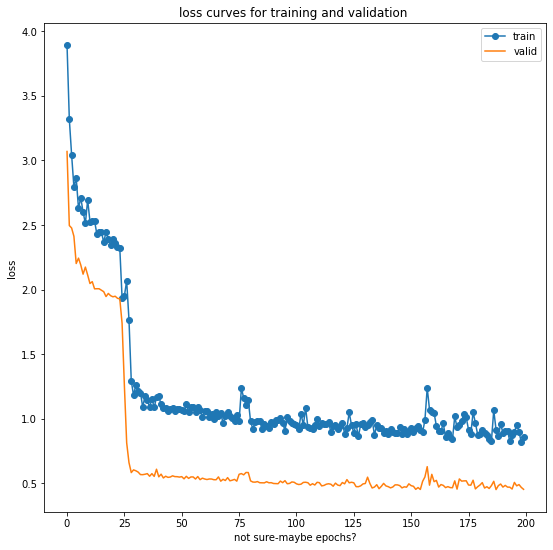

In [159]:
#https://skorch.readthedocs.io/en/stable/history.html
train_loss = net2.history[:, 'train_loss']
valid_loss = net2.history[:, 'valid_loss']
plt.figure(figsize=(9,9))
plt.plot(train_loss,'-o',label='train')
plt.plot(valid_loss,'-',label='valid')
plt.xlabel('not sure-maybe epochs?')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# Set a title of the current axes.
plt.title('loss curves for training and validation ')
plt.legend()
plt.show()

# ROC CURVES  and confusion matrix for our model

<ipython-input-161-dcb0e7465402>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


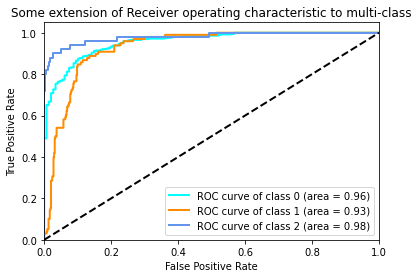

In [161]:
#ref-https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
y_pred_test_prob=net2.predict_proba(x_test.float())
#print(ypred_prob)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_ROC[:, i], y_pred_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_ROC.ravel(), y_pred_test_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

n_classes=3
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

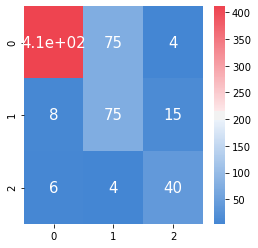

In [168]:
# cofusion matrix
plt.subplots(figsize=(4,4))
cf_matrix = confusion_matrix(y_test, y_pred_test)

cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)
sns.heatmap(cf_matrix, cmap=cmap,annot = True, annot_kws = {'size':15})

# SVM  implementation 

In [179]:
from sklearn import svm 
classifier=svm.SVC(kernel='rbf',gamma=0.1,C=1000)
classifier.fit(Xtrain,Ytrain)
pred2=classifier.predict(Xtest)

In [217]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf','linear','poly'],
              'degree' : [2, 3, 4]
             }
               
  
grid = GridSearchCV(SVC(), param_grid,scoring='recall_macro', refit = True,cv=10, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(Xtrain,Ytrain) 

Fitting 10 folds for each of 225 candidates, totalling 2250 fits
[CV 1/10] END ..........C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.4s
[CV 2/10] END ..........C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.4s
[CV 3/10] END ..........C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.4s
[CV 4/10] END ..........C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.4s
[CV 5/10] END ..........C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.4s
[CV 6/10] END ..........C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.4s
[CV 7/10] END ..........C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.4s
[CV 8/10] END ..........C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.4s
[CV 9/10] END ..........C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.4s
[CV 10/10] END .........C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.3s
[CV 1/10] END .......C=0.1, degree=2, gamma=1, kernel=linear; total time=   0.2s
[CV 2/10] END .......C=0.1, degree=2, gamma=

[CV 2/10] END ...C=0.1, degree=2, gamma=0.001, kernel=linear; total time=   0.2s
[CV 3/10] END ...C=0.1, degree=2, gamma=0.001, kernel=linear; total time=   0.2s
[CV 4/10] END ...C=0.1, degree=2, gamma=0.001, kernel=linear; total time=   0.2s
[CV 5/10] END ...C=0.1, degree=2, gamma=0.001, kernel=linear; total time=   0.2s
[CV 6/10] END ...C=0.1, degree=2, gamma=0.001, kernel=linear; total time=   0.2s
[CV 7/10] END ...C=0.1, degree=2, gamma=0.001, kernel=linear; total time=   0.2s
[CV 8/10] END ...C=0.1, degree=2, gamma=0.001, kernel=linear; total time=   0.2s
[CV 9/10] END ...C=0.1, degree=2, gamma=0.001, kernel=linear; total time=   0.2s
[CV 10/10] END ..C=0.1, degree=2, gamma=0.001, kernel=linear; total time=   0.2s
[CV 1/10] END .....C=0.1, degree=2, gamma=0.001, kernel=poly; total time=   0.5s
[CV 2/10] END .....C=0.1, degree=2, gamma=0.001, kernel=poly; total time=   0.6s
[CV 3/10] END .....C=0.1, degree=2, gamma=0.001, kernel=poly; total time=   0.6s
[CV 4/10] END .....C=0.1, de

[CV 4/10] END .......C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.6s
[CV 5/10] END .......C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.6s
[CV 6/10] END .......C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.6s
[CV 7/10] END .......C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.6s
[CV 8/10] END .......C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.6s
[CV 9/10] END .......C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.7s
[CV 10/10] END ......C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.6s
[CV 1/10] END .......C=0.1, degree=3, gamma=0.01, kernel=rbf; total time=   0.9s
[CV 2/10] END .......C=0.1, degree=3, gamma=0.01, kernel=rbf; total time=   1.0s
[CV 3/10] END .......C=0.1, degree=3, gamma=0.01, kernel=rbf; total time=   0.9s
[CV 4/10] END .......C=0.1, degree=3, gamma=0.01, kernel=rbf; total time=   0.9s
[CV 5/10] END .......C=0.1, degree=3, gamma=0.01, kernel=rbf; total time=   0.9s
[CV 6/10] END .......C=0.1, 

[CV 6/10] END ..........C=0.1, degree=4, gamma=1, kernel=rbf; total time=   0.3s
[CV 7/10] END ..........C=0.1, degree=4, gamma=1, kernel=rbf; total time=   0.3s
[CV 8/10] END ..........C=0.1, degree=4, gamma=1, kernel=rbf; total time=   0.3s
[CV 9/10] END ..........C=0.1, degree=4, gamma=1, kernel=rbf; total time=   0.3s
[CV 10/10] END .........C=0.1, degree=4, gamma=1, kernel=rbf; total time=   0.3s
[CV 1/10] END .......C=0.1, degree=4, gamma=1, kernel=linear; total time=   0.2s
[CV 2/10] END .......C=0.1, degree=4, gamma=1, kernel=linear; total time=   0.2s
[CV 3/10] END .......C=0.1, degree=4, gamma=1, kernel=linear; total time=   0.2s
[CV 4/10] END .......C=0.1, degree=4, gamma=1, kernel=linear; total time=   0.2s
[CV 5/10] END .......C=0.1, degree=4, gamma=1, kernel=linear; total time=   0.2s
[CV 6/10] END .......C=0.1, degree=4, gamma=1, kernel=linear; total time=   0.2s
[CV 7/10] END .......C=0.1, degree=4, gamma=1, kernel=linear; total time=   0.2s
[CV 8/10] END .......C=0.1, 

[CV 8/10] END ...C=0.1, degree=4, gamma=0.001, kernel=linear; total time=   0.2s
[CV 9/10] END ...C=0.1, degree=4, gamma=0.001, kernel=linear; total time=   0.2s
[CV 10/10] END ..C=0.1, degree=4, gamma=0.001, kernel=linear; total time=   0.2s
[CV 1/10] END .....C=0.1, degree=4, gamma=0.001, kernel=poly; total time=   0.6s
[CV 2/10] END .....C=0.1, degree=4, gamma=0.001, kernel=poly; total time=   0.6s
[CV 3/10] END .....C=0.1, degree=4, gamma=0.001, kernel=poly; total time=   0.6s
[CV 4/10] END .....C=0.1, degree=4, gamma=0.001, kernel=poly; total time=   0.6s
[CV 5/10] END .....C=0.1, degree=4, gamma=0.001, kernel=poly; total time=   0.6s
[CV 6/10] END .....C=0.1, degree=4, gamma=0.001, kernel=poly; total time=   0.6s
[CV 7/10] END .....C=0.1, degree=4, gamma=0.001, kernel=poly; total time=   0.6s
[CV 8/10] END .....C=0.1, degree=4, gamma=0.001, kernel=poly; total time=   0.6s
[CV 9/10] END .....C=0.1, degree=4, gamma=0.001, kernel=poly; total time=   0.6s
[CV 10/10] END ....C=0.1, de

[CV 10/10] END ........C=1, degree=2, gamma=0.1, kernel=poly; total time=   0.4s
[CV 1/10] END .........C=1, degree=2, gamma=0.01, kernel=rbf; total time=   0.7s
[CV 2/10] END .........C=1, degree=2, gamma=0.01, kernel=rbf; total time=   0.6s
[CV 3/10] END .........C=1, degree=2, gamma=0.01, kernel=rbf; total time=   0.6s
[CV 4/10] END .........C=1, degree=2, gamma=0.01, kernel=rbf; total time=   0.6s
[CV 5/10] END .........C=1, degree=2, gamma=0.01, kernel=rbf; total time=   0.7s
[CV 6/10] END .........C=1, degree=2, gamma=0.01, kernel=rbf; total time=   0.6s
[CV 7/10] END .........C=1, degree=2, gamma=0.01, kernel=rbf; total time=   0.7s
[CV 8/10] END .........C=1, degree=2, gamma=0.01, kernel=rbf; total time=   0.7s
[CV 9/10] END .........C=1, degree=2, gamma=0.01, kernel=rbf; total time=   0.7s
[CV 10/10] END ........C=1, degree=2, gamma=0.01, kernel=rbf; total time=   0.6s
[CV 1/10] END ......C=1, degree=2, gamma=0.01, kernel=linear; total time=   0.1s
[CV 2/10] END ......C=1, deg

[CV 2/10] END .........C=1, degree=3, gamma=1, kernel=linear; total time=   0.1s
[CV 3/10] END .........C=1, degree=3, gamma=1, kernel=linear; total time=   0.1s
[CV 4/10] END .........C=1, degree=3, gamma=1, kernel=linear; total time=   0.1s
[CV 5/10] END .........C=1, degree=3, gamma=1, kernel=linear; total time=   0.1s
[CV 6/10] END .........C=1, degree=3, gamma=1, kernel=linear; total time=   0.1s
[CV 7/10] END .........C=1, degree=3, gamma=1, kernel=linear; total time=   0.1s
[CV 8/10] END .........C=1, degree=3, gamma=1, kernel=linear; total time=   0.1s
[CV 9/10] END .........C=1, degree=3, gamma=1, kernel=linear; total time=   0.1s
[CV 10/10] END ........C=1, degree=3, gamma=1, kernel=linear; total time=   0.1s
[CV 1/10] END ...........C=1, degree=3, gamma=1, kernel=poly; total time=   0.1s
[CV 2/10] END ...........C=1, degree=3, gamma=1, kernel=poly; total time=   0.1s
[CV 3/10] END ...........C=1, degree=3, gamma=1, kernel=poly; total time=   0.2s
[CV 4/10] END ...........C=1

[CV 4/10] END .......C=1, degree=3, gamma=0.001, kernel=poly; total time=   0.6s
[CV 5/10] END .......C=1, degree=3, gamma=0.001, kernel=poly; total time=   0.6s
[CV 6/10] END .......C=1, degree=3, gamma=0.001, kernel=poly; total time=   0.6s
[CV 7/10] END .......C=1, degree=3, gamma=0.001, kernel=poly; total time=   0.6s
[CV 8/10] END .......C=1, degree=3, gamma=0.001, kernel=poly; total time=   0.6s
[CV 9/10] END .......C=1, degree=3, gamma=0.001, kernel=poly; total time=   0.6s
[CV 10/10] END ......C=1, degree=3, gamma=0.001, kernel=poly; total time=   0.6s
[CV 1/10] END .......C=1, degree=3, gamma=0.0001, kernel=rbf; total time=   1.0s
[CV 2/10] END .......C=1, degree=3, gamma=0.0001, kernel=rbf; total time=   1.0s
[CV 3/10] END .......C=1, degree=3, gamma=0.0001, kernel=rbf; total time=   1.0s
[CV 4/10] END .......C=1, degree=3, gamma=0.0001, kernel=rbf; total time=   1.4s
[CV 5/10] END .......C=1, degree=3, gamma=0.0001, kernel=rbf; total time=   1.3s
[CV 6/10] END .......C=1, de

[CV 6/10] END .........C=1, degree=4, gamma=0.01, kernel=rbf; total time=   0.6s
[CV 7/10] END .........C=1, degree=4, gamma=0.01, kernel=rbf; total time=   0.6s
[CV 8/10] END .........C=1, degree=4, gamma=0.01, kernel=rbf; total time=   0.7s
[CV 9/10] END .........C=1, degree=4, gamma=0.01, kernel=rbf; total time=   0.6s
[CV 10/10] END ........C=1, degree=4, gamma=0.01, kernel=rbf; total time=   0.6s
[CV 1/10] END ......C=1, degree=4, gamma=0.01, kernel=linear; total time=   0.1s
[CV 2/10] END ......C=1, degree=4, gamma=0.01, kernel=linear; total time=   0.1s
[CV 3/10] END ......C=1, degree=4, gamma=0.01, kernel=linear; total time=   0.1s
[CV 4/10] END ......C=1, degree=4, gamma=0.01, kernel=linear; total time=   0.1s
[CV 5/10] END ......C=1, degree=4, gamma=0.01, kernel=linear; total time=   0.1s
[CV 6/10] END ......C=1, degree=4, gamma=0.01, kernel=linear; total time=   0.1s
[CV 7/10] END ......C=1, degree=4, gamma=0.01, kernel=linear; total time=   0.1s
[CV 8/10] END ......C=1, deg

[CV 8/10] END ........C=10, degree=2, gamma=1, kernel=linear; total time=   0.1s
[CV 9/10] END ........C=10, degree=2, gamma=1, kernel=linear; total time=   0.1s
[CV 10/10] END .......C=10, degree=2, gamma=1, kernel=linear; total time=   0.1s
[CV 1/10] END ..........C=10, degree=2, gamma=1, kernel=poly; total time=   0.1s
[CV 2/10] END ..........C=10, degree=2, gamma=1, kernel=poly; total time=   0.1s
[CV 3/10] END ..........C=10, degree=2, gamma=1, kernel=poly; total time=   0.1s
[CV 4/10] END ..........C=10, degree=2, gamma=1, kernel=poly; total time=   0.1s
[CV 5/10] END ..........C=10, degree=2, gamma=1, kernel=poly; total time=   0.1s
[CV 6/10] END ..........C=10, degree=2, gamma=1, kernel=poly; total time=   0.1s
[CV 7/10] END ..........C=10, degree=2, gamma=1, kernel=poly; total time=   0.1s
[CV 8/10] END ..........C=10, degree=2, gamma=1, kernel=poly; total time=   0.1s
[CV 9/10] END ..........C=10, degree=2, gamma=1, kernel=poly; total time=   0.1s
[CV 10/10] END .........C=10

[CV 10/10] END .....C=10, degree=2, gamma=0.001, kernel=poly; total time=   0.6s
[CV 1/10] END ......C=10, degree=2, gamma=0.0001, kernel=rbf; total time=   1.3s
[CV 2/10] END ......C=10, degree=2, gamma=0.0001, kernel=rbf; total time=   1.0s
[CV 3/10] END ......C=10, degree=2, gamma=0.0001, kernel=rbf; total time=   1.8s
[CV 4/10] END ......C=10, degree=2, gamma=0.0001, kernel=rbf; total time=   1.0s
[CV 5/10] END ......C=10, degree=2, gamma=0.0001, kernel=rbf; total time=   1.0s
[CV 6/10] END ......C=10, degree=2, gamma=0.0001, kernel=rbf; total time=   1.0s
[CV 7/10] END ......C=10, degree=2, gamma=0.0001, kernel=rbf; total time=   1.0s
[CV 8/10] END ......C=10, degree=2, gamma=0.0001, kernel=rbf; total time=   1.0s
[CV 9/10] END ......C=10, degree=2, gamma=0.0001, kernel=rbf; total time=   1.0s
[CV 10/10] END .....C=10, degree=2, gamma=0.0001, kernel=rbf; total time=   1.1s
[CV 1/10] END ...C=10, degree=2, gamma=0.0001, kernel=linear; total time=   0.1s
[CV 2/10] END ...C=10, degre

[CV 2/10] END .....C=10, degree=3, gamma=0.01, kernel=linear; total time=   0.1s
[CV 3/10] END .....C=10, degree=3, gamma=0.01, kernel=linear; total time=   0.1s
[CV 4/10] END .....C=10, degree=3, gamma=0.01, kernel=linear; total time=   0.1s
[CV 5/10] END .....C=10, degree=3, gamma=0.01, kernel=linear; total time=   0.1s
[CV 6/10] END .....C=10, degree=3, gamma=0.01, kernel=linear; total time=   0.1s
[CV 7/10] END .....C=10, degree=3, gamma=0.01, kernel=linear; total time=   0.1s
[CV 8/10] END .....C=10, degree=3, gamma=0.01, kernel=linear; total time=   0.1s
[CV 9/10] END .....C=10, degree=3, gamma=0.01, kernel=linear; total time=   0.1s
[CV 10/10] END ....C=10, degree=3, gamma=0.01, kernel=linear; total time=   0.1s
[CV 1/10] END .......C=10, degree=3, gamma=0.01, kernel=poly; total time=   0.6s
[CV 2/10] END .......C=10, degree=3, gamma=0.01, kernel=poly; total time=   0.6s
[CV 3/10] END .......C=10, degree=3, gamma=0.01, kernel=poly; total time=   0.7s
[CV 4/10] END .......C=10, d

[CV 4/10] END ..........C=10, degree=4, gamma=1, kernel=poly; total time=   0.2s
[CV 5/10] END ..........C=10, degree=4, gamma=1, kernel=poly; total time=   0.2s
[CV 6/10] END ..........C=10, degree=4, gamma=1, kernel=poly; total time=   0.2s
[CV 7/10] END ..........C=10, degree=4, gamma=1, kernel=poly; total time=   0.1s
[CV 8/10] END ..........C=10, degree=4, gamma=1, kernel=poly; total time=   0.2s
[CV 9/10] END ..........C=10, degree=4, gamma=1, kernel=poly; total time=   0.2s
[CV 10/10] END .........C=10, degree=4, gamma=1, kernel=poly; total time=   0.2s
[CV 1/10] END .........C=10, degree=4, gamma=0.1, kernel=rbf; total time=   0.3s
[CV 2/10] END .........C=10, degree=4, gamma=0.1, kernel=rbf; total time=   0.2s
[CV 3/10] END .........C=10, degree=4, gamma=0.1, kernel=rbf; total time=   0.4s
[CV 4/10] END .........C=10, degree=4, gamma=0.1, kernel=rbf; total time=   0.3s
[CV 5/10] END .........C=10, degree=4, gamma=0.1, kernel=rbf; total time=   0.3s
[CV 6/10] END .........C=10,

[CV 6/10] END ......C=10, degree=4, gamma=0.0001, kernel=rbf; total time=   1.1s
[CV 7/10] END ......C=10, degree=4, gamma=0.0001, kernel=rbf; total time=   1.3s
[CV 8/10] END ......C=10, degree=4, gamma=0.0001, kernel=rbf; total time=   1.2s
[CV 9/10] END ......C=10, degree=4, gamma=0.0001, kernel=rbf; total time=   1.1s
[CV 10/10] END .....C=10, degree=4, gamma=0.0001, kernel=rbf; total time=   1.0s
[CV 1/10] END ...C=10, degree=4, gamma=0.0001, kernel=linear; total time=   0.1s
[CV 2/10] END ...C=10, degree=4, gamma=0.0001, kernel=linear; total time=   0.2s
[CV 3/10] END ...C=10, degree=4, gamma=0.0001, kernel=linear; total time=   0.1s
[CV 4/10] END ...C=10, degree=4, gamma=0.0001, kernel=linear; total time=   0.2s
[CV 5/10] END ...C=10, degree=4, gamma=0.0001, kernel=linear; total time=   0.1s
[CV 6/10] END ...C=10, degree=4, gamma=0.0001, kernel=linear; total time=   0.1s
[CV 7/10] END ...C=10, degree=4, gamma=0.0001, kernel=linear; total time=   0.1s
[CV 8/10] END ...C=10, degre

[CV 8/10] END ....C=100, degree=2, gamma=0.01, kernel=linear; total time=   0.3s
[CV 9/10] END ....C=100, degree=2, gamma=0.01, kernel=linear; total time=   0.3s
[CV 10/10] END ...C=100, degree=2, gamma=0.01, kernel=linear; total time=   0.3s
[CV 1/10] END ......C=100, degree=2, gamma=0.01, kernel=poly; total time=   0.4s
[CV 2/10] END ......C=100, degree=2, gamma=0.01, kernel=poly; total time=   0.4s
[CV 3/10] END ......C=100, degree=2, gamma=0.01, kernel=poly; total time=   0.4s
[CV 4/10] END ......C=100, degree=2, gamma=0.01, kernel=poly; total time=   0.4s
[CV 5/10] END ......C=100, degree=2, gamma=0.01, kernel=poly; total time=   0.3s
[CV 6/10] END ......C=100, degree=2, gamma=0.01, kernel=poly; total time=   0.5s
[CV 7/10] END ......C=100, degree=2, gamma=0.01, kernel=poly; total time=   0.4s
[CV 8/10] END ......C=100, degree=2, gamma=0.01, kernel=poly; total time=   0.4s
[CV 9/10] END ......C=100, degree=2, gamma=0.01, kernel=poly; total time=   0.4s
[CV 10/10] END .....C=100, d

[CV 10/10] END ........C=100, degree=3, gamma=1, kernel=poly; total time=   0.4s
[CV 1/10] END ........C=100, degree=3, gamma=0.1, kernel=rbf; total time=   0.2s
[CV 2/10] END ........C=100, degree=3, gamma=0.1, kernel=rbf; total time=   0.2s
[CV 3/10] END ........C=100, degree=3, gamma=0.1, kernel=rbf; total time=   0.2s
[CV 4/10] END ........C=100, degree=3, gamma=0.1, kernel=rbf; total time=   0.2s
[CV 5/10] END ........C=100, degree=3, gamma=0.1, kernel=rbf; total time=   0.2s
[CV 6/10] END ........C=100, degree=3, gamma=0.1, kernel=rbf; total time=   0.2s
[CV 7/10] END ........C=100, degree=3, gamma=0.1, kernel=rbf; total time=   0.2s
[CV 8/10] END ........C=100, degree=3, gamma=0.1, kernel=rbf; total time=   0.2s
[CV 9/10] END ........C=100, degree=3, gamma=0.1, kernel=rbf; total time=   0.2s
[CV 10/10] END .......C=100, degree=3, gamma=0.1, kernel=rbf; total time=   0.2s
[CV 1/10] END .....C=100, degree=3, gamma=0.1, kernel=linear; total time=   0.3s
[CV 2/10] END .....C=100, de

[CV 2/10] END ..C=100, degree=3, gamma=0.0001, kernel=linear; total time=   0.3s
[CV 3/10] END ..C=100, degree=3, gamma=0.0001, kernel=linear; total time=   0.3s
[CV 4/10] END ..C=100, degree=3, gamma=0.0001, kernel=linear; total time=   0.3s
[CV 5/10] END ..C=100, degree=3, gamma=0.0001, kernel=linear; total time=   0.3s
[CV 6/10] END ..C=100, degree=3, gamma=0.0001, kernel=linear; total time=   0.3s
[CV 7/10] END ..C=100, degree=3, gamma=0.0001, kernel=linear; total time=   0.3s
[CV 8/10] END ..C=100, degree=3, gamma=0.0001, kernel=linear; total time=   0.3s
[CV 9/10] END ..C=100, degree=3, gamma=0.0001, kernel=linear; total time=   0.3s
[CV 10/10] END .C=100, degree=3, gamma=0.0001, kernel=linear; total time=   0.3s
[CV 1/10] END ....C=100, degree=3, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 2/10] END ....C=100, degree=3, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 3/10] END ....C=100, degree=3, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 4/10] END ....C=100, deg

[CV 4/10] END ......C=100, degree=4, gamma=0.01, kernel=poly; total time=   0.8s
[CV 5/10] END ......C=100, degree=4, gamma=0.01, kernel=poly; total time=   0.6s
[CV 6/10] END ......C=100, degree=4, gamma=0.01, kernel=poly; total time=   0.7s
[CV 7/10] END ......C=100, degree=4, gamma=0.01, kernel=poly; total time=   0.6s
[CV 8/10] END ......C=100, degree=4, gamma=0.01, kernel=poly; total time=   0.7s
[CV 9/10] END ......C=100, degree=4, gamma=0.01, kernel=poly; total time=   0.6s
[CV 10/10] END .....C=100, degree=4, gamma=0.01, kernel=poly; total time=   0.6s
[CV 1/10] END ......C=100, degree=4, gamma=0.001, kernel=rbf; total time=   0.4s
[CV 2/10] END ......C=100, degree=4, gamma=0.001, kernel=rbf; total time=   0.4s
[CV 3/10] END ......C=100, degree=4, gamma=0.001, kernel=rbf; total time=   0.4s
[CV 4/10] END ......C=100, degree=4, gamma=0.001, kernel=rbf; total time=   0.4s
[CV 5/10] END ......C=100, degree=4, gamma=0.001, kernel=rbf; total time=   0.4s
[CV 6/10] END ......C=100, d

[CV 6/10] END .......C=1000, degree=2, gamma=0.1, kernel=rbf; total time=   0.3s
[CV 7/10] END .......C=1000, degree=2, gamma=0.1, kernel=rbf; total time=   0.3s
[CV 8/10] END .......C=1000, degree=2, gamma=0.1, kernel=rbf; total time=   0.3s
[CV 9/10] END .......C=1000, degree=2, gamma=0.1, kernel=rbf; total time=   0.2s
[CV 10/10] END ......C=1000, degree=2, gamma=0.1, kernel=rbf; total time=   0.2s
[CV 1/10] END ....C=1000, degree=2, gamma=0.1, kernel=linear; total time=   1.4s
[CV 2/10] END ....C=1000, degree=2, gamma=0.1, kernel=linear; total time=   1.3s
[CV 3/10] END ....C=1000, degree=2, gamma=0.1, kernel=linear; total time=   1.2s
[CV 4/10] END ....C=1000, degree=2, gamma=0.1, kernel=linear; total time=   1.4s
[CV 5/10] END ....C=1000, degree=2, gamma=0.1, kernel=linear; total time=   1.3s
[CV 6/10] END ....C=1000, degree=2, gamma=0.1, kernel=linear; total time=   1.4s
[CV 7/10] END ....C=1000, degree=2, gamma=0.1, kernel=linear; total time=   1.2s
[CV 8/10] END ....C=1000, de

[CV 8/10] END .C=1000, degree=2, gamma=0.0001, kernel=linear; total time=   1.2s
[CV 9/10] END .C=1000, degree=2, gamma=0.0001, kernel=linear; total time=   1.4s
[CV 10/10] END C=1000, degree=2, gamma=0.0001, kernel=linear; total time=   1.2s
[CV 1/10] END ...C=1000, degree=2, gamma=0.0001, kernel=poly; total time=   0.5s
[CV 2/10] END ...C=1000, degree=2, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 3/10] END ...C=1000, degree=2, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 4/10] END ...C=1000, degree=2, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 5/10] END ...C=1000, degree=2, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 6/10] END ...C=1000, degree=2, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 7/10] END ...C=1000, degree=2, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 8/10] END ...C=1000, degree=2, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 9/10] END ...C=1000, degree=2, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 10/10] END ..C=1000, deg

[CV 10/10] END ....C=1000, degree=3, gamma=0.01, kernel=poly; total time=   0.5s
[CV 1/10] END .....C=1000, degree=3, gamma=0.001, kernel=rbf; total time=   0.3s
[CV 2/10] END .....C=1000, degree=3, gamma=0.001, kernel=rbf; total time=   0.3s
[CV 3/10] END .....C=1000, degree=3, gamma=0.001, kernel=rbf; total time=   0.3s
[CV 4/10] END .....C=1000, degree=3, gamma=0.001, kernel=rbf; total time=   0.3s
[CV 5/10] END .....C=1000, degree=3, gamma=0.001, kernel=rbf; total time=   0.3s
[CV 6/10] END .....C=1000, degree=3, gamma=0.001, kernel=rbf; total time=   0.3s
[CV 7/10] END .....C=1000, degree=3, gamma=0.001, kernel=rbf; total time=   0.3s
[CV 8/10] END .....C=1000, degree=3, gamma=0.001, kernel=rbf; total time=   0.3s
[CV 9/10] END .....C=1000, degree=3, gamma=0.001, kernel=rbf; total time=   0.3s
[CV 10/10] END ....C=1000, degree=3, gamma=0.001, kernel=rbf; total time=   0.3s
[CV 1/10] END ..C=1000, degree=3, gamma=0.001, kernel=linear; total time=   1.2s
[CV 2/10] END ..C=1000, degr

[CV 2/10] END ....C=1000, degree=4, gamma=0.1, kernel=linear; total time=   1.3s
[CV 3/10] END ....C=1000, degree=4, gamma=0.1, kernel=linear; total time=   1.3s
[CV 4/10] END ....C=1000, degree=4, gamma=0.1, kernel=linear; total time=   1.4s
[CV 5/10] END ....C=1000, degree=4, gamma=0.1, kernel=linear; total time=   1.3s
[CV 6/10] END ....C=1000, degree=4, gamma=0.1, kernel=linear; total time=   1.4s
[CV 7/10] END ....C=1000, degree=4, gamma=0.1, kernel=linear; total time=   1.2s
[CV 8/10] END ....C=1000, degree=4, gamma=0.1, kernel=linear; total time=   1.1s
[CV 9/10] END ....C=1000, degree=4, gamma=0.1, kernel=linear; total time=   1.3s
[CV 10/10] END ...C=1000, degree=4, gamma=0.1, kernel=linear; total time=   1.1s
[CV 1/10] END ......C=1000, degree=4, gamma=0.1, kernel=poly; total time=   0.2s
[CV 2/10] END ......C=1000, degree=4, gamma=0.1, kernel=poly; total time=   0.2s
[CV 3/10] END ......C=1000, degree=4, gamma=0.1, kernel=poly; total time=   0.2s
[CV 4/10] END ......C=1000, 

[CV 4/10] END ...C=1000, degree=4, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 5/10] END ...C=1000, degree=4, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 6/10] END ...C=1000, degree=4, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 7/10] END ...C=1000, degree=4, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 8/10] END ...C=1000, degree=4, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 9/10] END ...C=1000, degree=4, gamma=0.0001, kernel=poly; total time=   0.6s
[CV 10/10] END ..C=1000, degree=4, gamma=0.0001, kernel=poly; total time=   0.6s


GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'degree': [2, 3, 4],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='recall_macro', verbose=3)

In [218]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1000, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1000, degree=2, gamma=1)


In [219]:
grid_predictions = grid.predict(Xtest) 

  
# print classification report 
print(classification_report(Ytest, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       490
         1.0       0.70      0.72      0.71        98
         2.0       0.86      0.72      0.78        50

    accuracy                           0.89       638
   macro avg       0.83      0.80      0.81       638
weighted avg       0.90      0.89      0.89       638



# final model

despite of the grid search the final model seemed to overfit so we changed the gamma and the C values manually to get a more optimal scores

In [223]:
from sklearn import svm 
from sklearn.model_selection import cross_validate
classifier=svm.SVC(kernel='rbf',gamma=0.1,C=100,degree=2,probability=True)
scores = cross_validate(classifier, Xtrain, Ytrain, scoring='recall_macro',cv=5)#cross validation implementation is it correct 
classifier.fit(Xtrain,Ytrain)
#pred2=classifier.cross_val_predict(Xtest)#error
pred_train=classifier.predict(Xtrain)
pred2=classifier.predict(Xtest)

In [224]:
#getting the recall_score on train 
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

print("recall_score:",recall_score(Ytrain, pred_train,average='macro'))
print("accuracy_score:",accuracy_score(Ytrain, pred_train))
from sklearn.metrics import classification_report,confusion_matrix
confusion_matrix(Ytrain, pred_train)

recall_score: 0.9058655221745351
accuracy_score: 0.9058655221745351


array([[1005,  156,    4],
       [  24, 1046,   95],
       [  17,   33, 1115]], dtype=int64)

In [226]:
#getting the recall_score on test 
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

print("recall_score:",recall_score(Ytest, pred2,average='macro'))
print("accuracy_score:",accuracy_score(Ytest, pred2))
from sklearn.metrics import classification_report,confusion_matrix
confusion_matrix(Ytest, pred2)


recall_score: 0.8235374149659864
accuracy_score: 0.8605015673981191


array([[434,  54,   2],
       [ 11,  73,  14],
       [  6,   2,  42]], dtype=int64)

# ROC Curve for SVM 

In [227]:
ypred2_prob=classifier.predict_proba(Xtest)
print(ypred_prob)

[[9.99438154e-01 5.60939824e-04 9.05699189e-07]
 [9.96902579e-01 3.03264005e-03 6.47812925e-05]
 [9.99995544e-01 4.45580660e-06 8.24545050e-11]
 ...
 [9.96957417e-01 3.01444846e-03 2.81348418e-05]
 [9.76858866e-01 2.31407934e-02 3.41007281e-07]
 [9.93212768e-01 6.78451197e-03 2.72051172e-06]]


<ipython-input-228-59889bc69d16>:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


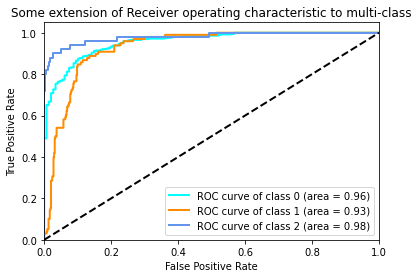

In [228]:

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_ROC[:, i], ypred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_ROC.ravel(), ypred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

n_classes=3
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [229]:
#y_prob = mlp.predict_proba(X_test)
#Y_test_ROC[:, i], ypred_prob[:, i])

macro_roc_auc_ovo = roc_auc_score(Y_test_ROC, Y_test_ROC, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(Y_test_ROC, Y_test_ROC, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(Y_test_ROC, Y_test_ROC, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(Y_test_ROC, Y_test_ROC, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
1.000000 (macro),
1.000000 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
1.000000 (macro),
1.000000 (weighted by prevalence)
